# Imports

In [1]:
#Required packages to run the code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
from keras.models import *
from keras.layers import *
from keras import Input
import sklearn
from sklearn import svm
import pickle
import seaborn as sns
import geopandas
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, mutual_info_classif
%store -r
%matplotlib tk

Unable to restore variable 'history_100_125', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_100_25', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_100_375', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_100_50', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_100_625', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_100_75', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_100_875', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_150_125', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'history_150_25', ignoring (use %store -d to for

# Save and Load models

In [2]:
#Save or load a trainned CNN model
def save_model_cnn(model,name):
    model.save(name)

def load_model_cnn(name):
    return keras.models.load_model(name)

def save_model_svm(name,model):
    pickle.dump(model, open(name, 'wb'))
    
def load_model_svm(name):
    return pickle.load(open(name, 'rb'))

# Gerar grafo e A

In [3]:
def get_adjacency(sz,p,undirected):
    '''
    Generates a realization of an Erdős–Rényi Graph Model, undirected or directed.
    -First generates of matrix of random floating point numbers in the range [0.0, 1.0].
    -If those values are <=p then there is no edge between pairs
    -Makes the matrix symmetric if the graoh is undirected

        Parameters:
                sz (int): Number of nodes
                p (int): Probability of existing an edge between each pair of nodes

        Returns:
                adj (2darray): Adjacency matrix
    '''
    adj = np.random.random((sz, sz)) <= p
    adj = np.triu(adj.astype(int))
    np.fill_diagonal(adj,0)
    if(undirected):
        adj = adj + adj.T
    return adj

def get_A(adj,c,rho):
    '''
    Generates the connectivity matrix (interaction weights) from the adjacency matrix according to the laplacian rule

        Parameters:
                adj (2darray): Adjacency matrix
                c,rho (int): Numbers between 0 and 1, to make the spectral radius < 1

        Returns:
                A (2darray): Connectivity matrix
    '''    
    sz = len(adj)
    Dvec = np.sum(adj, axis=1)
    Dmax = np.max(Dvec)
    ccc = c*1/Dmax
    D = np.diag(Dvec)
    L = D - adj
    Ap = np.eye(sz) - ccc*L
    A = rho * Ap
    return A

# Linear

In [4]:
def gen_linear_time_series(A,tsize,x0,noise):
    '''
    Generates the syntetic time series data given the connectivity matrix and the initial condiction x(0), 
    according to the dynnamical rule y(n + 1) = Ay(n) + x(n + 1) + alpha/n*1*1^t X'(n+1)

        Parameters:
                A (2darray): Connectivity matrix
                tsize (int): Time series size - number of samples
                x0 (int): Initial condition x(0), in this case is zero
                noise (2darray): Noise matrix

        Returns:
                x (2darray): Time series data of the graph
    ''' 
    sz = len(A)
    x = np.zeros((tsize,sz))
    x[0,:] = np.ones((1,sz))*x0
    
    for i in range(1,tsize):
        x[i,:] = np.dot(A,x[i-1,:]) + noise[i,:]
    return x

# Noise

In [5]:
def generate_noise(N, n_samples, alpha, beta):
    '''
        y(n + 1) = alpha * x1(n+1) + beta * 1*1.T * X2(n+1)

        Parameters:
                N (int): number of nodes
                n_samples (int): number of samples
                alpha (float): Standard Deviation of noise X1
                Beta (float): Standard Deviation of noise X2

        Returns:
                z (2darray): Time series data of the graph
    ''' 
    
    ones = np.ones((N,N)) * beta/np.sqrt(N)
    
    z = np.zeros((n_samples, N))
    
    for i in range(n_samples):
        x1 = np.random.normal(size=(1,N))
        x2 = np.random.normal(size=(1,N))
        
        z[i,:] = alpha * x1 + np.matmul(x2,ones)
        
    return z

# Non-Linear

In [6]:
def nonlinear_fun(x,alpha=1.5):
    '''
    Transforms the given input according to the following function
            
            Parameters:
                x (int): Value to be transformed
                alpha (int): Function parameter
                
            Returns:
                x (int): Transformed x value
    ''' 
    if(x>0):
        return x**alpha
    elif(x<0):
        return -(abs(x))**alpha
    return x

def gen_time_series_non_linear(A,tsize,x0,qsi):
    '''
    Generates the syntetic time series data given the connectivity matrix and the initial condiction x(0), 
    according to the dynnamical rule y(n + 1) = Ay(n) + x(n + 1)

        Parameters:
                A (2darray): Connectivity matrix
                tsize (int): Time series size - number of samples
                x0 (int): Initial condition x(0), in this case is zero
                qsi (int): Noise standart deviation 

        Returns:
                x (2darray): Time series data of the graph
    ''' 
    sz = len(A)
    x = np.zeros((tsize,sz))
    
    x[0,:] = np.ones((1,sz))*x0
    for i in range(1,tsize):
        for j in range(sz):
            nxt = np.dot(A[j,:],x[i-1,:]) + qsi*np.random.randn(1)
            x[i,j] = nonlinear_fun(nxt)
    return x

# Granger

In [6]:
def granger(z):
    '''
    Granger Estimator

        Parameters:
                z (2darray): Time series of the observed nodes

        Returns:
                R1*inv(R0) (2darray): Estimated connectivity matrix
    '''   
    z=z.T
    tsize = z.shape[1]
    
    #0-lag correlation matrix
    R0=np.matmul(z,z.T)/tsize

    #1-lag correlation matrix
    z1=z[:,2:tsize]
    z2=z[:,1:tsize-1]
    R1=np.matmul(z1,z2.T)/(tsize-1)

    #R1*inv(R0)
    return np.matmul(R1,np.linalg.inv(R0))

# Metrics

In [8]:
def get_metrics(true, pred, upper, nc):
    '''
    This function rescales the data and computes the performance metrics, this way the measurements are calculated using the 
    same scale

        Parameters:
                true (1darray): Ground truth matrix A
                pred (1darray): Estimated matrix A
                upper (int): Number of pairs of nodes
                nc (int): Number of connected pairs

        Returns:
                idgap (int): Identifiability gap
                clvar (int): Cluster Variance
    '''
    #Normalize the values
    pred = sklearn.preprocessing.minmax_scale(pred, feature_range=(0, 1), axis=0, copy=True)
    
    #Initialize the structures to save the data
    con = np.zeros((nc))
    dis = np.zeros((upper-nc))
    
    #Split the values belonging to connected and disconnected pairs
    c2,c3 = 0,0
    for i in range(len(true)):
        if(true[i]>0):
            con[c2] = pred[i]
            c2+=1
        else:
            dis[c3] = pred[i]
            c3+=1
    
    #Threshold
    mint = np.max(dis)
    maxt = np.min(con)
    threshold = np.ones((upper,))*((mint+maxt)/2)
    
    #Compute metrics
    clvar = (np.var(dis)+np.var(con))/2
    idgap = maxt - ((mint+maxt)/2)
    
    #If the id gap is negative then we cant correctly classify the pairs as disconnected or connected
    if(idgap < 0):
        idgap=0
    
    return clvar,idgap

# Cluster

In [9]:
def cluster_pred(true,pred,method,estimator):
    '''
    Clusters the estimators' results into two groups and classifies it into connected and disconnected

        Parameters:
                true (2darray): Ground truth matrix A
                pred (2darray): Estimated matrix A
                method (string): Clustering method to be applied
                estimator (string): Estimator type: granger, r1-r3 or r1

        Returns:
                accuracy (1darray): Accuracy of the estimations
    '''

    #Sort it
    idx = np.argsort(pred, axis=0)

    #Build a data structure for clustering
    features = np.zeros((len(pred),2))
    features[:,0] = np.linspace(0,1,len(pred))
    features[:,1] = pred[idx]
    
    #Clustering data with Gaussian Mixture Model or kmeans
    if(method=="gmm"):
        gmm = GaussianMixture(n_components=2)
        labels = gmm.fit_predict(features)
    elif(method=="kmeans"):
        kmeans = KMeans(n_clusters=2)
        labels = kmeans.fit_predict(features)

    #Unsort the values after clustering
    us = np.argsort(idx, axis=0)
    labels_unsorted = labels[us]
    cld = pred[np.where(labels_unsorted == 1)]
    clc = pred[np.where(labels_unsorted == 0)]

    #Disconnected pairs must be on cld and conneceed pairs on clc
    if(np.mean(cld)>np.mean(clc)):
        temp = cld
        cld=clc
        clc=temp
        labels_unsorted[:] = np.abs(labels_unsorted[:]-1)
        
    
    #Count the number of pairs correctly classified
    tcout = 0
    for i in range(len(labels_unsorted)):
        if((labels_unsorted[i]==1 and true[i]>0) or (labels_unsorted[i]==0 and true[i]==0)):
            tcout+=1
        
    #Compute accuracy
    accuracy = 100-(tcout/len(labels_unsorted)*100)
    return accuracy

def clusters_r(labels):
    cld = np.where(labels == 1)
    clc = np.where(labels == 0)
    
    #Disconnected pairs must be on cld and conneceed pairs on clc
    if(np.mean(cld)>np.mean(clc)):
        temp = cld
        cld=clc
        clc=temp
        labels[:] = np.abs(labels[:]-1)
        
    
        
    #Compute accuracy
    accuracy = 100-(tcout/len(labels)*100)
    return accuracy

# Estimator Results

In [10]:
def estimator_results(As,pred,method,estimator,undirected):
    '''
    Computes the estimators' performance metrics from their estimated matrix A

        Parameters:
                As (2darray): Ground truth matrix A
                pred (2darray): Estimated matrix A
                method (string): Clustering method to be applied
                estimator (string): Estimator type: granger, r1-r3 or r1

        Returns:
                R1 (1darray): Performance metrics (accuracy, identifiability gap)
    '''
    
    #Number of nodes
    sz = len(As)

    #Count the number of connected and disconnected pairs
    if(undirected):
        alln = int(sz*(sz-1)/2)
        tr = np.triu(As)
        np.fill_diagonal(tr,0)
        tr = tr>0
        tr=tr.astype(int)
        nc = np.sum(tr)
    else:
        alln = (sz*sz)-sz
        tr = As
        np.fill_diagonal(tr,0)
        tr = tr>0
        tr=tr.astype(int)
        nc = np.sum(tr)
        
    #Divide the pairs into connected and disconnected
    con = np.zeros((nc))
    dis = np.zeros((alln-nc))
    comp = np.zeros((2,alln))

    #Save data
    c1,c2,c3 = 0,0,0
    if(undirected):
        for i in range(sz):
            for j in range(i+1,sz):
                comp[0,c1] = As[i,j]
                comp[1,c1] = pred[i,j]
                c1=c1+1
                if(As[i,j]>0):
                    con[c2] = pred[i,j]
                    c2+=1
                else:
                    dis[c3] = pred[i,j]
                    c3+=1
    else:
        for i in range(sz):
            for j in range(sz):
                if(j!=i):
                    comp[0,c1] = As[i,j]
                    comp[1,c1] = pred[i,j]
                    c1=c1+1
                    if(As[i,j]>0):
                        con[c2] = pred[i,j]
                        c2+=1
                    else:
                        dis[c3] = pred[i,j]
                        c3+=1
                
    #Get the estimation performance metrics
    accuracy=cluster_pred(np.copy(comp[0,:]),np.copy(comp[1,:]),method,estimator)
    clvar,idgap=get_metrics(np.copy(comp[0,:]), np.copy(comp[1,:]), alln, nc)
    return {"accuracy":accuracy,"clvar":clvar,"idgap":idgap}

# Create Dataset

In [6]:
def create_dataset(sz,tsize,undirected,A,time_series,n_features):
    '''
    Generates the synthectic data, extracts the features and returns the tranning/testing dataset

        Parameters:
                sz (int): Number of nodes
                p (int): Probability of existing an edge between each pair of nodes
                c,rho (int): Numbers between 0 and 1, to make the spectral radius < 1  
                tsize (int): Time series size - number of samples
                x0 (int): Initial condition x(0), in this case is zero
                qsi (int): Noise standart deviation 
                A (2darray): Grown-Truth matrix A

        Returns:
                data (2darray): Matrix containing the feature-vectors between each pair of nodes
                target (1darray): Ground-truth - pairs are connected or disconnected
    '''     
    nFeatures = int(n_features/2)

    #Is the graph undirected or directed
    if(undirected):
        
        #Create data structures
        upper = int(sz*(sz-1)/2)  #Number of elements in the upper matrix
        data = np.zeros((n_features,upper))
        target = np.zeros((1,upper))
        
        #Goes through each pair (of the upper matrix) and computes the time laged cross-correlation (excludes diagonal)
        counter = 0
        for j in range(sz):
            for k in range(j+1,sz):
                #Compute the cross correlation
                aux = signal.correlate(time_series[:,j],time_series[:,k], mode="full")
                #Extracts the first negative and positive lags
                data[:,counter] = aux[tsize-nFeatures:tsize+nFeatures]
                #Saves the data
                target[0,counter] = A[j,k]
                counter = counter + 1
    else:
        #Create data structures
        dsize = (sz*sz)-sz       #Number of elements excluding the diagonal
        data = np.zeros((200,dsize))
        target = np.zeros((1,dsize))
        
        #Goes through each pair and computes the time laged cross-correlation (excludes diagonal)
        counter = 0
        for j in range(sz):
            for k in range(sz):
                if(j!=k):
                    #Computes the cross correlation
                    aux = signal.correlate(time_series[:,j],time_series[:,k], mode="full")
                    #Extracts the firs negative and positive lags
                    data[:,counter] = aux[tsize-nFeatures:tsize+nFeatures]
                    #Saves the data
                    target[0,counter] = A[j,k]
                    counter = counter + 1 
    return data,target

# Train CNN

In [7]:
def train_model(X_train,y_train,n_features):
    cb = EarlyStopping(monitor='val_loss', mode='min',patience=7)

    #CNN architecture
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, strides=2,activation='relu', input_shape=(n_features,1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    
    #Save the rmsesparse_categorical_crossentropy
    history = model.fit(X_train, y_train, epochs=200, validation_split=0.1, callbacks=[cb], verbose = 0)
    return model

def train_cnn_new_model(X_train,y_train,n_features):
    cb = EarlyStopping(monitor='val_loss', mode='min',patience=20)

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=200, validation_split=0.1, callbacks=[cb], verbose = 0)
    return model

# Train FeedForward

In [8]:
def train_feed_forward(X_train,y_train,n_features):
    cb = EarlyStopping(monitor='val_loss', mode='min',patience=7)

    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(100, activation='softplus'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=500, validation_split=0.1, callbacks=[cb], verbose = 0)
    
    return model


# R1

In [13]:
def r1(z):
    '''
    R1 Estimator

        Parameters:
                z (2darray): Time series of the observed nodes

        Returns:
                R1 (2darray): Estimated connectivity matrix
    '''
    z = z.T
    sz = z.shape[0]
    tsize = z.shape[1]
    
    #1-lag correlation matrix
    z1=z[:,2:tsize]
    z2=z[:,1:tsize-1]
    R1=np.matmul(z1,z2.T)/(tsize-1)

    #id - inv(R1+R2+id) Estimator
    return R1

# Normalize Features

In [9]:
def normalize_features(features, tsize):
    """
        Normalize the features based on the number of terms of correlate
    """
    offset = features.shape[1] // 2
    return features / np.arange(tsize-offset, tsize+offset)

# Parameters

In [10]:
#Parameters
sz = 100    #Number of nodes
p = 0.5     #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75

#Define the range of noise variance
qsi = 0.1
tsize = 1000000    #Number of samples (time series size)
x0 = 0            #Initial condition

undirected = False #graph undirected or not

# Build Diagonal Dataset

In [14]:
beta = 0
alpha = 1

adj = get_adjacency(sz,p,undirected)

A = get_A(adj,c,rho)

noise_diagonal = generate_noise(sz,tsize,alpha,beta)

#get time series with diagonal noise
time_series_diagonal = gen_linear_time_series(A,tsize,x0,noise_diagonal)

#get dataset for CNN training
data_diagonal,target_diagonal = create_dataset(sz,tsize,undirected,A,time_series_diagonal,200)

data_sergio = data_diagonal/np.max(data_diagonal)

#Transforms the ground-truth values into classes
y_diagonal=target_diagonal>0
y_diagonal=y_diagonal.astype(int)

#Scale data with max
data_diagonal_scaled = normalize_features(data_diagonal.T,tsize)

data_diagonal_max = data_diagonal_scaled/np.max(data_diagonal_scaled)

ss = StandardScaler()

data_diagonal_ss = ss.fit_transform(data_diagonal_scaled)

%store data_diagonal_scaled
%store data_diagonal_max
%store data_diagonal_ss
%store data_sergio

Stored 'data_diagonal_scaled' (ndarray)
Stored 'data_diagonal_max' (ndarray)
Stored 'data_diagonal_ss' (ndarray)


# Build Colored Dataset

In [10]:
#betas = np.arange(0.1,1.1,0.1)
beta = 1
alpha = 1

adj = get_adjacency(sz,p,undirected)

A = get_A(adj,c,rho)

noise_colored = generate_noise(sz,tsize,alpha,beta)

#get time series with diagonal noise
time_series_colored = gen_linear_time_series(A,tsize,x0,noise_colored)

#get dataset for CNN training
data_colored,target_colored = create_dataset(sz,tsize,undirected,A,time_series_colored,200)

#Transforms the ground-truth values into classes
y_colored=target_colored>0
y_colored=y_colored.astype(int)

#Scale data with max
data_colored_scaled = normalize_features(data_colored.T,tsize)

data_scaled_max = data_colored_scaled/np.max(data_colored_scaled)

ss = StandardScaler()

data_scaled_ss = ss.fit_transform(data_colored_scaled)

# Feature Selection

In [8]:
data_cnn_4 = data_diagonal_scaled[147:151,:]

data_cnn_10 = data_diagonal_scaled[144:154,:]

data_cnn_24 = data_diagonal_scaled[137:161,:]

data_cnn_30 = data_diagonal_scaled[134:164,:]

data_cnn_40 = data_diagonal_scaled[129:169,:]

data_cnn_50 = data_diagonal_scaled[224:274,:]

data_cnn_60 = data_diagonal_scaled[119:179,:]

data_cnn_70 = data_diagonal_scaled[114:184,:]

data_cnn_80 = data_diagonal_scaled[109:189,:]

data_cnn_90 = data_diagonal_scaled[104:194,:]

data_cnn_100 = data_diagonal_scaled[199:299,:]

data_cnn_150 = data_diagonal_scaled[174:324,:]

data_cnn_200 = data_diagonal_scaled[149:349,:]

data_cnn_250 = data_diagonal_scaled[124:374,:]

data_cnn_300 = data_diagonal_scaled[99:399,:]

data_cnn_350 = data_diagonal_scaled[74:424,:]

data_cnn_400 = data_diagonal_scaled[49:449,:]

data_cnn_450 = data_diagonal_scaled[24:474,:]

data_cnn_500 = data_diagonal_scaled

# Train Models

## CNN with 4 features

In [17]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_4.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,4)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_4features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_4features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_4features_0.50p\assets


## CNN with 10 features

In [18]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_10.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,10)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
print(performance_list)
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_10features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_10features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_10features_0.50p\assets


## CNN with 24 features

In [17]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_24.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,24)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_24features_0.50p_sergioArchitecture')

Run 0
Epoch 1/1000
16/16 [==============================] - 1s 28ms/step - loss: 0.1796 - val_loss: 0.0603
Epoch 2/1000
16/16 [==============================] - 0s 14ms/step - loss: 0.0222 - val_loss: 0.0023
Epoch 3/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0063
Epoch 4/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 5/1000
16/16 [==============================] - 0s 14ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 6/1000
16/16 [==============================] - 0s 19ms/step - loss: 0.0077 - val_loss: 0.0050
Epoch 7/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 8.8386e-04
Epoch 8/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 9/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 10/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.006

INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_24features_0.50p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_24features_0.50p_sergioArchitecture\assets


## CNN with 30 features

In [21]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_200.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,200)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    id_gap = min(cpred)-max(dpred)
    
    #Add to performance list
    performance_list.append(id_gap)
    
#Select the best model
print(performance_list)
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_200features_0.75p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
[array([0.860129], dtype=float32), array([0.9015157], dtype=float32), array([0.9115039], dtype=float32), array([0.88087535], dtype=float32), array([0.9745535], dtype=float32), array([0.88025326], dtype=float32), array([0.8159632], dtype=float32), array([0.8726798], dtype=float32), array([0.9337853], dtype=float32), array([0.9019286], dtype=float32)]


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_200features_0.75p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_200features_0.75p_sergioArchitecture\assets


## CNN with 40 Features

In [67]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_40.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,40)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_40features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_40features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_40features_0.50p\assets


## CNN with 50 Features

In [16]:
nruns = 50
models_list = []
performance_list = []
for i in range(nruns):
    print("Run " + str(i+1))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_50.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,50)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_50features_0.80p_sergioArchitecture')

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50


INFO:tensorflow:Assets written to: diagonal_model_cnn_50features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_50features_0.80p_sergioArchitecture\assets


## CNN with 60 Features

In [22]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_60.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,60)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_60features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_60features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_60features_0.50p\assets


## CNN with 70 features

In [70]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_70.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,70)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_70features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_70features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_70features_0.50p\assets


## CNN with 80 Features

In [71]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_80.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,80)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_80features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_80features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_80features_0.50p\assets


## CNN with 90 Features

In [72]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_90.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,90)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_90features_0.50p')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_90features_0.50p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_90features_0.50p\assets


## CNN with 100 features

In [17]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_100.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,100)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_100features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_100features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_100features_0.80p_sergioArchitecture\assets


## CNN with 150 features

In [18]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_150.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,150)
    
    models_list.append(model)

    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_150features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_150features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_150features_0.80p_sergioArchitecture\assets


## CNN with 200 features

In [23]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_sergio.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,200)
    
    models_list.append(model)
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_cnn_model_100nodes_200_badfeatures_0.50p')

print(performance_list)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: diagonal_cnn_model_100nodes_200_badfeatures_0.50p\assets


INFO:tensorflow:Assets written to: diagonal_cnn_model_100nodes_200_badfeatures_0.50p\assets


[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


## CNN with 250 features

In [20]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_250.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,250)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_250features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_250features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_250features_0.80p_sergioArchitecture\assets


## CNN with 300 features

In [21]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_300.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,300)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_300features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_300features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_300features_0.80p_sergioArchitecture\assets


## CNN with 350 Features

In [22]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_350.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,350)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_350features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_350features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_350features_0.80p_sergioArchitecture\assets


## CNN with 400 features

In [9]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_400.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,400)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_400features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_400features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_400features_0.80p_sergioArchitecture\assets


## CNN with 450 Features

In [9]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_450.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,450)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_450features_0.80p_sergioArchitecture')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


INFO:tensorflow:Assets written to: diagonal_model_cnn_450features_0.80p_sergioArchitecture\assets


INFO:tensorflow:Assets written to: diagonal_model_cnn_450features_0.80p_sergioArchitecture\assets


## CNN with 500 Features

In [ ]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_cnn_500.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_model(X_train,y_train,500)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_cnn_500features_0.80p_sergioArchitecture')

# Feed Forward

In [20]:
nruns = 10
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_diagonal_ss,y_diagonal.T, test_size=0.2, random_state=42)

    #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    #X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_feed_forward(X_train,y_train,200)
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 1
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 0
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:],verbose = 0)
    cpred = model.predict(X_test[idc,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_cnn(best_model,'diagonal_model_directed_ss_ff_200features_0.50p')
print(performance_list)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
INFO:tensorflow:Assets written to: diagonal_model_directed_ss_ff_200features_0.50p\assets


INFO:tensorflow:Assets written to: diagonal_model_directed_ss_ff_200features_0.50p\assets


[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


# SVM with feature selection

## Without Scale 

In [12]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_diagonal_scaled,y_diagonal.T, test_size=0.2, random_state=42)
    
    #Train the model
    svm_model = svm.SVC(kernel="linear")
    svm_model.fit(X_train, y_train.flatten())
    
    models_list.append(svm_model)
    
    #get model classification
    pred = svm_model.predict(X_test)
    true = y_test.flatten()
    
    #get accuracy
    acc = sum(pred==true)/len(pred)*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_svm('best_diagonal_svmlinear_scaled_model_200_features_0.50p',best_model)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


## Scale by Max 

In [14]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_scaled_max,y_diagonal.T, test_size=0.2, random_state=42)
    
    #Train the model
    svm_model = svm.SVC(kernel="linear")
    svm_model.fit(X_train, y_train.flatten())
    
    models_list.append(svm_model)
    
    #get model classification
    pred = svm_model.predict(X_test)
    true = y_test.flatten()
    
    #get accuracy
    acc = sum(pred==true)/len(pred)*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_svm('best_diagonal_svmlinear_max_scaled_model_200_features_0.50p',best_model)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


## SS

In [16]:
nruns = 50
models_list = []
performance_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_scaled_ss,y_diagonal.T, test_size=0.2, random_state=42)
    
    #Train the model
    svm_model = svm.SVC(kernel="linear")
    svm_model.fit(X_train, y_train.flatten())
    
    models_list.append(svm_model)
    
    #get model classification
    pred = svm_model.predict(X_test)
    true = y_test.flatten()
    
    #get accuracy
    acc = sum(pred==true)/len(pred)*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
save_model_svm('best_diagonal_svmlinear_ss_scaled_model_100nodes_200_features_0.50p',best_model)

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49


# CNN

## No scale

In [16]:
nruns = 10
models_list = []
performance_list = []
features_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_diagonal.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    skb = SelectKBest(mutual_info_classif, k=1).fit(X_train,y_train.flatten())
    mi = skb.scores_
    
    idx_selection = np.where(mi > 0.05)
    
    features_diagonal_noscale_cnn = [idx_selection[0][0]-10,idx_selection[0][np.size(idx_selection)-1]+10]
    
    features_list.append(features_diagonal_noscale_cnn)
    
    X_train = X_train[:,features_diagonal_noscale_cnn[0]:features_diagonal_noscale_cnn[1]]
    X_test = X_test[:,features_diagonal_noscale_cnn[0]:features_diagonal_noscale_cnn[1]]
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,features_diagonal_noscale_cnn[1] - features_diagonal_noscale_cnn[0])
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 2
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 1
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
features_diagonal_noscale_cnn = features_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_0.25p')
%store features_diagonal_noscale_cnn

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_0.25p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_0.25p\assets


Stored 'features_diagonal_noscale_cnn' (list)


## Scaled by max 

In [17]:
nruns = 10
models_list = []
performance_list = []
features_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_diagonal_scaled.T,y_diagonal.T, test_size=0.2, random_state=42)
    
    skb = SelectKBest(mutual_info_classif, k=1).fit(X_train,y_train.flatten())
    mi = skb.scores_
    
    idx_selection = np.where(mi > 0.05)
    
    features_diagonal_maxscale_cnn = [idx_selection[0][0]-10,idx_selection[0][np.size(idx_selection)-1]+10]
    
    features_list.append(features_diagonal_maxscale_cnn)
    
    X_train = X_train[:,features_diagonal_maxscale_cnn[0]:features_diagonal_maxscale_cnn[1]]
    X_test = X_test[:,features_diagonal_maxscale_cnn[0]:features_diagonal_maxscale_cnn[1]]
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,features_diagonal_maxscale_cnn[1] - features_diagonal_maxscale_cnn[0])
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 2
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 1
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
features_diagonal_maxscale_cnn = features_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_maxscaled_0.25p')
%store features_diagonal_maxscale_cnn

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_0.25p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_maxscaled_0.25p\assets


Stored 'features_diagonal_maxscale_cnn' (list)


## SS 

In [18]:
nruns = 10
models_list = []
performance_list = []
features_list = []

for i in range(nruns):
    print("Run " + str(i))
    
    X_train, X_test, y_train, y_test = train_test_split(data_diagonal_ss,y_diagonal.T, test_size=0.2, random_state=42)
    
    skb = SelectKBest(mutual_info_classif, k=1).fit(X_train,y_train.flatten())
    mi = skb.scores_
    
    idx_selection = np.where(mi > 0.15)
    
    features_diagonal_ss_scale_cnn = [idx_selection[0][0]-10,idx_selection[0][np.size(idx_selection)-1]+10]
    
    features_list.append(features_diagonal_ss_scale_cnn)
    
    X_train = X_train[:,features_diagonal_ss_scale_cnn[0]:features_diagonal_ss_scale_cnn[1]]
    X_test = X_test[:,features_diagonal_ss_scale_cnn[0]:features_diagonal_ss_scale_cnn[1]]
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Train the model
    model = train_cnn_new_model(X_train,y_train,features_diagonal_ss_scale_cnn[1] - features_diagonal_ss_scale_cnn[0])
    
    models_list.append(model)
    
    #Disconnected samples
    idd = y_test < 2
    idd = np.squeeze(idd)

    #Connected samples
    idc = y_test > 1
    idc = np.squeeze(idc)

    #Predict the samples seperaly
    dpred = model.predict(X_test[idd,:,:],verbose = 0)
    cpred = model.predict(X_test[idc,:,:],verbose = 0)
    
    threshold = (max(dpred) + min(cpred)) / 2
    
    trued = np.sum(dpred<threshold)
    truec = np.sum(cpred>threshold)
    true = trued + truec
    acc = true/(len(dpred)+len(cpred))*100
    
    performance_list.append(acc)
    
#Select the best model
idx = performance_list.index(max(performance_list))
best_model = models_list[idx]
features_diagonal_ss_scale_cnn = features_list[idx]
save_model_cnn(best_model,'best_diagonal_model_cnn_ss_scaled_0.25p')
%store features_diagonal_ss_scale_cnn

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_ss_scaled_0.25p\assets


INFO:tensorflow:Assets written to: best_diagonal_model_cnn_ss_scaled_0.25p\assets


Stored 'features_diagonal_ss_scale_cnn' (list)


# Test SVM's with corrected features

## 50 p

In [9]:
#Parameters
t_samples = 100000
step = 5000
n_runs = 10

sz = 40     #Number of nodes
p = 0.50  #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
undirected = True

#Define the range of noise variance
alpha = 0.1
beta = 0
x0 = 0            #Initial condition

x = np.arange(step,t_samples,step)

s1 = "C:/Users/seabr/Desktop/investigação/Code/models/Linear/best_diagonal_svmlinear"
s2 = "_scaled_model_200_features_0.50p"
models = ["","_max","_ss"]
models_performance = np.zeros((len(models),len(x)))

count = 0
for i in models:
    models[count] = s1 + i + s2
    count +=1


count_2 = 0

for samples in x:
    print("Samples: " + str(samples))
    performance_list = np.zeros((len(models),n_runs))

    for i in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        noise = generate_noise(sz,samples,alpha,beta)

        #get time series with diagonal noise
        time_series = gen_linear_time_series(A,samples,x0,noise)

        features,target = create_dataset(sz,samples,undirected,A,time_series,200)

        data = normalize_features(features.T,samples)

        data_max = data/np.max(data)

        ss = StandardScaler()

        data_ss = ss.fit_transform(data)

        #datas = [data_cnn_50,data_cnn_100,data_cnn_150,data_cnn_200,data_cnn_250,data_cnn_300,data_cnn_350,data_cnn_400,data_cnn_450,data_cnn_500]
        datas = [data,data_max,data_ss]

        y = target>0
        y = y.astype(int)

        #get predicts
        count = 0
        for m in models:
            model = load_model_svm(m)

            pred = model.predict(datas[count])

            y_pred = pred.T > np.mean(pred)
            y_pred = y_pred.astype(int)
            trues = np.sum(y == y_pred)
            acc = (trues/len(y_pred))*100

            performance_list[count][i] = acc

            count += 1

    for j in range(len(models)):
        models_performance[j][count_2] = np.mean(performance_list[j])
    
    count_2 +=1

svm_models_performance = models_performance

%store svm_models_performance

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Stored 'svm_models_performance' (ndarray)


# Test CNN's

## CNN's with corrected features

In [11]:
#Parameters
t_samples = 100000
step = 5000
n_runs = 10

sz = 40     #Number of nodes
p = 0.50  #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
undirected = True

#Define the range of noise variance
alpha = 0.1
beta = 0
x0 = 0            #Initial condition

x = np.arange(step,t_samples,step)

s1 = "C:/Users/seabr/Desktop/investigação/Code/models/Linear/diagonal_model_cnn"
s2 = "_200features_0.50p_sergioArchitecture2"

models = ["","_max","_ss"]
models_performance = np.zeros((len(models),len(x)))

count = 0
for i in models:
    models[count] = s1 + i + s2
    count +=1


count_2 = 0

for samples in x:
    print("Samples: " + str(samples))
    performance_list = np.zeros((len(models),n_runs))

    for i in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        noise = generate_noise(sz,samples,alpha,beta)

        #get time series with diagonal noise
        time_series = gen_linear_time_series(A,samples,x0,noise)

        features,target = create_dataset(sz,samples,undirected,A,time_series,200)

        data = normalize_features(features.T,samples)

        data_max = data/np.max(data)

        ss = StandardScaler()

        data_ss = ss.fit_transform(data)

        #datas = [data_cnn_50,data_cnn_100,data_cnn_150,data_cnn_200,data_cnn_250,data_cnn_300,data_cnn_350,data_cnn_400,data_cnn_450,data_cnn_500]
        datas = [data,data_max,data_ss]

        y = target>0
        y = y.astype(int)

        #get predicts
        count = 0
        for m in models:
            model = load_model_cnn(m)

            pred = model.predict(datas[count],verbose = 0)

            y_pred = pred.T > np.mean(pred)
            y_pred = y_pred.astype(int)
            trues = np.sum(y == y_pred)
            acc = (trues/len(y_pred[0]))*100

            performance_list[count][i] = acc

            count += 1

    for j in range(len(models)):
        models_performance[j][count_2] = np.mean(performance_list[j])
    
    count_2 +=1

new_features_models_performance2 = models_performance

%store new_features_models_performance2


Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Stored 'new_features_models_performance2' (ndarray)


# Plot

In [9]:
t_samples = 100000
step = 5000
x = np.arange(step,t_samples,step)

labels = ["cnn without scale","cnn scaled with max","cnn scaled with ss","svm without scale","svm scaled with max","svm scaled with ss"]

plt.figure()
for i in range(len(labels)):
    if i < 3:
        plt.plot(x,new_features_models_performance[i],label=labels[i])
    else:
        plt.plot(x,svm_models_performance[i - 3],label=labels[i])

plt.title("Models Results with new features")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.legend()

'''
labels = ["svm without scale","svm scaled with max","svm scaled with sc"]
plt.figure()
for i in range(len(models)):
    plt.plot(x,svm_models_performance[i],label=labels[i])

plt.title("Cnn Results with new features")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.legend()
'''
'''
idd = y_diagonal < 1
idd = np.squeeze(idd)
idc = y_diagonal > 0
idc = np.squeeze(idc)

plt.figure()
plt.scatter(data_scaled_ss[idd,100],data_scaled_ss[idd,102],label = "disconnected")
plt.scatter(data_scaled_ss[idc,100],data_scaled_ss[idc,102],label = "connected")
plt.title("Features")
plt.legend()
plt.xlabel("R1")
plt.ylabel("R3")
'''

'\nidd = y_diagonal < 1\nidd = np.squeeze(idd)\nidc = y_diagonal > 0\nidc = np.squeeze(idc)\n\nplt.figure()\nplt.scatter(data_scaled_ss[idd,100],data_scaled_ss[idd,102],label = "disconnected")\nplt.scatter(data_scaled_ss[idc,100],data_scaled_ss[idc,102],label = "connected")\nplt.title("Features")\nplt.legend()\nplt.xlabel("R1")\nplt.ylabel("R3")\n'

In [30]:
model = load_model_cnn("diagonal_model_cnn_ss_200features_0.50p_sergioArchitecture")

pred = model.predict(data_scaled_sc)

y_pred = pred.T > np.mean(pred)
y_pred = y_pred.astype(int)
trues = np.sum(y == y_pred)
acc = (trues/len(y_pred[0]))*100

print(acc)


25/25 [==============================] - 1s 24ms/step
51.02564102564102


## 0.1 Prob

### No scale

In [22]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_cnn = []
y_cnn_select = []

#Parameters
sz = 40     #Number of nodes
p = 0.1      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model = load_model_cnn('best_diagonal_model')
cnn_selection_model = load_model_cnn('best_diagonal_model_cnn_0.25p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((2,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)
        
        #add accuracies
        data_cnn = data.T.reshape((data.T.shape[0], data.T.shape[1], 1))
        
        dpred = cnn_model.predict(data_cnn[idd,:,:],verbose=0)
        cpred = cnn_model.predict(data_cnn[idc,:,:],verbose=0)
        
        trued = np.sum(dpred<1.5)
        truec = np.sum(cpred>1.5)
        true = trued + truec
        acc_cnn = true/(len(dpred)+len(cpred))*100
        
        #cnn with feature selection
        data_cnn_select = data[features_diagonal_noscale_cnn[0]:features_diagonal_noscale_cnn[1],:]
        
        data_cnn_select = data_cnn_select.T.reshape((data_cnn_select.T.shape[0], data_cnn_select.T.shape[1], 1))
        
        dpred = cnn_selection_model.predict(data_cnn_select[idd,:,:],verbose=0)
        cpred = cnn_selection_model.predict(data_cnn_select[idc,:,:],verbose=0)
        
        threshold = (max(dpred) + min(cpred)) / 2 
        
        trued = np.sum(dpred<threshold)
        truec = np.sum(cpred>threshold)
        true = trued + truec
        acc_cnn_select = true/(len(dpred)+len(cpred))*100
        
        performances[0][l] = acc_cnn
        performances[1][l] = acc_cnn_select
    
    y_cnn = np.append(y_cnn,np.mean(performances[0]))
    y_cnn_select = np.append(y_cnn_select,np.mean(performances[1]))
        
plt.figure()
plt.plot(x,y_cnn,color="tab:blue",linestyle='-')
plt.plot(x,y_cnn_select,color="tab:red",linestyle='-')
plt.legend(['cnn_200_features','cnn_selected_features'],loc=4)
plt.title("CNN 200 vs CNN with feature Selection p = 0.1")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

Samples: 10000


KeyboardInterrupt: 

### Max scale

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

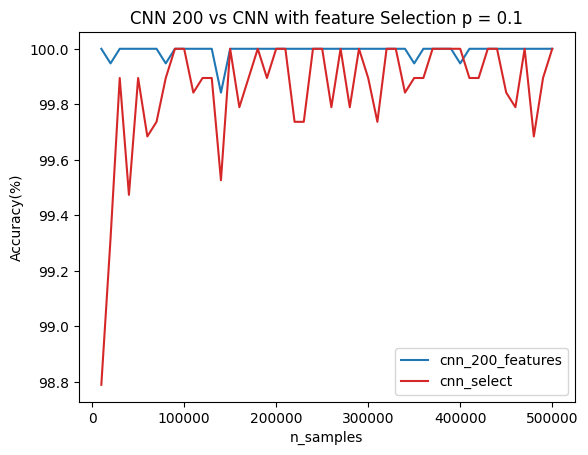

In [22]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_cnn = []
y_cnn_select = []

#Parameters
sz = 40     #Number of nodes
p = 0.1      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model = load_model_cnn('best_diagonal_model_scaled')
cnn_selection_model = load_model_cnn('best_diagonal_model_cnn_maxscaled_0.25p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((2,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series)
        
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)
        
        #add accuracies
        data_cnn = data.T.reshape((data.T.shape[0], data.T.shape[1], 1))
        
        dpred = cnn_model.predict(data_cnn[idd,:,:],verbose=0)
        cpred = cnn_model.predict(data_cnn[idc,:,:],verbose=0)
        
        trued = np.sum(dpred<1.5)
        truec = np.sum(cpred>1.5)
        true = trued + truec
        acc_cnn = true/(len(dpred)+len(cpred))*100
        
        #cnn with feature selection
        data_cnn_select = data[features_diagonal_maxscale_cnn[0]:features_diagonal_maxscale_cnn[1],:]
        
        data_cnn_select = data_cnn_select.T.reshape((data_cnn_select.T.shape[0], data_cnn_select.T.shape[1], 1))
        
        dpred = cnn_selection_model.predict(data_cnn_select[idd,:,:],verbose=0)
        cpred = cnn_selection_model.predict(data_cnn_select[idc,:,:],verbose=0)
        
        threshold = (max(dpred) + min(cpred)) / 2 
        
        trued = np.sum(dpred<threshold)
        truec = np.sum(cpred>threshold)
        true = trued + truec
        acc_cnn_select = true/(len(dpred)+len(cpred))*100
        
        performances[0][l] = acc_cnn
        performances[1][l] = acc_cnn_select
    
    y_cnn = np.append(y_cnn,np.mean(performances[0]))
    y_cnn_select = np.append(y_cnn_select,np.mean(performances[1]))
        
plt.figure()
plt.plot(x,y_cnn,color="tab:blue",linestyle='-')
plt.plot(x,y_cnn_select,color="tab:red",linestyle='-')
plt.legend(['cnn_200_features','cnn_select'],loc=4)
plt.title("CNN 200 vs CNN with feature Selection p = 0.1")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

### SS 

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

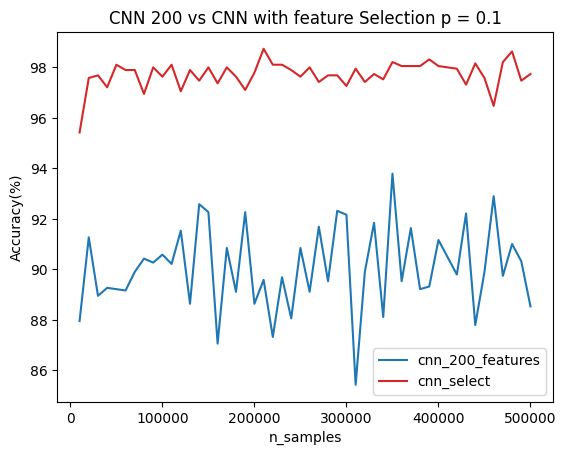

In [23]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_cnn = []
y_cnn_select = []

#Parameters
sz = 40     #Number of nodes
p = 0.1      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model = load_model_cnn('best_diagonal_model_ss')
cnn_selection_model = load_model_cnn('best_diagonal_model_cnn_ss_scaled_0.25p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((2,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series)
        
        #Scale with SS
        sc = StandardScaler()

        data = sc.fit_transform(data.T)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)
        
        #add accuracies
        data_cnn = data.reshape((data.shape[0], data.shape[1], 1))
        
        dpred = cnn_model.predict(data_cnn[idd,:,:],verbose=0)
        cpred = cnn_model.predict(data_cnn[idc,:,:],verbose=0)
        
        trued = np.sum(dpred<1.5)
        truec = np.sum(cpred>1.5)
        true = trued + truec
        acc_cnn = true/(len(dpred)+len(cpred))*100
        
        #cnn with feature selection
        data_cnn_select = data[:,features_diagonal_ss_scale_cnn[0]:features_diagonal_ss_scale_cnn[1]]
        
        data_cnn_select = data_cnn_select.reshape((data_cnn_select.shape[0], data_cnn_select.shape[1], 1))
        
        dpred = cnn_selection_model.predict(data_cnn_select[idd,:,:],verbose=0)
        cpred = cnn_selection_model.predict(data_cnn_select[idc,:,:],verbose=0)
        
        threshold = (max(dpred) + min(cpred)) / 2 
        
        trued = np.sum(dpred<threshold)
        truec = np.sum(cpred>threshold)
        true = trued + truec
        acc_cnn_select = true/(len(dpred)+len(cpred))*100
        
        performances[0][l] = acc_cnn
        performances[1][l] = acc_cnn_select
    
    y_cnn = np.append(y_cnn,np.mean(performances[0]))
    y_cnn_select = np.append(y_cnn_select,np.mean(performances[1]))
        
plt.figure()
plt.plot(x,y_cnn,color="tab:blue",linestyle='-')
plt.plot(x,y_cnn_select,color="tab:red",linestyle='-')
plt.legend(['cnn_200_features','cnn_select'],loc=4)
plt.title("CNN 200 vs CNN with feature Selection p = 0.1")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

## Pro 0.3 

### No scale 

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

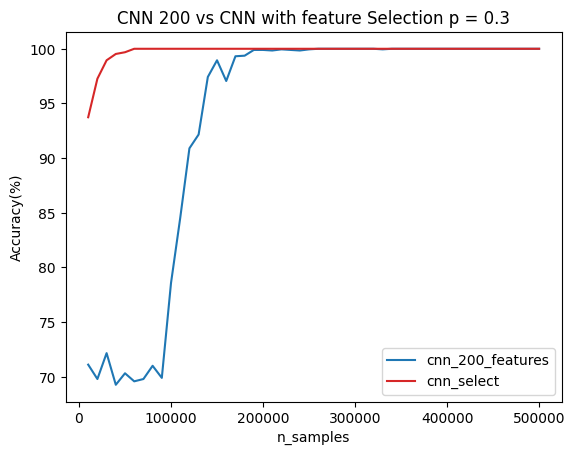

In [24]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_cnn = []
y_cnn_select = []

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model = load_model_cnn('best_diagonal_model')
cnn_selection_model = load_model_cnn('best_diagonal_model_cnn_0.25p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((2,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)
        
        #add accuracies
        data_cnn = data.T.reshape((data.T.shape[0], data.T.shape[1], 1))
        
        dpred = cnn_model.predict(data_cnn[idd,:,:],verbose=0)
        cpred = cnn_model.predict(data_cnn[idc,:,:],verbose=0)
        
        trued = np.sum(dpred<1.5)
        truec = np.sum(cpred>1.5)
        true = trued + truec
        acc_cnn = true/(len(dpred)+len(cpred))*100
        
        #cnn with feature selection
        data_cnn_select = data[features_diagonal_noscale_cnn[0]:features_diagonal_noscale_cnn[1],:]
        
        data_cnn_select = data_cnn_select.T.reshape((data_cnn_select.T.shape[0], data_cnn_select.T.shape[1], 1))
        
        dpred = cnn_selection_model.predict(data_cnn_select[idd,:,:],verbose=0)
        cpred = cnn_selection_model.predict(data_cnn_select[idc,:,:],verbose=0)
        
        threshold = (max(dpred) + min(cpred)) / 2 
        
        trued = np.sum(dpred<threshold)
        truec = np.sum(cpred>threshold)
        true = trued + truec
        acc_cnn_select = true/(len(dpred)+len(cpred))*100
        
        performances[0][l] = acc_cnn
        performances[1][l] = acc_cnn_select
    
    y_cnn = np.append(y_cnn,np.mean(performances[0]))
    y_cnn_select = np.append(y_cnn_select,np.mean(performances[1]))
        
plt.figure()
plt.plot(x,y_cnn,color="tab:blue",linestyle='-')
plt.plot(x,y_cnn_select,color="tab:red",linestyle='-')
plt.legend(['cnn_200_features','cnn_select'],loc=4)
plt.title("CNN 200 vs CNN with feature Selection p = 0.3")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

### Max scale 

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

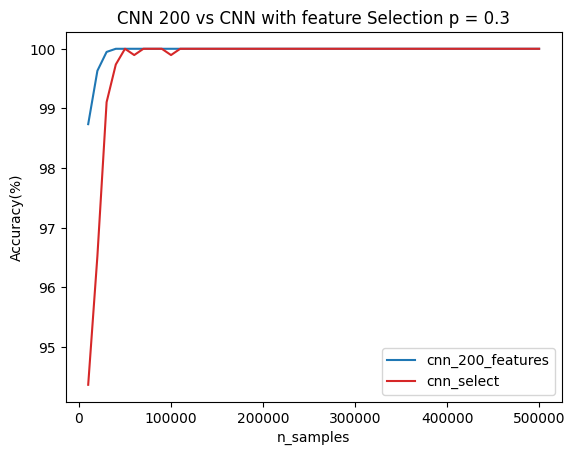

In [25]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_cnn = []
y_cnn_select = []

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model = load_model_cnn('best_diagonal_model_scaled')
cnn_selection_model = load_model_cnn('best_diagonal_model_cnn_maxscaled_0.25p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((2,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series)
        
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)
        
        #add accuracies
        data_cnn = data.T.reshape((data.T.shape[0], data.T.shape[1], 1))
        
        dpred = cnn_model.predict(data_cnn[idd,:,:],verbose=0)
        cpred = cnn_model.predict(data_cnn[idc,:,:],verbose=0)
        
        trued = np.sum(dpred<1.5)
        truec = np.sum(cpred>1.5)
        true = trued + truec
        acc_cnn = true/(len(dpred)+len(cpred))*100
        
        #cnn with feature selection
        data_cnn_select = data[features_diagonal_maxscale_cnn[0]:features_diagonal_maxscale_cnn[1],:]
        
        data_cnn_select = data_cnn_select.T.reshape((data_cnn_select.T.shape[0], data_cnn_select.T.shape[1], 1))
        
        dpred = cnn_selection_model.predict(data_cnn_select[idd,:,:],verbose=0)
        cpred = cnn_selection_model.predict(data_cnn_select[idc,:,:],verbose=0)
        
        threshold = (max(dpred) + min(cpred)) / 2 
        
        trued = np.sum(dpred<threshold)
        truec = np.sum(cpred>threshold)
        true = trued + truec
        acc_cnn_select = true/(len(dpred)+len(cpred))*100
        
        performances[0][l] = acc_cnn
        performances[1][l] = acc_cnn_select
    
    y_cnn = np.append(y_cnn,np.mean(performances[0]))
    y_cnn_select = np.append(y_cnn_select,np.mean(performances[1]))
        
plt.figure()
plt.plot(x,y_cnn,color="tab:blue",linestyle='-')
plt.plot(x,y_cnn_select,color="tab:red",linestyle='-')
plt.legend(['cnn_200_features','cnn_select'],loc=4)
plt.title("CNN 200 vs CNN with feature Selection p = 0.3")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

### SS 

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

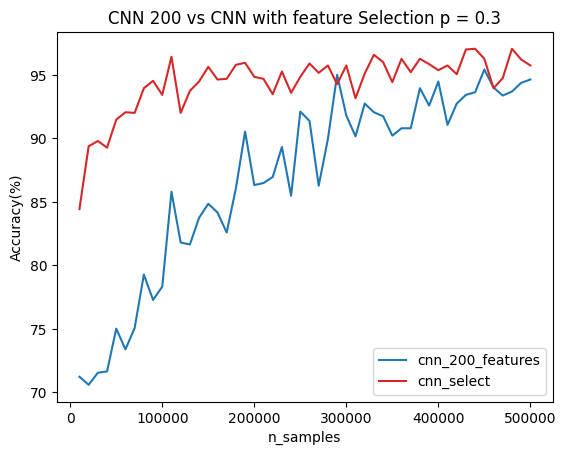

In [26]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_cnn = []
y_cnn_select = []

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model = load_model_cnn('best_diagonal_model_ss')
cnn_selection_model = load_model_cnn('best_diagonal_model_cnn_ss_scaled_0.25p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((2,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series)
        
        #Scale with SS
        sc = StandardScaler()

        data = sc.fit_transform(data.T)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)
        
        #add accuracies
        data_cnn = data.reshape((data.shape[0], data.shape[1], 1))
        
        dpred = cnn_model.predict(data_cnn[idd,:,:],verbose=0)
        cpred = cnn_model.predict(data_cnn[idc,:,:],verbose=0)
        
        trued = np.sum(dpred<1.5)
        truec = np.sum(cpred>1.5)
        true = trued + truec
        acc_cnn = true/(len(dpred)+len(cpred))*100
        
        #cnn with feature selection
        data_cnn_select = data[:,features_diagonal_ss_scale_cnn[0]:features_diagonal_ss_scale_cnn[1]]
        
        data_cnn_select = data_cnn_select.reshape((data_cnn_select.shape[0], data_cnn_select.shape[1], 1))
        
        dpred = cnn_selection_model.predict(data_cnn_select[idd,:,:],verbose=0)
        cpred = cnn_selection_model.predict(data_cnn_select[idc,:,:],verbose=0)
        
        threshold = (max(dpred) + min(cpred)) / 2 
        
        trued = np.sum(dpred<threshold)
        truec = np.sum(cpred>threshold)
        true = trued + truec
        acc_cnn_select = true/(len(dpred)+len(cpred))*100
        
        performances[0][l] = acc_cnn
        performances[1][l] = acc_cnn_select
    
    y_cnn = np.append(y_cnn,np.mean(performances[0]))
    y_cnn_select = np.append(y_cnn_select,np.mean(performances[1]))
        
plt.figure()
plt.plot(x,y_cnn,color="tab:blue",linestyle='-')
plt.plot(x,y_cnn_select,color="tab:red",linestyle='-')
plt.legend(['cnn_200_features','cnn_select'],loc=4)
plt.title("CNN 200 vs CNN with feature Selection p = 0.3")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

# All together

In [8]:
#Parameters
t_samples = 100000
step = 5000
n_runs = 10

sz = 40     #Number of nodes
p = 0.50  #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
undirected = True

#Define the range of noise variance
alpha = 0.1
beta = 5
x0 = 0            #Initial condition

x = np.arange(step,t_samples,step)

s1 = "C:/Users/seabr/Desktop/investigação/Code/models/Linear/model_AllData_cnn_"
#s1 = "C:/Users/seabr/Desktop/investigação/Code/models/Linear/diagonal_model_cnn_"
s2 = "features_0.50p_sergioArchitecture"

models = ["200"]
models_performance = np.zeros((len(models),len(x)))

count = 0
for i in models:
    models[count] = s1 + i + s2
    count +=1


count_2 = 0

for samples in x:
    print("Samples: " + str(samples))
    performance_list = np.zeros((len(models),n_runs))

    for i in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        noise = generate_noise(sz,samples,alpha,beta)

        #get time series with diagonal noise
        time_series = gen_linear_time_series(A,samples,x0,noise)

        data,target = create_dataset(sz,samples,undirected,A,time_series,200)

        data = data/np.max(data)
        data = data.T.reshape((data.T.shape[0], data.T.shape[1], 1))

        #datas = [data_cnn_50,data_cnn_100,data_cnn_150,data_cnn_200,data_cnn_250,data_cnn_300,data_cnn_350,data_cnn_400,data_cnn_450,data_cnn_500]
        datas = [data]

        y = target>0
        y = y.astype(int)

        #get predicts
        count = 0
        for m in models:
            model = load_model_cnn(m)

            pred = model.predict(datas[count],verbose = 0)

            y_pred = pred.T > np.mean(pred)
            y_pred = y_pred.astype(int)
            trues = np.sum(y == y_pred)
            acc = (trues/len(y_pred[0]))*100

            performance_list[count][i] = acc

            count += 1

    for j in range(len(models)):
        models_performance[j][count_2] = np.mean(performance_list[j])
    
    count_2 +=1

models_performance_beta5 = models_performance

%store models_performance_beta5

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Stored 'models_performance_beta5' (ndarray)


In [9]:
x = np.arange(step,t_samples,step)
t_samples = 100000
step = 5000

plt.figure()
plt.plot(x,models_diagonal_performance_beta5[0])
plt.plot(x,models_performance_beta5[0])
plt.title('Diagonal dataset test')
plt.legend(["Only diagonal train model","All together model"],loc=4)
plt.xlabel('Samples')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

# Influence of the number of features

## 10%

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_10_50 = []
y_10_10_100 = []
y_10_10_150 = []
y_10_10_200 = []
y_10_10_250 = []
y_10_10_300 = []
y_10_10_350 = []
y_10_10_400 = []
y_10_10_450 = []
y_10_10_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_10_50 = []
y_20_10_100 = []
y_20_10_150 = []
y_20_10_200 = []
y_20_10_250 = []
y_20_10_300 = []
y_20_10_350 = []
y_20_10_400 = []
y_20_10_450 = []
y_20_10_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_10_50 = []
y_30_10_100 = []
y_30_10_150 = []
y_30_10_200 = []
y_30_10_250 = []
y_30_10_300 = []
y_30_10_350 = []
y_30_10_400 = []
y_30_10_450 = []
y_30_10_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_10_50 = []
y_40_10_100 = []
y_40_10_150 = []
y_40_10_200 = []
y_40_10_250 = []
y_40_10_300 = []
y_40_10_350 = []
y_40_10_400 = []
y_40_10_450 = []
y_40_10_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_10_50 = []
y_50_10_100 = []
y_50_10_150 = []
y_50_10_200 = []
y_50_10_250 = []
y_50_10_300 = []
y_50_10_350 = []
y_50_10_400 = []
y_50_10_450 = []
y_50_10_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_10_50 = []
y_60_10_100 = []
y_60_10_150 = []
y_60_10_200 = []
y_60_10_250 = []
y_60_10_300 = []
y_60_10_350 = []
y_60_10_400 = []
y_60_10_450 = []
y_60_10_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_10_50 = []
y_70_10_100 = []
y_70_10_150 = []
y_70_10_200 = []
y_70_10_250 = []
y_70_10_300 = []
y_70_10_350 = []
y_70_10_400 = []
y_70_10_450 = []
y_70_10_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_10_50 = []
y_80_10_100 = []
y_80_10_150 = []
y_80_10_200 = []
y_80_10_250 = []
y_80_10_300 = []
y_80_10_350 = []
y_80_10_400 = []
y_80_10_450 = []
y_80_10_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_10_50 = []
y_90_10_100 = []
y_90_10_150 = []
y_90_10_200 = []
y_90_10_250 = []
y_90_10_300 = []
y_90_10_350 = []
y_90_10_400 = []
y_90_10_450 = []
y_90_10_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.1      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_10_50 = np.append(y_10_10_50,np.mean(performances[0]))
    y_10_10_100 = np.append(y_10_10_100,np.mean(performances[1]))
    y_10_10_150 = np.append(y_10_10_150,np.mean(performances[2]))
    y_10_10_200 = np.append(y_10_10_200,np.mean(performances[3]))
    y_10_10_250 = np.append(y_10_10_250,np.mean(performances[4]))
    y_10_10_300 = np.append(y_10_10_300,np.mean(performances[5]))
    y_10_10_350 = np.append(y_10_10_350,np.mean(performances[6]))
    y_10_10_400 = np.append(y_10_10_400,np.mean(performances[7]))
    y_10_10_450 = np.append(y_10_10_450,np.mean(performances[8]))
    y_10_10_500 = np.append(y_10_10_500,np.mean(performances[9]))


    y_20_10_50 = np.append(y_20_10_50,np.mean(performances[10]))
    y_20_10_100 = np.append(y_20_10_100,np.mean(performances[11]))
    y_20_10_150 = np.append(y_20_10_150,np.mean(performances[12]))
    y_20_10_200 = np.append(y_20_10_200,np.mean(performances[13]))
    y_20_10_250 = np.append(y_20_10_250,np.mean(performances[14]))
    y_20_10_300 = np.append(y_20_10_300,np.mean(performances[15]))
    y_20_10_350 = np.append(y_20_10_350,np.mean(performances[16]))
    y_20_10_400 = np.append(y_20_10_400,np.mean(performances[17]))
    y_20_10_450 = np.append(y_20_10_450,np.mean(performances[18]))
    y_20_10_500 = np.append(y_20_10_500,np.mean(performances[19]))

    y_30_10_50 = np.append(y_30_10_50,np.mean(performances[20]))
    y_30_10_100 = np.append(y_30_10_100,np.mean(performances[21]))
    y_30_10_150 = np.append(y_30_10_150,np.mean(performances[22]))
    y_30_10_200 = np.append(y_30_10_200,np.mean(performances[23]))
    y_30_10_250 = np.append(y_30_10_250,np.mean(performances[24]))
    y_30_10_300 = np.append(y_30_10_300,np.mean(performances[25]))
    y_30_10_350 = np.append(y_30_10_350,np.mean(performances[26]))
    y_30_10_400 = np.append(y_30_10_400,np.mean(performances[27]))
    y_30_10_450 = np.append(y_30_10_450,np.mean(performances[28]))
    y_30_10_500 = np.append(y_30_10_500,np.mean(performances[29]))

    y_40_10_50 = np.append(y_40_10_50,np.mean(performances[30]))
    y_40_10_100 = np.append(y_40_10_100,np.mean(performances[31]))
    y_40_10_150 = np.append(y_40_10_150,np.mean(performances[32]))
    y_40_10_200 = np.append(y_40_10_200,np.mean(performances[33]))
    y_40_10_250 = np.append(y_40_10_250,np.mean(performances[34]))
    y_40_10_300 = np.append(y_40_10_300,np.mean(performances[35]))
    y_40_10_350 = np.append(y_40_10_350,np.mean(performances[36]))
    y_40_10_400 = np.append(y_40_10_400,np.mean(performances[37]))
    y_40_10_450 = np.append(y_40_10_450,np.mean(performances[38]))
    y_40_10_500 = np.append(y_40_10_500,np.mean(performances[39]))

    y_50_10_50 = np.append(y_50_10_50,np.mean(performances[40]))
    y_50_10_100 = np.append(y_50_10_100,np.mean(performances[41]))
    y_50_10_150 = np.append(y_50_10_150,np.mean(performances[42]))
    y_50_10_200 = np.append(y_50_10_200,np.mean(performances[43]))
    y_50_10_250 = np.append(y_50_10_250,np.mean(performances[44]))
    y_50_10_300 = np.append(y_50_10_300,np.mean(performances[45]))
    y_50_10_350 = np.append(y_50_10_350,np.mean(performances[46]))
    y_50_10_400 = np.append(y_50_10_400,np.mean(performances[47]))
    y_50_10_450 = np.append(y_50_10_450,np.mean(performances[48]))
    y_50_10_500 = np.append(y_50_10_500,np.mean(performances[49]))

    y_60_10_50 = np.append(y_60_10_50,np.mean(performances[50]))
    y_60_10_100 = np.append(y_60_10_100,np.mean(performances[51]))
    y_60_10_150 = np.append(y_60_10_150,np.mean(performances[52]))
    y_60_10_200 = np.append(y_60_10_200,np.mean(performances[53]))
    y_60_10_250 = np.append(y_60_10_250,np.mean(performances[54]))
    y_60_10_300 = np.append(y_60_10_300,np.mean(performances[55]))
    y_60_10_350 = np.append(y_60_10_350,np.mean(performances[56]))
    y_60_10_400 = np.append(y_60_10_400,np.mean(performances[57]))
    y_60_10_450 = np.append(y_60_10_450,np.mean(performances[58]))
    y_60_10_500 = np.append(y_60_10_500,np.mean(performances[59]))

    y_70_10_50 = np.append(y_70_10_50,np.mean(performances[60]))
    y_70_10_100 = np.append(y_70_10_100,np.mean(performances[61]))
    y_70_10_150 = np.append(y_70_10_150,np.mean(performances[62]))
    y_70_10_200 = np.append(y_70_10_200,np.mean(performances[63]))
    y_70_10_250 = np.append(y_70_10_250,np.mean(performances[64]))
    y_70_10_300 = np.append(y_70_10_300,np.mean(performances[65]))
    y_70_10_350 = np.append(y_70_10_350,np.mean(performances[66]))
    y_70_10_400 = np.append(y_70_10_400,np.mean(performances[67]))
    y_70_10_450 = np.append(y_70_10_450,np.mean(performances[68]))
    y_70_10_500 = np.append(y_70_10_500,np.mean(performances[69]))

    y_80_10_50 = np.append(y_80_10_50,np.mean(performances[70]))
    y_80_10_100 = np.append(y_80_10_100,np.mean(performances[71]))
    y_80_10_150 = np.append(y_80_10_150,np.mean(performances[72]))
    y_80_10_200 = np.append(y_80_10_200,np.mean(performances[73]))
    y_80_10_250 = np.append(y_80_10_250,np.mean(performances[74]))
    y_80_10_300 = np.append(y_80_10_300,np.mean(performances[75]))
    y_80_10_350 = np.append(y_80_10_350,np.mean(performances[76]))
    y_80_10_400 = np.append(y_80_10_400,np.mean(performances[77]))
    y_80_10_450 = np.append(y_80_10_450,np.mean(performances[78]))
    y_80_10_500 = np.append(y_80_10_500,np.mean(performances[79]))

    y_90_10_50 = np.append(y_90_10_50,np.mean(performances[80]))
    y_90_10_100 = np.append(y_90_10_100,np.mean(performances[81]))
    y_90_10_150 = np.append(y_90_10_150,np.mean(performances[82]))
    y_90_10_200 = np.append(y_90_10_200,np.mean(performances[83]))
    y_90_10_250 = np.append(y_90_10_250,np.mean(performances[84]))
    y_90_10_300 = np.append(y_90_10_300,np.mean(performances[85]))
    y_90_10_350 = np.append(y_90_10_350,np.mean(performances[86]))
    y_90_10_400 = np.append(y_90_10_400,np.mean(performances[87]))
    y_90_10_450 = np.append(y_90_10_450,np.mean(performances[88]))
    y_90_10_500 = np.append(y_90_10_500,np.mean(performances[89]))

%store y_10_10_50
%store y_10_10_100
%store y_10_10_150
%store y_10_10_200
%store y_10_10_250
%store y_10_10_300
%store y_10_10_350
%store y_10_10_400
%store y_10_10_450
%store y_10_10_500

%store y_20_10_50
%store y_20_10_100
%store y_20_10_150
%store y_20_10_200
%store y_20_10_250
%store y_20_10_300
%store y_20_10_350
%store y_20_10_400
%store y_20_10_450
%store y_20_10_500

%store y_30_10_50
%store y_30_10_100
%store y_30_10_150
%store y_30_10_200
%store y_30_10_250
%store y_30_10_300
%store y_30_10_350
%store y_30_10_400
%store y_30_10_450
%store y_30_10_500

%store y_40_10_50
%store y_40_10_100
%store y_40_10_150
%store y_40_10_200
%store y_40_10_250
%store y_40_10_300
%store y_40_10_350
%store y_40_10_400
%store y_40_10_450
%store y_40_10_500

%store y_50_10_50
%store y_50_10_100
%store y_50_10_150
%store y_50_10_200
%store y_50_10_250
%store y_50_10_300
%store y_50_10_350
%store y_50_10_400
%store y_50_10_450
%store y_50_10_500

%store y_60_10_50
%store y_60_10_100
%store y_60_10_150
%store y_60_10_200
%store y_60_10_250
%store y_60_10_300
%store y_60_10_350
%store y_60_10_400
%store y_60_10_450
%store y_60_10_500

%store y_70_10_50
%store y_70_10_100
%store y_70_10_150
%store y_70_10_200
%store y_70_10_250
%store y_70_10_300
%store y_70_10_350
%store y_70_10_400
%store y_70_10_450
%store y_70_10_500

%store y_80_10_50
%store y_80_10_100
%store y_80_10_150
%store y_80_10_200
%store y_80_10_250
%store y_80_10_300
%store y_80_10_350
%store y_80_10_400
%store y_80_10_450
%store y_80_10_500

%store y_90_10_50
%store y_90_10_100
%store y_90_10_150
%store y_90_10_200
%store y_90_10_250
%store y_90_10_300
%store y_90_10_350
%store y_90_10_400
%store y_90_10_450
%store y_90_10_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_10_50' (ndarray)
Stored 'y_10_10_100' (ndarray)
Stored 'y_10_10_150' (ndarray)
Stored 'y_10_10_200' (ndarray)
Stored 'y_10_10_250' (ndarray)
Stored 'y_10_10_300' (ndarray)
Stored 'y_10_10_350' (ndarray)
Stored 'y_10_10_400' (ndarray)
Stored 'y_10_10_450' (ndarray)
Stored 'y_10_10_500' (ndarray)
Stored 'y_20_10_50' (ndarray)
Stored 'y_20_10_100' (ndarray)
Stored 'y_20_10_150' (ndarray)
Stored 'y_20_10_200' (ndarray)
Stored 'y_20_10_250' (ndarray)
Stored 'y_20_10_300' (ndarray)
Stored 'y_20_10_350' (ndarray)
Stored 'y_20_10_400' (ndarray)
Stored 'y_20_10_450' (ndarray)
Stored 'y_20_10_500' (ndarray)
Stored 'y_30_10_50' (ndarray)
Stored 'y_30_10_100' (ndarray)
Stored 'y_30_10_150' 

## 20%

In [9]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model

y_10_20_50 = []
y_10_20_100 = []
y_10_20_150 = []
y_10_20_200 = []
y_10_20_250 = []
y_10_20_300 = []
y_10_20_350 = []
y_10_20_400 = []
y_10_20_450 = []
y_10_20_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_20_50 = []
y_20_20_100 = []
y_20_20_150 = []
y_20_20_200 = []
y_20_20_250 = []
y_20_20_300 = []
y_20_20_350 = []
y_20_20_400 = []
y_20_20_450 = []
y_20_20_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_20_50 = []
y_30_20_100 = []
y_30_20_150 = []
y_30_20_200 = []
y_30_20_250 = []
y_30_20_300 = []
y_30_20_350 = []
y_30_20_400 = []
y_30_20_450 = []
y_30_20_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_20_50 = []
y_40_20_100 = []
y_40_20_150 = []
y_40_20_200 = []
y_40_20_250 = []
y_40_20_300 = []
y_40_20_350 = []
y_40_20_400 = []
y_40_20_450 = []
y_40_20_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_20_50 = []
y_50_20_100 = []
y_50_20_150 = []
y_50_20_200 = []
y_50_20_250 = []
y_50_20_300 = []
y_50_20_350 = []
y_50_20_400 = []
y_50_20_450 = []
y_50_20_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_20_50 = []
y_60_20_100 = []
y_60_20_150 = []
y_60_20_200 = []
y_60_20_250 = []
y_60_20_300 = []
y_60_20_350 = []
y_60_20_400 = []
y_60_20_450 = []
y_60_20_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_20_50 = []
y_70_20_100 = []
y_70_20_150 = []
y_70_20_200 = []
y_70_20_250 = []
y_70_20_300 = []
y_70_20_350 = []
y_70_20_400 = []
y_70_20_450 = []
y_70_20_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_20_50 = []
y_80_20_100 = []
y_80_20_150 = []
y_80_20_200 = []
y_80_20_250 = []
y_80_20_300 = []
y_80_20_350 = []
y_80_20_400 = []
y_80_20_450 = []
y_80_20_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_20_50 = []
y_90_20_100 = []
y_90_20_150 = []
y_90_20_200 = []
y_90_20_250 = []
y_90_20_300 = []
y_90_20_350 = []
y_90_20_400 = []
y_90_20_450 = []
y_90_20_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.2      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_20_50 = np.append(y_10_20_50,np.mean(performances[0]))
    y_10_20_100 = np.append(y_10_20_100,np.mean(performances[1]))
    y_10_20_150 = np.append(y_10_20_150,np.mean(performances[2]))
    y_10_20_200 = np.append(y_10_20_200,np.mean(performances[3]))
    y_10_20_250 = np.append(y_10_20_250,np.mean(performances[4]))
    y_10_20_300 = np.append(y_10_20_300,np.mean(performances[5]))
    y_10_20_350 = np.append(y_10_20_350,np.mean(performances[6]))
    y_10_20_400 = np.append(y_10_20_400,np.mean(performances[7]))
    y_10_20_450 = np.append(y_10_20_450,np.mean(performances[8]))
    y_10_20_500 = np.append(y_10_20_500,np.mean(performances[9]))


    y_20_20_50 = np.append(y_20_20_50,np.mean(performances[10]))
    y_20_20_100 = np.append(y_20_20_100,np.mean(performances[11]))
    y_20_20_150 = np.append(y_20_20_150,np.mean(performances[12]))
    y_20_20_200 = np.append(y_20_20_200,np.mean(performances[13]))
    y_20_20_250 = np.append(y_20_20_250,np.mean(performances[14]))
    y_20_20_300 = np.append(y_20_20_300,np.mean(performances[15]))
    y_20_20_350 = np.append(y_20_20_350,np.mean(performances[16]))
    y_20_20_400 = np.append(y_20_20_400,np.mean(performances[17]))
    y_20_20_450 = np.append(y_20_20_450,np.mean(performances[18]))
    y_20_20_500 = np.append(y_20_20_500,np.mean(performances[19]))

    y_30_20_50 = np.append(y_30_20_50,np.mean(performances[20]))
    y_30_20_100 = np.append(y_30_20_100,np.mean(performances[21]))
    y_30_20_150 = np.append(y_30_20_150,np.mean(performances[22]))
    y_30_20_200 = np.append(y_30_20_200,np.mean(performances[23]))
    y_30_20_250 = np.append(y_30_20_250,np.mean(performances[24]))
    y_30_20_300 = np.append(y_30_20_300,np.mean(performances[25]))
    y_30_20_350 = np.append(y_30_20_350,np.mean(performances[26]))
    y_30_20_400 = np.append(y_30_20_400,np.mean(performances[27]))
    y_30_20_450 = np.append(y_30_20_450,np.mean(performances[28]))
    y_30_20_500 = np.append(y_30_20_500,np.mean(performances[29]))

    y_40_20_50 = np.append(y_40_20_50,np.mean(performances[30]))
    y_40_20_100 = np.append(y_40_20_100,np.mean(performances[31]))
    y_40_20_150 = np.append(y_40_20_150,np.mean(performances[32]))
    y_40_20_200 = np.append(y_40_20_200,np.mean(performances[33]))
    y_40_20_250 = np.append(y_40_20_250,np.mean(performances[34]))
    y_40_20_300 = np.append(y_40_20_300,np.mean(performances[35]))
    y_40_20_350 = np.append(y_40_20_350,np.mean(performances[36]))
    y_40_20_400 = np.append(y_40_20_400,np.mean(performances[37]))
    y_40_20_450 = np.append(y_40_20_450,np.mean(performances[38]))
    y_40_20_500 = np.append(y_40_20_500,np.mean(performances[39]))

    y_50_20_50 = np.append(y_50_20_50,np.mean(performances[40]))
    y_50_20_100 = np.append(y_50_20_100,np.mean(performances[41]))
    y_50_20_150 = np.append(y_50_20_150,np.mean(performances[42]))
    y_50_20_200 = np.append(y_50_20_200,np.mean(performances[43]))
    y_50_20_250 = np.append(y_50_20_250,np.mean(performances[44]))
    y_50_20_300 = np.append(y_50_20_300,np.mean(performances[45]))
    y_50_20_350 = np.append(y_50_20_350,np.mean(performances[46]))
    y_50_20_400 = np.append(y_50_20_400,np.mean(performances[47]))
    y_50_20_450 = np.append(y_50_20_450,np.mean(performances[48]))
    y_50_20_500 = np.append(y_50_20_500,np.mean(performances[49]))

    y_60_20_50 = np.append(y_60_20_50,np.mean(performances[50]))
    y_60_20_100 = np.append(y_60_20_100,np.mean(performances[51]))
    y_60_20_150 = np.append(y_60_20_150,np.mean(performances[52]))
    y_60_20_200 = np.append(y_60_20_200,np.mean(performances[53]))
    y_60_20_250 = np.append(y_60_20_250,np.mean(performances[54]))
    y_60_20_300 = np.append(y_60_20_300,np.mean(performances[55]))
    y_60_20_350 = np.append(y_60_20_350,np.mean(performances[56]))
    y_60_20_400 = np.append(y_60_20_400,np.mean(performances[57]))
    y_60_20_450 = np.append(y_60_20_450,np.mean(performances[58]))
    y_60_20_500 = np.append(y_60_20_500,np.mean(performances[59]))

    y_70_20_50 = np.append(y_70_20_50,np.mean(performances[60]))
    y_70_20_100 = np.append(y_70_20_100,np.mean(performances[61]))
    y_70_20_150 = np.append(y_70_20_150,np.mean(performances[62]))
    y_70_20_200 = np.append(y_70_20_200,np.mean(performances[63]))
    y_70_20_250 = np.append(y_70_20_250,np.mean(performances[64]))
    y_70_20_300 = np.append(y_70_20_300,np.mean(performances[65]))
    y_70_20_350 = np.append(y_70_20_350,np.mean(performances[66]))
    y_70_20_400 = np.append(y_70_20_400,np.mean(performances[67]))
    y_70_20_450 = np.append(y_70_20_450,np.mean(performances[68]))
    y_70_20_500 = np.append(y_70_20_500,np.mean(performances[69]))

    y_80_20_50 = np.append(y_80_20_50,np.mean(performances[70]))
    y_80_20_100 = np.append(y_80_20_100,np.mean(performances[71]))
    y_80_20_150 = np.append(y_80_20_150,np.mean(performances[72]))
    y_80_20_200 = np.append(y_80_20_200,np.mean(performances[73]))
    y_80_20_250 = np.append(y_80_20_250,np.mean(performances[74]))
    y_80_20_300 = np.append(y_80_20_300,np.mean(performances[75]))
    y_80_20_350 = np.append(y_80_20_350,np.mean(performances[76]))
    y_80_20_400 = np.append(y_80_20_400,np.mean(performances[77]))
    y_80_20_450 = np.append(y_80_20_450,np.mean(performances[78]))
    y_80_20_500 = np.append(y_80_20_500,np.mean(performances[79]))

    y_90_20_50 = np.append(y_90_20_50,np.mean(performances[80]))
    y_90_20_100 = np.append(y_90_20_100,np.mean(performances[81]))
    y_90_20_150 = np.append(y_90_20_150,np.mean(performances[82]))
    y_90_20_200 = np.append(y_90_20_200,np.mean(performances[83]))
    y_90_20_250 = np.append(y_90_20_250,np.mean(performances[84]))
    y_90_20_300 = np.append(y_90_20_300,np.mean(performances[85]))
    y_90_20_350 = np.append(y_90_20_350,np.mean(performances[86]))
    y_90_20_400 = np.append(y_90_20_400,np.mean(performances[87]))
    y_90_20_450 = np.append(y_90_20_450,np.mean(performances[88]))
    y_90_20_500 = np.append(y_90_20_500,np.mean(performances[89]))

%store y_10_20_50
%store y_10_20_100
%store y_10_20_150
%store y_10_20_200
%store y_10_20_250
%store y_10_20_300
%store y_10_20_350
%store y_10_20_400
%store y_10_20_450
%store y_10_20_500

%store y_20_20_50
%store y_20_20_100
%store y_20_20_150
%store y_20_20_200
%store y_20_20_250
%store y_20_20_300
%store y_20_20_350
%store y_20_20_400
%store y_20_20_450
%store y_20_20_500

%store y_30_20_50
%store y_30_20_100
%store y_30_20_150
%store y_30_20_200
%store y_30_20_250
%store y_30_20_300
%store y_30_20_350
%store y_30_20_400
%store y_30_20_450
%store y_30_20_500

%store y_40_20_50
%store y_40_20_100
%store y_40_20_150
%store y_40_20_200
%store y_40_20_250
%store y_40_20_300
%store y_40_20_350
%store y_40_20_400
%store y_40_20_450
%store y_40_20_500

%store y_50_20_50
%store y_50_20_100
%store y_50_20_150
%store y_50_20_200
%store y_50_20_250
%store y_50_20_300
%store y_50_20_350
%store y_50_20_400
%store y_50_20_450
%store y_50_20_500

%store y_60_20_50
%store y_60_20_100
%store y_60_20_150
%store y_60_20_200
%store y_60_20_250
%store y_60_20_300
%store y_60_20_350
%store y_60_20_400
%store y_60_20_450
%store y_60_20_500

%store y_70_20_50
%store y_70_20_100
%store y_70_20_150
%store y_70_20_200
%store y_70_20_250
%store y_70_20_300
%store y_70_20_350
%store y_70_20_400
%store y_70_20_450
%store y_70_20_500

%store y_80_20_50
%store y_80_20_100
%store y_80_20_150
%store y_80_20_200
%store y_80_20_250
%store y_80_20_300
%store y_80_20_350
%store y_80_20_400
%store y_80_20_450
%store y_80_20_500

%store y_90_20_50
%store y_90_20_100
%store y_90_20_150
%store y_90_20_200
%store y_90_20_250
%store y_90_20_300
%store y_90_20_350
%store y_90_20_400
%store y_90_20_450
%store y_90_20_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_20_50' (ndarray)
Stored 'y_10_20_100' (ndarray)
Stored 'y_10_20_150' (ndarray)
Stored 'y_10_20_200' (ndarray)
Stored 'y_10_20_250' (ndarray)
Stored 'y_10_20_300' (ndarray)
Stored 'y_10_20_350' (ndarray)
Stored 'y_10_20_400' (ndarray)
Stored 'y_10_20_450' (ndarray)
Stored 'y_10_20_500' (ndarray)
Stored 'y_20_20_50' (ndarray)
Stored 'y_20_20_100' (ndarray)
Stored 'y_20_20_150' (ndarray)
Stored 'y_20_20_200' (ndarray)
Stored 'y_20_20_250' (ndarray)
Stored 'y_20_20_300' (ndarray)
Stored 'y_20_20_350' (ndarray)
Stored 'y_20_20_400' (ndarray)
Stored 'y_20_20_450' (ndarray)
Stored 'y_20_20_500' (ndarray)
Stored 'y_30_20_50' (ndarray)
Stored 'y_30_20_100' (ndarray)
Stored 'y_30_20_150' 

In [10]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_20_50 = []
y_10_20_100 = []
y_10_20_150 = []
y_10_20_200 = []
y_10_20_250 = []
y_10_20_300 = []
y_10_20_350 = []
y_10_20_400 = []
y_10_20_450 = []
y_10_20_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_20_50 = []
y_20_20_100 = []
y_20_20_150 = []
y_20_20_200 = []
y_20_20_250 = []
y_20_20_300 = []
y_20_20_350 = []
y_20_20_400 = []
y_20_20_450 = []
y_20_20_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_20_50 = []
y_30_20_100 = []
y_30_20_150 = []
y_30_20_200 = []
y_30_20_250 = []
y_30_20_300 = []
y_30_20_350 = []
y_30_20_400 = []
y_30_20_450 = []
y_30_20_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_20_50 = []
y_40_20_100 = []
y_40_20_150 = []
y_40_20_200 = []
y_40_20_250 = []
y_40_20_300 = []
y_40_20_350 = []
y_40_20_400 = []
y_40_20_450 = []
y_40_20_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_20_50 = []
y_50_20_100 = []
y_50_20_150 = []
y_50_20_200 = []
y_50_20_250 = []
y_50_20_300 = []
y_50_20_350 = []
y_50_20_400 = []
y_50_20_450 = []
y_50_20_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_20_50 = []
y_60_20_100 = []
y_60_20_150 = []
y_60_20_200 = []
y_60_20_250 = []
y_60_20_300 = []
y_60_20_350 = []
y_60_20_400 = []
y_60_20_450 = []
y_60_20_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_20_50 = []
y_70_20_100 = []
y_70_20_150 = []
y_70_20_200 = []
y_70_20_250 = []
y_70_20_300 = []
y_70_20_350 = []
y_70_20_400 = []
y_70_20_450 = []
y_70_20_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_20_50 = []
y_80_20_100 = []
y_80_20_150 = []
y_80_20_200 = []
y_80_20_250 = []
y_80_20_300 = []
y_80_20_350 = []
y_80_20_400 = []
y_80_20_450 = []
y_80_20_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_20_50 = []
y_90_20_100 = []
y_90_20_150 = []
y_90_20_200 = []
y_90_20_250 = []
y_90_20_300 = []
y_90_20_350 = []
y_90_20_400 = []
y_90_20_450 = []
y_90_20_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.2      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_20_50 = np.append(y_10_20_50,np.mean(performances[0]))
    y_10_20_100 = np.append(y_10_20_100,np.mean(performances[1]))
    y_10_20_150 = np.append(y_10_20_150,np.mean(performances[2]))
    y_10_20_200 = np.append(y_10_20_200,np.mean(performances[3]))
    y_10_20_250 = np.append(y_10_20_250,np.mean(performances[4]))
    y_10_20_300 = np.append(y_10_20_300,np.mean(performances[5]))
    y_10_20_350 = np.append(y_10_20_350,np.mean(performances[6]))
    y_10_20_400 = np.append(y_10_20_400,np.mean(performances[7]))
    y_10_20_450 = np.append(y_10_20_450,np.mean(performances[8]))
    y_10_20_500 = np.append(y_10_20_500,np.mean(performances[9]))


    y_20_20_50 = np.append(y_20_20_50,np.mean(performances[10]))
    y_20_20_100 = np.append(y_20_20_100,np.mean(performances[11]))
    y_20_20_150 = np.append(y_20_20_150,np.mean(performances[12]))
    y_20_20_200 = np.append(y_20_20_200,np.mean(performances[13]))
    y_20_20_250 = np.append(y_20_20_250,np.mean(performances[14]))
    y_20_20_300 = np.append(y_20_20_300,np.mean(performances[15]))
    y_20_20_350 = np.append(y_20_20_350,np.mean(performances[16]))
    y_20_20_400 = np.append(y_20_20_400,np.mean(performances[17]))
    y_20_20_450 = np.append(y_20_20_450,np.mean(performances[18]))
    y_20_20_500 = np.append(y_20_20_500,np.mean(performances[19]))

    y_30_20_50 = np.append(y_30_20_50,np.mean(performances[20]))
    y_30_20_100 = np.append(y_30_20_100,np.mean(performances[21]))
    y_30_20_150 = np.append(y_30_20_150,np.mean(performances[22]))
    y_30_20_200 = np.append(y_30_20_200,np.mean(performances[23]))
    y_30_20_250 = np.append(y_30_20_250,np.mean(performances[24]))
    y_30_20_300 = np.append(y_30_20_300,np.mean(performances[25]))
    y_30_20_350 = np.append(y_30_20_350,np.mean(performances[26]))
    y_30_20_400 = np.append(y_30_20_400,np.mean(performances[27]))
    y_30_20_450 = np.append(y_30_20_450,np.mean(performances[28]))
    y_30_20_500 = np.append(y_30_20_500,np.mean(performances[29]))

    y_40_20_50 = np.append(y_40_20_50,np.mean(performances[30]))
    y_40_20_100 = np.append(y_40_20_100,np.mean(performances[31]))
    y_40_20_150 = np.append(y_40_20_150,np.mean(performances[32]))
    y_40_20_200 = np.append(y_40_20_200,np.mean(performances[33]))
    y_40_20_250 = np.append(y_40_20_250,np.mean(performances[34]))
    y_40_20_300 = np.append(y_40_20_300,np.mean(performances[35]))
    y_40_20_350 = np.append(y_40_20_350,np.mean(performances[36]))
    y_40_20_400 = np.append(y_40_20_400,np.mean(performances[37]))
    y_40_20_450 = np.append(y_40_20_450,np.mean(performances[38]))
    y_40_20_500 = np.append(y_40_20_500,np.mean(performances[39]))

    y_50_20_50 = np.append(y_50_20_50,np.mean(performances[40]))
    y_50_20_100 = np.append(y_50_20_100,np.mean(performances[41]))
    y_50_20_150 = np.append(y_50_20_150,np.mean(performances[42]))
    y_50_20_200 = np.append(y_50_20_200,np.mean(performances[43]))
    y_50_20_250 = np.append(y_50_20_250,np.mean(performances[44]))
    y_50_20_300 = np.append(y_50_20_300,np.mean(performances[45]))
    y_50_20_350 = np.append(y_50_20_350,np.mean(performances[46]))
    y_50_20_400 = np.append(y_50_20_400,np.mean(performances[47]))
    y_50_20_450 = np.append(y_50_20_450,np.mean(performances[48]))
    y_50_20_500 = np.append(y_50_20_500,np.mean(performances[49]))

    y_60_20_50 = np.append(y_60_20_50,np.mean(performances[50]))
    y_60_20_100 = np.append(y_60_20_100,np.mean(performances[51]))
    y_60_20_150 = np.append(y_60_20_150,np.mean(performances[52]))
    y_60_20_200 = np.append(y_60_20_200,np.mean(performances[53]))
    y_60_20_250 = np.append(y_60_20_250,np.mean(performances[54]))
    y_60_20_300 = np.append(y_60_20_300,np.mean(performances[55]))
    y_60_20_350 = np.append(y_60_20_350,np.mean(performances[56]))
    y_60_20_400 = np.append(y_60_20_400,np.mean(performances[57]))
    y_60_20_450 = np.append(y_60_20_450,np.mean(performances[58]))
    y_60_20_500 = np.append(y_60_20_500,np.mean(performances[59]))

    y_70_20_50 = np.append(y_70_10_50,np.mean(performances[60]))
    y_70_20_100 = np.append(y_70_10_100,np.mean(performances[61]))
    y_70_20_150 = np.append(y_70_10_150,np.mean(performances[62]))
    y_70_20_200 = np.append(y_70_10_200,np.mean(performances[63]))
    y_70_20_250 = np.append(y_70_10_250,np.mean(performances[64]))
    y_70_20_300 = np.append(y_70_10_300,np.mean(performances[65]))
    y_70_20_350 = np.append(y_70_10_350,np.mean(performances[66]))
    y_70_20_400 = np.append(y_70_10_400,np.mean(performances[67]))
    y_70_20_450 = np.append(y_70_10_450,np.mean(performances[68]))
    y_70_20_500 = np.append(y_70_10_500,np.mean(performances[69]))

    y_80_20_50 = np.append(y_80_20_50,np.mean(performances[70]))
    y_80_20_100 = np.append(y_80_20_100,np.mean(performances[71]))
    y_80_20_150 = np.append(y_80_20_150,np.mean(performances[72]))
    y_80_20_200 = np.append(y_80_20_200,np.mean(performances[73]))
    y_80_20_250 = np.append(y_80_20_250,np.mean(performances[74]))
    y_80_20_300 = np.append(y_80_20_300,np.mean(performances[75]))
    y_80_20_350 = np.append(y_80_20_350,np.mean(performances[76]))
    y_80_20_400 = np.append(y_80_20_400,np.mean(performances[77]))
    y_80_20_450 = np.append(y_80_20_450,np.mean(performances[78]))
    y_80_20_500 = np.append(y_80_20_500,np.mean(performances[79]))

    y_90_20_50 = np.append(y_90_20_50,np.mean(performances[80]))
    y_90_20_100 = np.append(y_90_20_100,np.mean(performances[81]))
    y_90_20_150 = np.append(y_90_20_150,np.mean(performances[82]))
    y_90_20_200 = np.append(y_90_20_200,np.mean(performances[83]))
    y_90_20_250 = np.append(y_90_20_250,np.mean(performances[84]))
    y_90_20_300 = np.append(y_90_20_300,np.mean(performances[85]))
    y_90_20_350 = np.append(y_90_20_350,np.mean(performances[86]))
    y_90_20_400 = np.append(y_90_20_400,np.mean(performances[87]))
    y_90_20_450 = np.append(y_90_20_450,np.mean(performances[88]))
    y_90_20_500 = np.append(y_90_20_500,np.mean(performances[89]))

%store y_10_20_50
%store y_10_20_100
%store y_10_20_150
%store y_10_20_200
%store y_10_20_250
%store y_10_20_300
%store y_10_20_350
%store y_10_20_400
%store y_10_20_450
%store y_10_20_500

%store y_20_20_50
%store y_20_20_100
%store y_20_20_150
%store y_20_20_200
%store y_20_20_250
%store y_20_20_300
%store y_20_20_350
%store y_20_20_400
%store y_20_20_450
%store y_20_20_500

%store y_30_20_50
%store y_30_20_100
%store y_30_20_150
%store y_30_20_200
%store y_30_20_250
%store y_30_20_300
%store y_30_20_350
%store y_30_20_400
%store y_30_20_450
%store y_30_20_500

%store y_40_20_50
%store y_40_20_100
%store y_40_20_150
%store y_40_20_200
%store y_40_20_250
%store y_40_20_300
%store y_40_20_350
%store y_40_20_400
%store y_40_20_450
%store y_40_20_500

%store y_50_20_50
%store y_50_20_100
%store y_50_20_150
%store y_50_20_200
%store y_50_20_250
%store y_50_20_300
%store y_50_20_350
%store y_50_20_400
%store y_50_20_450
%store y_50_20_500

%store y_60_20_50
%store y_60_20_100
%store y_60_20_150
%store y_60_20_200
%store y_60_20_250
%store y_60_20_300
%store y_60_20_350
%store y_60_20_400
%store y_60_20_450
%store y_60_20_500

%store y_70_20_50
%store y_70_20_100
%store y_70_20_150
%store y_70_20_200
%store y_70_20_250
%store y_70_20_300
%store y_70_20_350
%store y_70_20_400
%store y_70_20_450
%store y_70_20_500

%store y_80_20_50
%store y_80_20_100
%store y_80_20_150
%store y_80_20_200
%store y_80_20_250
%store y_80_20_300
%store y_80_20_350
%store y_80_20_400
%store y_80_20_450
%store y_80_20_500

%store y_90_20_50
%store y_90_20_100
%store y_90_20_150
%store y_90_20_200
%store y_90_20_250
%store y_90_20_300
%store y_90_20_350
%store y_90_20_400
%store y_90_20_450
%store y_90_20_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_20_50' (ndarray)
Stored 'y_10_20_100' (ndarray)
Stored 'y_10_20_150' (ndarray)
Stored 'y_10_20_200' (ndarray)
Stored 'y_10_20_250' (ndarray)
Stored 'y_10_20_300' (ndarray)
Stored 'y_10_20_350' (ndarray)
Stored 'y_10_20_400' (ndarray)
Stored 'y_10_20_450' (ndarray)
Stored 'y_10_20_500' (ndarray)
Stored 'y_20_20_50' (ndarray)
Stored 'y_20_20_100' (ndarray)
Stored 'y_20_20_150' (ndarray)
Stored 'y_20_20_200' (ndarray)
Stored 'y_20_20_250' (ndarray)
Stored 'y_20_20_300' (ndarray)
Stored 'y_20_20_350' (ndarray)
Stored 'y_20_20_400' (ndarray)
Stored 'y_20_20_450' (ndarray)
Stored 'y_20_20_500' (ndarray)
Stored 'y_30_20_50' (ndarray)
Stored 'y_30_20_100' (ndarray)
Stored 'y_30_20_150' 

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_20_50 = []
y_10_20_100 = []
y_10_20_150 = []
y_10_20_200 = []
y_10_20_250 = []
y_10_20_300 = []
y_10_20_350 = []
y_10_20_400 = []
y_10_20_450 = []
y_10_20_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_20_50 = []
y_20_20_100 = []
y_20_20_150 = []
y_20_20_200 = []
y_20_20_250 = []
y_20_20_300 = []
y_20_20_350 = []
y_20_20_400 = []
y_20_20_450 = []
y_20_20_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_20_50 = []
y_30_20_100 = []
y_30_20_150 = []
y_30_20_200 = []
y_30_20_250 = []
y_30_20_300 = []
y_30_20_350 = []
y_30_20_400 = []
y_30_20_450 = []
y_30_20_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_20_50 = []
y_40_20_100 = []
y_40_20_150 = []
y_40_20_200 = []
y_40_20_250 = []
y_40_20_300 = []
y_40_20_350 = []
y_40_20_400 = []
y_40_20_450 = []
y_40_20_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_20_50 = []
y_50_20_100 = []
y_50_20_150 = []
y_50_20_200 = []
y_50_20_250 = []
y_50_20_300 = []
y_50_20_350 = []
y_50_20_400 = []
y_50_20_450 = []
y_50_20_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_20_50 = []
y_60_20_100 = []
y_60_20_150 = []
y_60_20_200 = []
y_60_20_250 = []
y_60_20_300 = []
y_60_20_350 = []
y_60_20_400 = []
y_60_20_450 = []
y_60_20_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_20_50 = []
y_70_20_100 = []
y_70_20_150 = []
y_70_20_200 = []
y_70_20_250 = []
y_70_20_300 = []
y_70_20_350 = []
y_70_20_400 = []
y_70_20_450 = []
y_70_20_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_20_50 = []
y_80_20_100 = []
y_80_20_150 = []
y_80_20_200 = []
y_80_20_250 = []
y_80_20_300 = []
y_80_20_350 = []
y_80_20_400 = []
y_80_20_450 = []
y_80_20_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_20_50 = []
y_90_20_100 = []
y_90_20_150 = []
y_90_20_200 = []
y_90_20_250 = []
y_90_20_300 = []
y_90_20_350 = []
y_90_20_400 = []
y_90_20_450 = []
y_90_20_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.2      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_20_50 = np.append(y_10_20_50,np.mean(performances[0]))
    y_10_20_100 = np.append(y_10_20_100,np.mean(performances[1]))
    y_10_20_150 = np.append(y_10_20_150,np.mean(performances[2]))
    y_10_20_200 = np.append(y_10_20_200,np.mean(performances[3]))
    y_10_20_250 = np.append(y_10_20_250,np.mean(performances[4]))
    y_10_20_300 = np.append(y_10_20_300,np.mean(performances[5]))
    y_10_20_350 = np.append(y_10_20_350,np.mean(performances[6]))
    y_10_20_400 = np.append(y_10_20_400,np.mean(performances[7]))
    y_10_20_450 = np.append(y_10_20_450,np.mean(performances[8]))
    y_10_20_500 = np.append(y_10_20_500,np.mean(performances[9]))


    y_20_20_50 = np.append(y_20_20_50,np.mean(performances[10]))
    y_20_20_100 = np.append(y_20_20_100,np.mean(performances[11]))
    y_20_20_150 = np.append(y_20_20_150,np.mean(performances[12]))
    y_20_20_200 = np.append(y_20_20_200,np.mean(performances[13]))
    y_20_20_250 = np.append(y_20_20_250,np.mean(performances[14]))
    y_20_20_300 = np.append(y_20_20_300,np.mean(performances[15]))
    y_20_20_350 = np.append(y_20_20_350,np.mean(performances[16]))
    y_20_20_400 = np.append(y_20_20_400,np.mean(performances[17]))
    y_20_20_450 = np.append(y_20_20_450,np.mean(performances[18]))
    y_20_20_500 = np.append(y_20_20_500,np.mean(performances[19]))

    y_30_20_50 = np.append(y_30_20_50,np.mean(performances[20]))
    y_30_20_100 = np.append(y_30_20_100,np.mean(performances[21]))
    y_30_20_150 = np.append(y_30_20_150,np.mean(performances[22]))
    y_30_20_200 = np.append(y_30_20_200,np.mean(performances[23]))
    y_30_20_250 = np.append(y_30_20_250,np.mean(performances[24]))
    y_30_20_300 = np.append(y_30_20_300,np.mean(performances[25]))
    y_30_20_350 = np.append(y_30_20_350,np.mean(performances[26]))
    y_30_20_400 = np.append(y_30_20_400,np.mean(performances[27]))
    y_30_20_450 = np.append(y_30_20_450,np.mean(performances[28]))
    y_30_20_500 = np.append(y_30_20_500,np.mean(performances[29]))

    y_40_20_50 = np.append(y_40_20_50,np.mean(performances[30]))
    y_40_20_100 = np.append(y_40_20_100,np.mean(performances[31]))
    y_40_20_150 = np.append(y_40_20_150,np.mean(performances[32]))
    y_40_20_200 = np.append(y_40_20_200,np.mean(performances[33]))
    y_40_20_250 = np.append(y_40_20_250,np.mean(performances[34]))
    y_40_20_300 = np.append(y_40_20_300,np.mean(performances[35]))
    y_40_20_350 = np.append(y_40_20_350,np.mean(performances[36]))
    y_40_20_400 = np.append(y_40_20_400,np.mean(performances[37]))
    y_40_20_450 = np.append(y_40_20_450,np.mean(performances[38]))
    y_40_20_500 = np.append(y_40_20_500,np.mean(performances[39]))

    y_50_20_50 = np.append(y_50_20_50,np.mean(performances[40]))
    y_50_20_100 = np.append(y_50_20_100,np.mean(performances[41]))
    y_50_20_150 = np.append(y_50_20_150,np.mean(performances[42]))
    y_50_20_200 = np.append(y_50_20_200,np.mean(performances[43]))
    y_50_20_250 = np.append(y_50_20_250,np.mean(performances[44]))
    y_50_20_300 = np.append(y_50_20_300,np.mean(performances[45]))
    y_50_20_350 = np.append(y_50_20_350,np.mean(performances[46]))
    y_50_20_400 = np.append(y_50_20_400,np.mean(performances[47]))
    y_50_20_450 = np.append(y_50_20_450,np.mean(performances[48]))
    y_50_20_500 = np.append(y_50_20_500,np.mean(performances[49]))

    y_60_20_50 = np.append(y_60_20_50,np.mean(performances[50]))
    y_60_20_100 = np.append(y_60_20_100,np.mean(performances[51]))
    y_60_20_150 = np.append(y_60_20_150,np.mean(performances[52]))
    y_60_20_200 = np.append(y_60_20_200,np.mean(performances[53]))
    y_60_20_250 = np.append(y_60_20_250,np.mean(performances[54]))
    y_60_20_300 = np.append(y_60_20_300,np.mean(performances[55]))
    y_60_20_350 = np.append(y_60_20_350,np.mean(performances[56]))
    y_60_20_400 = np.append(y_60_20_400,np.mean(performances[57]))
    y_60_20_450 = np.append(y_60_20_450,np.mean(performances[58]))
    y_60_20_500 = np.append(y_60_20_500,np.mean(performances[59]))

    y_70_20_50 = np.append(y_70_10_50,np.mean(performances[60]))
    y_70_20_100 = np.append(y_70_10_100,np.mean(performances[61]))
    y_70_20_150 = np.append(y_70_10_150,np.mean(performances[62]))
    y_70_20_200 = np.append(y_70_10_200,np.mean(performances[63]))
    y_70_20_250 = np.append(y_70_10_250,np.mean(performances[64]))
    y_70_20_300 = np.append(y_70_10_300,np.mean(performances[65]))
    y_70_20_350 = np.append(y_70_10_350,np.mean(performances[66]))
    y_70_20_400 = np.append(y_70_10_400,np.mean(performances[67]))
    y_70_20_450 = np.append(y_70_10_450,np.mean(performances[68]))
    y_70_20_500 = np.append(y_70_10_500,np.mean(performances[69]))

    y_80_20_50 = np.append(y_80_20_50,np.mean(performances[70]))
    y_80_20_100 = np.append(y_80_20_100,np.mean(performances[71]))
    y_80_20_150 = np.append(y_80_20_150,np.mean(performances[72]))
    y_80_20_200 = np.append(y_80_20_200,np.mean(performances[73]))
    y_80_20_250 = np.append(y_80_20_250,np.mean(performances[74]))
    y_80_20_300 = np.append(y_80_20_300,np.mean(performances[75]))
    y_80_20_350 = np.append(y_80_20_350,np.mean(performances[76]))
    y_80_20_400 = np.append(y_80_20_400,np.mean(performances[77]))
    y_80_20_450 = np.append(y_80_20_450,np.mean(performances[78]))
    y_80_20_500 = np.append(y_80_20_500,np.mean(performances[79]))

    y_90_20_50 = np.append(y_90_20_50,np.mean(performances[80]))
    y_90_20_100 = np.append(y_90_20_100,np.mean(performances[81]))
    y_90_20_150 = np.append(y_90_20_150,np.mean(performances[82]))
    y_90_20_200 = np.append(y_90_20_200,np.mean(performances[83]))
    y_90_20_250 = np.append(y_90_20_250,np.mean(performances[84]))
    y_90_20_300 = np.append(y_90_20_300,np.mean(performances[85]))
    y_90_20_350 = np.append(y_90_20_350,np.mean(performances[86]))
    y_90_20_400 = np.append(y_90_20_400,np.mean(performances[87]))
    y_90_20_450 = np.append(y_90_20_450,np.mean(performances[88]))
    y_90_20_500 = np.append(y_90_20_500,np.mean(performances[89]))

%store y_10_20_50
%store y_10_20_100
%store y_10_20_150
%store y_10_20_200
%store y_10_20_250
%store y_10_20_300
%store y_10_20_350
%store y_10_20_400
%store y_10_20_450
%store y_10_20_500

%store y_20_20_50
%store y_20_20_100
%store y_20_20_150
%store y_20_20_200
%store y_20_20_250
%store y_20_20_300
%store y_20_20_350
%store y_20_20_400
%store y_20_20_450
%store y_20_20_500

%store y_30_20_50
%store y_30_20_100
%store y_30_20_150
%store y_30_20_200
%store y_30_20_250
%store y_30_20_300
%store y_30_20_350
%store y_30_20_400
%store y_30_20_450
%store y_30_20_500

%store y_40_20_50
%store y_40_20_100
%store y_40_20_150
%store y_40_20_200
%store y_40_20_250
%store y_40_20_300
%store y_40_20_350
%store y_40_20_400
%store y_40_20_450
%store y_40_20_500

%store y_50_20_50
%store y_50_20_100
%store y_50_20_150
%store y_50_20_200
%store y_50_20_250
%store y_50_20_300
%store y_50_20_350
%store y_50_20_400
%store y_50_20_450
%store y_50_20_500

%store y_60_20_50
%store y_60_20_100
%store y_60_20_150
%store y_60_20_200
%store y_60_20_250
%store y_60_20_300
%store y_60_20_350
%store y_60_20_400
%store y_60_20_450
%store y_60_20_500

%store y_70_20_50
%store y_70_20_100
%store y_70_20_150
%store y_70_20_200
%store y_70_20_250
%store y_70_20_300
%store y_70_20_350
%store y_70_20_400
%store y_70_20_450
%store y_70_20_500

%store y_80_20_50
%store y_80_20_100
%store y_80_20_150
%store y_80_20_200
%store y_80_20_250
%store y_80_20_300
%store y_80_20_350
%store y_80_20_400
%store y_80_20_450
%store y_80_20_500

%store y_90_20_50
%store y_90_20_100
%store y_90_20_150
%store y_90_20_200
%store y_90_20_250
%store y_90_20_300
%store y_90_20_350
%store y_90_20_400
%store y_90_20_450
%store y_90_20_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_20_50' (ndarray)
Stored 'y_10_20_100' (ndarray)
Stored 'y_10_20_150' (ndarray)
Stored 'y_10_20_200' (ndarray)
Stored 'y_10_20_250' (ndarray)
Stored 'y_10_20_300' (ndarray)
Stored 'y_10_20_350' (ndarray)
Stored 'y_10_20_400' (ndarray)
Stored 'y_10_20_450' (ndarray)
Stored 'y_10_20_500' (ndarray)
Stored 'y_20_20_50' (ndarray)
Stored 'y_20_20_100' (ndarray)
Stored 'y_20_20_150' (ndarray)
Stored 'y_20_20_200' (ndarray)
Stored 'y_20_20_250' (ndarray)
Stored 'y_20_20_300' (ndarray)
Stored 'y_20_20_350' (ndarray)
Stored 'y_20_20_400' (ndarray)
Stored 'y_20_20_450' (ndarray)
Stored 'y_20_20_500' (ndarray)
Stored 'y_30_20_50' (ndarray)
Stored 'y_30_20_100' (ndarray)
Stored 'y_30_20_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_20_50 = []
y_10_20_100 = []
y_10_20_150 = []
y_10_20_200 = []
y_10_20_250 = []
y_10_20_300 = []
y_10_20_350 = []
y_10_20_400 = []
y_10_20_450 = []
y_10_20_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_20_50 = []
y_20_20_100 = []
y_20_20_150 = []
y_20_20_200 = []
y_20_20_250 = []
y_20_20_300 = []
y_20_20_350 = []
y_20_20_400 = []
y_20_20_450 = []
y_20_20_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_20_50 = []
y_30_20_100 = []
y_30_20_150 = []
y_30_20_200 = []
y_30_20_250 = []
y_30_20_300 = []
y_30_20_350 = []
y_30_20_400 = []
y_30_20_450 = []
y_30_20_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_20_50 = []
y_40_20_100 = []
y_40_20_150 = []
y_40_20_200 = []
y_40_20_250 = []
y_40_20_300 = []
y_40_20_350 = []
y_40_20_400 = []
y_40_20_450 = []
y_40_20_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_20_50 = []
y_50_20_100 = []
y_50_20_150 = []
y_50_20_200 = []
y_50_20_250 = []
y_50_20_300 = []
y_50_20_350 = []
y_50_20_400 = []
y_50_20_450 = []
y_50_20_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_20_50 = []
y_60_20_100 = []
y_60_20_150 = []
y_60_20_200 = []
y_60_20_250 = []
y_60_20_300 = []
y_60_20_350 = []
y_60_20_400 = []
y_60_20_450 = []
y_60_20_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_20_50 = []
y_70_20_100 = []
y_70_20_150 = []
y_70_20_200 = []
y_70_20_250 = []
y_70_20_300 = []
y_70_20_350 = []
y_70_20_400 = []
y_70_20_450 = []
y_70_20_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_20_50 = []
y_80_20_100 = []
y_80_20_150 = []
y_80_20_200 = []
y_80_20_250 = []
y_80_20_300 = []
y_80_20_350 = []
y_80_20_400 = []
y_80_20_450 = []
y_80_20_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_20_50 = []
y_90_20_100 = []
y_90_20_150 = []
y_90_20_200 = []
y_90_20_250 = []
y_90_20_300 = []
y_90_20_350 = []
y_90_20_400 = []
y_90_20_450 = []
y_90_20_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.2      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_20_50 = np.append(y_10_20_50,np.mean(performances[0]))
    y_10_20_100 = np.append(y_10_20_100,np.mean(performances[1]))
    y_10_20_150 = np.append(y_10_20_150,np.mean(performances[2]))
    y_10_20_200 = np.append(y_10_20_200,np.mean(performances[3]))
    y_10_20_250 = np.append(y_10_20_250,np.mean(performances[4]))
    y_10_20_300 = np.append(y_10_20_300,np.mean(performances[5]))
    y_10_20_350 = np.append(y_10_20_350,np.mean(performances[6]))
    y_10_20_400 = np.append(y_10_20_400,np.mean(performances[7]))
    y_10_20_450 = np.append(y_10_20_450,np.mean(performances[8]))
    y_10_20_500 = np.append(y_10_20_500,np.mean(performances[9]))


    y_20_20_50 = np.append(y_20_20_50,np.mean(performances[10]))
    y_20_20_100 = np.append(y_20_20_100,np.mean(performances[11]))
    y_20_20_150 = np.append(y_20_20_150,np.mean(performances[12]))
    y_20_20_200 = np.append(y_20_20_200,np.mean(performances[13]))
    y_20_20_250 = np.append(y_20_20_250,np.mean(performances[14]))
    y_20_20_300 = np.append(y_20_20_300,np.mean(performances[15]))
    y_20_20_350 = np.append(y_20_20_350,np.mean(performances[16]))
    y_20_20_400 = np.append(y_20_20_400,np.mean(performances[17]))
    y_20_20_450 = np.append(y_20_20_450,np.mean(performances[18]))
    y_20_20_500 = np.append(y_20_20_500,np.mean(performances[19]))

    y_30_20_50 = np.append(y_30_20_50,np.mean(performances[20]))
    y_30_20_100 = np.append(y_30_20_100,np.mean(performances[21]))
    y_30_20_150 = np.append(y_30_20_150,np.mean(performances[22]))
    y_30_20_200 = np.append(y_30_20_200,np.mean(performances[23]))
    y_30_20_250 = np.append(y_30_20_250,np.mean(performances[24]))
    y_30_20_300 = np.append(y_30_20_300,np.mean(performances[25]))
    y_30_20_350 = np.append(y_30_20_350,np.mean(performances[26]))
    y_30_20_400 = np.append(y_30_20_400,np.mean(performances[27]))
    y_30_20_450 = np.append(y_30_20_450,np.mean(performances[28]))
    y_30_20_500 = np.append(y_30_20_500,np.mean(performances[29]))

    y_40_20_50 = np.append(y_40_20_50,np.mean(performances[30]))
    y_40_20_100 = np.append(y_40_20_100,np.mean(performances[31]))
    y_40_20_150 = np.append(y_40_20_150,np.mean(performances[32]))
    y_40_20_200 = np.append(y_40_20_200,np.mean(performances[33]))
    y_40_20_250 = np.append(y_40_20_250,np.mean(performances[34]))
    y_40_20_300 = np.append(y_40_20_300,np.mean(performances[35]))
    y_40_20_350 = np.append(y_40_20_350,np.mean(performances[36]))
    y_40_20_400 = np.append(y_40_20_400,np.mean(performances[37]))
    y_40_20_450 = np.append(y_40_20_450,np.mean(performances[38]))
    y_40_20_500 = np.append(y_40_20_500,np.mean(performances[39]))

    y_50_20_50 = np.append(y_50_20_50,np.mean(performances[40]))
    y_50_20_100 = np.append(y_50_20_100,np.mean(performances[41]))
    y_50_20_150 = np.append(y_50_20_150,np.mean(performances[42]))
    y_50_20_200 = np.append(y_50_20_200,np.mean(performances[43]))
    y_50_20_250 = np.append(y_50_20_250,np.mean(performances[44]))
    y_50_20_300 = np.append(y_50_20_300,np.mean(performances[45]))
    y_50_20_350 = np.append(y_50_20_350,np.mean(performances[46]))
    y_50_20_400 = np.append(y_50_20_400,np.mean(performances[47]))
    y_50_20_450 = np.append(y_50_20_450,np.mean(performances[48]))
    y_50_20_500 = np.append(y_50_20_500,np.mean(performances[49]))

    y_60_20_50 = np.append(y_60_20_50,np.mean(performances[50]))
    y_60_20_100 = np.append(y_60_20_100,np.mean(performances[51]))
    y_60_20_150 = np.append(y_60_20_150,np.mean(performances[52]))
    y_60_20_200 = np.append(y_60_20_200,np.mean(performances[53]))
    y_60_20_250 = np.append(y_60_20_250,np.mean(performances[54]))
    y_60_20_300 = np.append(y_60_20_300,np.mean(performances[55]))
    y_60_20_350 = np.append(y_60_20_350,np.mean(performances[56]))
    y_60_20_400 = np.append(y_60_20_400,np.mean(performances[57]))
    y_60_20_450 = np.append(y_60_20_450,np.mean(performances[58]))
    y_60_20_500 = np.append(y_60_20_500,np.mean(performances[59]))

    y_70_20_50 = np.append(y_70_10_50,np.mean(performances[60]))
    y_70_20_100 = np.append(y_70_10_100,np.mean(performances[61]))
    y_70_20_150 = np.append(y_70_10_150,np.mean(performances[62]))
    y_70_20_200 = np.append(y_70_10_200,np.mean(performances[63]))
    y_70_20_250 = np.append(y_70_10_250,np.mean(performances[64]))
    y_70_20_300 = np.append(y_70_10_300,np.mean(performances[65]))
    y_70_20_350 = np.append(y_70_10_350,np.mean(performances[66]))
    y_70_20_400 = np.append(y_70_10_400,np.mean(performances[67]))
    y_70_20_450 = np.append(y_70_10_450,np.mean(performances[68]))
    y_70_20_500 = np.append(y_70_10_500,np.mean(performances[69]))

    y_80_20_50 = np.append(y_80_20_50,np.mean(performances[70]))
    y_80_20_100 = np.append(y_80_20_100,np.mean(performances[71]))
    y_80_20_150 = np.append(y_80_20_150,np.mean(performances[72]))
    y_80_20_200 = np.append(y_80_20_200,np.mean(performances[73]))
    y_80_20_250 = np.append(y_80_20_250,np.mean(performances[74]))
    y_80_20_300 = np.append(y_80_20_300,np.mean(performances[75]))
    y_80_20_350 = np.append(y_80_20_350,np.mean(performances[76]))
    y_80_20_400 = np.append(y_80_20_400,np.mean(performances[77]))
    y_80_20_450 = np.append(y_80_20_450,np.mean(performances[78]))
    y_80_20_500 = np.append(y_80_20_500,np.mean(performances[79]))

    y_90_20_50 = np.append(y_90_20_50,np.mean(performances[80]))
    y_90_20_100 = np.append(y_90_20_100,np.mean(performances[81]))
    y_90_20_150 = np.append(y_90_20_150,np.mean(performances[82]))
    y_90_20_200 = np.append(y_90_20_200,np.mean(performances[83]))
    y_90_20_250 = np.append(y_90_20_250,np.mean(performances[84]))
    y_90_20_300 = np.append(y_90_20_300,np.mean(performances[85]))
    y_90_20_350 = np.append(y_90_20_350,np.mean(performances[86]))
    y_90_20_400 = np.append(y_90_20_400,np.mean(performances[87]))
    y_90_20_450 = np.append(y_90_20_450,np.mean(performances[88]))
    y_90_20_500 = np.append(y_90_20_500,np.mean(performances[89]))

%store y_10_20_50
%store y_10_20_100
%store y_10_20_150
%store y_10_20_200
%store y_10_20_250
%store y_10_20_300
%store y_10_20_350
%store y_10_20_400
%store y_10_20_450
%store y_10_20_500

%store y_20_20_50
%store y_20_20_100
%store y_20_20_150
%store y_20_20_200
%store y_20_20_250
%store y_20_20_300
%store y_20_20_350
%store y_20_20_400
%store y_20_20_450
%store y_20_20_500

%store y_30_20_50
%store y_30_20_100
%store y_30_20_150
%store y_30_20_200
%store y_30_20_250
%store y_30_20_300
%store y_30_20_350
%store y_30_20_400
%store y_30_20_450
%store y_30_20_500

%store y_40_20_50
%store y_40_20_100
%store y_40_20_150
%store y_40_20_200
%store y_40_20_250
%store y_40_20_300
%store y_40_20_350
%store y_40_20_400
%store y_40_20_450
%store y_40_20_500

%store y_50_20_50
%store y_50_20_100
%store y_50_20_150
%store y_50_20_200
%store y_50_20_250
%store y_50_20_300
%store y_50_20_350
%store y_50_20_400
%store y_50_20_450
%store y_50_20_500

%store y_60_20_50
%store y_60_20_100
%store y_60_20_150
%store y_60_20_200
%store y_60_20_250
%store y_60_20_300
%store y_60_20_350
%store y_60_20_400
%store y_60_20_450
%store y_60_20_500

%store y_70_20_50
%store y_70_20_100
%store y_70_20_150
%store y_70_20_200
%store y_70_20_250
%store y_70_20_300
%store y_70_20_350
%store y_70_20_400
%store y_70_20_450
%store y_70_20_500

%store y_80_20_50
%store y_80_20_100
%store y_80_20_150
%store y_80_20_200
%store y_80_20_250
%store y_80_20_300
%store y_80_20_350
%store y_80_20_400
%store y_80_20_450
%store y_80_20_500

%store y_90_20_50
%store y_90_20_100
%store y_90_20_150
%store y_90_20_200
%store y_90_20_250
%store y_90_20_300
%store y_90_20_350
%store y_90_20_400
%store y_90_20_450
%store y_90_20_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_20_50' (ndarray)
Stored 'y_10_20_100' (ndarray)
Stored 'y_10_20_150' (ndarray)
Stored 'y_10_20_200' (ndarray)
Stored 'y_10_20_250' (ndarray)
Stored 'y_10_20_300' (ndarray)
Stored 'y_10_20_350' (ndarray)
Stored 'y_10_20_400' (ndarray)
Stored 'y_10_20_450' (ndarray)
Stored 'y_10_20_500' (ndarray)
Stored 'y_20_20_50' (ndarray)
Stored 'y_20_20_100' (ndarray)
Stored 'y_20_20_150' (ndarray)
Stored 'y_20_20_200' (ndarray)
Stored 'y_20_20_250' (ndarray)
Stored 'y_20_20_300' (ndarray)
Stored 'y_20_20_350' (ndarray)
Stored 'y_20_20_400' (ndarray)
Stored 'y_20_20_450' (ndarray)
Stored 'y_20_20_500' (ndarray)
Stored 'y_30_20_50' (ndarray)
Stored 'y_30_20_100' (ndarray)
Stored 'y_30_20_150' 

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_20_50 = []
y_10_20_100 = []
y_10_20_150 = []
y_10_20_200 = []
y_10_20_250 = []
y_10_20_300 = []
y_10_20_350 = []
y_10_20_400 = []
y_10_20_450 = []
y_10_20_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_20_50 = []
y_20_20_100 = []
y_20_20_150 = []
y_20_20_200 = []
y_20_20_250 = []
y_20_20_300 = []
y_20_20_350 = []
y_20_20_400 = []
y_20_20_450 = []
y_20_20_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_20_50 = []
y_30_20_100 = []
y_30_20_150 = []
y_30_20_200 = []
y_30_20_250 = []
y_30_20_300 = []
y_30_20_350 = []
y_30_20_400 = []
y_30_20_450 = []
y_30_20_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_20_50 = []
y_40_20_100 = []
y_40_20_150 = []
y_40_20_200 = []
y_40_20_250 = []
y_40_20_300 = []
y_40_20_350 = []
y_40_20_400 = []
y_40_20_450 = []
y_40_20_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_20_50 = []
y_50_20_100 = []
y_50_20_150 = []
y_50_20_200 = []
y_50_20_250 = []
y_50_20_300 = []
y_50_20_350 = []
y_50_20_400 = []
y_50_20_450 = []
y_50_20_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_20_50 = []
y_60_20_100 = []
y_60_20_150 = []
y_60_20_200 = []
y_60_20_250 = []
y_60_20_300 = []
y_60_20_350 = []
y_60_20_400 = []
y_60_20_450 = []
y_60_20_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_20_50 = []
y_70_20_100 = []
y_70_20_150 = []
y_70_20_200 = []
y_70_20_250 = []
y_70_20_300 = []
y_70_20_350 = []
y_70_20_400 = []
y_70_20_450 = []
y_70_20_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_20_50 = []
y_80_20_100 = []
y_80_20_150 = []
y_80_20_200 = []
y_80_20_250 = []
y_80_20_300 = []
y_80_20_350 = []
y_80_20_400 = []
y_80_20_450 = []
y_80_20_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_20_50 = []
y_90_20_100 = []
y_90_20_150 = []
y_90_20_200 = []
y_90_20_250 = []
y_90_20_300 = []
y_90_20_350 = []
y_90_20_400 = []
y_90_20_450 = []
y_90_20_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.2      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_20_50 = np.append(y_10_20_50,np.mean(performances[0]))
    y_10_20_100 = np.append(y_10_20_100,np.mean(performances[1]))
    y_10_20_150 = np.append(y_10_20_150,np.mean(performances[2]))
    y_10_20_200 = np.append(y_10_20_200,np.mean(performances[3]))
    y_10_20_250 = np.append(y_10_20_250,np.mean(performances[4]))
    y_10_20_300 = np.append(y_10_20_300,np.mean(performances[5]))
    y_10_20_350 = np.append(y_10_20_350,np.mean(performances[6]))
    y_10_20_400 = np.append(y_10_20_400,np.mean(performances[7]))
    y_10_20_450 = np.append(y_10_20_450,np.mean(performances[8]))
    y_10_20_500 = np.append(y_10_20_500,np.mean(performances[9]))


    y_20_20_50 = np.append(y_20_20_50,np.mean(performances[10]))
    y_20_20_100 = np.append(y_20_20_100,np.mean(performances[11]))
    y_20_20_150 = np.append(y_20_20_150,np.mean(performances[12]))
    y_20_20_200 = np.append(y_20_20_200,np.mean(performances[13]))
    y_20_20_250 = np.append(y_20_20_250,np.mean(performances[14]))
    y_20_20_300 = np.append(y_20_20_300,np.mean(performances[15]))
    y_20_20_350 = np.append(y_20_20_350,np.mean(performances[16]))
    y_20_20_400 = np.append(y_20_20_400,np.mean(performances[17]))
    y_20_20_450 = np.append(y_20_20_450,np.mean(performances[18]))
    y_20_20_500 = np.append(y_20_20_500,np.mean(performances[19]))

    y_30_20_50 = np.append(y_30_20_50,np.mean(performances[20]))
    y_30_20_100 = np.append(y_30_20_100,np.mean(performances[21]))
    y_30_20_150 = np.append(y_30_20_150,np.mean(performances[22]))
    y_30_20_200 = np.append(y_30_20_200,np.mean(performances[23]))
    y_30_20_250 = np.append(y_30_20_250,np.mean(performances[24]))
    y_30_20_300 = np.append(y_30_20_300,np.mean(performances[25]))
    y_30_20_350 = np.append(y_30_20_350,np.mean(performances[26]))
    y_30_20_400 = np.append(y_30_20_400,np.mean(performances[27]))
    y_30_20_450 = np.append(y_30_20_450,np.mean(performances[28]))
    y_30_20_500 = np.append(y_30_20_500,np.mean(performances[29]))

    y_40_20_50 = np.append(y_40_20_50,np.mean(performances[30]))
    y_40_20_100 = np.append(y_40_20_100,np.mean(performances[31]))
    y_40_20_150 = np.append(y_40_20_150,np.mean(performances[32]))
    y_40_20_200 = np.append(y_40_20_200,np.mean(performances[33]))
    y_40_20_250 = np.append(y_40_20_250,np.mean(performances[34]))
    y_40_20_300 = np.append(y_40_20_300,np.mean(performances[35]))
    y_40_20_350 = np.append(y_40_20_350,np.mean(performances[36]))
    y_40_20_400 = np.append(y_40_20_400,np.mean(performances[37]))
    y_40_20_450 = np.append(y_40_20_450,np.mean(performances[38]))
    y_40_20_500 = np.append(y_40_20_500,np.mean(performances[39]))

    y_50_20_50 = np.append(y_50_20_50,np.mean(performances[40]))
    y_50_20_100 = np.append(y_50_20_100,np.mean(performances[41]))
    y_50_20_150 = np.append(y_50_20_150,np.mean(performances[42]))
    y_50_20_200 = np.append(y_50_20_200,np.mean(performances[43]))
    y_50_20_250 = np.append(y_50_20_250,np.mean(performances[44]))
    y_50_20_300 = np.append(y_50_20_300,np.mean(performances[45]))
    y_50_20_350 = np.append(y_50_20_350,np.mean(performances[46]))
    y_50_20_400 = np.append(y_50_20_400,np.mean(performances[47]))
    y_50_20_450 = np.append(y_50_20_450,np.mean(performances[48]))
    y_50_20_500 = np.append(y_50_20_500,np.mean(performances[49]))

    y_60_20_50 = np.append(y_60_20_50,np.mean(performances[50]))
    y_60_20_100 = np.append(y_60_20_100,np.mean(performances[51]))
    y_60_20_150 = np.append(y_60_20_150,np.mean(performances[52]))
    y_60_20_200 = np.append(y_60_20_200,np.mean(performances[53]))
    y_60_20_250 = np.append(y_60_20_250,np.mean(performances[54]))
    y_60_20_300 = np.append(y_60_20_300,np.mean(performances[55]))
    y_60_20_350 = np.append(y_60_20_350,np.mean(performances[56]))
    y_60_20_400 = np.append(y_60_20_400,np.mean(performances[57]))
    y_60_20_450 = np.append(y_60_20_450,np.mean(performances[58]))
    y_60_20_500 = np.append(y_60_20_500,np.mean(performances[59]))

    y_70_20_50 = np.append(y_70_10_50,np.mean(performances[60]))
    y_70_20_100 = np.append(y_70_10_100,np.mean(performances[61]))
    y_70_20_150 = np.append(y_70_10_150,np.mean(performances[62]))
    y_70_20_200 = np.append(y_70_10_200,np.mean(performances[63]))
    y_70_20_250 = np.append(y_70_10_250,np.mean(performances[64]))
    y_70_20_300 = np.append(y_70_10_300,np.mean(performances[65]))
    y_70_20_350 = np.append(y_70_10_350,np.mean(performances[66]))
    y_70_20_400 = np.append(y_70_10_400,np.mean(performances[67]))
    y_70_20_450 = np.append(y_70_10_450,np.mean(performances[68]))
    y_70_20_500 = np.append(y_70_10_500,np.mean(performances[69]))

    y_80_20_50 = np.append(y_80_20_50,np.mean(performances[70]))
    y_80_20_100 = np.append(y_80_20_100,np.mean(performances[71]))
    y_80_20_150 = np.append(y_80_20_150,np.mean(performances[72]))
    y_80_20_200 = np.append(y_80_20_200,np.mean(performances[73]))
    y_80_20_250 = np.append(y_80_20_250,np.mean(performances[74]))
    y_80_20_300 = np.append(y_80_20_300,np.mean(performances[75]))
    y_80_20_350 = np.append(y_80_20_350,np.mean(performances[76]))
    y_80_20_400 = np.append(y_80_20_400,np.mean(performances[77]))
    y_80_20_450 = np.append(y_80_20_450,np.mean(performances[78]))
    y_80_20_500 = np.append(y_80_20_500,np.mean(performances[79]))

    y_90_20_50 = np.append(y_90_20_50,np.mean(performances[80]))
    y_90_20_100 = np.append(y_90_20_100,np.mean(performances[81]))
    y_90_20_150 = np.append(y_90_20_150,np.mean(performances[82]))
    y_90_20_200 = np.append(y_90_20_200,np.mean(performances[83]))
    y_90_20_250 = np.append(y_90_20_250,np.mean(performances[84]))
    y_90_20_300 = np.append(y_90_20_300,np.mean(performances[85]))
    y_90_20_350 = np.append(y_90_20_350,np.mean(performances[86]))
    y_90_20_400 = np.append(y_90_20_400,np.mean(performances[87]))
    y_90_20_450 = np.append(y_90_20_450,np.mean(performances[88]))
    y_90_20_500 = np.append(y_90_20_500,np.mean(performances[89]))

%store y_10_20_50
%store y_10_20_100
%store y_10_20_150
%store y_10_20_200
%store y_10_20_250
%store y_10_20_300
%store y_10_20_350
%store y_10_20_400
%store y_10_20_450
%store y_10_20_500

%store y_20_20_50
%store y_20_20_100
%store y_20_20_150
%store y_20_20_200
%store y_20_20_250
%store y_20_20_300
%store y_20_20_350
%store y_20_20_400
%store y_20_20_450
%store y_20_20_500

%store y_30_20_50
%store y_30_20_100
%store y_30_20_150
%store y_30_20_200
%store y_30_20_250
%store y_30_20_300
%store y_30_20_350
%store y_30_20_400
%store y_30_20_450
%store y_30_20_500

%store y_40_20_50
%store y_40_20_100
%store y_40_20_150
%store y_40_20_200
%store y_40_20_250
%store y_40_20_300
%store y_40_20_350
%store y_40_20_400
%store y_40_20_450
%store y_40_20_500

%store y_50_20_50
%store y_50_20_100
%store y_50_20_150
%store y_50_20_200
%store y_50_20_250
%store y_50_20_300
%store y_50_20_350
%store y_50_20_400
%store y_50_20_450
%store y_50_20_500

%store y_60_20_50
%store y_60_20_100
%store y_60_20_150
%store y_60_20_200
%store y_60_20_250
%store y_60_20_300
%store y_60_20_350
%store y_60_20_400
%store y_60_20_450
%store y_60_20_500

%store y_70_20_50
%store y_70_20_100
%store y_70_20_150
%store y_70_20_200
%store y_70_20_250
%store y_70_20_300
%store y_70_20_350
%store y_70_20_400
%store y_70_20_450
%store y_70_20_500

%store y_80_20_50
%store y_80_20_100
%store y_80_20_150
%store y_80_20_200
%store y_80_20_250
%store y_80_20_300
%store y_80_20_350
%store y_80_20_400
%store y_80_20_450
%store y_80_20_500

%store y_90_20_50
%store y_90_20_100
%store y_90_20_150
%store y_90_20_200
%store y_90_20_250
%store y_90_20_300
%store y_90_20_350
%store y_90_20_400
%store y_90_20_450
%store y_90_20_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_20_50' (ndarray)
Stored 'y_10_20_100' (ndarray)
Stored 'y_10_20_150' (ndarray)
Stored 'y_10_20_200' (ndarray)
Stored 'y_10_20_250' (ndarray)
Stored 'y_10_20_300' (ndarray)
Stored 'y_10_20_350' (ndarray)
Stored 'y_10_20_400' (ndarray)
Stored 'y_10_20_450' (ndarray)
Stored 'y_10_20_500' (ndarray)
Stored 'y_20_20_50' (ndarray)
Stored 'y_20_20_100' (ndarray)
Stored 'y_20_20_150' (ndarray)
Stored 'y_20_20_200' (ndarray)
Stored 'y_20_20_250' (ndarray)
Stored 'y_20_20_300' (ndarray)
Stored 'y_20_20_350' (ndarray)
Stored 'y_20_20_400' (ndarray)
Stored 'y_20_20_450' (ndarray)
Stored 'y_20_20_500' (ndarray)
Stored 'y_30_20_50' (ndarray)
Stored 'y_30_20_100' (ndarray)
Stored 'y_30_20_150' 

## 30%

In [9]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model

y_10_30_50 = []
y_10_30_100 = []
y_10_30_150 = []
y_10_30_200 = []
y_10_30_250 = []
y_10_30_300 = []
y_10_30_350 = []
y_10_30_400 = []
y_10_30_450 = []
y_10_30_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_30_50 = []
y_20_30_100 = []
y_20_30_150 = []
y_20_30_200 = []
y_20_30_250 = []
y_20_30_300 = []
y_20_30_350 = []
y_20_30_400 = []
y_20_30_450 = []
y_20_30_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_30_50 = []
y_30_30_100 = []
y_30_30_150 = []
y_30_30_200 = []
y_30_30_250 = []
y_30_30_300 = []
y_30_30_350 = []
y_30_30_400 = []
y_30_30_450 = []
y_30_30_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_30_50 = []
y_40_30_100 = []
y_40_30_150 = []
y_40_30_200 = []
y_40_30_250 = []
y_40_30_300 = []
y_40_30_350 = []
y_40_30_400 = []
y_40_30_450 = []
y_40_30_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_30_50 = []
y_50_30_100 = []
y_50_30_150 = []
y_50_30_200 = []
y_50_30_250 = []
y_50_30_300 = []
y_50_30_350 = []
y_50_30_400 = []
y_50_30_450 = []
y_50_30_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_30_50 = []
y_60_30_100 = []
y_60_30_150 = []
y_60_30_200 = []
y_60_30_250 = []
y_60_30_300 = []
y_60_30_350 = []
y_60_30_400 = []
y_60_30_450 = []
y_60_30_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_30_50 = []
y_70_30_100 = []
y_70_30_150 = []
y_70_30_200 = []
y_70_30_250 = []
y_70_30_300 = []
y_70_30_350 = []
y_70_30_400 = []
y_70_30_450 = []
y_70_30_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_30_50 = []
y_80_30_100 = []
y_80_30_150 = []
y_80_30_200 = []
y_80_30_250 = []
y_80_30_300 = []
y_80_30_350 = []
y_80_30_400 = []
y_80_30_450 = []
y_80_30_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_30_50 = []
y_90_30_100 = []
y_90_30_150 = []
y_90_30_200 = []
y_90_30_250 = []
y_90_30_300 = []
y_90_30_350 = []
y_90_30_400 = []
y_90_30_450 = []
y_90_30_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_30_50 = np.append(y_10_30_50,np.mean(performances[0]))
    y_10_30_100 = np.append(y_10_30_100,np.mean(performances[1]))
    y_10_30_150 = np.append(y_10_30_150,np.mean(performances[2]))
    y_10_30_200 = np.append(y_10_30_200,np.mean(performances[3]))
    y_10_30_250 = np.append(y_10_30_250,np.mean(performances[4]))
    y_10_30_300 = np.append(y_10_30_300,np.mean(performances[5]))
    y_10_30_350 = np.append(y_10_30_350,np.mean(performances[6]))
    y_10_30_400 = np.append(y_10_30_400,np.mean(performances[7]))
    y_10_30_450 = np.append(y_10_30_450,np.mean(performances[8]))
    y_10_30_500 = np.append(y_10_30_500,np.mean(performances[9]))


    y_20_30_50 = np.append(y_20_30_50,np.mean(performances[10]))
    y_20_30_100 = np.append(y_20_30_100,np.mean(performances[11]))
    y_20_30_150 = np.append(y_20_30_150,np.mean(performances[12]))
    y_20_30_200 = np.append(y_20_30_200,np.mean(performances[13]))
    y_20_30_250 = np.append(y_20_30_250,np.mean(performances[14]))
    y_20_30_300 = np.append(y_20_30_300,np.mean(performances[15]))
    y_20_30_350 = np.append(y_20_30_350,np.mean(performances[16]))
    y_20_30_400 = np.append(y_20_30_400,np.mean(performances[17]))
    y_20_30_450 = np.append(y_20_30_450,np.mean(performances[18]))
    y_20_30_500 = np.append(y_20_30_500,np.mean(performances[19]))

    y_30_30_50 = np.append(y_30_30_50,np.mean(performances[20]))
    y_30_30_100 = np.append(y_30_30_100,np.mean(performances[21]))
    y_30_30_150 = np.append(y_30_30_150,np.mean(performances[22]))
    y_30_30_200 = np.append(y_30_30_200,np.mean(performances[23]))
    y_30_30_250 = np.append(y_30_30_250,np.mean(performances[24]))
    y_30_30_300 = np.append(y_30_30_300,np.mean(performances[25]))
    y_30_30_350 = np.append(y_30_30_350,np.mean(performances[26]))
    y_30_30_400 = np.append(y_30_30_400,np.mean(performances[27]))
    y_30_30_450 = np.append(y_30_30_450,np.mean(performances[28]))
    y_30_30_500 = np.append(y_30_30_500,np.mean(performances[29]))

    y_40_30_50 = np.append(y_40_30_50,np.mean(performances[30]))
    y_40_30_100 = np.append(y_40_30_100,np.mean(performances[31]))
    y_40_30_150 = np.append(y_40_30_150,np.mean(performances[32]))
    y_40_30_200 = np.append(y_40_30_200,np.mean(performances[33]))
    y_40_30_250 = np.append(y_40_30_250,np.mean(performances[34]))
    y_40_30_300 = np.append(y_40_30_300,np.mean(performances[35]))
    y_40_30_350 = np.append(y_40_30_350,np.mean(performances[36]))
    y_40_30_400 = np.append(y_40_30_400,np.mean(performances[37]))
    y_40_30_450 = np.append(y_40_30_450,np.mean(performances[38]))
    y_40_30_500 = np.append(y_40_30_500,np.mean(performances[39]))

    y_50_30_50 = np.append(y_50_30_50,np.mean(performances[40]))
    y_50_30_100 = np.append(y_50_30_100,np.mean(performances[41]))
    y_50_30_150 = np.append(y_50_30_150,np.mean(performances[42]))
    y_50_30_200 = np.append(y_50_30_200,np.mean(performances[43]))
    y_50_30_250 = np.append(y_50_30_250,np.mean(performances[44]))
    y_50_30_300 = np.append(y_50_30_300,np.mean(performances[45]))
    y_50_30_350 = np.append(y_50_30_350,np.mean(performances[46]))
    y_50_30_400 = np.append(y_50_30_400,np.mean(performances[47]))
    y_50_30_450 = np.append(y_50_30_450,np.mean(performances[48]))
    y_50_30_500 = np.append(y_50_30_500,np.mean(performances[49]))

    y_60_30_50 = np.append(y_60_30_50,np.mean(performances[50]))
    y_60_30_100 = np.append(y_60_30_100,np.mean(performances[51]))
    y_60_30_150 = np.append(y_60_30_150,np.mean(performances[52]))
    y_60_30_200 = np.append(y_60_30_200,np.mean(performances[53]))
    y_60_30_250 = np.append(y_60_30_250,np.mean(performances[54]))
    y_60_30_300 = np.append(y_60_30_300,np.mean(performances[55]))
    y_60_30_350 = np.append(y_60_30_350,np.mean(performances[56]))
    y_60_30_400 = np.append(y_60_30_400,np.mean(performances[57]))
    y_60_30_450 = np.append(y_60_30_450,np.mean(performances[58]))
    y_60_30_500 = np.append(y_60_30_500,np.mean(performances[59]))

    y_70_30_50 = np.append(y_70_30_50,np.mean(performances[60]))
    y_70_30_100 = np.append(y_70_30_100,np.mean(performances[61]))
    y_70_30_150 = np.append(y_70_30_150,np.mean(performances[62]))
    y_70_30_200 = np.append(y_70_30_200,np.mean(performances[63]))
    y_70_30_250 = np.append(y_70_30_250,np.mean(performances[64]))
    y_70_30_300 = np.append(y_70_30_300,np.mean(performances[65]))
    y_70_30_350 = np.append(y_70_30_350,np.mean(performances[66]))
    y_70_30_400 = np.append(y_70_30_400,np.mean(performances[67]))
    y_70_30_450 = np.append(y_70_30_450,np.mean(performances[68]))
    y_70_30_500 = np.append(y_70_30_500,np.mean(performances[69]))

    y_80_30_50 = np.append(y_80_30_50,np.mean(performances[70]))
    y_80_30_100 = np.append(y_80_30_100,np.mean(performances[71]))
    y_80_30_150 = np.append(y_80_30_150,np.mean(performances[72]))
    y_80_30_200 = np.append(y_80_30_200,np.mean(performances[73]))
    y_80_30_250 = np.append(y_80_30_250,np.mean(performances[74]))
    y_80_30_300 = np.append(y_80_30_300,np.mean(performances[75]))
    y_80_30_350 = np.append(y_80_30_350,np.mean(performances[76]))
    y_80_30_400 = np.append(y_80_30_400,np.mean(performances[77]))
    y_80_30_450 = np.append(y_80_30_450,np.mean(performances[78]))
    y_80_30_500 = np.append(y_80_30_500,np.mean(performances[79]))

    y_90_30_50 = np.append(y_90_30_50,np.mean(performances[80]))
    y_90_30_100 = np.append(y_90_30_100,np.mean(performances[81]))
    y_90_30_150 = np.append(y_90_30_150,np.mean(performances[82]))
    y_90_30_200 = np.append(y_90_30_200,np.mean(performances[83]))
    y_90_30_250 = np.append(y_90_30_250,np.mean(performances[84]))
    y_90_30_300 = np.append(y_90_30_300,np.mean(performances[85]))
    y_90_30_350 = np.append(y_90_30_350,np.mean(performances[86]))
    y_90_30_400 = np.append(y_90_30_400,np.mean(performances[87]))
    y_90_30_450 = np.append(y_90_30_450,np.mean(performances[88]))
    y_90_30_500 = np.append(y_90_30_500,np.mean(performances[89]))

%store y_10_30_50
%store y_10_30_100
%store y_10_30_150
%store y_10_30_200
%store y_10_30_250
%store y_10_30_300
%store y_10_30_350
%store y_10_30_400
%store y_10_30_450
%store y_10_30_500

%store y_20_30_50
%store y_20_30_100
%store y_20_30_150
%store y_20_30_200
%store y_20_30_250
%store y_20_30_300
%store y_20_30_350
%store y_20_30_400
%store y_20_30_450
%store y_20_30_500

%store y_30_30_50
%store y_30_30_100
%store y_30_30_150
%store y_30_30_200
%store y_30_30_250
%store y_30_30_300
%store y_30_30_350
%store y_30_30_400
%store y_30_30_450
%store y_30_30_500

%store y_40_30_50
%store y_40_30_100
%store y_40_30_150
%store y_40_30_200
%store y_40_30_250
%store y_40_30_300
%store y_40_30_350
%store y_40_30_400
%store y_40_30_450
%store y_40_30_500

%store y_50_30_50
%store y_50_30_100
%store y_50_30_150
%store y_50_30_200
%store y_50_30_250
%store y_50_30_300
%store y_50_30_350
%store y_50_30_400
%store y_50_30_450
%store y_50_30_500

%store y_60_30_50
%store y_60_30_100
%store y_60_30_150
%store y_60_30_200
%store y_60_30_250
%store y_60_30_300
%store y_60_30_350
%store y_60_30_400
%store y_60_30_450
%store y_60_30_500

%store y_70_30_50
%store y_70_30_100
%store y_70_30_150
%store y_70_30_200
%store y_70_30_250
%store y_70_30_300
%store y_70_30_350
%store y_70_30_400
%store y_70_30_450
%store y_70_30_500

%store y_80_30_50
%store y_80_30_100
%store y_80_30_150
%store y_80_30_200
%store y_80_30_250
%store y_80_30_300
%store y_80_30_350
%store y_80_30_400
%store y_80_30_450
%store y_80_30_500

%store y_90_30_50
%store y_90_30_100
%store y_90_30_150
%store y_90_30_200
%store y_90_30_250
%store y_90_30_300
%store y_90_30_350
%store y_90_30_400
%store y_90_30_450
%store y_90_30_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_30_50' (ndarray)
Stored 'y_10_30_100' (ndarray)
Stored 'y_10_30_150' (ndarray)
Stored 'y_10_30_200' (ndarray)
Stored 'y_10_30_250' (ndarray)
Stored 'y_10_30_300' (ndarray)
Stored 'y_10_30_350' (ndarray)
Stored 'y_10_30_400' (ndarray)
Stored 'y_10_30_450' (ndarray)
Stored 'y_10_30_500' (ndarray)
Stored 'y_20_30_50' (ndarray)
Stored 'y_20_30_100' (ndarray)
Stored 'y_20_30_150' (ndarray)
Stored 'y_20_30_200' (ndarray)
Stored 'y_20_30_250' (ndarray)
Stored 'y_20_30_300' (ndarray)
Stored 'y_20_30_350' (ndarray)
Stored 'y_20_30_400' (ndarray)
Stored 'y_20_30_450' (ndarray)
Stored 'y_20_30_500' (ndarray)
Stored 'y_30_30_50' (ndarray)
Stored 'y_30_30_100' (ndarray)
Stored 'y_30_30_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_30_50 = []
y_10_30_100 = []
y_10_30_150 = []
y_10_30_200 = []
y_10_30_250 = []
y_10_30_300 = []
y_10_30_350 = []
y_10_30_400 = []
y_10_30_450 = []
y_10_30_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_30_50 = []
y_20_30_100 = []
y_20_30_150 = []
y_20_30_200 = []
y_20_30_250 = []
y_20_30_300 = []
y_20_30_350 = []
y_20_30_400 = []
y_20_30_450 = []
y_20_30_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_30_50 = []
y_30_30_100 = []
y_30_30_150 = []
y_30_30_200 = []
y_30_30_250 = []
y_30_30_300 = []
y_30_30_350 = []
y_30_30_400 = []
y_30_30_450 = []
y_30_30_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_30_50 = []
y_40_30_100 = []
y_40_30_150 = []
y_40_30_200 = []
y_40_30_250 = []
y_40_30_300 = []
y_40_30_350 = []
y_40_30_400 = []
y_40_30_450 = []
y_40_30_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_30_50 = []
y_50_30_100 = []
y_50_30_150 = []
y_50_30_200 = []
y_50_30_250 = []
y_50_30_300 = []
y_50_30_350 = []
y_50_30_400 = []
y_50_30_450 = []
y_50_30_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_30_50 = []
y_60_30_100 = []
y_60_30_150 = []
y_60_30_200 = []
y_60_30_250 = []
y_60_30_300 = []
y_60_30_350 = []
y_60_30_400 = []
y_60_30_450 = []
y_60_30_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_30_50 = []
y_70_30_100 = []
y_70_30_150 = []
y_70_30_200 = []
y_70_30_250 = []
y_70_30_300 = []
y_70_30_350 = []
y_70_30_400 = []
y_70_30_450 = []
y_70_30_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_30_50 = []
y_80_30_100 = []
y_80_30_150 = []
y_80_30_200 = []
y_80_30_250 = []
y_80_30_300 = []
y_80_30_350 = []
y_80_30_400 = []
y_80_30_450 = []
y_80_30_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_30_50 = []
y_90_30_100 = []
y_90_30_150 = []
y_90_30_200 = []
y_90_30_250 = []
y_90_30_300 = []
y_90_30_350 = []
y_90_30_400 = []
y_90_30_450 = []
y_90_30_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_30_50 = np.append(y_10_30_50,np.mean(performances[0]))
    y_10_30_100 = np.append(y_10_30_100,np.mean(performances[1]))
    y_10_30_150 = np.append(y_10_30_150,np.mean(performances[2]))
    y_10_30_200 = np.append(y_10_30_200,np.mean(performances[3]))
    y_10_30_250 = np.append(y_10_30_250,np.mean(performances[4]))
    y_10_30_300 = np.append(y_10_30_300,np.mean(performances[5]))
    y_10_30_350 = np.append(y_10_30_350,np.mean(performances[6]))
    y_10_30_400 = np.append(y_10_30_400,np.mean(performances[7]))
    y_10_30_450 = np.append(y_10_30_450,np.mean(performances[8]))
    y_10_30_500 = np.append(y_10_30_500,np.mean(performances[9]))


    y_20_30_50 = np.append(y_20_30_50,np.mean(performances[10]))
    y_20_30_100 = np.append(y_20_30_100,np.mean(performances[11]))
    y_20_30_150 = np.append(y_20_30_150,np.mean(performances[12]))
    y_20_30_200 = np.append(y_20_30_200,np.mean(performances[13]))
    y_20_30_250 = np.append(y_20_30_250,np.mean(performances[14]))
    y_20_30_300 = np.append(y_20_30_300,np.mean(performances[15]))
    y_20_30_350 = np.append(y_20_30_350,np.mean(performances[16]))
    y_20_30_400 = np.append(y_20_30_400,np.mean(performances[17]))
    y_20_30_450 = np.append(y_20_30_450,np.mean(performances[18]))
    y_20_30_500 = np.append(y_20_30_500,np.mean(performances[19]))

    y_30_30_50 = np.append(y_30_30_50,np.mean(performances[20]))
    y_30_30_100 = np.append(y_30_30_100,np.mean(performances[21]))
    y_30_30_150 = np.append(y_30_30_150,np.mean(performances[22]))
    y_30_30_200 = np.append(y_30_30_200,np.mean(performances[23]))
    y_30_30_250 = np.append(y_30_30_250,np.mean(performances[24]))
    y_30_30_300 = np.append(y_30_30_300,np.mean(performances[25]))
    y_30_30_350 = np.append(y_30_30_350,np.mean(performances[26]))
    y_30_30_400 = np.append(y_30_30_400,np.mean(performances[27]))
    y_30_30_450 = np.append(y_30_30_450,np.mean(performances[28]))
    y_30_30_500 = np.append(y_30_30_500,np.mean(performances[29]))

    y_40_30_50 = np.append(y_40_30_50,np.mean(performances[30]))
    y_40_30_100 = np.append(y_40_30_100,np.mean(performances[31]))
    y_40_30_150 = np.append(y_40_30_150,np.mean(performances[32]))
    y_40_30_200 = np.append(y_40_30_200,np.mean(performances[33]))
    y_40_30_250 = np.append(y_40_30_250,np.mean(performances[34]))
    y_40_30_300 = np.append(y_40_30_300,np.mean(performances[35]))
    y_40_30_350 = np.append(y_40_30_350,np.mean(performances[36]))
    y_40_30_400 = np.append(y_40_30_400,np.mean(performances[37]))
    y_40_30_450 = np.append(y_40_30_450,np.mean(performances[38]))
    y_40_30_500 = np.append(y_40_30_500,np.mean(performances[39]))

    y_50_30_50 = np.append(y_50_30_50,np.mean(performances[40]))
    y_50_30_100 = np.append(y_50_30_100,np.mean(performances[41]))
    y_50_30_150 = np.append(y_50_30_150,np.mean(performances[42]))
    y_50_30_200 = np.append(y_50_30_200,np.mean(performances[43]))
    y_50_30_250 = np.append(y_50_30_250,np.mean(performances[44]))
    y_50_30_300 = np.append(y_50_30_300,np.mean(performances[45]))
    y_50_30_350 = np.append(y_50_30_350,np.mean(performances[46]))
    y_50_30_400 = np.append(y_50_30_400,np.mean(performances[47]))
    y_50_30_450 = np.append(y_50_30_450,np.mean(performances[48]))
    y_50_30_500 = np.append(y_50_30_500,np.mean(performances[49]))

    y_60_30_50 = np.append(y_60_30_50,np.mean(performances[50]))
    y_60_30_100 = np.append(y_60_30_100,np.mean(performances[51]))
    y_60_30_150 = np.append(y_60_30_150,np.mean(performances[52]))
    y_60_30_200 = np.append(y_60_30_200,np.mean(performances[53]))
    y_60_30_250 = np.append(y_60_30_250,np.mean(performances[54]))
    y_60_30_300 = np.append(y_60_30_300,np.mean(performances[55]))
    y_60_30_350 = np.append(y_60_30_350,np.mean(performances[56]))
    y_60_30_400 = np.append(y_60_30_400,np.mean(performances[57]))
    y_60_30_450 = np.append(y_60_30_450,np.mean(performances[58]))
    y_60_30_500 = np.append(y_60_30_500,np.mean(performances[59]))

    y_70_30_50 = np.append(y_70_30_50,np.mean(performances[60]))
    y_70_30_100 = np.append(y_70_30_100,np.mean(performances[61]))
    y_70_30_150 = np.append(y_70_30_150,np.mean(performances[62]))
    y_70_30_200 = np.append(y_70_30_200,np.mean(performances[63]))
    y_70_30_250 = np.append(y_70_30_250,np.mean(performances[64]))
    y_70_30_300 = np.append(y_70_30_300,np.mean(performances[65]))
    y_70_30_350 = np.append(y_70_30_350,np.mean(performances[66]))
    y_70_30_400 = np.append(y_70_30_400,np.mean(performances[67]))
    y_70_30_450 = np.append(y_70_30_450,np.mean(performances[68]))
    y_70_30_500 = np.append(y_70_30_500,np.mean(performances[69]))

    y_80_30_50 = np.append(y_80_30_50,np.mean(performances[70]))
    y_80_30_100 = np.append(y_80_30_100,np.mean(performances[71]))
    y_80_30_150 = np.append(y_80_30_150,np.mean(performances[72]))
    y_80_30_200 = np.append(y_80_30_200,np.mean(performances[73]))
    y_80_30_250 = np.append(y_80_30_250,np.mean(performances[74]))
    y_80_30_300 = np.append(y_80_30_300,np.mean(performances[75]))
    y_80_30_350 = np.append(y_80_30_350,np.mean(performances[76]))
    y_80_30_400 = np.append(y_80_30_400,np.mean(performances[77]))
    y_80_30_450 = np.append(y_80_30_450,np.mean(performances[78]))
    y_80_30_500 = np.append(y_80_30_500,np.mean(performances[79]))

    y_90_30_50 = np.append(y_90_30_50,np.mean(performances[80]))
    y_90_30_100 = np.append(y_90_30_100,np.mean(performances[81]))
    y_90_30_150 = np.append(y_90_30_150,np.mean(performances[82]))
    y_90_30_200 = np.append(y_90_30_200,np.mean(performances[83]))
    y_90_30_250 = np.append(y_90_30_250,np.mean(performances[84]))
    y_90_30_300 = np.append(y_90_30_300,np.mean(performances[85]))
    y_90_30_350 = np.append(y_90_30_350,np.mean(performances[86]))
    y_90_30_400 = np.append(y_90_30_400,np.mean(performances[87]))
    y_90_30_450 = np.append(y_90_30_450,np.mean(performances[88]))
    y_90_30_500 = np.append(y_90_30_500,np.mean(performances[89]))

%store y_10_30_50
%store y_10_30_100
%store y_10_30_150
%store y_10_30_200
%store y_10_30_250
%store y_10_30_300
%store y_10_30_350
%store y_10_30_400
%store y_10_30_450
%store y_10_30_500

%store y_20_30_50
%store y_20_30_100
%store y_20_30_150
%store y_20_30_200
%store y_20_30_250
%store y_20_30_300
%store y_20_30_350
%store y_20_30_400
%store y_20_30_450
%store y_20_30_500

%store y_30_30_50
%store y_30_30_100
%store y_30_30_150
%store y_30_30_200
%store y_30_30_250
%store y_30_30_300
%store y_30_30_350
%store y_30_30_400
%store y_30_30_450
%store y_30_30_500

%store y_40_30_50
%store y_40_30_100
%store y_40_30_150
%store y_40_30_200
%store y_40_30_250
%store y_40_30_300
%store y_40_30_350
%store y_40_30_400
%store y_40_30_450
%store y_40_30_500

%store y_50_30_50
%store y_50_30_100
%store y_50_30_150
%store y_50_30_200
%store y_50_30_250
%store y_50_30_300
%store y_50_30_350
%store y_50_30_400
%store y_50_30_450
%store y_50_30_500

%store y_60_30_50
%store y_60_30_100
%store y_60_30_150
%store y_60_30_200
%store y_60_30_250
%store y_60_30_300
%store y_60_30_350
%store y_60_30_400
%store y_60_30_450
%store y_60_30_500

%store y_70_30_50
%store y_70_30_100
%store y_70_30_150
%store y_70_30_200
%store y_70_30_250
%store y_70_30_300
%store y_70_30_350
%store y_70_30_400
%store y_70_30_450
%store y_70_30_500

%store y_80_30_50
%store y_80_30_100
%store y_80_30_150
%store y_80_30_200
%store y_80_30_250
%store y_80_30_300
%store y_80_30_350
%store y_80_30_400
%store y_80_30_450
%store y_80_30_500

%store y_90_30_50
%store y_90_30_100
%store y_90_30_150
%store y_90_30_200
%store y_90_30_250
%store y_90_30_300
%store y_90_30_350
%store y_90_30_400
%store y_90_30_450
%store y_90_30_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_30_50' (ndarray)
Stored 'y_10_30_100' (ndarray)
Stored 'y_10_30_150' (ndarray)
Stored 'y_10_30_200' (ndarray)
Stored 'y_10_30_250' (ndarray)
Stored 'y_10_30_300' (ndarray)
Stored 'y_10_30_350' (ndarray)
Stored 'y_10_30_400' (ndarray)
Stored 'y_10_30_450' (ndarray)
Stored 'y_10_30_500' (ndarray)
Stored 'y_20_30_50' (ndarray)
Stored 'y_20_30_100' (ndarray)
Stored 'y_20_30_150' (ndarray)
Stored 'y_20_30_200' (ndarray)
Stored 'y_20_30_250' (ndarray)
Stored 'y_20_30_300' (ndarray)
Stored 'y_20_30_350' (ndarray)
Stored 'y_20_30_400' (ndarray)
Stored 'y_20_30_450' (ndarray)
Stored 'y_20_30_500' (ndarray)
Stored 'y_30_30_50' (ndarray)
Stored 'y_30_30_100' (ndarray)
Stored 'y_30_30_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_30_50 = []
y_10_30_100 = []
y_10_30_150 = []
y_10_30_200 = []
y_10_30_250 = []
y_10_30_300 = []
y_10_30_350 = []
y_10_30_400 = []
y_10_30_450 = []
y_10_30_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_30_50 = []
y_20_30_100 = []
y_20_30_150 = []
y_20_30_200 = []
y_20_30_250 = []
y_20_30_300 = []
y_20_30_350 = []
y_20_30_400 = []
y_20_30_450 = []
y_20_30_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_30_50 = []
y_30_30_100 = []
y_30_30_150 = []
y_30_30_200 = []
y_30_30_250 = []
y_30_30_300 = []
y_30_30_350 = []
y_30_30_400 = []
y_30_30_450 = []
y_30_30_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_30_50 = []
y_40_30_100 = []
y_40_30_150 = []
y_40_30_200 = []
y_40_30_250 = []
y_40_30_300 = []
y_40_30_350 = []
y_40_30_400 = []
y_40_30_450 = []
y_40_30_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_30_50 = []
y_50_30_100 = []
y_50_30_150 = []
y_50_30_200 = []
y_50_30_250 = []
y_50_30_300 = []
y_50_30_350 = []
y_50_30_400 = []
y_50_30_450 = []
y_50_30_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_30_50 = []
y_60_30_100 = []
y_60_30_150 = []
y_60_30_200 = []
y_60_30_250 = []
y_60_30_300 = []
y_60_30_350 = []
y_60_30_400 = []
y_60_30_450 = []
y_60_30_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_30_50 = []
y_70_30_100 = []
y_70_30_150 = []
y_70_30_200 = []
y_70_30_250 = []
y_70_30_300 = []
y_70_30_350 = []
y_70_30_400 = []
y_70_30_450 = []
y_70_30_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_30_50 = []
y_80_30_100 = []
y_80_30_150 = []
y_80_30_200 = []
y_80_30_250 = []
y_80_30_300 = []
y_80_30_350 = []
y_80_30_400 = []
y_80_30_450 = []
y_80_30_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_30_50 = []
y_90_30_100 = []
y_90_30_150 = []
y_90_30_200 = []
y_90_30_250 = []
y_90_30_300 = []
y_90_30_350 = []
y_90_30_400 = []
y_90_30_450 = []
y_90_30_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_30_50 = np.append(y_10_30_50,np.mean(performances[0]))
    y_10_30_100 = np.append(y_10_30_100,np.mean(performances[1]))
    y_10_30_150 = np.append(y_10_30_150,np.mean(performances[2]))
    y_10_30_200 = np.append(y_10_30_200,np.mean(performances[3]))
    y_10_30_250 = np.append(y_10_30_250,np.mean(performances[4]))
    y_10_30_300 = np.append(y_10_30_300,np.mean(performances[5]))
    y_10_30_350 = np.append(y_10_30_350,np.mean(performances[6]))
    y_10_30_400 = np.append(y_10_30_400,np.mean(performances[7]))
    y_10_30_450 = np.append(y_10_30_450,np.mean(performances[8]))
    y_10_30_500 = np.append(y_10_30_500,np.mean(performances[9]))


    y_20_30_50 = np.append(y_20_30_50,np.mean(performances[10]))
    y_20_30_100 = np.append(y_20_30_100,np.mean(performances[11]))
    y_20_30_150 = np.append(y_20_30_150,np.mean(performances[12]))
    y_20_30_200 = np.append(y_20_30_200,np.mean(performances[13]))
    y_20_30_250 = np.append(y_20_30_250,np.mean(performances[14]))
    y_20_30_300 = np.append(y_20_30_300,np.mean(performances[15]))
    y_20_30_350 = np.append(y_20_30_350,np.mean(performances[16]))
    y_20_30_400 = np.append(y_20_30_400,np.mean(performances[17]))
    y_20_30_450 = np.append(y_20_30_450,np.mean(performances[18]))
    y_20_30_500 = np.append(y_20_30_500,np.mean(performances[19]))

    y_30_30_50 = np.append(y_30_30_50,np.mean(performances[20]))
    y_30_30_100 = np.append(y_30_30_100,np.mean(performances[21]))
    y_30_30_150 = np.append(y_30_30_150,np.mean(performances[22]))
    y_30_30_200 = np.append(y_30_30_200,np.mean(performances[23]))
    y_30_30_250 = np.append(y_30_30_250,np.mean(performances[24]))
    y_30_30_300 = np.append(y_30_30_300,np.mean(performances[25]))
    y_30_30_350 = np.append(y_30_30_350,np.mean(performances[26]))
    y_30_30_400 = np.append(y_30_30_400,np.mean(performances[27]))
    y_30_30_450 = np.append(y_30_30_450,np.mean(performances[28]))
    y_30_30_500 = np.append(y_30_30_500,np.mean(performances[29]))

    y_40_30_50 = np.append(y_40_30_50,np.mean(performances[30]))
    y_40_30_100 = np.append(y_40_30_100,np.mean(performances[31]))
    y_40_30_150 = np.append(y_40_30_150,np.mean(performances[32]))
    y_40_30_200 = np.append(y_40_30_200,np.mean(performances[33]))
    y_40_30_250 = np.append(y_40_30_250,np.mean(performances[34]))
    y_40_30_300 = np.append(y_40_30_300,np.mean(performances[35]))
    y_40_30_350 = np.append(y_40_30_350,np.mean(performances[36]))
    y_40_30_400 = np.append(y_40_30_400,np.mean(performances[37]))
    y_40_30_450 = np.append(y_40_30_450,np.mean(performances[38]))
    y_40_30_500 = np.append(y_40_30_500,np.mean(performances[39]))

    y_50_30_50 = np.append(y_50_30_50,np.mean(performances[40]))
    y_50_30_100 = np.append(y_50_30_100,np.mean(performances[41]))
    y_50_30_150 = np.append(y_50_30_150,np.mean(performances[42]))
    y_50_30_200 = np.append(y_50_30_200,np.mean(performances[43]))
    y_50_30_250 = np.append(y_50_30_250,np.mean(performances[44]))
    y_50_30_300 = np.append(y_50_30_300,np.mean(performances[45]))
    y_50_30_350 = np.append(y_50_30_350,np.mean(performances[46]))
    y_50_30_400 = np.append(y_50_30_400,np.mean(performances[47]))
    y_50_30_450 = np.append(y_50_30_450,np.mean(performances[48]))
    y_50_30_500 = np.append(y_50_30_500,np.mean(performances[49]))

    y_60_30_50 = np.append(y_60_30_50,np.mean(performances[50]))
    y_60_30_100 = np.append(y_60_30_100,np.mean(performances[51]))
    y_60_30_150 = np.append(y_60_30_150,np.mean(performances[52]))
    y_60_30_200 = np.append(y_60_30_200,np.mean(performances[53]))
    y_60_30_250 = np.append(y_60_30_250,np.mean(performances[54]))
    y_60_30_300 = np.append(y_60_30_300,np.mean(performances[55]))
    y_60_30_350 = np.append(y_60_30_350,np.mean(performances[56]))
    y_60_30_400 = np.append(y_60_30_400,np.mean(performances[57]))
    y_60_30_450 = np.append(y_60_30_450,np.mean(performances[58]))
    y_60_30_500 = np.append(y_60_30_500,np.mean(performances[59]))

    y_70_30_50 = np.append(y_70_30_50,np.mean(performances[60]))
    y_70_30_100 = np.append(y_70_30_100,np.mean(performances[61]))
    y_70_30_150 = np.append(y_70_30_150,np.mean(performances[62]))
    y_70_30_200 = np.append(y_70_30_200,np.mean(performances[63]))
    y_70_30_250 = np.append(y_70_30_250,np.mean(performances[64]))
    y_70_30_300 = np.append(y_70_30_300,np.mean(performances[65]))
    y_70_30_350 = np.append(y_70_30_350,np.mean(performances[66]))
    y_70_30_400 = np.append(y_70_30_400,np.mean(performances[67]))
    y_70_30_450 = np.append(y_70_30_450,np.mean(performances[68]))
    y_70_30_500 = np.append(y_70_30_500,np.mean(performances[69]))

    y_80_30_50 = np.append(y_80_30_50,np.mean(performances[70]))
    y_80_30_100 = np.append(y_80_30_100,np.mean(performances[71]))
    y_80_30_150 = np.append(y_80_30_150,np.mean(performances[72]))
    y_80_30_200 = np.append(y_80_30_200,np.mean(performances[73]))
    y_80_30_250 = np.append(y_80_30_250,np.mean(performances[74]))
    y_80_30_300 = np.append(y_80_30_300,np.mean(performances[75]))
    y_80_30_350 = np.append(y_80_30_350,np.mean(performances[76]))
    y_80_30_400 = np.append(y_80_30_400,np.mean(performances[77]))
    y_80_30_450 = np.append(y_80_30_450,np.mean(performances[78]))
    y_80_30_500 = np.append(y_80_30_500,np.mean(performances[79]))

    y_90_30_50 = np.append(y_90_30_50,np.mean(performances[80]))
    y_90_30_100 = np.append(y_90_30_100,np.mean(performances[81]))
    y_90_30_150 = np.append(y_90_30_150,np.mean(performances[82]))
    y_90_30_200 = np.append(y_90_30_200,np.mean(performances[83]))
    y_90_30_250 = np.append(y_90_30_250,np.mean(performances[84]))
    y_90_30_300 = np.append(y_90_30_300,np.mean(performances[85]))
    y_90_30_350 = np.append(y_90_30_350,np.mean(performances[86]))
    y_90_30_400 = np.append(y_90_30_400,np.mean(performances[87]))
    y_90_30_450 = np.append(y_90_30_450,np.mean(performances[88]))
    y_90_30_500 = np.append(y_90_30_500,np.mean(performances[89]))

%store y_10_30_50
%store y_10_30_100
%store y_10_30_150
%store y_10_30_200
%store y_10_30_250
%store y_10_30_300
%store y_10_30_350
%store y_10_30_400
%store y_10_30_450
%store y_10_30_500

%store y_20_30_50
%store y_20_30_100
%store y_20_30_150
%store y_20_30_200
%store y_20_30_250
%store y_20_30_300
%store y_20_30_350
%store y_20_30_400
%store y_20_30_450
%store y_20_30_500

%store y_30_30_50
%store y_30_30_100
%store y_30_30_150
%store y_30_30_200
%store y_30_30_250
%store y_30_30_300
%store y_30_30_350
%store y_30_30_400
%store y_30_30_450
%store y_30_30_500

%store y_40_30_50
%store y_40_30_100
%store y_40_30_150
%store y_40_30_200
%store y_40_30_250
%store y_40_30_300
%store y_40_30_350
%store y_40_30_400
%store y_40_30_450
%store y_40_30_500

%store y_50_30_50
%store y_50_30_100
%store y_50_30_150
%store y_50_30_200
%store y_50_30_250
%store y_50_30_300
%store y_50_30_350
%store y_50_30_400
%store y_50_30_450
%store y_50_30_500

%store y_60_30_50
%store y_60_30_100
%store y_60_30_150
%store y_60_30_200
%store y_60_30_250
%store y_60_30_300
%store y_60_30_350
%store y_60_30_400
%store y_60_30_450
%store y_60_30_500

%store y_70_30_50
%store y_70_30_100
%store y_70_30_150
%store y_70_30_200
%store y_70_30_250
%store y_70_30_300
%store y_70_30_350
%store y_70_30_400
%store y_70_30_450
%store y_70_30_500

%store y_80_30_50
%store y_80_30_100
%store y_80_30_150
%store y_80_30_200
%store y_80_30_250
%store y_80_30_300
%store y_80_30_350
%store y_80_30_400
%store y_80_30_450
%store y_80_30_500

%store y_90_30_50
%store y_90_30_100
%store y_90_30_150
%store y_90_30_200
%store y_90_30_250
%store y_90_30_300
%store y_90_30_350
%store y_90_30_400
%store y_90_30_450
%store y_90_30_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_30_50' (ndarray)
Stored 'y_10_30_100' (ndarray)
Stored 'y_10_30_150' (ndarray)
Stored 'y_10_30_200' (ndarray)
Stored 'y_10_30_250' (ndarray)
Stored 'y_10_30_300' (ndarray)
Stored 'y_10_30_350' (ndarray)
Stored 'y_10_30_400' (ndarray)
Stored 'y_10_30_450' (ndarray)
Stored 'y_10_30_500' (ndarray)
Stored 'y_20_30_50' (ndarray)
Stored 'y_20_30_100' (ndarray)
Stored 'y_20_30_150' (ndarray)
Stored 'y_20_30_200' (ndarray)
Stored 'y_20_30_250' (ndarray)
Stored 'y_20_30_300' (ndarray)
Stored 'y_20_30_350' (ndarray)
Stored 'y_20_30_400' (ndarray)
Stored 'y_20_30_450' (ndarray)
Stored 'y_20_30_500' (ndarray)
Stored 'y_30_30_50' (ndarray)
Stored 'y_30_30_100' (ndarray)
Stored 'y_30_30_150' 

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_30_50 = []
y_10_30_100 = []
y_10_30_150 = []
y_10_30_200 = []
y_10_30_250 = []
y_10_30_300 = []
y_10_30_350 = []
y_10_30_400 = []
y_10_30_450 = []
y_10_30_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_30_50 = []
y_20_30_100 = []
y_20_30_150 = []
y_20_30_200 = []
y_20_30_250 = []
y_20_30_300 = []
y_20_30_350 = []
y_20_30_400 = []
y_20_30_450 = []
y_20_30_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_30_50 = []
y_30_30_100 = []
y_30_30_150 = []
y_30_30_200 = []
y_30_30_250 = []
y_30_30_300 = []
y_30_30_350 = []
y_30_30_400 = []
y_30_30_450 = []
y_30_30_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_30_50 = []
y_40_30_100 = []
y_40_30_150 = []
y_40_30_200 = []
y_40_30_250 = []
y_40_30_300 = []
y_40_30_350 = []
y_40_30_400 = []
y_40_30_450 = []
y_40_30_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_30_50 = []
y_50_30_100 = []
y_50_30_150 = []
y_50_30_200 = []
y_50_30_250 = []
y_50_30_300 = []
y_50_30_350 = []
y_50_30_400 = []
y_50_30_450 = []
y_50_30_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_30_50 = []
y_60_30_100 = []
y_60_30_150 = []
y_60_30_200 = []
y_60_30_250 = []
y_60_30_300 = []
y_60_30_350 = []
y_60_30_400 = []
y_60_30_450 = []
y_60_30_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_30_50 = []
y_70_30_100 = []
y_70_30_150 = []
y_70_30_200 = []
y_70_30_250 = []
y_70_30_300 = []
y_70_30_350 = []
y_70_30_400 = []
y_70_30_450 = []
y_70_30_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_30_50 = []
y_80_30_100 = []
y_80_30_150 = []
y_80_30_200 = []
y_80_30_250 = []
y_80_30_300 = []
y_80_30_350 = []
y_80_30_400 = []
y_80_30_450 = []
y_80_30_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_30_50 = []
y_90_30_100 = []
y_90_30_150 = []
y_90_30_200 = []
y_90_30_250 = []
y_90_30_300 = []
y_90_30_350 = []
y_90_30_400 = []
y_90_30_450 = []
y_90_30_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_30_50 = np.append(y_10_30_50,np.mean(performances[0]))
    y_10_30_100 = np.append(y_10_30_100,np.mean(performances[1]))
    y_10_30_150 = np.append(y_10_30_150,np.mean(performances[2]))
    y_10_30_200 = np.append(y_10_30_200,np.mean(performances[3]))
    y_10_30_250 = np.append(y_10_30_250,np.mean(performances[4]))
    y_10_30_300 = np.append(y_10_30_300,np.mean(performances[5]))
    y_10_30_350 = np.append(y_10_30_350,np.mean(performances[6]))
    y_10_30_400 = np.append(y_10_30_400,np.mean(performances[7]))
    y_10_30_450 = np.append(y_10_30_450,np.mean(performances[8]))
    y_10_30_500 = np.append(y_10_30_500,np.mean(performances[9]))


    y_20_30_50 = np.append(y_20_30_50,np.mean(performances[10]))
    y_20_30_100 = np.append(y_20_30_100,np.mean(performances[11]))
    y_20_30_150 = np.append(y_20_30_150,np.mean(performances[12]))
    y_20_30_200 = np.append(y_20_30_200,np.mean(performances[13]))
    y_20_30_250 = np.append(y_20_30_250,np.mean(performances[14]))
    y_20_30_300 = np.append(y_20_30_300,np.mean(performances[15]))
    y_20_30_350 = np.append(y_20_30_350,np.mean(performances[16]))
    y_20_30_400 = np.append(y_20_30_400,np.mean(performances[17]))
    y_20_30_450 = np.append(y_20_30_450,np.mean(performances[18]))
    y_20_30_500 = np.append(y_20_30_500,np.mean(performances[19]))

    y_30_30_50 = np.append(y_30_30_50,np.mean(performances[20]))
    y_30_30_100 = np.append(y_30_30_100,np.mean(performances[21]))
    y_30_30_150 = np.append(y_30_30_150,np.mean(performances[22]))
    y_30_30_200 = np.append(y_30_30_200,np.mean(performances[23]))
    y_30_30_250 = np.append(y_30_30_250,np.mean(performances[24]))
    y_30_30_300 = np.append(y_30_30_300,np.mean(performances[25]))
    y_30_30_350 = np.append(y_30_30_350,np.mean(performances[26]))
    y_30_30_400 = np.append(y_30_30_400,np.mean(performances[27]))
    y_30_30_450 = np.append(y_30_30_450,np.mean(performances[28]))
    y_30_30_500 = np.append(y_30_30_500,np.mean(performances[29]))

    y_40_30_50 = np.append(y_40_30_50,np.mean(performances[30]))
    y_40_30_100 = np.append(y_40_30_100,np.mean(performances[31]))
    y_40_30_150 = np.append(y_40_30_150,np.mean(performances[32]))
    y_40_30_200 = np.append(y_40_30_200,np.mean(performances[33]))
    y_40_30_250 = np.append(y_40_30_250,np.mean(performances[34]))
    y_40_30_300 = np.append(y_40_30_300,np.mean(performances[35]))
    y_40_30_350 = np.append(y_40_30_350,np.mean(performances[36]))
    y_40_30_400 = np.append(y_40_30_400,np.mean(performances[37]))
    y_40_30_450 = np.append(y_40_30_450,np.mean(performances[38]))
    y_40_30_500 = np.append(y_40_30_500,np.mean(performances[39]))

    y_50_30_50 = np.append(y_50_30_50,np.mean(performances[40]))
    y_50_30_100 = np.append(y_50_30_100,np.mean(performances[41]))
    y_50_30_150 = np.append(y_50_30_150,np.mean(performances[42]))
    y_50_30_200 = np.append(y_50_30_200,np.mean(performances[43]))
    y_50_30_250 = np.append(y_50_30_250,np.mean(performances[44]))
    y_50_30_300 = np.append(y_50_30_300,np.mean(performances[45]))
    y_50_30_350 = np.append(y_50_30_350,np.mean(performances[46]))
    y_50_30_400 = np.append(y_50_30_400,np.mean(performances[47]))
    y_50_30_450 = np.append(y_50_30_450,np.mean(performances[48]))
    y_50_30_500 = np.append(y_50_30_500,np.mean(performances[49]))

    y_60_30_50 = np.append(y_60_30_50,np.mean(performances[50]))
    y_60_30_100 = np.append(y_60_30_100,np.mean(performances[51]))
    y_60_30_150 = np.append(y_60_30_150,np.mean(performances[52]))
    y_60_30_200 = np.append(y_60_30_200,np.mean(performances[53]))
    y_60_30_250 = np.append(y_60_30_250,np.mean(performances[54]))
    y_60_30_300 = np.append(y_60_30_300,np.mean(performances[55]))
    y_60_30_350 = np.append(y_60_30_350,np.mean(performances[56]))
    y_60_30_400 = np.append(y_60_30_400,np.mean(performances[57]))
    y_60_30_450 = np.append(y_60_30_450,np.mean(performances[58]))
    y_60_30_500 = np.append(y_60_30_500,np.mean(performances[59]))

    y_70_30_50 = np.append(y_70_30_50,np.mean(performances[60]))
    y_70_30_100 = np.append(y_70_30_100,np.mean(performances[61]))
    y_70_30_150 = np.append(y_70_30_150,np.mean(performances[62]))
    y_70_30_200 = np.append(y_70_30_200,np.mean(performances[63]))
    y_70_30_250 = np.append(y_70_30_250,np.mean(performances[64]))
    y_70_30_300 = np.append(y_70_30_300,np.mean(performances[65]))
    y_70_30_350 = np.append(y_70_30_350,np.mean(performances[66]))
    y_70_30_400 = np.append(y_70_30_400,np.mean(performances[67]))
    y_70_30_450 = np.append(y_70_30_450,np.mean(performances[68]))
    y_70_30_500 = np.append(y_70_30_500,np.mean(performances[69]))

    y_80_30_50 = np.append(y_80_30_50,np.mean(performances[70]))
    y_80_30_100 = np.append(y_80_30_100,np.mean(performances[71]))
    y_80_30_150 = np.append(y_80_30_150,np.mean(performances[72]))
    y_80_30_200 = np.append(y_80_30_200,np.mean(performances[73]))
    y_80_30_250 = np.append(y_80_30_250,np.mean(performances[74]))
    y_80_30_300 = np.append(y_80_30_300,np.mean(performances[75]))
    y_80_30_350 = np.append(y_80_30_350,np.mean(performances[76]))
    y_80_30_400 = np.append(y_80_30_400,np.mean(performances[77]))
    y_80_30_450 = np.append(y_80_30_450,np.mean(performances[78]))
    y_80_30_500 = np.append(y_80_30_500,np.mean(performances[79]))

    y_90_30_50 = np.append(y_90_30_50,np.mean(performances[80]))
    y_90_30_100 = np.append(y_90_30_100,np.mean(performances[81]))
    y_90_30_150 = np.append(y_90_30_150,np.mean(performances[82]))
    y_90_30_200 = np.append(y_90_30_200,np.mean(performances[83]))
    y_90_30_250 = np.append(y_90_30_250,np.mean(performances[84]))
    y_90_30_300 = np.append(y_90_30_300,np.mean(performances[85]))
    y_90_30_350 = np.append(y_90_30_350,np.mean(performances[86]))
    y_90_30_400 = np.append(y_90_30_400,np.mean(performances[87]))
    y_90_30_450 = np.append(y_90_30_450,np.mean(performances[88]))
    y_90_30_500 = np.append(y_90_30_500,np.mean(performances[89]))

%store y_10_30_50
%store y_10_30_100
%store y_10_30_150
%store y_10_30_200
%store y_10_30_250
%store y_10_30_300
%store y_10_30_350
%store y_10_30_400
%store y_10_30_450
%store y_10_30_500

%store y_20_30_50
%store y_20_30_100
%store y_20_30_150
%store y_20_30_200
%store y_20_30_250
%store y_20_30_300
%store y_20_30_350
%store y_20_30_400
%store y_20_30_450
%store y_20_30_500

%store y_30_30_50
%store y_30_30_100
%store y_30_30_150
%store y_30_30_200
%store y_30_30_250
%store y_30_30_300
%store y_30_30_350
%store y_30_30_400
%store y_30_30_450
%store y_30_30_500

%store y_40_30_50
%store y_40_30_100
%store y_40_30_150
%store y_40_30_200
%store y_40_30_250
%store y_40_30_300
%store y_40_30_350
%store y_40_30_400
%store y_40_30_450
%store y_40_30_500

%store y_50_30_50
%store y_50_30_100
%store y_50_30_150
%store y_50_30_200
%store y_50_30_250
%store y_50_30_300
%store y_50_30_350
%store y_50_30_400
%store y_50_30_450
%store y_50_30_500

%store y_60_30_50
%store y_60_30_100
%store y_60_30_150
%store y_60_30_200
%store y_60_30_250
%store y_60_30_300
%store y_60_30_350
%store y_60_30_400
%store y_60_30_450
%store y_60_30_500

%store y_70_30_50
%store y_70_30_100
%store y_70_30_150
%store y_70_30_200
%store y_70_30_250
%store y_70_30_300
%store y_70_30_350
%store y_70_30_400
%store y_70_30_450
%store y_70_30_500

%store y_80_30_50
%store y_80_30_100
%store y_80_30_150
%store y_80_30_200
%store y_80_30_250
%store y_80_30_300
%store y_80_30_350
%store y_80_30_400
%store y_80_30_450
%store y_80_30_500

%store y_90_30_50
%store y_90_30_100
%store y_90_30_150
%store y_90_30_200
%store y_90_30_250
%store y_90_30_300
%store y_90_30_350
%store y_90_30_400
%store y_90_30_450
%store y_90_30_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_30_50' (ndarray)
Stored 'y_10_30_100' (ndarray)
Stored 'y_10_30_150' (ndarray)
Stored 'y_10_30_200' (ndarray)
Stored 'y_10_30_250' (ndarray)
Stored 'y_10_30_300' (ndarray)
Stored 'y_10_30_350' (ndarray)
Stored 'y_10_30_400' (ndarray)
Stored 'y_10_30_450' (ndarray)
Stored 'y_10_30_500' (ndarray)
Stored 'y_20_30_50' (ndarray)
Stored 'y_20_30_100' (ndarray)
Stored 'y_20_30_150' (ndarray)
Stored 'y_20_30_200' (ndarray)
Stored 'y_20_30_250' (ndarray)
Stored 'y_20_30_300' (ndarray)
Stored 'y_20_30_350' (ndarray)
Stored 'y_20_30_400' (ndarray)
Stored 'y_20_30_450' (ndarray)
Stored 'y_20_30_500' (ndarray)
Stored 'y_30_30_50' (ndarray)
Stored 'y_30_30_100' (ndarray)
Stored 'y_30_30_150' 

In [9]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_30_50 = []
y_10_30_100 = []
y_10_30_150 = []
y_10_30_200 = []
y_10_30_250 = []
y_10_30_300 = []
y_10_30_350 = []
y_10_30_400 = []
y_10_30_450 = []
y_10_30_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_30_50 = []
y_20_30_100 = []
y_20_30_150 = []
y_20_30_200 = []
y_20_30_250 = []
y_20_30_300 = []
y_20_30_350 = []
y_20_30_400 = []
y_20_30_450 = []
y_20_30_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_30_50 = []
y_30_30_100 = []
y_30_30_150 = []
y_30_30_200 = []
y_30_30_250 = []
y_30_30_300 = []
y_30_30_350 = []
y_30_30_400 = []
y_30_30_450 = []
y_30_30_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_30_50 = []
y_40_30_100 = []
y_40_30_150 = []
y_40_30_200 = []
y_40_30_250 = []
y_40_30_300 = []
y_40_30_350 = []
y_40_30_400 = []
y_40_30_450 = []
y_40_30_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_30_50 = []
y_50_30_100 = []
y_50_30_150 = []
y_50_30_200 = []
y_50_30_250 = []
y_50_30_300 = []
y_50_30_350 = []
y_50_30_400 = []
y_50_30_450 = []
y_50_30_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_30_50 = []
y_60_30_100 = []
y_60_30_150 = []
y_60_30_200 = []
y_60_30_250 = []
y_60_30_300 = []
y_60_30_350 = []
y_60_30_400 = []
y_60_30_450 = []
y_60_30_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_30_50 = []
y_70_30_100 = []
y_70_30_150 = []
y_70_30_200 = []
y_70_30_250 = []
y_70_30_300 = []
y_70_30_350 = []
y_70_30_400 = []
y_70_30_450 = []
y_70_30_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_30_50 = []
y_80_30_100 = []
y_80_30_150 = []
y_80_30_200 = []
y_80_30_250 = []
y_80_30_300 = []
y_80_30_350 = []
y_80_30_400 = []
y_80_30_450 = []
y_80_30_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_30_50 = []
y_90_30_100 = []
y_90_30_150 = []
y_90_30_200 = []
y_90_30_250 = []
y_90_30_300 = []
y_90_30_350 = []
y_90_30_400 = []
y_90_30_450 = []
y_90_30_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.3      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_30_50 = np.append(y_10_30_50,np.mean(performances[0]))
    y_10_30_100 = np.append(y_10_30_100,np.mean(performances[1]))
    y_10_30_150 = np.append(y_10_30_150,np.mean(performances[2]))
    y_10_30_200 = np.append(y_10_30_200,np.mean(performances[3]))
    y_10_30_250 = np.append(y_10_30_250,np.mean(performances[4]))
    y_10_30_300 = np.append(y_10_30_300,np.mean(performances[5]))
    y_10_30_350 = np.append(y_10_30_350,np.mean(performances[6]))
    y_10_30_400 = np.append(y_10_30_400,np.mean(performances[7]))
    y_10_30_450 = np.append(y_10_30_450,np.mean(performances[8]))
    y_10_30_500 = np.append(y_10_30_500,np.mean(performances[9]))


    y_20_30_50 = np.append(y_20_30_50,np.mean(performances[10]))
    y_20_30_100 = np.append(y_20_30_100,np.mean(performances[11]))
    y_20_30_150 = np.append(y_20_30_150,np.mean(performances[12]))
    y_20_30_200 = np.append(y_20_30_200,np.mean(performances[13]))
    y_20_30_250 = np.append(y_20_30_250,np.mean(performances[14]))
    y_20_30_300 = np.append(y_20_30_300,np.mean(performances[15]))
    y_20_30_350 = np.append(y_20_30_350,np.mean(performances[16]))
    y_20_30_400 = np.append(y_20_30_400,np.mean(performances[17]))
    y_20_30_450 = np.append(y_20_30_450,np.mean(performances[18]))
    y_20_30_500 = np.append(y_20_30_500,np.mean(performances[19]))

    y_30_30_50 = np.append(y_30_30_50,np.mean(performances[20]))
    y_30_30_100 = np.append(y_30_30_100,np.mean(performances[21]))
    y_30_30_150 = np.append(y_30_30_150,np.mean(performances[22]))
    y_30_30_200 = np.append(y_30_30_200,np.mean(performances[23]))
    y_30_30_250 = np.append(y_30_30_250,np.mean(performances[24]))
    y_30_30_300 = np.append(y_30_30_300,np.mean(performances[25]))
    y_30_30_350 = np.append(y_30_30_350,np.mean(performances[26]))
    y_30_30_400 = np.append(y_30_30_400,np.mean(performances[27]))
    y_30_30_450 = np.append(y_30_30_450,np.mean(performances[28]))
    y_30_30_500 = np.append(y_30_30_500,np.mean(performances[29]))

    y_40_30_50 = np.append(y_40_30_50,np.mean(performances[30]))
    y_40_30_100 = np.append(y_40_30_100,np.mean(performances[31]))
    y_40_30_150 = np.append(y_40_30_150,np.mean(performances[32]))
    y_40_30_200 = np.append(y_40_30_200,np.mean(performances[33]))
    y_40_30_250 = np.append(y_40_30_250,np.mean(performances[34]))
    y_40_30_300 = np.append(y_40_30_300,np.mean(performances[35]))
    y_40_30_350 = np.append(y_40_30_350,np.mean(performances[36]))
    y_40_30_400 = np.append(y_40_30_400,np.mean(performances[37]))
    y_40_30_450 = np.append(y_40_30_450,np.mean(performances[38]))
    y_40_30_500 = np.append(y_40_30_500,np.mean(performances[39]))

    y_50_30_50 = np.append(y_50_30_50,np.mean(performances[40]))
    y_50_30_100 = np.append(y_50_30_100,np.mean(performances[41]))
    y_50_30_150 = np.append(y_50_30_150,np.mean(performances[42]))
    y_50_30_200 = np.append(y_50_30_200,np.mean(performances[43]))
    y_50_30_250 = np.append(y_50_30_250,np.mean(performances[44]))
    y_50_30_300 = np.append(y_50_30_300,np.mean(performances[45]))
    y_50_30_350 = np.append(y_50_30_350,np.mean(performances[46]))
    y_50_30_400 = np.append(y_50_30_400,np.mean(performances[47]))
    y_50_30_450 = np.append(y_50_30_450,np.mean(performances[48]))
    y_50_30_500 = np.append(y_50_30_500,np.mean(performances[49]))

    y_60_30_50 = np.append(y_60_30_50,np.mean(performances[50]))
    y_60_30_100 = np.append(y_60_30_100,np.mean(performances[51]))
    y_60_30_150 = np.append(y_60_30_150,np.mean(performances[52]))
    y_60_30_200 = np.append(y_60_30_200,np.mean(performances[53]))
    y_60_30_250 = np.append(y_60_30_250,np.mean(performances[54]))
    y_60_30_300 = np.append(y_60_30_300,np.mean(performances[55]))
    y_60_30_350 = np.append(y_60_30_350,np.mean(performances[56]))
    y_60_30_400 = np.append(y_60_30_400,np.mean(performances[57]))
    y_60_30_450 = np.append(y_60_30_450,np.mean(performances[58]))
    y_60_30_500 = np.append(y_60_30_500,np.mean(performances[59]))

    y_70_30_50 = np.append(y_70_30_50,np.mean(performances[60]))
    y_70_30_100 = np.append(y_70_30_100,np.mean(performances[61]))
    y_70_30_150 = np.append(y_70_30_150,np.mean(performances[62]))
    y_70_30_200 = np.append(y_70_30_200,np.mean(performances[63]))
    y_70_30_250 = np.append(y_70_30_250,np.mean(performances[64]))
    y_70_30_300 = np.append(y_70_30_300,np.mean(performances[65]))
    y_70_30_350 = np.append(y_70_30_350,np.mean(performances[66]))
    y_70_30_400 = np.append(y_70_30_400,np.mean(performances[67]))
    y_70_30_450 = np.append(y_70_30_450,np.mean(performances[68]))
    y_70_30_500 = np.append(y_70_30_500,np.mean(performances[69]))

    y_80_30_50 = np.append(y_80_30_50,np.mean(performances[70]))
    y_80_30_100 = np.append(y_80_30_100,np.mean(performances[71]))
    y_80_30_150 = np.append(y_80_30_150,np.mean(performances[72]))
    y_80_30_200 = np.append(y_80_30_200,np.mean(performances[73]))
    y_80_30_250 = np.append(y_80_30_250,np.mean(performances[74]))
    y_80_30_300 = np.append(y_80_30_300,np.mean(performances[75]))
    y_80_30_350 = np.append(y_80_30_350,np.mean(performances[76]))
    y_80_30_400 = np.append(y_80_30_400,np.mean(performances[77]))
    y_80_30_450 = np.append(y_80_30_450,np.mean(performances[78]))
    y_80_30_500 = np.append(y_80_30_500,np.mean(performances[79]))

    y_90_30_50 = np.append(y_90_30_50,np.mean(performances[80]))
    y_90_30_100 = np.append(y_90_30_100,np.mean(performances[81]))
    y_90_30_150 = np.append(y_90_30_150,np.mean(performances[82]))
    y_90_30_200 = np.append(y_90_30_200,np.mean(performances[83]))
    y_90_30_250 = np.append(y_90_30_250,np.mean(performances[84]))
    y_90_30_300 = np.append(y_90_30_300,np.mean(performances[85]))
    y_90_30_350 = np.append(y_90_30_350,np.mean(performances[86]))
    y_90_30_400 = np.append(y_90_30_400,np.mean(performances[87]))
    y_90_30_450 = np.append(y_90_30_450,np.mean(performances[88]))
    y_90_30_500 = np.append(y_90_30_500,np.mean(performances[89]))

%store y_10_30_50
%store y_10_30_100
%store y_10_30_150
%store y_10_30_200
%store y_10_30_250
%store y_10_30_300
%store y_10_30_350
%store y_10_30_400
%store y_10_30_450
%store y_10_30_500

%store y_20_30_50
%store y_20_30_100
%store y_20_30_150
%store y_20_30_200
%store y_20_30_250
%store y_20_30_300
%store y_20_30_350
%store y_20_30_400
%store y_20_30_450
%store y_20_30_500

%store y_30_30_50
%store y_30_30_100
%store y_30_30_150
%store y_30_30_200
%store y_30_30_250
%store y_30_30_300
%store y_30_30_350
%store y_30_30_400
%store y_30_30_450
%store y_30_30_500

%store y_40_30_50
%store y_40_30_100
%store y_40_30_150
%store y_40_30_200
%store y_40_30_250
%store y_40_30_300
%store y_40_30_350
%store y_40_30_400
%store y_40_30_450
%store y_40_30_500

%store y_50_30_50
%store y_50_30_100
%store y_50_30_150
%store y_50_30_200
%store y_50_30_250
%store y_50_30_300
%store y_50_30_350
%store y_50_30_400
%store y_50_30_450
%store y_50_30_500

%store y_60_30_50
%store y_60_30_100
%store y_60_30_150
%store y_60_30_200
%store y_60_30_250
%store y_60_30_300
%store y_60_30_350
%store y_60_30_400
%store y_60_30_450
%store y_60_30_500

%store y_70_30_50
%store y_70_30_100
%store y_70_30_150
%store y_70_30_200
%store y_70_30_250
%store y_70_30_300
%store y_70_30_350
%store y_70_30_400
%store y_70_30_450
%store y_70_30_500

%store y_80_30_50
%store y_80_30_100
%store y_80_30_150
%store y_80_30_200
%store y_80_30_250
%store y_80_30_300
%store y_80_30_350
%store y_80_30_400
%store y_80_30_450
%store y_80_30_500

%store y_90_30_50
%store y_90_30_100
%store y_90_30_150
%store y_90_30_200
%store y_90_30_250
%store y_90_30_300
%store y_90_30_350
%store y_90_30_400
%store y_90_30_450
%store y_90_30_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_30_50' (ndarray)
Stored 'y_10_30_100' (ndarray)
Stored 'y_10_30_150' (ndarray)
Stored 'y_10_30_200' (ndarray)
Stored 'y_10_30_250' (ndarray)
Stored 'y_10_30_300' (ndarray)
Stored 'y_10_30_350' (ndarray)
Stored 'y_10_30_400' (ndarray)
Stored 'y_10_30_450' (ndarray)
Stored 'y_10_30_500' (ndarray)
Stored 'y_20_30_50' (ndarray)
Stored 'y_20_30_100' (ndarray)
Stored 'y_20_30_150' (ndarray)
Stored 'y_20_30_200' (ndarray)
Stored 'y_20_30_250' (ndarray)
Stored 'y_20_30_300' (ndarray)
Stored 'y_20_30_350' (ndarray)
Stored 'y_20_30_400' (ndarray)
Stored 'y_20_30_450' (ndarray)
Stored 'y_20_30_500' (ndarray)
Stored 'y_30_30_50' (ndarray)
Stored 'y_30_30_100' (ndarray)
Stored 'y_30_30_150' 

## 40%

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model

y_10_40_50 = []
y_10_40_100 = []
y_10_40_150 = []
y_10_40_200 = []
y_10_40_250 = []
y_10_40_300 = []
y_10_40_350 = []
y_10_40_400 = []
y_10_40_450 = []
y_10_40_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_40_50 = []
y_20_40_100 = []
y_20_40_150 = []
y_20_40_200 = []
y_20_40_250 = []
y_20_40_300 = []
y_20_40_350 = []
y_20_40_400 = []
y_20_40_450 = []
y_20_40_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_40_50 = []
y_30_40_100 = []
y_30_40_150 = []
y_30_40_200 = []
y_30_40_250 = []
y_30_40_300 = []
y_30_40_350 = []
y_30_40_400 = []
y_30_40_450 = []
y_30_40_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_40_50 = []
y_40_40_100 = []
y_40_40_150 = []
y_40_40_200 = []
y_40_40_250 = []
y_40_40_300 = []
y_40_40_350 = []
y_40_40_400 = []
y_40_40_450 = []
y_40_40_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_40_50 = []
y_50_40_100 = []
y_50_40_150 = []
y_50_40_200 = []
y_50_40_250 = []
y_50_40_300 = []
y_50_40_350 = []
y_50_40_400 = []
y_50_40_450 = []
y_50_40_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_40_50 = []
y_60_40_100 = []
y_60_40_150 = []
y_60_40_200 = []
y_60_40_250 = []
y_60_40_300 = []
y_60_40_350 = []
y_60_40_400 = []
y_60_40_450 = []
y_60_40_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_40_50 = []
y_70_40_100 = []
y_70_40_150 = []
y_70_40_200 = []
y_70_40_250 = []
y_70_40_300 = []
y_70_40_350 = []
y_70_40_400 = []
y_70_40_450 = []
y_70_40_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_40_50 = []
y_80_40_100 = []
y_80_40_150 = []
y_80_40_200 = []
y_80_40_250 = []
y_80_40_300 = []
y_80_40_350 = []
y_80_40_400 = []
y_80_40_450 = []
y_80_40_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_40_50 = []
y_90_40_100 = []
y_90_40_150 = []
y_90_40_200 = []
y_90_40_250 = []
y_90_40_300 = []
y_90_40_350 = []
y_90_40_400 = []
y_90_40_450 = []
y_90_40_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.4      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_40_50 = np.append(y_10_40_50,np.mean(performances[0]))
    y_10_40_100 = np.append(y_10_40_100,np.mean(performances[1]))
    y_10_40_150 = np.append(y_10_40_150,np.mean(performances[2]))
    y_10_40_200 = np.append(y_10_40_200,np.mean(performances[3]))
    y_10_40_250 = np.append(y_10_40_250,np.mean(performances[4]))
    y_10_40_300 = np.append(y_10_40_300,np.mean(performances[5]))
    y_10_40_350 = np.append(y_10_40_350,np.mean(performances[6]))
    y_10_40_400 = np.append(y_10_40_400,np.mean(performances[7]))
    y_10_40_450 = np.append(y_10_40_450,np.mean(performances[8]))
    y_10_40_500 = np.append(y_10_40_500,np.mean(performances[9]))


    y_20_40_50 = np.append(y_20_40_50,np.mean(performances[10]))
    y_20_40_100 = np.append(y_20_40_100,np.mean(performances[11]))
    y_20_40_150 = np.append(y_20_40_150,np.mean(performances[12]))
    y_20_40_200 = np.append(y_20_40_200,np.mean(performances[13]))
    y_20_40_250 = np.append(y_20_40_250,np.mean(performances[14]))
    y_20_40_300 = np.append(y_20_40_300,np.mean(performances[15]))
    y_20_40_350 = np.append(y_20_40_350,np.mean(performances[16]))
    y_20_40_400 = np.append(y_20_40_400,np.mean(performances[17]))
    y_20_40_450 = np.append(y_20_40_450,np.mean(performances[18]))
    y_20_40_500 = np.append(y_20_40_500,np.mean(performances[19]))

    y_30_40_50 = np.append(y_30_40_50,np.mean(performances[20]))
    y_30_40_100 = np.append(y_30_40_100,np.mean(performances[21]))
    y_30_40_150 = np.append(y_30_40_150,np.mean(performances[22]))
    y_30_40_200 = np.append(y_30_40_200,np.mean(performances[23]))
    y_30_40_250 = np.append(y_30_40_250,np.mean(performances[24]))
    y_30_40_300 = np.append(y_30_40_300,np.mean(performances[25]))
    y_30_40_350 = np.append(y_30_40_350,np.mean(performances[26]))
    y_30_40_400 = np.append(y_30_40_400,np.mean(performances[27]))
    y_30_40_450 = np.append(y_30_40_450,np.mean(performances[28]))
    y_30_40_500 = np.append(y_30_40_500,np.mean(performances[29]))

    y_40_40_50 = np.append(y_40_40_50,np.mean(performances[30]))
    y_40_40_100 = np.append(y_40_40_100,np.mean(performances[31]))
    y_40_40_150 = np.append(y_40_40_150,np.mean(performances[32]))
    y_40_40_200 = np.append(y_40_40_200,np.mean(performances[33]))
    y_40_40_250 = np.append(y_40_40_250,np.mean(performances[34]))
    y_40_40_300 = np.append(y_40_40_300,np.mean(performances[35]))
    y_40_40_350 = np.append(y_40_40_350,np.mean(performances[36]))
    y_40_40_400 = np.append(y_40_40_400,np.mean(performances[37]))
    y_40_40_450 = np.append(y_40_40_450,np.mean(performances[38]))
    y_40_40_500 = np.append(y_40_40_500,np.mean(performances[39]))

    y_50_40_50 = np.append(y_50_40_50,np.mean(performances[40]))
    y_50_40_100 = np.append(y_50_40_100,np.mean(performances[41]))
    y_50_40_150 = np.append(y_50_40_150,np.mean(performances[42]))
    y_50_40_200 = np.append(y_50_40_200,np.mean(performances[43]))
    y_50_40_250 = np.append(y_50_40_250,np.mean(performances[44]))
    y_50_40_300 = np.append(y_50_40_300,np.mean(performances[45]))
    y_50_40_350 = np.append(y_50_40_350,np.mean(performances[46]))
    y_50_40_400 = np.append(y_50_40_400,np.mean(performances[47]))
    y_50_40_450 = np.append(y_50_40_450,np.mean(performances[48]))
    y_50_40_500 = np.append(y_50_40_500,np.mean(performances[49]))

    y_60_40_50 = np.append(y_60_40_50,np.mean(performances[50]))
    y_60_40_100 = np.append(y_60_40_100,np.mean(performances[51]))
    y_60_40_150 = np.append(y_60_40_150,np.mean(performances[52]))
    y_60_40_200 = np.append(y_60_40_200,np.mean(performances[53]))
    y_60_40_250 = np.append(y_60_40_250,np.mean(performances[54]))
    y_60_40_300 = np.append(y_60_40_300,np.mean(performances[55]))
    y_60_40_350 = np.append(y_60_40_350,np.mean(performances[56]))
    y_60_40_400 = np.append(y_60_40_400,np.mean(performances[57]))
    y_60_40_450 = np.append(y_60_40_450,np.mean(performances[58]))
    y_60_40_500 = np.append(y_60_40_500,np.mean(performances[59]))

    y_70_40_50 = np.append(y_70_40_50,np.mean(performances[60]))
    y_70_40_100 = np.append(y_70_40_100,np.mean(performances[61]))
    y_70_40_150 = np.append(y_70_40_150,np.mean(performances[62]))
    y_70_40_200 = np.append(y_70_40_200,np.mean(performances[63]))
    y_70_40_250 = np.append(y_70_40_250,np.mean(performances[64]))
    y_70_40_300 = np.append(y_70_40_300,np.mean(performances[65]))
    y_70_40_350 = np.append(y_70_40_350,np.mean(performances[66]))
    y_70_40_400 = np.append(y_70_40_400,np.mean(performances[67]))
    y_70_40_450 = np.append(y_70_40_450,np.mean(performances[68]))
    y_70_40_500 = np.append(y_70_40_500,np.mean(performances[69]))

    y_80_40_50 = np.append(y_80_40_50,np.mean(performances[70]))
    y_80_40_100 = np.append(y_80_40_100,np.mean(performances[71]))
    y_80_40_150 = np.append(y_80_40_150,np.mean(performances[72]))
    y_80_40_200 = np.append(y_80_40_200,np.mean(performances[73]))
    y_80_40_250 = np.append(y_80_40_250,np.mean(performances[74]))
    y_80_40_300 = np.append(y_80_40_300,np.mean(performances[75]))
    y_80_40_350 = np.append(y_80_40_350,np.mean(performances[76]))
    y_80_40_400 = np.append(y_80_40_400,np.mean(performances[77]))
    y_80_40_450 = np.append(y_80_40_450,np.mean(performances[78]))
    y_80_40_500 = np.append(y_80_40_500,np.mean(performances[79]))

    y_90_40_50 = np.append(y_90_40_50,np.mean(performances[80]))
    y_90_40_100 = np.append(y_90_40_100,np.mean(performances[81]))
    y_90_40_150 = np.append(y_90_40_150,np.mean(performances[82]))
    y_90_40_200 = np.append(y_90_40_200,np.mean(performances[83]))
    y_90_40_250 = np.append(y_90_40_250,np.mean(performances[84]))
    y_90_40_300 = np.append(y_90_40_300,np.mean(performances[85]))
    y_90_40_350 = np.append(y_90_40_350,np.mean(performances[86]))
    y_90_40_400 = np.append(y_90_40_400,np.mean(performances[87]))
    y_90_40_450 = np.append(y_90_40_450,np.mean(performances[88]))
    y_90_40_500 = np.append(y_90_40_500,np.mean(performances[89]))

%store y_10_40_50
%store y_10_40_100
%store y_10_40_150
%store y_10_40_200
%store y_10_40_250
%store y_10_40_300
%store y_10_40_350
%store y_10_40_400
%store y_10_40_450
%store y_10_40_500

%store y_20_40_50
%store y_20_40_100
%store y_20_40_150
%store y_20_40_200
%store y_20_40_250
%store y_20_40_300
%store y_20_40_350
%store y_20_40_400
%store y_20_40_450
%store y_20_40_500

%store y_30_40_50
%store y_30_40_100
%store y_30_40_150
%store y_30_40_200
%store y_30_40_250
%store y_30_40_300
%store y_30_40_350
%store y_30_40_400
%store y_30_40_450
%store y_30_40_500

%store y_40_40_50
%store y_40_40_100
%store y_40_40_150
%store y_40_40_200
%store y_40_40_250
%store y_40_40_300
%store y_40_40_350
%store y_40_40_400
%store y_40_40_450
%store y_40_40_500

%store y_50_40_50
%store y_50_40_100
%store y_50_40_150
%store y_50_40_200
%store y_50_40_250
%store y_50_40_300
%store y_50_40_350
%store y_50_40_400
%store y_50_40_450
%store y_50_40_500

%store y_60_40_50
%store y_60_40_100
%store y_60_40_150
%store y_60_40_200
%store y_60_40_250
%store y_60_40_300
%store y_60_40_350
%store y_60_40_400
%store y_60_40_450
%store y_60_40_500

%store y_70_40_50
%store y_70_40_100
%store y_70_40_150
%store y_70_40_200
%store y_70_40_250
%store y_70_40_300
%store y_70_40_350
%store y_70_40_400
%store y_70_40_450
%store y_70_40_500

%store y_80_40_50
%store y_80_40_100
%store y_80_40_150
%store y_80_40_200
%store y_80_40_250
%store y_80_40_300
%store y_80_40_350
%store y_80_40_400
%store y_80_40_450
%store y_80_40_500

%store y_90_40_50
%store y_90_40_100
%store y_90_40_150
%store y_90_40_200
%store y_90_40_250
%store y_90_40_300
%store y_90_40_350
%store y_90_40_400
%store y_90_40_450
%store y_90_40_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_40_50' (ndarray)
Stored 'y_10_40_100' (ndarray)
Stored 'y_10_40_150' (ndarray)
Stored 'y_10_40_200' (ndarray)
Stored 'y_10_40_250' (ndarray)
Stored 'y_10_40_300' (ndarray)
Stored 'y_10_40_350' (ndarray)
Stored 'y_10_40_400' (ndarray)
Stored 'y_10_40_450' (ndarray)
Stored 'y_10_40_500' (ndarray)
Stored 'y_20_40_50' (ndarray)
Stored 'y_20_40_100' (ndarray)
Stored 'y_20_40_150' (ndarray)
Stored 'y_20_40_200' (ndarray)
Stored 'y_20_40_250' (ndarray)
Stored 'y_20_40_300' (ndarray)
Stored 'y_20_40_350' (ndarray)
Stored 'y_20_40_400' (ndarray)
Stored 'y_20_40_450' (ndarray)
Stored 'y_20_40_500' (ndarray)
Stored 'y_30_40_50' (ndarray)
Stored 'y_30_40_100' (ndarray)
Stored 'y_30_40_150' 

In [9]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_40_50 = []
y_10_40_100 = []
y_10_40_150 = []
y_10_40_200 = []
y_10_40_250 = []
y_10_40_300 = []
y_10_40_350 = []
y_10_40_400 = []
y_10_40_450 = []
y_10_40_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_40_50 = []
y_20_40_100 = []
y_20_40_150 = []
y_20_40_200 = []
y_20_40_250 = []
y_20_40_300 = []
y_20_40_350 = []
y_20_40_400 = []
y_20_40_450 = []
y_20_40_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_40_50 = []
y_30_40_100 = []
y_30_40_150 = []
y_30_40_200 = []
y_30_40_250 = []
y_30_40_300 = []
y_30_40_350 = []
y_30_40_400 = []
y_30_40_450 = []
y_30_40_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_40_50 = []
y_40_40_100 = []
y_40_40_150 = []
y_40_40_200 = []
y_40_40_250 = []
y_40_40_300 = []
y_40_40_350 = []
y_40_40_400 = []
y_40_40_450 = []
y_40_40_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_40_50 = []
y_50_40_100 = []
y_50_40_150 = []
y_50_40_200 = []
y_50_40_250 = []
y_50_40_300 = []
y_50_40_350 = []
y_50_40_400 = []
y_50_40_450 = []
y_50_40_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_40_50 = []
y_60_40_100 = []
y_60_40_150 = []
y_60_40_200 = []
y_60_40_250 = []
y_60_40_300 = []
y_60_40_350 = []
y_60_40_400 = []
y_60_40_450 = []
y_60_40_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_40_50 = []
y_70_40_100 = []
y_70_40_150 = []
y_70_40_200 = []
y_70_40_250 = []
y_70_40_300 = []
y_70_40_350 = []
y_70_40_400 = []
y_70_40_450 = []
y_70_40_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_40_50 = []
y_80_40_100 = []
y_80_40_150 = []
y_80_40_200 = []
y_80_40_250 = []
y_80_40_300 = []
y_80_40_350 = []
y_80_40_400 = []
y_80_40_450 = []
y_80_40_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_40_50 = []
y_90_40_100 = []
y_90_40_150 = []
y_90_40_200 = []
y_90_40_250 = []
y_90_40_300 = []
y_90_40_350 = []
y_90_40_400 = []
y_90_40_450 = []
y_90_40_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.4      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_40_50 = np.append(y_10_40_50,np.mean(performances[0]))
    y_10_40_100 = np.append(y_10_40_100,np.mean(performances[1]))
    y_10_40_150 = np.append(y_10_40_150,np.mean(performances[2]))
    y_10_40_200 = np.append(y_10_40_200,np.mean(performances[3]))
    y_10_40_250 = np.append(y_10_40_250,np.mean(performances[4]))
    y_10_40_300 = np.append(y_10_40_300,np.mean(performances[5]))
    y_10_40_350 = np.append(y_10_40_350,np.mean(performances[6]))
    y_10_40_400 = np.append(y_10_40_400,np.mean(performances[7]))
    y_10_40_450 = np.append(y_10_40_450,np.mean(performances[8]))
    y_10_40_500 = np.append(y_10_40_500,np.mean(performances[9]))


    y_20_40_50 = np.append(y_20_40_50,np.mean(performances[10]))
    y_20_40_100 = np.append(y_20_40_100,np.mean(performances[11]))
    y_20_40_150 = np.append(y_20_40_150,np.mean(performances[12]))
    y_20_40_200 = np.append(y_20_40_200,np.mean(performances[13]))
    y_20_40_250 = np.append(y_20_40_250,np.mean(performances[14]))
    y_20_40_300 = np.append(y_20_40_300,np.mean(performances[15]))
    y_20_40_350 = np.append(y_20_40_350,np.mean(performances[16]))
    y_20_40_400 = np.append(y_20_40_400,np.mean(performances[17]))
    y_20_40_450 = np.append(y_20_40_450,np.mean(performances[18]))
    y_20_40_500 = np.append(y_20_40_500,np.mean(performances[19]))

    y_30_40_50 = np.append(y_30_40_50,np.mean(performances[20]))
    y_30_40_100 = np.append(y_30_40_100,np.mean(performances[21]))
    y_30_40_150 = np.append(y_30_40_150,np.mean(performances[22]))
    y_30_40_200 = np.append(y_30_40_200,np.mean(performances[23]))
    y_30_40_250 = np.append(y_30_40_250,np.mean(performances[24]))
    y_30_40_300 = np.append(y_30_40_300,np.mean(performances[25]))
    y_30_40_350 = np.append(y_30_40_350,np.mean(performances[26]))
    y_30_40_400 = np.append(y_30_40_400,np.mean(performances[27]))
    y_30_40_450 = np.append(y_30_40_450,np.mean(performances[28]))
    y_30_40_500 = np.append(y_30_40_500,np.mean(performances[29]))

    y_40_40_50 = np.append(y_40_40_50,np.mean(performances[30]))
    y_40_40_100 = np.append(y_40_40_100,np.mean(performances[31]))
    y_40_40_150 = np.append(y_40_40_150,np.mean(performances[32]))
    y_40_40_200 = np.append(y_40_40_200,np.mean(performances[33]))
    y_40_40_250 = np.append(y_40_40_250,np.mean(performances[34]))
    y_40_40_300 = np.append(y_40_40_300,np.mean(performances[35]))
    y_40_40_350 = np.append(y_40_40_350,np.mean(performances[36]))
    y_40_40_400 = np.append(y_40_40_400,np.mean(performances[37]))
    y_40_40_450 = np.append(y_40_40_450,np.mean(performances[38]))
    y_40_40_500 = np.append(y_40_40_500,np.mean(performances[39]))

    y_50_40_50 = np.append(y_50_40_50,np.mean(performances[40]))
    y_50_40_100 = np.append(y_50_40_100,np.mean(performances[41]))
    y_50_40_150 = np.append(y_50_40_150,np.mean(performances[42]))
    y_50_40_200 = np.append(y_50_40_200,np.mean(performances[43]))
    y_50_40_250 = np.append(y_50_40_250,np.mean(performances[44]))
    y_50_40_300 = np.append(y_50_40_300,np.mean(performances[45]))
    y_50_40_350 = np.append(y_50_40_350,np.mean(performances[46]))
    y_50_40_400 = np.append(y_50_40_400,np.mean(performances[47]))
    y_50_40_450 = np.append(y_50_40_450,np.mean(performances[48]))
    y_50_40_500 = np.append(y_50_40_500,np.mean(performances[49]))

    y_60_40_50 = np.append(y_60_40_50,np.mean(performances[50]))
    y_60_40_100 = np.append(y_60_40_100,np.mean(performances[51]))
    y_60_40_150 = np.append(y_60_40_150,np.mean(performances[52]))
    y_60_40_200 = np.append(y_60_40_200,np.mean(performances[53]))
    y_60_40_250 = np.append(y_60_40_250,np.mean(performances[54]))
    y_60_40_300 = np.append(y_60_40_300,np.mean(performances[55]))
    y_60_40_350 = np.append(y_60_40_350,np.mean(performances[56]))
    y_60_40_400 = np.append(y_60_40_400,np.mean(performances[57]))
    y_60_40_450 = np.append(y_60_40_450,np.mean(performances[58]))
    y_60_40_500 = np.append(y_60_40_500,np.mean(performances[59]))

    y_70_40_50 = np.append(y_70_40_50,np.mean(performances[60]))
    y_70_40_100 = np.append(y_70_40_100,np.mean(performances[61]))
    y_70_40_150 = np.append(y_70_40_150,np.mean(performances[62]))
    y_70_40_200 = np.append(y_70_40_200,np.mean(performances[63]))
    y_70_40_250 = np.append(y_70_40_250,np.mean(performances[64]))
    y_70_40_300 = np.append(y_70_40_300,np.mean(performances[65]))
    y_70_40_350 = np.append(y_70_40_350,np.mean(performances[66]))
    y_70_40_400 = np.append(y_70_40_400,np.mean(performances[67]))
    y_70_40_450 = np.append(y_70_40_450,np.mean(performances[68]))
    y_70_40_500 = np.append(y_70_40_500,np.mean(performances[69]))

    y_80_40_50 = np.append(y_80_40_50,np.mean(performances[70]))
    y_80_40_100 = np.append(y_80_40_100,np.mean(performances[71]))
    y_80_40_150 = np.append(y_80_40_150,np.mean(performances[72]))
    y_80_40_200 = np.append(y_80_40_200,np.mean(performances[73]))
    y_80_40_250 = np.append(y_80_40_250,np.mean(performances[74]))
    y_80_40_300 = np.append(y_80_40_300,np.mean(performances[75]))
    y_80_40_350 = np.append(y_80_40_350,np.mean(performances[76]))
    y_80_40_400 = np.append(y_80_40_400,np.mean(performances[77]))
    y_80_40_450 = np.append(y_80_40_450,np.mean(performances[78]))
    y_80_40_500 = np.append(y_80_40_500,np.mean(performances[79]))

    y_90_40_50 = np.append(y_90_40_50,np.mean(performances[80]))
    y_90_40_100 = np.append(y_90_40_100,np.mean(performances[81]))
    y_90_40_150 = np.append(y_90_40_150,np.mean(performances[82]))
    y_90_40_200 = np.append(y_90_40_200,np.mean(performances[83]))
    y_90_40_250 = np.append(y_90_40_250,np.mean(performances[84]))
    y_90_40_300 = np.append(y_90_40_300,np.mean(performances[85]))
    y_90_40_350 = np.append(y_90_40_350,np.mean(performances[86]))
    y_90_40_400 = np.append(y_90_40_400,np.mean(performances[87]))
    y_90_40_450 = np.append(y_90_40_450,np.mean(performances[88]))
    y_90_40_500 = np.append(y_90_40_500,np.mean(performances[89]))

%store y_10_40_50
%store y_10_40_100
%store y_10_40_150
%store y_10_40_200
%store y_10_40_250
%store y_10_40_300
%store y_10_40_350
%store y_10_40_400
%store y_10_40_450
%store y_10_40_500

%store y_20_40_50
%store y_20_40_100
%store y_20_40_150
%store y_20_40_200
%store y_20_40_250
%store y_20_40_300
%store y_20_40_350
%store y_20_40_400
%store y_20_40_450
%store y_20_40_500

%store y_30_40_50
%store y_30_40_100
%store y_30_40_150
%store y_30_40_200
%store y_30_40_250
%store y_30_40_300
%store y_30_40_350
%store y_30_40_400
%store y_30_40_450
%store y_30_40_500

%store y_40_40_50
%store y_40_40_100
%store y_40_40_150
%store y_40_40_200
%store y_40_40_250
%store y_40_40_300
%store y_40_40_350
%store y_40_40_400
%store y_40_40_450
%store y_40_40_500

%store y_50_40_50
%store y_50_40_100
%store y_50_40_150
%store y_50_40_200
%store y_50_40_250
%store y_50_40_300
%store y_50_40_350
%store y_50_40_400
%store y_50_40_450
%store y_50_40_500

%store y_60_40_50
%store y_60_40_100
%store y_60_40_150
%store y_60_40_200
%store y_60_40_250
%store y_60_40_300
%store y_60_40_350
%store y_60_40_400
%store y_60_40_450
%store y_60_40_500

%store y_70_40_50
%store y_70_40_100
%store y_70_40_150
%store y_70_40_200
%store y_70_40_250
%store y_70_40_300
%store y_70_40_350
%store y_70_40_400
%store y_70_40_450
%store y_70_40_500

%store y_80_40_50
%store y_80_40_100
%store y_80_40_150
%store y_80_40_200
%store y_80_40_250
%store y_80_40_300
%store y_80_40_350
%store y_80_40_400
%store y_80_40_450
%store y_80_40_500

%store y_90_40_50
%store y_90_40_100
%store y_90_40_150
%store y_90_40_200
%store y_90_40_250
%store y_90_40_300
%store y_90_40_350
%store y_90_40_400
%store y_90_40_450
%store y_90_40_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_40_50' (ndarray)
Stored 'y_10_40_100' (ndarray)
Stored 'y_10_40_150' (ndarray)
Stored 'y_10_40_200' (ndarray)
Stored 'y_10_40_250' (ndarray)
Stored 'y_10_40_300' (ndarray)
Stored 'y_10_40_350' (ndarray)
Stored 'y_10_40_400' (ndarray)
Stored 'y_10_40_450' (ndarray)
Stored 'y_10_40_500' (ndarray)
Stored 'y_20_40_50' (ndarray)
Stored 'y_20_40_100' (ndarray)
Stored 'y_20_40_150' (ndarray)
Stored 'y_20_40_200' (ndarray)
Stored 'y_20_40_250' (ndarray)
Stored 'y_20_40_300' (ndarray)
Stored 'y_20_40_350' (ndarray)
Stored 'y_20_40_400' (ndarray)
Stored 'y_20_40_450' (ndarray)
Stored 'y_20_40_500' (ndarray)
Stored 'y_30_40_50' (ndarray)
Stored 'y_30_40_100' (ndarray)
Stored 'y_30_40_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_40_50 = []
y_10_40_100 = []
y_10_40_150 = []
y_10_40_200 = []
y_10_40_250 = []
y_10_40_300 = []
y_10_40_350 = []
y_10_40_400 = []
y_10_40_450 = []
y_10_40_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_40_50 = []
y_20_40_100 = []
y_20_40_150 = []
y_20_40_200 = []
y_20_40_250 = []
y_20_40_300 = []
y_20_40_350 = []
y_20_40_400 = []
y_20_40_450 = []
y_20_40_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_40_50 = []
y_30_40_100 = []
y_30_40_150 = []
y_30_40_200 = []
y_30_40_250 = []
y_30_40_300 = []
y_30_40_350 = []
y_30_40_400 = []
y_30_40_450 = []
y_30_40_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_40_50 = []
y_40_40_100 = []
y_40_40_150 = []
y_40_40_200 = []
y_40_40_250 = []
y_40_40_300 = []
y_40_40_350 = []
y_40_40_400 = []
y_40_40_450 = []
y_40_40_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_40_50 = []
y_50_40_100 = []
y_50_40_150 = []
y_50_40_200 = []
y_50_40_250 = []
y_50_40_300 = []
y_50_40_350 = []
y_50_40_400 = []
y_50_40_450 = []
y_50_40_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_40_50 = []
y_60_40_100 = []
y_60_40_150 = []
y_60_40_200 = []
y_60_40_250 = []
y_60_40_300 = []
y_60_40_350 = []
y_60_40_400 = []
y_60_40_450 = []
y_60_40_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_40_50 = []
y_70_40_100 = []
y_70_40_150 = []
y_70_40_200 = []
y_70_40_250 = []
y_70_40_300 = []
y_70_40_350 = []
y_70_40_400 = []
y_70_40_450 = []
y_70_40_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_40_50 = []
y_80_40_100 = []
y_80_40_150 = []
y_80_40_200 = []
y_80_40_250 = []
y_80_40_300 = []
y_80_40_350 = []
y_80_40_400 = []
y_80_40_450 = []
y_80_40_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_40_50 = []
y_90_40_100 = []
y_90_40_150 = []
y_90_40_200 = []
y_90_40_250 = []
y_90_40_300 = []
y_90_40_350 = []
y_90_40_400 = []
y_90_40_450 = []
y_90_40_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.4      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_40_50 = np.append(y_10_40_50,np.mean(performances[0]))
    y_10_40_100 = np.append(y_10_40_100,np.mean(performances[1]))
    y_10_40_150 = np.append(y_10_40_150,np.mean(performances[2]))
    y_10_40_200 = np.append(y_10_40_200,np.mean(performances[3]))
    y_10_40_250 = np.append(y_10_40_250,np.mean(performances[4]))
    y_10_40_300 = np.append(y_10_40_300,np.mean(performances[5]))
    y_10_40_350 = np.append(y_10_40_350,np.mean(performances[6]))
    y_10_40_400 = np.append(y_10_40_400,np.mean(performances[7]))
    y_10_40_450 = np.append(y_10_40_450,np.mean(performances[8]))
    y_10_40_500 = np.append(y_10_40_500,np.mean(performances[9]))


    y_20_40_50 = np.append(y_20_40_50,np.mean(performances[10]))
    y_20_40_100 = np.append(y_20_40_100,np.mean(performances[11]))
    y_20_40_150 = np.append(y_20_40_150,np.mean(performances[12]))
    y_20_40_200 = np.append(y_20_40_200,np.mean(performances[13]))
    y_20_40_250 = np.append(y_20_40_250,np.mean(performances[14]))
    y_20_40_300 = np.append(y_20_40_300,np.mean(performances[15]))
    y_20_40_350 = np.append(y_20_40_350,np.mean(performances[16]))
    y_20_40_400 = np.append(y_20_40_400,np.mean(performances[17]))
    y_20_40_450 = np.append(y_20_40_450,np.mean(performances[18]))
    y_20_40_500 = np.append(y_20_40_500,np.mean(performances[19]))

    y_30_40_50 = np.append(y_30_40_50,np.mean(performances[20]))
    y_30_40_100 = np.append(y_30_40_100,np.mean(performances[21]))
    y_30_40_150 = np.append(y_30_40_150,np.mean(performances[22]))
    y_30_40_200 = np.append(y_30_40_200,np.mean(performances[23]))
    y_30_40_250 = np.append(y_30_40_250,np.mean(performances[24]))
    y_30_40_300 = np.append(y_30_40_300,np.mean(performances[25]))
    y_30_40_350 = np.append(y_30_40_350,np.mean(performances[26]))
    y_30_40_400 = np.append(y_30_40_400,np.mean(performances[27]))
    y_30_40_450 = np.append(y_30_40_450,np.mean(performances[28]))
    y_30_40_500 = np.append(y_30_40_500,np.mean(performances[29]))

    y_40_40_50 = np.append(y_40_40_50,np.mean(performances[30]))
    y_40_40_100 = np.append(y_40_40_100,np.mean(performances[31]))
    y_40_40_150 = np.append(y_40_40_150,np.mean(performances[32]))
    y_40_40_200 = np.append(y_40_40_200,np.mean(performances[33]))
    y_40_40_250 = np.append(y_40_40_250,np.mean(performances[34]))
    y_40_40_300 = np.append(y_40_40_300,np.mean(performances[35]))
    y_40_40_350 = np.append(y_40_40_350,np.mean(performances[36]))
    y_40_40_400 = np.append(y_40_40_400,np.mean(performances[37]))
    y_40_40_450 = np.append(y_40_40_450,np.mean(performances[38]))
    y_40_40_500 = np.append(y_40_40_500,np.mean(performances[39]))

    y_50_40_50 = np.append(y_50_40_50,np.mean(performances[40]))
    y_50_40_100 = np.append(y_50_40_100,np.mean(performances[41]))
    y_50_40_150 = np.append(y_50_40_150,np.mean(performances[42]))
    y_50_40_200 = np.append(y_50_40_200,np.mean(performances[43]))
    y_50_40_250 = np.append(y_50_40_250,np.mean(performances[44]))
    y_50_40_300 = np.append(y_50_40_300,np.mean(performances[45]))
    y_50_40_350 = np.append(y_50_40_350,np.mean(performances[46]))
    y_50_40_400 = np.append(y_50_40_400,np.mean(performances[47]))
    y_50_40_450 = np.append(y_50_40_450,np.mean(performances[48]))
    y_50_40_500 = np.append(y_50_40_500,np.mean(performances[49]))

    y_60_40_50 = np.append(y_60_40_50,np.mean(performances[50]))
    y_60_40_100 = np.append(y_60_40_100,np.mean(performances[51]))
    y_60_40_150 = np.append(y_60_40_150,np.mean(performances[52]))
    y_60_40_200 = np.append(y_60_40_200,np.mean(performances[53]))
    y_60_40_250 = np.append(y_60_40_250,np.mean(performances[54]))
    y_60_40_300 = np.append(y_60_40_300,np.mean(performances[55]))
    y_60_40_350 = np.append(y_60_40_350,np.mean(performances[56]))
    y_60_40_400 = np.append(y_60_40_400,np.mean(performances[57]))
    y_60_40_450 = np.append(y_60_40_450,np.mean(performances[58]))
    y_60_40_500 = np.append(y_60_40_500,np.mean(performances[59]))

    y_70_40_50 = np.append(y_70_40_50,np.mean(performances[60]))
    y_70_40_100 = np.append(y_70_40_100,np.mean(performances[61]))
    y_70_40_150 = np.append(y_70_40_150,np.mean(performances[62]))
    y_70_40_200 = np.append(y_70_40_200,np.mean(performances[63]))
    y_70_40_250 = np.append(y_70_40_250,np.mean(performances[64]))
    y_70_40_300 = np.append(y_70_40_300,np.mean(performances[65]))
    y_70_40_350 = np.append(y_70_40_350,np.mean(performances[66]))
    y_70_40_400 = np.append(y_70_40_400,np.mean(performances[67]))
    y_70_40_450 = np.append(y_70_40_450,np.mean(performances[68]))
    y_70_40_500 = np.append(y_70_40_500,np.mean(performances[69]))

    y_80_40_50 = np.append(y_80_40_50,np.mean(performances[70]))
    y_80_40_100 = np.append(y_80_40_100,np.mean(performances[71]))
    y_80_40_150 = np.append(y_80_40_150,np.mean(performances[72]))
    y_80_40_200 = np.append(y_80_40_200,np.mean(performances[73]))
    y_80_40_250 = np.append(y_80_40_250,np.mean(performances[74]))
    y_80_40_300 = np.append(y_80_40_300,np.mean(performances[75]))
    y_80_40_350 = np.append(y_80_40_350,np.mean(performances[76]))
    y_80_40_400 = np.append(y_80_40_400,np.mean(performances[77]))
    y_80_40_450 = np.append(y_80_40_450,np.mean(performances[78]))
    y_80_40_500 = np.append(y_80_40_500,np.mean(performances[79]))

    y_90_40_50 = np.append(y_90_40_50,np.mean(performances[80]))
    y_90_40_100 = np.append(y_90_40_100,np.mean(performances[81]))
    y_90_40_150 = np.append(y_90_40_150,np.mean(performances[82]))
    y_90_40_200 = np.append(y_90_40_200,np.mean(performances[83]))
    y_90_40_250 = np.append(y_90_40_250,np.mean(performances[84]))
    y_90_40_300 = np.append(y_90_40_300,np.mean(performances[85]))
    y_90_40_350 = np.append(y_90_40_350,np.mean(performances[86]))
    y_90_40_400 = np.append(y_90_40_400,np.mean(performances[87]))
    y_90_40_450 = np.append(y_90_40_450,np.mean(performances[88]))
    y_90_40_500 = np.append(y_90_40_500,np.mean(performances[89]))

%store y_10_40_50
%store y_10_40_100
%store y_10_40_150
%store y_10_40_200
%store y_10_40_250
%store y_10_40_300
%store y_10_40_350
%store y_10_40_400
%store y_10_40_450
%store y_10_40_500

%store y_20_40_50
%store y_20_40_100
%store y_20_40_150
%store y_20_40_200
%store y_20_40_250
%store y_20_40_300
%store y_20_40_350
%store y_20_40_400
%store y_20_40_450
%store y_20_40_500

%store y_30_40_50
%store y_30_40_100
%store y_30_40_150
%store y_30_40_200
%store y_30_40_250
%store y_30_40_300
%store y_30_40_350
%store y_30_40_400
%store y_30_40_450
%store y_30_40_500

%store y_40_40_50
%store y_40_40_100
%store y_40_40_150
%store y_40_40_200
%store y_40_40_250
%store y_40_40_300
%store y_40_40_350
%store y_40_40_400
%store y_40_40_450
%store y_40_40_500

%store y_50_40_50
%store y_50_40_100
%store y_50_40_150
%store y_50_40_200
%store y_50_40_250
%store y_50_40_300
%store y_50_40_350
%store y_50_40_400
%store y_50_40_450
%store y_50_40_500

%store y_60_40_50
%store y_60_40_100
%store y_60_40_150
%store y_60_40_200
%store y_60_40_250
%store y_60_40_300
%store y_60_40_350
%store y_60_40_400
%store y_60_40_450
%store y_60_40_500

%store y_70_40_50
%store y_70_40_100
%store y_70_40_150
%store y_70_40_200
%store y_70_40_250
%store y_70_40_300
%store y_70_40_350
%store y_70_40_400
%store y_70_40_450
%store y_70_40_500

%store y_80_40_50
%store y_80_40_100
%store y_80_40_150
%store y_80_40_200
%store y_80_40_250
%store y_80_40_300
%store y_80_40_350
%store y_80_40_400
%store y_80_40_450
%store y_80_40_500

%store y_90_40_50
%store y_90_40_100
%store y_90_40_150
%store y_90_40_200
%store y_90_40_250
%store y_90_40_300
%store y_90_40_350
%store y_90_40_400
%store y_90_40_450
%store y_90_40_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_40_50' (ndarray)
Stored 'y_10_40_100' (ndarray)
Stored 'y_10_40_150' (ndarray)
Stored 'y_10_40_200' (ndarray)
Stored 'y_10_40_250' (ndarray)
Stored 'y_10_40_300' (ndarray)
Stored 'y_10_40_350' (ndarray)
Stored 'y_10_40_400' (ndarray)
Stored 'y_10_40_450' (ndarray)
Stored 'y_10_40_500' (ndarray)
Stored 'y_20_40_50' (ndarray)
Stored 'y_20_40_100' (ndarray)
Stored 'y_20_40_150' (ndarray)
Stored 'y_20_40_200' (ndarray)
Stored 'y_20_40_250' (ndarray)
Stored 'y_20_40_300' (ndarray)
Stored 'y_20_40_350' (ndarray)
Stored 'y_20_40_400' (ndarray)
Stored 'y_20_40_450' (ndarray)
Stored 'y_20_40_500' (ndarray)
Stored 'y_30_40_50' (ndarray)
Stored 'y_30_40_100' (ndarray)
Stored 'y_30_40_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_40_50 = []
y_10_40_100 = []
y_10_40_150 = []
y_10_40_200 = []
y_10_40_250 = []
y_10_40_300 = []
y_10_40_350 = []
y_10_40_400 = []
y_10_40_450 = []
y_10_40_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_40_50 = []
y_20_40_100 = []
y_20_40_150 = []
y_20_40_200 = []
y_20_40_250 = []
y_20_40_300 = []
y_20_40_350 = []
y_20_40_400 = []
y_20_40_450 = []
y_20_40_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_40_50 = []
y_30_40_100 = []
y_30_40_150 = []
y_30_40_200 = []
y_30_40_250 = []
y_30_40_300 = []
y_30_40_350 = []
y_30_40_400 = []
y_30_40_450 = []
y_30_40_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_40_50 = []
y_40_40_100 = []
y_40_40_150 = []
y_40_40_200 = []
y_40_40_250 = []
y_40_40_300 = []
y_40_40_350 = []
y_40_40_400 = []
y_40_40_450 = []
y_40_40_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_40_50 = []
y_50_40_100 = []
y_50_40_150 = []
y_50_40_200 = []
y_50_40_250 = []
y_50_40_300 = []
y_50_40_350 = []
y_50_40_400 = []
y_50_40_450 = []
y_50_40_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_40_50 = []
y_60_40_100 = []
y_60_40_150 = []
y_60_40_200 = []
y_60_40_250 = []
y_60_40_300 = []
y_60_40_350 = []
y_60_40_400 = []
y_60_40_450 = []
y_60_40_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_40_50 = []
y_70_40_100 = []
y_70_40_150 = []
y_70_40_200 = []
y_70_40_250 = []
y_70_40_300 = []
y_70_40_350 = []
y_70_40_400 = []
y_70_40_450 = []
y_70_40_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_40_50 = []
y_80_40_100 = []
y_80_40_150 = []
y_80_40_200 = []
y_80_40_250 = []
y_80_40_300 = []
y_80_40_350 = []
y_80_40_400 = []
y_80_40_450 = []
y_80_40_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_40_50 = []
y_90_40_100 = []
y_90_40_150 = []
y_90_40_200 = []
y_90_40_250 = []
y_90_40_300 = []
y_90_40_350 = []
y_90_40_400 = []
y_90_40_450 = []
y_90_40_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.4      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_40_50 = np.append(y_10_40_50,np.mean(performances[0]))
    y_10_40_100 = np.append(y_10_40_100,np.mean(performances[1]))
    y_10_40_150 = np.append(y_10_40_150,np.mean(performances[2]))
    y_10_40_200 = np.append(y_10_40_200,np.mean(performances[3]))
    y_10_40_250 = np.append(y_10_40_250,np.mean(performances[4]))
    y_10_40_300 = np.append(y_10_40_300,np.mean(performances[5]))
    y_10_40_350 = np.append(y_10_40_350,np.mean(performances[6]))
    y_10_40_400 = np.append(y_10_40_400,np.mean(performances[7]))
    y_10_40_450 = np.append(y_10_40_450,np.mean(performances[8]))
    y_10_40_500 = np.append(y_10_40_500,np.mean(performances[9]))


    y_20_40_50 = np.append(y_20_40_50,np.mean(performances[10]))
    y_20_40_100 = np.append(y_20_40_100,np.mean(performances[11]))
    y_20_40_150 = np.append(y_20_40_150,np.mean(performances[12]))
    y_20_40_200 = np.append(y_20_40_200,np.mean(performances[13]))
    y_20_40_250 = np.append(y_20_40_250,np.mean(performances[14]))
    y_20_40_300 = np.append(y_20_40_300,np.mean(performances[15]))
    y_20_40_350 = np.append(y_20_40_350,np.mean(performances[16]))
    y_20_40_400 = np.append(y_20_40_400,np.mean(performances[17]))
    y_20_40_450 = np.append(y_20_40_450,np.mean(performances[18]))
    y_20_40_500 = np.append(y_20_40_500,np.mean(performances[19]))

    y_30_40_50 = np.append(y_30_40_50,np.mean(performances[20]))
    y_30_40_100 = np.append(y_30_40_100,np.mean(performances[21]))
    y_30_40_150 = np.append(y_30_40_150,np.mean(performances[22]))
    y_30_40_200 = np.append(y_30_40_200,np.mean(performances[23]))
    y_30_40_250 = np.append(y_30_40_250,np.mean(performances[24]))
    y_30_40_300 = np.append(y_30_40_300,np.mean(performances[25]))
    y_30_40_350 = np.append(y_30_40_350,np.mean(performances[26]))
    y_30_40_400 = np.append(y_30_40_400,np.mean(performances[27]))
    y_30_40_450 = np.append(y_30_40_450,np.mean(performances[28]))
    y_30_40_500 = np.append(y_30_40_500,np.mean(performances[29]))

    y_40_40_50 = np.append(y_40_40_50,np.mean(performances[30]))
    y_40_40_100 = np.append(y_40_40_100,np.mean(performances[31]))
    y_40_40_150 = np.append(y_40_40_150,np.mean(performances[32]))
    y_40_40_200 = np.append(y_40_40_200,np.mean(performances[33]))
    y_40_40_250 = np.append(y_40_40_250,np.mean(performances[34]))
    y_40_40_300 = np.append(y_40_40_300,np.mean(performances[35]))
    y_40_40_350 = np.append(y_40_40_350,np.mean(performances[36]))
    y_40_40_400 = np.append(y_40_40_400,np.mean(performances[37]))
    y_40_40_450 = np.append(y_40_40_450,np.mean(performances[38]))
    y_40_40_500 = np.append(y_40_40_500,np.mean(performances[39]))

    y_50_40_50 = np.append(y_50_40_50,np.mean(performances[40]))
    y_50_40_100 = np.append(y_50_40_100,np.mean(performances[41]))
    y_50_40_150 = np.append(y_50_40_150,np.mean(performances[42]))
    y_50_40_200 = np.append(y_50_40_200,np.mean(performances[43]))
    y_50_40_250 = np.append(y_50_40_250,np.mean(performances[44]))
    y_50_40_300 = np.append(y_50_40_300,np.mean(performances[45]))
    y_50_40_350 = np.append(y_50_40_350,np.mean(performances[46]))
    y_50_40_400 = np.append(y_50_40_400,np.mean(performances[47]))
    y_50_40_450 = np.append(y_50_40_450,np.mean(performances[48]))
    y_50_40_500 = np.append(y_50_40_500,np.mean(performances[49]))

    y_60_40_50 = np.append(y_60_40_50,np.mean(performances[50]))
    y_60_40_100 = np.append(y_60_40_100,np.mean(performances[51]))
    y_60_40_150 = np.append(y_60_40_150,np.mean(performances[52]))
    y_60_40_200 = np.append(y_60_40_200,np.mean(performances[53]))
    y_60_40_250 = np.append(y_60_40_250,np.mean(performances[54]))
    y_60_40_300 = np.append(y_60_40_300,np.mean(performances[55]))
    y_60_40_350 = np.append(y_60_40_350,np.mean(performances[56]))
    y_60_40_400 = np.append(y_60_40_400,np.mean(performances[57]))
    y_60_40_450 = np.append(y_60_40_450,np.mean(performances[58]))
    y_60_40_500 = np.append(y_60_40_500,np.mean(performances[59]))

    y_70_40_50 = np.append(y_70_40_50,np.mean(performances[60]))
    y_70_40_100 = np.append(y_70_40_100,np.mean(performances[61]))
    y_70_40_150 = np.append(y_70_40_150,np.mean(performances[62]))
    y_70_40_200 = np.append(y_70_40_200,np.mean(performances[63]))
    y_70_40_250 = np.append(y_70_40_250,np.mean(performances[64]))
    y_70_40_300 = np.append(y_70_40_300,np.mean(performances[65]))
    y_70_40_350 = np.append(y_70_40_350,np.mean(performances[66]))
    y_70_40_400 = np.append(y_70_40_400,np.mean(performances[67]))
    y_70_40_450 = np.append(y_70_40_450,np.mean(performances[68]))
    y_70_40_500 = np.append(y_70_40_500,np.mean(performances[69]))

    y_80_40_50 = np.append(y_80_40_50,np.mean(performances[70]))
    y_80_40_100 = np.append(y_80_40_100,np.mean(performances[71]))
    y_80_40_150 = np.append(y_80_40_150,np.mean(performances[72]))
    y_80_40_200 = np.append(y_80_40_200,np.mean(performances[73]))
    y_80_40_250 = np.append(y_80_40_250,np.mean(performances[74]))
    y_80_40_300 = np.append(y_80_40_300,np.mean(performances[75]))
    y_80_40_350 = np.append(y_80_40_350,np.mean(performances[76]))
    y_80_40_400 = np.append(y_80_40_400,np.mean(performances[77]))
    y_80_40_450 = np.append(y_80_40_450,np.mean(performances[78]))
    y_80_40_500 = np.append(y_80_40_500,np.mean(performances[79]))

    y_90_40_50 = np.append(y_90_40_50,np.mean(performances[80]))
    y_90_40_100 = np.append(y_90_40_100,np.mean(performances[81]))
    y_90_40_150 = np.append(y_90_40_150,np.mean(performances[82]))
    y_90_40_200 = np.append(y_90_40_200,np.mean(performances[83]))
    y_90_40_250 = np.append(y_90_40_250,np.mean(performances[84]))
    y_90_40_300 = np.append(y_90_40_300,np.mean(performances[85]))
    y_90_40_350 = np.append(y_90_40_350,np.mean(performances[86]))
    y_90_40_400 = np.append(y_90_40_400,np.mean(performances[87]))
    y_90_40_450 = np.append(y_90_40_450,np.mean(performances[88]))
    y_90_40_500 = np.append(y_90_40_500,np.mean(performances[89]))

%store y_10_40_50
%store y_10_40_100
%store y_10_40_150
%store y_10_40_200
%store y_10_40_250
%store y_10_40_300
%store y_10_40_350
%store y_10_40_400
%store y_10_40_450
%store y_10_40_500

%store y_20_40_50
%store y_20_40_100
%store y_20_40_150
%store y_20_40_200
%store y_20_40_250
%store y_20_40_300
%store y_20_40_350
%store y_20_40_400
%store y_20_40_450
%store y_20_40_500

%store y_30_40_50
%store y_30_40_100
%store y_30_40_150
%store y_30_40_200
%store y_30_40_250
%store y_30_40_300
%store y_30_40_350
%store y_30_40_400
%store y_30_40_450
%store y_30_40_500

%store y_40_40_50
%store y_40_40_100
%store y_40_40_150
%store y_40_40_200
%store y_40_40_250
%store y_40_40_300
%store y_40_40_350
%store y_40_40_400
%store y_40_40_450
%store y_40_40_500

%store y_50_40_50
%store y_50_40_100
%store y_50_40_150
%store y_50_40_200
%store y_50_40_250
%store y_50_40_300
%store y_50_40_350
%store y_50_40_400
%store y_50_40_450
%store y_50_40_500

%store y_60_40_50
%store y_60_40_100
%store y_60_40_150
%store y_60_40_200
%store y_60_40_250
%store y_60_40_300
%store y_60_40_350
%store y_60_40_400
%store y_60_40_450
%store y_60_40_500

%store y_70_40_50
%store y_70_40_100
%store y_70_40_150
%store y_70_40_200
%store y_70_40_250
%store y_70_40_300
%store y_70_40_350
%store y_70_40_400
%store y_70_40_450
%store y_70_40_500

%store y_80_40_50
%store y_80_40_100
%store y_80_40_150
%store y_80_40_200
%store y_80_40_250
%store y_80_40_300
%store y_80_40_350
%store y_80_40_400
%store y_80_40_450
%store y_80_40_500

%store y_90_40_50
%store y_90_40_100
%store y_90_40_150
%store y_90_40_200
%store y_90_40_250
%store y_90_40_300
%store y_90_40_350
%store y_90_40_400
%store y_90_40_450
%store y_90_40_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_40_50' (ndarray)
Stored 'y_10_40_100' (ndarray)
Stored 'y_10_40_150' (ndarray)
Stored 'y_10_40_200' (ndarray)
Stored 'y_10_40_250' (ndarray)
Stored 'y_10_40_300' (ndarray)
Stored 'y_10_40_350' (ndarray)
Stored 'y_10_40_400' (ndarray)
Stored 'y_10_40_450' (ndarray)
Stored 'y_10_40_500' (ndarray)
Stored 'y_20_40_50' (ndarray)
Stored 'y_20_40_100' (ndarray)
Stored 'y_20_40_150' (ndarray)
Stored 'y_20_40_200' (ndarray)
Stored 'y_20_40_250' (ndarray)
Stored 'y_20_40_300' (ndarray)
Stored 'y_20_40_350' (ndarray)
Stored 'y_20_40_400' (ndarray)
Stored 'y_20_40_450' (ndarray)
Stored 'y_20_40_500' (ndarray)
Stored 'y_30_40_50' (ndarray)
Stored 'y_30_40_100' (ndarray)
Stored 'y_30_40_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_40_50 = []
y_10_40_100 = []
y_10_40_150 = []
y_10_40_200 = []
y_10_40_250 = []
y_10_40_300 = []
y_10_40_350 = []
y_10_40_400 = []
y_10_40_450 = []
y_10_40_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_40_50 = []
y_20_40_100 = []
y_20_40_150 = []
y_20_40_200 = []
y_20_40_250 = []
y_20_40_300 = []
y_20_40_350 = []
y_20_40_400 = []
y_20_40_450 = []
y_20_40_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_40_50 = []
y_30_40_100 = []
y_30_40_150 = []
y_30_40_200 = []
y_30_40_250 = []
y_30_40_300 = []
y_30_40_350 = []
y_30_40_400 = []
y_30_40_450 = []
y_30_40_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_40_50 = []
y_40_40_100 = []
y_40_40_150 = []
y_40_40_200 = []
y_40_40_250 = []
y_40_40_300 = []
y_40_40_350 = []
y_40_40_400 = []
y_40_40_450 = []
y_40_40_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_40_50 = []
y_50_40_100 = []
y_50_40_150 = []
y_50_40_200 = []
y_50_40_250 = []
y_50_40_300 = []
y_50_40_350 = []
y_50_40_400 = []
y_50_40_450 = []
y_50_40_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_40_50 = []
y_60_40_100 = []
y_60_40_150 = []
y_60_40_200 = []
y_60_40_250 = []
y_60_40_300 = []
y_60_40_350 = []
y_60_40_400 = []
y_60_40_450 = []
y_60_40_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_40_50 = []
y_70_40_100 = []
y_70_40_150 = []
y_70_40_200 = []
y_70_40_250 = []
y_70_40_300 = []
y_70_40_350 = []
y_70_40_400 = []
y_70_40_450 = []
y_70_40_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_40_50 = []
y_80_40_100 = []
y_80_40_150 = []
y_80_40_200 = []
y_80_40_250 = []
y_80_40_300 = []
y_80_40_350 = []
y_80_40_400 = []
y_80_40_450 = []
y_80_40_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_40_50 = []
y_90_40_100 = []
y_90_40_150 = []
y_90_40_200 = []
y_90_40_250 = []
y_90_40_300 = []
y_90_40_350 = []
y_90_40_400 = []
y_90_40_450 = []
y_90_40_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.4      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_40_50 = np.append(y_10_40_50,np.mean(performances[0]))
    y_10_40_100 = np.append(y_10_40_100,np.mean(performances[1]))
    y_10_40_150 = np.append(y_10_40_150,np.mean(performances[2]))
    y_10_40_200 = np.append(y_10_40_200,np.mean(performances[3]))
    y_10_40_250 = np.append(y_10_40_250,np.mean(performances[4]))
    y_10_40_300 = np.append(y_10_40_300,np.mean(performances[5]))
    y_10_40_350 = np.append(y_10_40_350,np.mean(performances[6]))
    y_10_40_400 = np.append(y_10_40_400,np.mean(performances[7]))
    y_10_40_450 = np.append(y_10_40_450,np.mean(performances[8]))
    y_10_40_500 = np.append(y_10_40_500,np.mean(performances[9]))


    y_20_40_50 = np.append(y_20_40_50,np.mean(performances[10]))
    y_20_40_100 = np.append(y_20_40_100,np.mean(performances[11]))
    y_20_40_150 = np.append(y_20_40_150,np.mean(performances[12]))
    y_20_40_200 = np.append(y_20_40_200,np.mean(performances[13]))
    y_20_40_250 = np.append(y_20_40_250,np.mean(performances[14]))
    y_20_40_300 = np.append(y_20_40_300,np.mean(performances[15]))
    y_20_40_350 = np.append(y_20_40_350,np.mean(performances[16]))
    y_20_40_400 = np.append(y_20_40_400,np.mean(performances[17]))
    y_20_40_450 = np.append(y_20_40_450,np.mean(performances[18]))
    y_20_40_500 = np.append(y_20_40_500,np.mean(performances[19]))

    y_30_40_50 = np.append(y_30_40_50,np.mean(performances[20]))
    y_30_40_100 = np.append(y_30_40_100,np.mean(performances[21]))
    y_30_40_150 = np.append(y_30_40_150,np.mean(performances[22]))
    y_30_40_200 = np.append(y_30_40_200,np.mean(performances[23]))
    y_30_40_250 = np.append(y_30_40_250,np.mean(performances[24]))
    y_30_40_300 = np.append(y_30_40_300,np.mean(performances[25]))
    y_30_40_350 = np.append(y_30_40_350,np.mean(performances[26]))
    y_30_40_400 = np.append(y_30_40_400,np.mean(performances[27]))
    y_30_40_450 = np.append(y_30_40_450,np.mean(performances[28]))
    y_30_40_500 = np.append(y_30_40_500,np.mean(performances[29]))

    y_40_40_50 = np.append(y_40_40_50,np.mean(performances[30]))
    y_40_40_100 = np.append(y_40_40_100,np.mean(performances[31]))
    y_40_40_150 = np.append(y_40_40_150,np.mean(performances[32]))
    y_40_40_200 = np.append(y_40_40_200,np.mean(performances[33]))
    y_40_40_250 = np.append(y_40_40_250,np.mean(performances[34]))
    y_40_40_300 = np.append(y_40_40_300,np.mean(performances[35]))
    y_40_40_350 = np.append(y_40_40_350,np.mean(performances[36]))
    y_40_40_400 = np.append(y_40_40_400,np.mean(performances[37]))
    y_40_40_450 = np.append(y_40_40_450,np.mean(performances[38]))
    y_40_40_500 = np.append(y_40_40_500,np.mean(performances[39]))

    y_50_40_50 = np.append(y_50_40_50,np.mean(performances[40]))
    y_50_40_100 = np.append(y_50_40_100,np.mean(performances[41]))
    y_50_40_150 = np.append(y_50_40_150,np.mean(performances[42]))
    y_50_40_200 = np.append(y_50_40_200,np.mean(performances[43]))
    y_50_40_250 = np.append(y_50_40_250,np.mean(performances[44]))
    y_50_40_300 = np.append(y_50_40_300,np.mean(performances[45]))
    y_50_40_350 = np.append(y_50_40_350,np.mean(performances[46]))
    y_50_40_400 = np.append(y_50_40_400,np.mean(performances[47]))
    y_50_40_450 = np.append(y_50_40_450,np.mean(performances[48]))
    y_50_40_500 = np.append(y_50_40_500,np.mean(performances[49]))

    y_60_40_50 = np.append(y_60_40_50,np.mean(performances[50]))
    y_60_40_100 = np.append(y_60_40_100,np.mean(performances[51]))
    y_60_40_150 = np.append(y_60_40_150,np.mean(performances[52]))
    y_60_40_200 = np.append(y_60_40_200,np.mean(performances[53]))
    y_60_40_250 = np.append(y_60_40_250,np.mean(performances[54]))
    y_60_40_300 = np.append(y_60_40_300,np.mean(performances[55]))
    y_60_40_350 = np.append(y_60_40_350,np.mean(performances[56]))
    y_60_40_400 = np.append(y_60_40_400,np.mean(performances[57]))
    y_60_40_450 = np.append(y_60_40_450,np.mean(performances[58]))
    y_60_40_500 = np.append(y_60_40_500,np.mean(performances[59]))

    y_70_40_50 = np.append(y_70_40_50,np.mean(performances[60]))
    y_70_40_100 = np.append(y_70_40_100,np.mean(performances[61]))
    y_70_40_150 = np.append(y_70_40_150,np.mean(performances[62]))
    y_70_40_200 = np.append(y_70_40_200,np.mean(performances[63]))
    y_70_40_250 = np.append(y_70_40_250,np.mean(performances[64]))
    y_70_40_300 = np.append(y_70_40_300,np.mean(performances[65]))
    y_70_40_350 = np.append(y_70_40_350,np.mean(performances[66]))
    y_70_40_400 = np.append(y_70_40_400,np.mean(performances[67]))
    y_70_40_450 = np.append(y_70_40_450,np.mean(performances[68]))
    y_70_40_500 = np.append(y_70_40_500,np.mean(performances[69]))

    y_80_40_50 = np.append(y_80_40_50,np.mean(performances[70]))
    y_80_40_100 = np.append(y_80_40_100,np.mean(performances[71]))
    y_80_40_150 = np.append(y_80_40_150,np.mean(performances[72]))
    y_80_40_200 = np.append(y_80_40_200,np.mean(performances[73]))
    y_80_40_250 = np.append(y_80_40_250,np.mean(performances[74]))
    y_80_40_300 = np.append(y_80_40_300,np.mean(performances[75]))
    y_80_40_350 = np.append(y_80_40_350,np.mean(performances[76]))
    y_80_40_400 = np.append(y_80_40_400,np.mean(performances[77]))
    y_80_40_450 = np.append(y_80_40_450,np.mean(performances[78]))
    y_80_40_500 = np.append(y_80_40_500,np.mean(performances[79]))

    y_90_40_50 = np.append(y_90_40_50,np.mean(performances[80]))
    y_90_40_100 = np.append(y_90_40_100,np.mean(performances[81]))
    y_90_40_150 = np.append(y_90_40_150,np.mean(performances[82]))
    y_90_40_200 = np.append(y_90_40_200,np.mean(performances[83]))
    y_90_40_250 = np.append(y_90_40_250,np.mean(performances[84]))
    y_90_40_300 = np.append(y_90_40_300,np.mean(performances[85]))
    y_90_40_350 = np.append(y_90_40_350,np.mean(performances[86]))
    y_90_40_400 = np.append(y_90_40_400,np.mean(performances[87]))
    y_90_40_450 = np.append(y_90_40_450,np.mean(performances[88]))
    y_90_40_500 = np.append(y_90_40_500,np.mean(performances[89]))

%store y_10_40_50
%store y_10_40_100
%store y_10_40_150
%store y_10_40_200
%store y_10_40_250
%store y_10_40_300
%store y_10_40_350
%store y_10_40_400
%store y_10_40_450
%store y_10_40_500

%store y_20_40_50
%store y_20_40_100
%store y_20_40_150
%store y_20_40_200
%store y_20_40_250
%store y_20_40_300
%store y_20_40_350
%store y_20_40_400
%store y_20_40_450
%store y_20_40_500

%store y_30_40_50
%store y_30_40_100
%store y_30_40_150
%store y_30_40_200
%store y_30_40_250
%store y_30_40_300
%store y_30_40_350
%store y_30_40_400
%store y_30_40_450
%store y_30_40_500

%store y_40_40_50
%store y_40_40_100
%store y_40_40_150
%store y_40_40_200
%store y_40_40_250
%store y_40_40_300
%store y_40_40_350
%store y_40_40_400
%store y_40_40_450
%store y_40_40_500

%store y_50_40_50
%store y_50_40_100
%store y_50_40_150
%store y_50_40_200
%store y_50_40_250
%store y_50_40_300
%store y_50_40_350
%store y_50_40_400
%store y_50_40_450
%store y_50_40_500

%store y_60_40_50
%store y_60_40_100
%store y_60_40_150
%store y_60_40_200
%store y_60_40_250
%store y_60_40_300
%store y_60_40_350
%store y_60_40_400
%store y_60_40_450
%store y_60_40_500

%store y_70_40_50
%store y_70_40_100
%store y_70_40_150
%store y_70_40_200
%store y_70_40_250
%store y_70_40_300
%store y_70_40_350
%store y_70_40_400
%store y_70_40_450
%store y_70_40_500

%store y_80_40_50
%store y_80_40_100
%store y_80_40_150
%store y_80_40_200
%store y_80_40_250
%store y_80_40_300
%store y_80_40_350
%store y_80_40_400
%store y_80_40_450
%store y_80_40_500

%store y_90_40_50
%store y_90_40_100
%store y_90_40_150
%store y_90_40_200
%store y_90_40_250
%store y_90_40_300
%store y_90_40_350
%store y_90_40_400
%store y_90_40_450
%store y_90_40_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_40_50' (ndarray)
Stored 'y_10_40_100' (ndarray)
Stored 'y_10_40_150' (ndarray)
Stored 'y_10_40_200' (ndarray)
Stored 'y_10_40_250' (ndarray)
Stored 'y_10_40_300' (ndarray)
Stored 'y_10_40_350' (ndarray)
Stored 'y_10_40_400' (ndarray)
Stored 'y_10_40_450' (ndarray)
Stored 'y_10_40_500' (ndarray)
Stored 'y_20_40_50' (ndarray)
Stored 'y_20_40_100' (ndarray)
Stored 'y_20_40_150' (ndarray)
Stored 'y_20_40_200' (ndarray)
Stored 'y_20_40_250' (ndarray)
Stored 'y_20_40_300' (ndarray)
Stored 'y_20_40_350' (ndarray)
Stored 'y_20_40_400' (ndarray)
Stored 'y_20_40_450' (ndarray)
Stored 'y_20_40_500' (ndarray)
Stored 'y_30_40_50' (ndarray)
Stored 'y_30_40_100' (ndarray)
Stored 'y_30_40_150' 

## 50%

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
y_10_50_50 = []
y_10_50_100 = []
y_10_50_150 = []
y_10_50_200 = []
y_10_50_250 = []
y_10_50_300 = []
y_10_50_350 = []
y_10_50_400 = []
y_10_50_450 = []
y_10_50_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_50_50 = []
y_20_50_100 = []
y_20_50_150 = []
y_20_50_200 = []
y_20_50_250 = []
y_20_50_300 = []
y_20_50_350 = []
y_20_50_400 = []
y_20_50_450 = []
y_20_50_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_50_50 = []
y_30_50_100 = []
y_30_50_150 = []
y_30_50_200 = []
y_30_50_250 = []
y_30_50_300 = []
y_30_50_350 = []
y_30_50_400 = []
y_30_50_450 = []
y_30_50_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_50_50 = []
y_40_50_100 = []
y_40_50_150 = []
y_40_50_200 = []
y_40_50_250 = []
y_40_50_300 = []
y_40_50_350 = []
y_40_50_400 = []
y_40_50_450 = []
y_40_50_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_50_50 = []
y_50_50_100 = []
y_50_50_150 = []
y_50_50_200 = []
y_50_50_250 = []
y_50_50_300 = []
y_50_50_350 = []
y_50_50_400 = []
y_50_50_450 = []
y_50_50_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_50_50 = []
y_60_50_100 = []
y_60_50_150 = []
y_60_50_200 = []
y_60_50_250 = []
y_60_50_300 = []
y_60_50_350 = []
y_60_50_400 = []
y_60_50_450 = []
y_60_50_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_50_50 = []
y_70_50_100 = []
y_70_50_150 = []
y_70_50_200 = []
y_70_50_250 = []
y_70_50_300 = []
y_70_50_350 = []
y_70_50_400 = []
y_70_50_450 = []
y_70_50_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_50_50 = []
y_80_50_100 = []
y_80_50_150 = []
y_80_50_200 = []
y_80_50_250 = []
y_80_50_300 = []
y_80_50_350 = []
y_80_50_400 = []
y_80_50_450 = []
y_80_50_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_50_50 = []
y_90_50_100 = []
y_90_50_150 = []
y_90_50_200 = []
y_90_50_250 = []
y_90_50_300 = []
y_90_50_350 = []
y_90_50_400 = []
y_90_50_450 = []
y_90_50_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.5      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_50_50 = np.append(y_10_50_50,np.mean(performances[0]))
    y_10_50_100 = np.append(y_10_50_100,np.mean(performances[1]))
    y_10_50_150 = np.append(y_10_50_150,np.mean(performances[2]))
    y_10_50_200 = np.append(y_10_50_200,np.mean(performances[3]))
    y_10_50_250 = np.append(y_10_50_250,np.mean(performances[4]))
    y_10_50_300 = np.append(y_10_50_300,np.mean(performances[5]))
    y_10_50_350 = np.append(y_10_50_350,np.mean(performances[6]))
    y_10_50_400 = np.append(y_10_50_400,np.mean(performances[7]))
    y_10_50_450 = np.append(y_10_50_450,np.mean(performances[8]))
    y_10_50_500 = np.append(y_10_50_500,np.mean(performances[9]))


    y_20_50_50 = np.append(y_20_50_50,np.mean(performances[10]))
    y_20_50_100 = np.append(y_20_50_100,np.mean(performances[11]))
    y_20_50_150 = np.append(y_20_50_150,np.mean(performances[12]))
    y_20_50_200 = np.append(y_20_50_200,np.mean(performances[13]))
    y_20_50_250 = np.append(y_20_50_250,np.mean(performances[14]))
    y_20_50_300 = np.append(y_20_50_300,np.mean(performances[15]))
    y_20_50_350 = np.append(y_20_50_350,np.mean(performances[16]))
    y_20_50_400 = np.append(y_20_50_400,np.mean(performances[17]))
    y_20_50_450 = np.append(y_20_50_450,np.mean(performances[18]))
    y_20_50_500 = np.append(y_20_50_500,np.mean(performances[19]))

    y_30_50_50 = np.append(y_30_50_50,np.mean(performances[20]))
    y_30_50_100 = np.append(y_30_50_100,np.mean(performances[21]))
    y_30_50_150 = np.append(y_30_50_150,np.mean(performances[22]))
    y_30_50_200 = np.append(y_30_50_200,np.mean(performances[23]))
    y_30_50_250 = np.append(y_30_50_250,np.mean(performances[24]))
    y_30_50_300 = np.append(y_30_50_300,np.mean(performances[25]))
    y_30_50_350 = np.append(y_30_50_350,np.mean(performances[26]))
    y_30_50_400 = np.append(y_30_50_400,np.mean(performances[27]))
    y_30_50_450 = np.append(y_30_50_450,np.mean(performances[28]))
    y_30_50_500 = np.append(y_30_50_500,np.mean(performances[29]))

    y_40_50_50 = np.append(y_40_50_50,np.mean(performances[30]))
    y_40_50_100 = np.append(y_40_50_100,np.mean(performances[31]))
    y_40_50_150 = np.append(y_40_50_150,np.mean(performances[32]))
    y_40_50_200 = np.append(y_40_50_200,np.mean(performances[33]))
    y_40_50_250 = np.append(y_40_50_250,np.mean(performances[34]))
    y_40_50_300 = np.append(y_40_50_300,np.mean(performances[35]))
    y_40_50_350 = np.append(y_40_50_350,np.mean(performances[36]))
    y_40_50_400 = np.append(y_40_50_400,np.mean(performances[37]))
    y_40_50_450 = np.append(y_40_50_450,np.mean(performances[38]))
    y_40_50_500 = np.append(y_40_50_500,np.mean(performances[39]))

    y_50_50_50 = np.append(y_50_50_50,np.mean(performances[40]))
    y_50_50_100 = np.append(y_50_50_100,np.mean(performances[41]))
    y_50_50_150 = np.append(y_50_50_150,np.mean(performances[42]))
    y_50_50_200 = np.append(y_50_50_200,np.mean(performances[43]))
    y_50_50_250 = np.append(y_50_50_250,np.mean(performances[44]))
    y_50_50_300 = np.append(y_50_50_300,np.mean(performances[45]))
    y_50_50_350 = np.append(y_50_50_350,np.mean(performances[46]))
    y_50_50_400 = np.append(y_50_50_400,np.mean(performances[47]))
    y_50_50_450 = np.append(y_50_50_450,np.mean(performances[48]))
    y_50_50_500 = np.append(y_50_50_500,np.mean(performances[49]))

    y_60_50_50 = np.append(y_60_50_50,np.mean(performances[50]))
    y_60_50_100 = np.append(y_60_50_100,np.mean(performances[51]))
    y_60_50_150 = np.append(y_60_50_150,np.mean(performances[52]))
    y_60_50_200 = np.append(y_60_50_200,np.mean(performances[53]))
    y_60_50_250 = np.append(y_60_50_250,np.mean(performances[54]))
    y_60_50_300 = np.append(y_60_50_300,np.mean(performances[55]))
    y_60_50_350 = np.append(y_60_50_350,np.mean(performances[56]))
    y_60_50_400 = np.append(y_60_50_400,np.mean(performances[57]))
    y_60_50_450 = np.append(y_60_50_450,np.mean(performances[58]))
    y_60_50_500 = np.append(y_60_50_500,np.mean(performances[59]))

    y_70_50_50 = np.append(y_70_50_50,np.mean(performances[60]))
    y_70_50_100 = np.append(y_70_50_100,np.mean(performances[61]))
    y_70_50_150 = np.append(y_70_50_150,np.mean(performances[62]))
    y_70_50_200 = np.append(y_70_50_200,np.mean(performances[63]))
    y_70_50_250 = np.append(y_70_50_250,np.mean(performances[64]))
    y_70_50_300 = np.append(y_70_50_300,np.mean(performances[65]))
    y_70_50_350 = np.append(y_70_50_350,np.mean(performances[66]))
    y_70_50_400 = np.append(y_70_50_400,np.mean(performances[67]))
    y_70_50_450 = np.append(y_70_50_450,np.mean(performances[68]))
    y_70_50_500 = np.append(y_70_50_500,np.mean(performances[69]))

    y_80_50_50 = np.append(y_80_50_50,np.mean(performances[70]))
    y_80_50_100 = np.append(y_80_50_100,np.mean(performances[71]))
    y_80_50_150 = np.append(y_80_50_150,np.mean(performances[72]))
    y_80_50_200 = np.append(y_80_50_200,np.mean(performances[73]))
    y_80_50_250 = np.append(y_80_50_250,np.mean(performances[74]))
    y_80_50_300 = np.append(y_80_50_300,np.mean(performances[75]))
    y_80_50_350 = np.append(y_80_50_350,np.mean(performances[76]))
    y_80_50_400 = np.append(y_80_50_400,np.mean(performances[77]))
    y_80_50_450 = np.append(y_80_50_450,np.mean(performances[78]))
    y_80_50_500 = np.append(y_80_50_500,np.mean(performances[79]))

    y_90_50_50 = np.append(y_90_50_50,np.mean(performances[80]))
    y_90_50_100 = np.append(y_90_50_100,np.mean(performances[81]))
    y_90_50_150 = np.append(y_90_50_150,np.mean(performances[82]))
    y_90_50_200 = np.append(y_90_50_200,np.mean(performances[83]))
    y_90_50_250 = np.append(y_90_50_250,np.mean(performances[84]))
    y_90_50_300 = np.append(y_90_50_300,np.mean(performances[85]))
    y_90_50_350 = np.append(y_90_50_350,np.mean(performances[86]))
    y_90_50_400 = np.append(y_90_50_400,np.mean(performances[87]))
    y_90_50_450 = np.append(y_90_50_450,np.mean(performances[88]))
    y_90_50_500 = np.append(y_90_50_500,np.mean(performances[89]))

%store y_10_50_50
%store y_10_50_100
%store y_10_50_150
%store y_10_50_200
%store y_10_50_250
%store y_10_50_300
%store y_10_50_350
%store y_10_50_400
%store y_10_50_450
%store y_10_50_500

%store y_20_50_50
%store y_20_50_100
%store y_20_50_150
%store y_20_50_200
%store y_20_50_250
%store y_20_50_300
%store y_20_50_350
%store y_20_50_400
%store y_20_50_450
%store y_20_50_500

%store y_30_50_50
%store y_30_50_100
%store y_30_50_150
%store y_30_50_200
%store y_30_50_250
%store y_30_50_300
%store y_30_50_350
%store y_30_50_400
%store y_30_50_450
%store y_30_50_500

%store y_40_50_50
%store y_40_50_100
%store y_40_50_150
%store y_40_50_200
%store y_40_50_250
%store y_40_50_300
%store y_40_50_350
%store y_40_50_400
%store y_40_50_450
%store y_40_50_500

%store y_50_50_50
%store y_50_50_100
%store y_50_50_150
%store y_50_50_200
%store y_50_50_250
%store y_50_50_300
%store y_50_50_350
%store y_50_50_400
%store y_50_50_450
%store y_50_50_500

%store y_60_50_50
%store y_60_50_100
%store y_60_50_150
%store y_60_50_200
%store y_60_50_250
%store y_60_50_300
%store y_60_50_350
%store y_60_50_400
%store y_60_50_450
%store y_60_50_500

%store y_70_50_50
%store y_70_50_100
%store y_70_50_150
%store y_70_50_200
%store y_70_50_250
%store y_70_50_300
%store y_70_50_350
%store y_70_50_400
%store y_70_50_450
%store y_70_50_500

%store y_80_50_50
%store y_80_50_100
%store y_80_50_150
%store y_80_50_200
%store y_80_50_250
%store y_80_50_300
%store y_80_50_350
%store y_80_50_400
%store y_80_50_450
%store y_80_50_500

%store y_90_50_50
%store y_90_50_100
%store y_90_50_150
%store y_90_50_200
%store y_90_50_250
%store y_90_50_300
%store y_90_50_350
%store y_90_50_400
%store y_90_50_450
%store y_90_50_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_50_50' (ndarray)
Stored 'y_10_50_100' (ndarray)
Stored 'y_10_50_150' (ndarray)
Stored 'y_10_50_200' (ndarray)
Stored 'y_10_50_250' (ndarray)
Stored 'y_10_50_300' (ndarray)
Stored 'y_10_50_350' (ndarray)
Stored 'y_10_50_400' (ndarray)
Stored 'y_10_50_450' (ndarray)
Stored 'y_10_50_500' (ndarray)
Stored 'y_20_50_50' (ndarray)
Stored 'y_20_50_100' (ndarray)
Stored 'y_20_50_150' (ndarray)
Stored 'y_20_50_200' (ndarray)
Stored 'y_20_50_250' (ndarray)
Stored 'y_20_50_300' (ndarray)
Stored 'y_20_50_350' (ndarray)
Stored 'y_20_50_400' (ndarray)
Stored 'y_20_50_450' (ndarray)
Stored 'y_20_50_500' (ndarray)
Stored 'y_30_50_50' (ndarray)
Stored 'y_30_50_100' (ndarray)
Stored 'y_30_50_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_50_50 = []
y_10_50_100 = []
y_10_50_150 = []
y_10_50_200 = []
y_10_50_250 = []
y_10_50_300 = []
y_10_50_350 = []
y_10_50_400 = []
y_10_50_450 = []
y_10_50_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_50_50 = []
y_20_50_100 = []
y_20_50_150 = []
y_20_50_200 = []
y_20_50_250 = []
y_20_50_300 = []
y_20_50_350 = []
y_20_50_400 = []
y_20_50_450 = []
y_20_50_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_50_50 = []
y_30_50_100 = []
y_30_50_150 = []
y_30_50_200 = []
y_30_50_250 = []
y_30_50_300 = []
y_30_50_350 = []
y_30_50_400 = []
y_30_50_450 = []
y_30_50_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_50_50 = []
y_40_50_100 = []
y_40_50_150 = []
y_40_50_200 = []
y_40_50_250 = []
y_40_50_300 = []
y_40_50_350 = []
y_40_50_400 = []
y_40_50_450 = []
y_40_50_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_50_50 = []
y_50_50_100 = []
y_50_50_150 = []
y_50_50_200 = []
y_50_50_250 = []
y_50_50_300 = []
y_50_50_350 = []
y_50_50_400 = []
y_50_50_450 = []
y_50_50_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_50_50 = []
y_60_50_100 = []
y_60_50_150 = []
y_60_50_200 = []
y_60_50_250 = []
y_60_50_300 = []
y_60_50_350 = []
y_60_50_400 = []
y_60_50_450 = []
y_60_50_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_50_50 = []
y_70_50_100 = []
y_70_50_150 = []
y_70_50_200 = []
y_70_50_250 = []
y_70_50_300 = []
y_70_50_350 = []
y_70_50_400 = []
y_70_50_450 = []
y_70_50_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_50_50 = []
y_80_50_100 = []
y_80_50_150 = []
y_80_50_200 = []
y_80_50_250 = []
y_80_50_300 = []
y_80_50_350 = []
y_80_50_400 = []
y_80_50_450 = []
y_80_50_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_50_50 = []
y_90_50_100 = []
y_90_50_150 = []
y_90_50_200 = []
y_90_50_250 = []
y_90_50_300 = []
y_90_50_350 = []
y_90_50_400 = []
y_90_50_450 = []
y_90_50_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.5      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_50_50 = np.append(y_10_50_50,np.mean(performances[0]))
    y_10_50_100 = np.append(y_10_50_100,np.mean(performances[1]))
    y_10_50_150 = np.append(y_10_50_150,np.mean(performances[2]))
    y_10_50_200 = np.append(y_10_50_200,np.mean(performances[3]))
    y_10_50_250 = np.append(y_10_50_250,np.mean(performances[4]))
    y_10_50_300 = np.append(y_10_50_300,np.mean(performances[5]))
    y_10_50_350 = np.append(y_10_50_350,np.mean(performances[6]))
    y_10_50_400 = np.append(y_10_50_400,np.mean(performances[7]))
    y_10_50_450 = np.append(y_10_50_450,np.mean(performances[8]))
    y_10_50_500 = np.append(y_10_50_500,np.mean(performances[9]))


    y_20_50_50 = np.append(y_20_50_50,np.mean(performances[10]))
    y_20_50_100 = np.append(y_20_50_100,np.mean(performances[11]))
    y_20_50_150 = np.append(y_20_50_150,np.mean(performances[12]))
    y_20_50_200 = np.append(y_20_50_200,np.mean(performances[13]))
    y_20_50_250 = np.append(y_20_50_250,np.mean(performances[14]))
    y_20_50_300 = np.append(y_20_50_300,np.mean(performances[15]))
    y_20_50_350 = np.append(y_20_50_350,np.mean(performances[16]))
    y_20_50_400 = np.append(y_20_50_400,np.mean(performances[17]))
    y_20_50_450 = np.append(y_20_50_450,np.mean(performances[18]))
    y_20_50_500 = np.append(y_20_50_500,np.mean(performances[19]))

    y_30_50_50 = np.append(y_30_50_50,np.mean(performances[20]))
    y_30_50_100 = np.append(y_30_50_100,np.mean(performances[21]))
    y_30_50_150 = np.append(y_30_50_150,np.mean(performances[22]))
    y_30_50_200 = np.append(y_30_50_200,np.mean(performances[23]))
    y_30_50_250 = np.append(y_30_50_250,np.mean(performances[24]))
    y_30_50_300 = np.append(y_30_50_300,np.mean(performances[25]))
    y_30_50_350 = np.append(y_30_50_350,np.mean(performances[26]))
    y_30_50_400 = np.append(y_30_50_400,np.mean(performances[27]))
    y_30_50_450 = np.append(y_30_50_450,np.mean(performances[28]))
    y_30_50_500 = np.append(y_30_50_500,np.mean(performances[29]))

    y_40_50_50 = np.append(y_40_50_50,np.mean(performances[30]))
    y_40_50_100 = np.append(y_40_50_100,np.mean(performances[31]))
    y_40_50_150 = np.append(y_40_50_150,np.mean(performances[32]))
    y_40_50_200 = np.append(y_40_50_200,np.mean(performances[33]))
    y_40_50_250 = np.append(y_40_50_250,np.mean(performances[34]))
    y_40_50_300 = np.append(y_40_50_300,np.mean(performances[35]))
    y_40_50_350 = np.append(y_40_50_350,np.mean(performances[36]))
    y_40_50_400 = np.append(y_40_50_400,np.mean(performances[37]))
    y_40_50_450 = np.append(y_40_50_450,np.mean(performances[38]))
    y_40_50_500 = np.append(y_40_50_500,np.mean(performances[39]))

    y_50_50_50 = np.append(y_50_50_50,np.mean(performances[40]))
    y_50_50_100 = np.append(y_50_50_100,np.mean(performances[41]))
    y_50_50_150 = np.append(y_50_50_150,np.mean(performances[42]))
    y_50_50_200 = np.append(y_50_50_200,np.mean(performances[43]))
    y_50_50_250 = np.append(y_50_50_250,np.mean(performances[44]))
    y_50_50_300 = np.append(y_50_50_300,np.mean(performances[45]))
    y_50_50_350 = np.append(y_50_50_350,np.mean(performances[46]))
    y_50_50_400 = np.append(y_50_50_400,np.mean(performances[47]))
    y_50_50_450 = np.append(y_50_50_450,np.mean(performances[48]))
    y_50_50_500 = np.append(y_50_50_500,np.mean(performances[49]))

    y_60_50_50 = np.append(y_60_50_50,np.mean(performances[50]))
    y_60_50_100 = np.append(y_60_50_100,np.mean(performances[51]))
    y_60_50_150 = np.append(y_60_50_150,np.mean(performances[52]))
    y_60_50_200 = np.append(y_60_50_200,np.mean(performances[53]))
    y_60_50_250 = np.append(y_60_50_250,np.mean(performances[54]))
    y_60_50_300 = np.append(y_60_50_300,np.mean(performances[55]))
    y_60_50_350 = np.append(y_60_50_350,np.mean(performances[56]))
    y_60_50_400 = np.append(y_60_50_400,np.mean(performances[57]))
    y_60_50_450 = np.append(y_60_50_450,np.mean(performances[58]))
    y_60_50_500 = np.append(y_60_50_500,np.mean(performances[59]))

    y_70_50_50 = np.append(y_70_50_50,np.mean(performances[60]))
    y_70_50_100 = np.append(y_70_50_100,np.mean(performances[61]))
    y_70_50_150 = np.append(y_70_50_150,np.mean(performances[62]))
    y_70_50_200 = np.append(y_70_50_200,np.mean(performances[63]))
    y_70_50_250 = np.append(y_70_50_250,np.mean(performances[64]))
    y_70_50_300 = np.append(y_70_50_300,np.mean(performances[65]))
    y_70_50_350 = np.append(y_70_50_350,np.mean(performances[66]))
    y_70_50_400 = np.append(y_70_50_400,np.mean(performances[67]))
    y_70_50_450 = np.append(y_70_50_450,np.mean(performances[68]))
    y_70_50_500 = np.append(y_70_50_500,np.mean(performances[69]))

    y_80_50_50 = np.append(y_80_50_50,np.mean(performances[70]))
    y_80_50_100 = np.append(y_80_50_100,np.mean(performances[71]))
    y_80_50_150 = np.append(y_80_50_150,np.mean(performances[72]))
    y_80_50_200 = np.append(y_80_50_200,np.mean(performances[73]))
    y_80_50_250 = np.append(y_80_50_250,np.mean(performances[74]))
    y_80_50_300 = np.append(y_80_50_300,np.mean(performances[75]))
    y_80_50_350 = np.append(y_80_50_350,np.mean(performances[76]))
    y_80_50_400 = np.append(y_80_50_400,np.mean(performances[77]))
    y_80_50_450 = np.append(y_80_50_450,np.mean(performances[78]))
    y_80_50_500 = np.append(y_80_50_500,np.mean(performances[79]))

    y_90_50_50 = np.append(y_90_50_50,np.mean(performances[80]))
    y_90_50_100 = np.append(y_90_50_100,np.mean(performances[81]))
    y_90_50_150 = np.append(y_90_50_150,np.mean(performances[82]))
    y_90_50_200 = np.append(y_90_50_200,np.mean(performances[83]))
    y_90_50_250 = np.append(y_90_50_250,np.mean(performances[84]))
    y_90_50_300 = np.append(y_90_50_300,np.mean(performances[85]))
    y_90_50_350 = np.append(y_90_50_350,np.mean(performances[86]))
    y_90_50_400 = np.append(y_90_50_400,np.mean(performances[87]))
    y_90_50_450 = np.append(y_90_50_450,np.mean(performances[88]))
    y_90_50_500 = np.append(y_90_50_500,np.mean(performances[89]))

%store y_10_50_50
%store y_10_50_100
%store y_10_50_150
%store y_10_50_200
%store y_10_50_250
%store y_10_50_300
%store y_10_50_350
%store y_10_50_400
%store y_10_50_450
%store y_10_50_500

%store y_20_50_50
%store y_20_50_100
%store y_20_50_150
%store y_20_50_200
%store y_20_50_250
%store y_20_50_300
%store y_20_50_350
%store y_20_50_400
%store y_20_50_450
%store y_20_50_500

%store y_30_50_50
%store y_30_50_100
%store y_30_50_150
%store y_30_50_200
%store y_30_50_250
%store y_30_50_300
%store y_30_50_350
%store y_30_50_400
%store y_30_50_450
%store y_30_50_500

%store y_40_50_50
%store y_40_50_100
%store y_40_50_150
%store y_40_50_200
%store y_40_50_250
%store y_40_50_300
%store y_40_50_350
%store y_40_50_400
%store y_40_50_450
%store y_40_50_500

%store y_50_50_50
%store y_50_50_100
%store y_50_50_150
%store y_50_50_200
%store y_50_50_250
%store y_50_50_300
%store y_50_50_350
%store y_50_50_400
%store y_50_50_450
%store y_50_50_500

%store y_60_50_50
%store y_60_50_100
%store y_60_50_150
%store y_60_50_200
%store y_60_50_250
%store y_60_50_300
%store y_60_50_350
%store y_60_50_400
%store y_60_50_450
%store y_60_50_500

%store y_70_50_50
%store y_70_50_100
%store y_70_50_150
%store y_70_50_200
%store y_70_50_250
%store y_70_50_300
%store y_70_50_350
%store y_70_50_400
%store y_70_50_450
%store y_70_50_500

%store y_80_50_50
%store y_80_50_100
%store y_80_50_150
%store y_80_50_200
%store y_80_50_250
%store y_80_50_300
%store y_80_50_350
%store y_80_50_400
%store y_80_50_450
%store y_80_50_500

%store y_90_50_50
%store y_90_50_100
%store y_90_50_150
%store y_90_50_200
%store y_90_50_250
%store y_90_50_300
%store y_90_50_350
%store y_90_50_400
%store y_90_50_450
%store y_90_50_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_50_50' (ndarray)
Stored 'y_10_50_100' (ndarray)
Stored 'y_10_50_150' (ndarray)
Stored 'y_10_50_200' (ndarray)
Stored 'y_10_50_250' (ndarray)
Stored 'y_10_50_300' (ndarray)
Stored 'y_10_50_350' (ndarray)
Stored 'y_10_50_400' (ndarray)
Stored 'y_10_50_450' (ndarray)
Stored 'y_10_50_500' (ndarray)
Stored 'y_20_50_50' (ndarray)
Stored 'y_20_50_100' (ndarray)
Stored 'y_20_50_150' (ndarray)
Stored 'y_20_50_200' (ndarray)
Stored 'y_20_50_250' (ndarray)
Stored 'y_20_50_300' (ndarray)
Stored 'y_20_50_350' (ndarray)
Stored 'y_20_50_400' (ndarray)
Stored 'y_20_50_450' (ndarray)
Stored 'y_20_50_500' (ndarray)
Stored 'y_30_50_50' (ndarray)
Stored 'y_30_50_100' (ndarray)
Stored 'y_30_50_150' 

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_50_50 = []
y_10_50_100 = []
y_10_50_150 = []
y_10_50_200 = []
y_10_50_250 = []
y_10_50_300 = []
y_10_50_350 = []
y_10_50_400 = []
y_10_50_450 = []
y_10_50_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_50_50 = []
y_20_50_100 = []
y_20_50_150 = []
y_20_50_200 = []
y_20_50_250 = []
y_20_50_300 = []
y_20_50_350 = []
y_20_50_400 = []
y_20_50_450 = []
y_20_50_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_50_50 = []
y_30_50_100 = []
y_30_50_150 = []
y_30_50_200 = []
y_30_50_250 = []
y_30_50_300 = []
y_30_50_350 = []
y_30_50_400 = []
y_30_50_450 = []
y_30_50_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_50_50 = []
y_40_50_100 = []
y_40_50_150 = []
y_40_50_200 = []
y_40_50_250 = []
y_40_50_300 = []
y_40_50_350 = []
y_40_50_400 = []
y_40_50_450 = []
y_40_50_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_50_50 = []
y_50_50_100 = []
y_50_50_150 = []
y_50_50_200 = []
y_50_50_250 = []
y_50_50_300 = []
y_50_50_350 = []
y_50_50_400 = []
y_50_50_450 = []
y_50_50_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_50_50 = []
y_60_50_100 = []
y_60_50_150 = []
y_60_50_200 = []
y_60_50_250 = []
y_60_50_300 = []
y_60_50_350 = []
y_60_50_400 = []
y_60_50_450 = []
y_60_50_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_50_50 = []
y_70_50_100 = []
y_70_50_150 = []
y_70_50_200 = []
y_70_50_250 = []
y_70_50_300 = []
y_70_50_350 = []
y_70_50_400 = []
y_70_50_450 = []
y_70_50_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_50_50 = []
y_80_50_100 = []
y_80_50_150 = []
y_80_50_200 = []
y_80_50_250 = []
y_80_50_300 = []
y_80_50_350 = []
y_80_50_400 = []
y_80_50_450 = []
y_80_50_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_50_50 = []
y_90_50_100 = []
y_90_50_150 = []
y_90_50_200 = []
y_90_50_250 = []
y_90_50_300 = []
y_90_50_350 = []
y_90_50_400 = []
y_90_50_450 = []
y_90_50_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.5      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_50_50 = np.append(y_10_50_50,np.mean(performances[0]))
    y_10_50_100 = np.append(y_10_50_100,np.mean(performances[1]))
    y_10_50_150 = np.append(y_10_50_150,np.mean(performances[2]))
    y_10_50_200 = np.append(y_10_50_200,np.mean(performances[3]))
    y_10_50_250 = np.append(y_10_50_250,np.mean(performances[4]))
    y_10_50_300 = np.append(y_10_50_300,np.mean(performances[5]))
    y_10_50_350 = np.append(y_10_50_350,np.mean(performances[6]))
    y_10_50_400 = np.append(y_10_50_400,np.mean(performances[7]))
    y_10_50_450 = np.append(y_10_50_450,np.mean(performances[8]))
    y_10_50_500 = np.append(y_10_50_500,np.mean(performances[9]))


    y_20_50_50 = np.append(y_20_50_50,np.mean(performances[10]))
    y_20_50_100 = np.append(y_20_50_100,np.mean(performances[11]))
    y_20_50_150 = np.append(y_20_50_150,np.mean(performances[12]))
    y_20_50_200 = np.append(y_20_50_200,np.mean(performances[13]))
    y_20_50_250 = np.append(y_20_50_250,np.mean(performances[14]))
    y_20_50_300 = np.append(y_20_50_300,np.mean(performances[15]))
    y_20_50_350 = np.append(y_20_50_350,np.mean(performances[16]))
    y_20_50_400 = np.append(y_20_50_400,np.mean(performances[17]))
    y_20_50_450 = np.append(y_20_50_450,np.mean(performances[18]))
    y_20_50_500 = np.append(y_20_50_500,np.mean(performances[19]))

    y_30_50_50 = np.append(y_30_50_50,np.mean(performances[20]))
    y_30_50_100 = np.append(y_30_50_100,np.mean(performances[21]))
    y_30_50_150 = np.append(y_30_50_150,np.mean(performances[22]))
    y_30_50_200 = np.append(y_30_50_200,np.mean(performances[23]))
    y_30_50_250 = np.append(y_30_50_250,np.mean(performances[24]))
    y_30_50_300 = np.append(y_30_50_300,np.mean(performances[25]))
    y_30_50_350 = np.append(y_30_50_350,np.mean(performances[26]))
    y_30_50_400 = np.append(y_30_50_400,np.mean(performances[27]))
    y_30_50_450 = np.append(y_30_50_450,np.mean(performances[28]))
    y_30_50_500 = np.append(y_30_50_500,np.mean(performances[29]))

    y_40_50_50 = np.append(y_40_50_50,np.mean(performances[30]))
    y_40_50_100 = np.append(y_40_50_100,np.mean(performances[31]))
    y_40_50_150 = np.append(y_40_50_150,np.mean(performances[32]))
    y_40_50_200 = np.append(y_40_50_200,np.mean(performances[33]))
    y_40_50_250 = np.append(y_40_50_250,np.mean(performances[34]))
    y_40_50_300 = np.append(y_40_50_300,np.mean(performances[35]))
    y_40_50_350 = np.append(y_40_50_350,np.mean(performances[36]))
    y_40_50_400 = np.append(y_40_50_400,np.mean(performances[37]))
    y_40_50_450 = np.append(y_40_50_450,np.mean(performances[38]))
    y_40_50_500 = np.append(y_40_50_500,np.mean(performances[39]))

    y_50_50_50 = np.append(y_50_50_50,np.mean(performances[40]))
    y_50_50_100 = np.append(y_50_50_100,np.mean(performances[41]))
    y_50_50_150 = np.append(y_50_50_150,np.mean(performances[42]))
    y_50_50_200 = np.append(y_50_50_200,np.mean(performances[43]))
    y_50_50_250 = np.append(y_50_50_250,np.mean(performances[44]))
    y_50_50_300 = np.append(y_50_50_300,np.mean(performances[45]))
    y_50_50_350 = np.append(y_50_50_350,np.mean(performances[46]))
    y_50_50_400 = np.append(y_50_50_400,np.mean(performances[47]))
    y_50_50_450 = np.append(y_50_50_450,np.mean(performances[48]))
    y_50_50_500 = np.append(y_50_50_500,np.mean(performances[49]))

    y_60_50_50 = np.append(y_60_50_50,np.mean(performances[50]))
    y_60_50_100 = np.append(y_60_50_100,np.mean(performances[51]))
    y_60_50_150 = np.append(y_60_50_150,np.mean(performances[52]))
    y_60_50_200 = np.append(y_60_50_200,np.mean(performances[53]))
    y_60_50_250 = np.append(y_60_50_250,np.mean(performances[54]))
    y_60_50_300 = np.append(y_60_50_300,np.mean(performances[55]))
    y_60_50_350 = np.append(y_60_50_350,np.mean(performances[56]))
    y_60_50_400 = np.append(y_60_50_400,np.mean(performances[57]))
    y_60_50_450 = np.append(y_60_50_450,np.mean(performances[58]))
    y_60_50_500 = np.append(y_60_50_500,np.mean(performances[59]))

    y_70_50_50 = np.append(y_70_50_50,np.mean(performances[60]))
    y_70_50_100 = np.append(y_70_50_100,np.mean(performances[61]))
    y_70_50_150 = np.append(y_70_50_150,np.mean(performances[62]))
    y_70_50_200 = np.append(y_70_50_200,np.mean(performances[63]))
    y_70_50_250 = np.append(y_70_50_250,np.mean(performances[64]))
    y_70_50_300 = np.append(y_70_50_300,np.mean(performances[65]))
    y_70_50_350 = np.append(y_70_50_350,np.mean(performances[66]))
    y_70_50_400 = np.append(y_70_50_400,np.mean(performances[67]))
    y_70_50_450 = np.append(y_70_50_450,np.mean(performances[68]))
    y_70_50_500 = np.append(y_70_50_500,np.mean(performances[69]))

    y_80_50_50 = np.append(y_80_50_50,np.mean(performances[70]))
    y_80_50_100 = np.append(y_80_50_100,np.mean(performances[71]))
    y_80_50_150 = np.append(y_80_50_150,np.mean(performances[72]))
    y_80_50_200 = np.append(y_80_50_200,np.mean(performances[73]))
    y_80_50_250 = np.append(y_80_50_250,np.mean(performances[74]))
    y_80_50_300 = np.append(y_80_50_300,np.mean(performances[75]))
    y_80_50_350 = np.append(y_80_50_350,np.mean(performances[76]))
    y_80_50_400 = np.append(y_80_50_400,np.mean(performances[77]))
    y_80_50_450 = np.append(y_80_50_450,np.mean(performances[78]))
    y_80_50_500 = np.append(y_80_50_500,np.mean(performances[79]))

    y_90_50_50 = np.append(y_90_50_50,np.mean(performances[80]))
    y_90_50_100 = np.append(y_90_50_100,np.mean(performances[81]))
    y_90_50_150 = np.append(y_90_50_150,np.mean(performances[82]))
    y_90_50_200 = np.append(y_90_50_200,np.mean(performances[83]))
    y_90_50_250 = np.append(y_90_50_250,np.mean(performances[84]))
    y_90_50_300 = np.append(y_90_50_300,np.mean(performances[85]))
    y_90_50_350 = np.append(y_90_50_350,np.mean(performances[86]))
    y_90_50_400 = np.append(y_90_50_400,np.mean(performances[87]))
    y_90_50_450 = np.append(y_90_50_450,np.mean(performances[88]))
    y_90_50_500 = np.append(y_90_50_500,np.mean(performances[89]))

%store y_10_50_50
%store y_10_50_100
%store y_10_50_150
%store y_10_50_200
%store y_10_50_250
%store y_10_50_300
%store y_10_50_350
%store y_10_50_400
%store y_10_50_450
%store y_10_50_500

%store y_20_50_50
%store y_20_50_100
%store y_20_50_150
%store y_20_50_200
%store y_20_50_250
%store y_20_50_300
%store y_20_50_350
%store y_20_50_400
%store y_20_50_450
%store y_20_50_500

%store y_30_50_50
%store y_30_50_100
%store y_30_50_150
%store y_30_50_200
%store y_30_50_250
%store y_30_50_300
%store y_30_50_350
%store y_30_50_400
%store y_30_50_450
%store y_30_50_500

%store y_40_50_50
%store y_40_50_100
%store y_40_50_150
%store y_40_50_200
%store y_40_50_250
%store y_40_50_300
%store y_40_50_350
%store y_40_50_400
%store y_40_50_450
%store y_40_50_500

%store y_50_50_50
%store y_50_50_100
%store y_50_50_150
%store y_50_50_200
%store y_50_50_250
%store y_50_50_300
%store y_50_50_350
%store y_50_50_400
%store y_50_50_450
%store y_50_50_500

%store y_60_50_50
%store y_60_50_100
%store y_60_50_150
%store y_60_50_200
%store y_60_50_250
%store y_60_50_300
%store y_60_50_350
%store y_60_50_400
%store y_60_50_450
%store y_60_50_500

%store y_70_50_50
%store y_70_50_100
%store y_70_50_150
%store y_70_50_200
%store y_70_50_250
%store y_70_50_300
%store y_70_50_350
%store y_70_50_400
%store y_70_50_450
%store y_70_50_500

%store y_80_50_50
%store y_80_50_100
%store y_80_50_150
%store y_80_50_200
%store y_80_50_250
%store y_80_50_300
%store y_80_50_350
%store y_80_50_400
%store y_80_50_450
%store y_80_50_500

%store y_90_50_50
%store y_90_50_100
%store y_90_50_150
%store y_90_50_200
%store y_90_50_250
%store y_90_50_300
%store y_90_50_350
%store y_90_50_400
%store y_90_50_450
%store y_90_50_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_50_50' (ndarray)
Stored 'y_10_50_100' (ndarray)
Stored 'y_10_50_150' (ndarray)
Stored 'y_10_50_200' (ndarray)
Stored 'y_10_50_250' (ndarray)
Stored 'y_10_50_300' (ndarray)
Stored 'y_10_50_350' (ndarray)
Stored 'y_10_50_400' (ndarray)
Stored 'y_10_50_450' (ndarray)
Stored 'y_10_50_500' (ndarray)
Stored 'y_20_50_50' (ndarray)
Stored 'y_20_50_100' (ndarray)
Stored 'y_20_50_150' (ndarray)
Stored 'y_20_50_200' (ndarray)
Stored 'y_20_50_250' (ndarray)
Stored 'y_20_50_300' (ndarray)
Stored 'y_20_50_350' (ndarray)
Stored 'y_20_50_400' (ndarray)
Stored 'y_20_50_450' (ndarray)
Stored 'y_20_50_500' (ndarray)
Stored 'y_30_50_50' (ndarray)
Stored 'y_30_50_100' (ndarray)
Stored 'y_30_50_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_50_50 = []
y_10_50_100 = []
y_10_50_150 = []
y_10_50_200 = []
y_10_50_250 = []
y_10_50_300 = []
y_10_50_350 = []
y_10_50_400 = []
y_10_50_450 = []
y_10_50_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_50_50 = []
y_20_50_100 = []
y_20_50_150 = []
y_20_50_200 = []
y_20_50_250 = []
y_20_50_300 = []
y_20_50_350 = []
y_20_50_400 = []
y_20_50_450 = []
y_20_50_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_50_50 = []
y_30_50_100 = []
y_30_50_150 = []
y_30_50_200 = []
y_30_50_250 = []
y_30_50_300 = []
y_30_50_350 = []
y_30_50_400 = []
y_30_50_450 = []
y_30_50_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_50_50 = []
y_40_50_100 = []
y_40_50_150 = []
y_40_50_200 = []
y_40_50_250 = []
y_40_50_300 = []
y_40_50_350 = []
y_40_50_400 = []
y_40_50_450 = []
y_40_50_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_50_50 = []
y_50_50_100 = []
y_50_50_150 = []
y_50_50_200 = []
y_50_50_250 = []
y_50_50_300 = []
y_50_50_350 = []
y_50_50_400 = []
y_50_50_450 = []
y_50_50_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_50_50 = []
y_60_50_100 = []
y_60_50_150 = []
y_60_50_200 = []
y_60_50_250 = []
y_60_50_300 = []
y_60_50_350 = []
y_60_50_400 = []
y_60_50_450 = []
y_60_50_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_50_50 = []
y_70_50_100 = []
y_70_50_150 = []
y_70_50_200 = []
y_70_50_250 = []
y_70_50_300 = []
y_70_50_350 = []
y_70_50_400 = []
y_70_50_450 = []
y_70_50_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_50_50 = []
y_80_50_100 = []
y_80_50_150 = []
y_80_50_200 = []
y_80_50_250 = []
y_80_50_300 = []
y_80_50_350 = []
y_80_50_400 = []
y_80_50_450 = []
y_80_50_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_50_50 = []
y_90_50_100 = []
y_90_50_150 = []
y_90_50_200 = []
y_90_50_250 = []
y_90_50_300 = []
y_90_50_350 = []
y_90_50_400 = []
y_90_50_450 = []
y_90_50_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.5      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_50_50 = np.append(y_10_50_50,np.mean(performances[0]))
    y_10_50_100 = np.append(y_10_50_100,np.mean(performances[1]))
    y_10_50_150 = np.append(y_10_50_150,np.mean(performances[2]))
    y_10_50_200 = np.append(y_10_50_200,np.mean(performances[3]))
    y_10_50_250 = np.append(y_10_50_250,np.mean(performances[4]))
    y_10_50_300 = np.append(y_10_50_300,np.mean(performances[5]))
    y_10_50_350 = np.append(y_10_50_350,np.mean(performances[6]))
    y_10_50_400 = np.append(y_10_50_400,np.mean(performances[7]))
    y_10_50_450 = np.append(y_10_50_450,np.mean(performances[8]))
    y_10_50_500 = np.append(y_10_50_500,np.mean(performances[9]))


    y_20_50_50 = np.append(y_20_50_50,np.mean(performances[10]))
    y_20_50_100 = np.append(y_20_50_100,np.mean(performances[11]))
    y_20_50_150 = np.append(y_20_50_150,np.mean(performances[12]))
    y_20_50_200 = np.append(y_20_50_200,np.mean(performances[13]))
    y_20_50_250 = np.append(y_20_50_250,np.mean(performances[14]))
    y_20_50_300 = np.append(y_20_50_300,np.mean(performances[15]))
    y_20_50_350 = np.append(y_20_50_350,np.mean(performances[16]))
    y_20_50_400 = np.append(y_20_50_400,np.mean(performances[17]))
    y_20_50_450 = np.append(y_20_50_450,np.mean(performances[18]))
    y_20_50_500 = np.append(y_20_50_500,np.mean(performances[19]))

    y_30_50_50 = np.append(y_30_50_50,np.mean(performances[20]))
    y_30_50_100 = np.append(y_30_50_100,np.mean(performances[21]))
    y_30_50_150 = np.append(y_30_50_150,np.mean(performances[22]))
    y_30_50_200 = np.append(y_30_50_200,np.mean(performances[23]))
    y_30_50_250 = np.append(y_30_50_250,np.mean(performances[24]))
    y_30_50_300 = np.append(y_30_50_300,np.mean(performances[25]))
    y_30_50_350 = np.append(y_30_50_350,np.mean(performances[26]))
    y_30_50_400 = np.append(y_30_50_400,np.mean(performances[27]))
    y_30_50_450 = np.append(y_30_50_450,np.mean(performances[28]))
    y_30_50_500 = np.append(y_30_50_500,np.mean(performances[29]))

    y_40_50_50 = np.append(y_40_50_50,np.mean(performances[30]))
    y_40_50_100 = np.append(y_40_50_100,np.mean(performances[31]))
    y_40_50_150 = np.append(y_40_50_150,np.mean(performances[32]))
    y_40_50_200 = np.append(y_40_50_200,np.mean(performances[33]))
    y_40_50_250 = np.append(y_40_50_250,np.mean(performances[34]))
    y_40_50_300 = np.append(y_40_50_300,np.mean(performances[35]))
    y_40_50_350 = np.append(y_40_50_350,np.mean(performances[36]))
    y_40_50_400 = np.append(y_40_50_400,np.mean(performances[37]))
    y_40_50_450 = np.append(y_40_50_450,np.mean(performances[38]))
    y_40_50_500 = np.append(y_40_50_500,np.mean(performances[39]))

    y_50_50_50 = np.append(y_50_50_50,np.mean(performances[40]))
    y_50_50_100 = np.append(y_50_50_100,np.mean(performances[41]))
    y_50_50_150 = np.append(y_50_50_150,np.mean(performances[42]))
    y_50_50_200 = np.append(y_50_50_200,np.mean(performances[43]))
    y_50_50_250 = np.append(y_50_50_250,np.mean(performances[44]))
    y_50_50_300 = np.append(y_50_50_300,np.mean(performances[45]))
    y_50_50_350 = np.append(y_50_50_350,np.mean(performances[46]))
    y_50_50_400 = np.append(y_50_50_400,np.mean(performances[47]))
    y_50_50_450 = np.append(y_50_50_450,np.mean(performances[48]))
    y_50_50_500 = np.append(y_50_50_500,np.mean(performances[49]))

    y_60_50_50 = np.append(y_60_50_50,np.mean(performances[50]))
    y_60_50_100 = np.append(y_60_50_100,np.mean(performances[51]))
    y_60_50_150 = np.append(y_60_50_150,np.mean(performances[52]))
    y_60_50_200 = np.append(y_60_50_200,np.mean(performances[53]))
    y_60_50_250 = np.append(y_60_50_250,np.mean(performances[54]))
    y_60_50_300 = np.append(y_60_50_300,np.mean(performances[55]))
    y_60_50_350 = np.append(y_60_50_350,np.mean(performances[56]))
    y_60_50_400 = np.append(y_60_50_400,np.mean(performances[57]))
    y_60_50_450 = np.append(y_60_50_450,np.mean(performances[58]))
    y_60_50_500 = np.append(y_60_50_500,np.mean(performances[59]))

    y_70_50_50 = np.append(y_70_50_50,np.mean(performances[60]))
    y_70_50_100 = np.append(y_70_50_100,np.mean(performances[61]))
    y_70_50_150 = np.append(y_70_50_150,np.mean(performances[62]))
    y_70_50_200 = np.append(y_70_50_200,np.mean(performances[63]))
    y_70_50_250 = np.append(y_70_50_250,np.mean(performances[64]))
    y_70_50_300 = np.append(y_70_50_300,np.mean(performances[65]))
    y_70_50_350 = np.append(y_70_50_350,np.mean(performances[66]))
    y_70_50_400 = np.append(y_70_50_400,np.mean(performances[67]))
    y_70_50_450 = np.append(y_70_50_450,np.mean(performances[68]))
    y_70_50_500 = np.append(y_70_50_500,np.mean(performances[69]))

    y_80_50_50 = np.append(y_80_50_50,np.mean(performances[70]))
    y_80_50_100 = np.append(y_80_50_100,np.mean(performances[71]))
    y_80_50_150 = np.append(y_80_50_150,np.mean(performances[72]))
    y_80_50_200 = np.append(y_80_50_200,np.mean(performances[73]))
    y_80_50_250 = np.append(y_80_50_250,np.mean(performances[74]))
    y_80_50_300 = np.append(y_80_50_300,np.mean(performances[75]))
    y_80_50_350 = np.append(y_80_50_350,np.mean(performances[76]))
    y_80_50_400 = np.append(y_80_50_400,np.mean(performances[77]))
    y_80_50_450 = np.append(y_80_50_450,np.mean(performances[78]))
    y_80_50_500 = np.append(y_80_50_500,np.mean(performances[79]))

    y_90_50_50 = np.append(y_90_50_50,np.mean(performances[80]))
    y_90_50_100 = np.append(y_90_50_100,np.mean(performances[81]))
    y_90_50_150 = np.append(y_90_50_150,np.mean(performances[82]))
    y_90_50_200 = np.append(y_90_50_200,np.mean(performances[83]))
    y_90_50_250 = np.append(y_90_50_250,np.mean(performances[84]))
    y_90_50_300 = np.append(y_90_50_300,np.mean(performances[85]))
    y_90_50_350 = np.append(y_90_50_350,np.mean(performances[86]))
    y_90_50_400 = np.append(y_90_50_400,np.mean(performances[87]))
    y_90_50_450 = np.append(y_90_50_450,np.mean(performances[88]))
    y_90_50_500 = np.append(y_90_50_500,np.mean(performances[89]))

%store y_10_50_50
%store y_10_50_100
%store y_10_50_150
%store y_10_50_200
%store y_10_50_250
%store y_10_50_300
%store y_10_50_350
%store y_10_50_400
%store y_10_50_450
%store y_10_50_500

%store y_20_50_50
%store y_20_50_100
%store y_20_50_150
%store y_20_50_200
%store y_20_50_250
%store y_20_50_300
%store y_20_50_350
%store y_20_50_400
%store y_20_50_450
%store y_20_50_500

%store y_30_50_50
%store y_30_50_100
%store y_30_50_150
%store y_30_50_200
%store y_30_50_250
%store y_30_50_300
%store y_30_50_350
%store y_30_50_400
%store y_30_50_450
%store y_30_50_500

%store y_40_50_50
%store y_40_50_100
%store y_40_50_150
%store y_40_50_200
%store y_40_50_250
%store y_40_50_300
%store y_40_50_350
%store y_40_50_400
%store y_40_50_450
%store y_40_50_500

%store y_50_50_50
%store y_50_50_100
%store y_50_50_150
%store y_50_50_200
%store y_50_50_250
%store y_50_50_300
%store y_50_50_350
%store y_50_50_400
%store y_50_50_450
%store y_50_50_500

%store y_60_50_50
%store y_60_50_100
%store y_60_50_150
%store y_60_50_200
%store y_60_50_250
%store y_60_50_300
%store y_60_50_350
%store y_60_50_400
%store y_60_50_450
%store y_60_50_500

%store y_70_50_50
%store y_70_50_100
%store y_70_50_150
%store y_70_50_200
%store y_70_50_250
%store y_70_50_300
%store y_70_50_350
%store y_70_50_400
%store y_70_50_450
%store y_70_50_500

%store y_80_50_50
%store y_80_50_100
%store y_80_50_150
%store y_80_50_200
%store y_80_50_250
%store y_80_50_300
%store y_80_50_350
%store y_80_50_400
%store y_80_50_450
%store y_80_50_500

%store y_90_50_50
%store y_90_50_100
%store y_90_50_150
%store y_90_50_200
%store y_90_50_250
%store y_90_50_300
%store y_90_50_350
%store y_90_50_400
%store y_90_50_450
%store y_90_50_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_50_50' (ndarray)
Stored 'y_10_50_100' (ndarray)
Stored 'y_10_50_150' (ndarray)
Stored 'y_10_50_200' (ndarray)
Stored 'y_10_50_250' (ndarray)
Stored 'y_10_50_300' (ndarray)
Stored 'y_10_50_350' (ndarray)
Stored 'y_10_50_400' (ndarray)
Stored 'y_10_50_450' (ndarray)
Stored 'y_10_50_500' (ndarray)
Stored 'y_20_50_50' (ndarray)
Stored 'y_20_50_100' (ndarray)
Stored 'y_20_50_150' (ndarray)
Stored 'y_20_50_200' (ndarray)
Stored 'y_20_50_250' (ndarray)
Stored 'y_20_50_300' (ndarray)
Stored 'y_20_50_350' (ndarray)
Stored 'y_20_50_400' (ndarray)
Stored 'y_20_50_450' (ndarray)
Stored 'y_20_50_500' (ndarray)
Stored 'y_30_50_50' (ndarray)
Stored 'y_30_50_100' (ndarray)
Stored 'y_30_50_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_50_50 = []
y_10_50_100 = []
y_10_50_150 = []
y_10_50_200 = []
y_10_50_250 = []
y_10_50_300 = []
y_10_50_350 = []
y_10_50_400 = []
y_10_50_450 = []
y_10_50_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_50_50 = []
y_20_50_100 = []
y_20_50_150 = []
y_20_50_200 = []
y_20_50_250 = []
y_20_50_300 = []
y_20_50_350 = []
y_20_50_400 = []
y_20_50_450 = []
y_20_50_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_50_50 = []
y_30_50_100 = []
y_30_50_150 = []
y_30_50_200 = []
y_30_50_250 = []
y_30_50_300 = []
y_30_50_350 = []
y_30_50_400 = []
y_30_50_450 = []
y_30_50_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_50_50 = []
y_40_50_100 = []
y_40_50_150 = []
y_40_50_200 = []
y_40_50_250 = []
y_40_50_300 = []
y_40_50_350 = []
y_40_50_400 = []
y_40_50_450 = []
y_40_50_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_50_50 = []
y_50_50_100 = []
y_50_50_150 = []
y_50_50_200 = []
y_50_50_250 = []
y_50_50_300 = []
y_50_50_350 = []
y_50_50_400 = []
y_50_50_450 = []
y_50_50_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_50_50 = []
y_60_50_100 = []
y_60_50_150 = []
y_60_50_200 = []
y_60_50_250 = []
y_60_50_300 = []
y_60_50_350 = []
y_60_50_400 = []
y_60_50_450 = []
y_60_50_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_50_50 = []
y_70_50_100 = []
y_70_50_150 = []
y_70_50_200 = []
y_70_50_250 = []
y_70_50_300 = []
y_70_50_350 = []
y_70_50_400 = []
y_70_50_450 = []
y_70_50_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_50_50 = []
y_80_50_100 = []
y_80_50_150 = []
y_80_50_200 = []
y_80_50_250 = []
y_80_50_300 = []
y_80_50_350 = []
y_80_50_400 = []
y_80_50_450 = []
y_80_50_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_50_50 = []
y_90_50_100 = []
y_90_50_150 = []
y_90_50_200 = []
y_90_50_250 = []
y_90_50_300 = []
y_90_50_350 = []
y_90_50_400 = []
y_90_50_450 = []
y_90_50_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.5      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_50_50 = np.append(y_10_50_50,np.mean(performances[0]))
    y_10_50_100 = np.append(y_10_50_100,np.mean(performances[1]))
    y_10_50_150 = np.append(y_10_50_150,np.mean(performances[2]))
    y_10_50_200 = np.append(y_10_50_200,np.mean(performances[3]))
    y_10_50_250 = np.append(y_10_50_250,np.mean(performances[4]))
    y_10_50_300 = np.append(y_10_50_300,np.mean(performances[5]))
    y_10_50_350 = np.append(y_10_50_350,np.mean(performances[6]))
    y_10_50_400 = np.append(y_10_50_400,np.mean(performances[7]))
    y_10_50_450 = np.append(y_10_50_450,np.mean(performances[8]))
    y_10_50_500 = np.append(y_10_50_500,np.mean(performances[9]))


    y_20_50_50 = np.append(y_20_50_50,np.mean(performances[10]))
    y_20_50_100 = np.append(y_20_50_100,np.mean(performances[11]))
    y_20_50_150 = np.append(y_20_50_150,np.mean(performances[12]))
    y_20_50_200 = np.append(y_20_50_200,np.mean(performances[13]))
    y_20_50_250 = np.append(y_20_50_250,np.mean(performances[14]))
    y_20_50_300 = np.append(y_20_50_300,np.mean(performances[15]))
    y_20_50_350 = np.append(y_20_50_350,np.mean(performances[16]))
    y_20_50_400 = np.append(y_20_50_400,np.mean(performances[17]))
    y_20_50_450 = np.append(y_20_50_450,np.mean(performances[18]))
    y_20_50_500 = np.append(y_20_50_500,np.mean(performances[19]))

    y_30_50_50 = np.append(y_30_50_50,np.mean(performances[20]))
    y_30_50_100 = np.append(y_30_50_100,np.mean(performances[21]))
    y_30_50_150 = np.append(y_30_50_150,np.mean(performances[22]))
    y_30_50_200 = np.append(y_30_50_200,np.mean(performances[23]))
    y_30_50_250 = np.append(y_30_50_250,np.mean(performances[24]))
    y_30_50_300 = np.append(y_30_50_300,np.mean(performances[25]))
    y_30_50_350 = np.append(y_30_50_350,np.mean(performances[26]))
    y_30_50_400 = np.append(y_30_50_400,np.mean(performances[27]))
    y_30_50_450 = np.append(y_30_50_450,np.mean(performances[28]))
    y_30_50_500 = np.append(y_30_50_500,np.mean(performances[29]))

    y_40_50_50 = np.append(y_40_50_50,np.mean(performances[30]))
    y_40_50_100 = np.append(y_40_50_100,np.mean(performances[31]))
    y_40_50_150 = np.append(y_40_50_150,np.mean(performances[32]))
    y_40_50_200 = np.append(y_40_50_200,np.mean(performances[33]))
    y_40_50_250 = np.append(y_40_50_250,np.mean(performances[34]))
    y_40_50_300 = np.append(y_40_50_300,np.mean(performances[35]))
    y_40_50_350 = np.append(y_40_50_350,np.mean(performances[36]))
    y_40_50_400 = np.append(y_40_50_400,np.mean(performances[37]))
    y_40_50_450 = np.append(y_40_50_450,np.mean(performances[38]))
    y_40_50_500 = np.append(y_40_50_500,np.mean(performances[39]))

    y_50_50_50 = np.append(y_50_50_50,np.mean(performances[40]))
    y_50_50_100 = np.append(y_50_50_100,np.mean(performances[41]))
    y_50_50_150 = np.append(y_50_50_150,np.mean(performances[42]))
    y_50_50_200 = np.append(y_50_50_200,np.mean(performances[43]))
    y_50_50_250 = np.append(y_50_50_250,np.mean(performances[44]))
    y_50_50_300 = np.append(y_50_50_300,np.mean(performances[45]))
    y_50_50_350 = np.append(y_50_50_350,np.mean(performances[46]))
    y_50_50_400 = np.append(y_50_50_400,np.mean(performances[47]))
    y_50_50_450 = np.append(y_50_50_450,np.mean(performances[48]))
    y_50_50_500 = np.append(y_50_50_500,np.mean(performances[49]))

    y_60_50_50 = np.append(y_60_50_50,np.mean(performances[50]))
    y_60_50_100 = np.append(y_60_50_100,np.mean(performances[51]))
    y_60_50_150 = np.append(y_60_50_150,np.mean(performances[52]))
    y_60_50_200 = np.append(y_60_50_200,np.mean(performances[53]))
    y_60_50_250 = np.append(y_60_50_250,np.mean(performances[54]))
    y_60_50_300 = np.append(y_60_50_300,np.mean(performances[55]))
    y_60_50_350 = np.append(y_60_50_350,np.mean(performances[56]))
    y_60_50_400 = np.append(y_60_50_400,np.mean(performances[57]))
    y_60_50_450 = np.append(y_60_50_450,np.mean(performances[58]))
    y_60_50_500 = np.append(y_60_50_500,np.mean(performances[59]))

    y_70_50_50 = np.append(y_70_50_50,np.mean(performances[60]))
    y_70_50_100 = np.append(y_70_50_100,np.mean(performances[61]))
    y_70_50_150 = np.append(y_70_50_150,np.mean(performances[62]))
    y_70_50_200 = np.append(y_70_50_200,np.mean(performances[63]))
    y_70_50_250 = np.append(y_70_50_250,np.mean(performances[64]))
    y_70_50_300 = np.append(y_70_50_300,np.mean(performances[65]))
    y_70_50_350 = np.append(y_70_50_350,np.mean(performances[66]))
    y_70_50_400 = np.append(y_70_50_400,np.mean(performances[67]))
    y_70_50_450 = np.append(y_70_50_450,np.mean(performances[68]))
    y_70_50_500 = np.append(y_70_50_500,np.mean(performances[69]))

    y_80_50_50 = np.append(y_80_50_50,np.mean(performances[70]))
    y_80_50_100 = np.append(y_80_50_100,np.mean(performances[71]))
    y_80_50_150 = np.append(y_80_50_150,np.mean(performances[72]))
    y_80_50_200 = np.append(y_80_50_200,np.mean(performances[73]))
    y_80_50_250 = np.append(y_80_50_250,np.mean(performances[74]))
    y_80_50_300 = np.append(y_80_50_300,np.mean(performances[75]))
    y_80_50_350 = np.append(y_80_50_350,np.mean(performances[76]))
    y_80_50_400 = np.append(y_80_50_400,np.mean(performances[77]))
    y_80_50_450 = np.append(y_80_50_450,np.mean(performances[78]))
    y_80_50_500 = np.append(y_80_50_500,np.mean(performances[79]))

    y_90_50_50 = np.append(y_90_50_50,np.mean(performances[80]))
    y_90_50_100 = np.append(y_90_50_100,np.mean(performances[81]))
    y_90_50_150 = np.append(y_90_50_150,np.mean(performances[82]))
    y_90_50_200 = np.append(y_90_50_200,np.mean(performances[83]))
    y_90_50_250 = np.append(y_90_50_250,np.mean(performances[84]))
    y_90_50_300 = np.append(y_90_50_300,np.mean(performances[85]))
    y_90_50_350 = np.append(y_90_50_350,np.mean(performances[86]))
    y_90_50_400 = np.append(y_90_50_400,np.mean(performances[87]))
    y_90_50_450 = np.append(y_90_50_450,np.mean(performances[88]))
    y_90_50_500 = np.append(y_90_50_500,np.mean(performances[89]))

%store y_10_50_50
%store y_10_50_100
%store y_10_50_150
%store y_10_50_200
%store y_10_50_250
%store y_10_50_300
%store y_10_50_350
%store y_10_50_400
%store y_10_50_450
%store y_10_50_500

%store y_20_50_50
%store y_20_50_100
%store y_20_50_150
%store y_20_50_200
%store y_20_50_250
%store y_20_50_300
%store y_20_50_350
%store y_20_50_400
%store y_20_50_450
%store y_20_50_500

%store y_30_50_50
%store y_30_50_100
%store y_30_50_150
%store y_30_50_200
%store y_30_50_250
%store y_30_50_300
%store y_30_50_350
%store y_30_50_400
%store y_30_50_450
%store y_30_50_500

%store y_40_50_50
%store y_40_50_100
%store y_40_50_150
%store y_40_50_200
%store y_40_50_250
%store y_40_50_300
%store y_40_50_350
%store y_40_50_400
%store y_40_50_450
%store y_40_50_500

%store y_50_50_50
%store y_50_50_100
%store y_50_50_150
%store y_50_50_200
%store y_50_50_250
%store y_50_50_300
%store y_50_50_350
%store y_50_50_400
%store y_50_50_450
%store y_50_50_500

%store y_60_50_50
%store y_60_50_100
%store y_60_50_150
%store y_60_50_200
%store y_60_50_250
%store y_60_50_300
%store y_60_50_350
%store y_60_50_400
%store y_60_50_450
%store y_60_50_500

%store y_70_50_50
%store y_70_50_100
%store y_70_50_150
%store y_70_50_200
%store y_70_50_250
%store y_70_50_300
%store y_70_50_350
%store y_70_50_400
%store y_70_50_450
%store y_70_50_500

%store y_80_50_50
%store y_80_50_100
%store y_80_50_150
%store y_80_50_200
%store y_80_50_250
%store y_80_50_300
%store y_80_50_350
%store y_80_50_400
%store y_80_50_450
%store y_80_50_500

%store y_90_50_50
%store y_90_50_100
%store y_90_50_150
%store y_90_50_200
%store y_90_50_250
%store y_90_50_300
%store y_90_50_350
%store y_90_50_400
%store y_90_50_450
%store y_90_50_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_50_50' (ndarray)
Stored 'y_10_50_100' (ndarray)
Stored 'y_10_50_150' (ndarray)
Stored 'y_10_50_200' (ndarray)
Stored 'y_10_50_250' (ndarray)
Stored 'y_10_50_300' (ndarray)
Stored 'y_10_50_350' (ndarray)
Stored 'y_10_50_400' (ndarray)
Stored 'y_10_50_450' (ndarray)
Stored 'y_10_50_500' (ndarray)
Stored 'y_20_50_50' (ndarray)
Stored 'y_20_50_100' (ndarray)
Stored 'y_20_50_150' (ndarray)
Stored 'y_20_50_200' (ndarray)
Stored 'y_20_50_250' (ndarray)
Stored 'y_20_50_300' (ndarray)
Stored 'y_20_50_350' (ndarray)
Stored 'y_20_50_400' (ndarray)
Stored 'y_20_50_450' (ndarray)
Stored 'y_20_50_500' (ndarray)
Stored 'y_30_50_50' (ndarray)
Stored 'y_30_50_100' (ndarray)
Stored 'y_30_50_150' 

## 60%

In [9]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
y_10_60_50 = []
y_10_60_100 = []
y_10_60_150 = []
y_10_60_200 = []
y_10_60_250 = []
y_10_60_300 = []
y_10_60_350 = []
y_10_60_400 = []
y_10_60_450 = []
y_10_60_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_60_50 = []
y_20_60_100 = []
y_20_60_150 = []
y_20_60_200 = []
y_20_60_250 = []
y_20_60_300 = []
y_20_60_350 = []
y_20_60_400 = []
y_20_60_450 = []
y_20_60_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_60_50 = []
y_30_60_100 = []
y_30_60_150 = []
y_30_60_200 = []
y_30_60_250 = []
y_30_60_300 = []
y_30_60_350 = []
y_30_60_400 = []
y_30_60_450 = []
y_30_60_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_60_50 = []
y_40_60_100 = []
y_40_60_150 = []
y_40_60_200 = []
y_40_60_250 = []
y_40_60_300 = []
y_40_60_350 = []
y_40_60_400 = []
y_40_60_450 = []
y_40_60_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_60_50 = []
y_50_60_100 = []
y_50_60_150 = []
y_50_60_200 = []
y_50_60_250 = []
y_50_60_300 = []
y_50_60_350 = []
y_50_60_400 = []
y_50_60_450 = []
y_50_60_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_60_50 = []
y_60_60_100 = []
y_60_60_150 = []
y_60_60_200 = []
y_60_60_250 = []
y_60_60_300 = []
y_60_60_350 = []
y_60_60_400 = []
y_60_60_450 = []
y_60_60_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_60_50 = []
y_70_60_100 = []
y_70_60_150 = []
y_70_60_200 = []
y_70_60_250 = []
y_70_60_300 = []
y_70_60_350 = []
y_70_60_400 = []
y_70_60_450 = []
y_70_60_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_60_50 = []
y_80_60_100 = []
y_80_60_150 = []
y_80_60_200 = []
y_80_60_250 = []
y_80_60_300 = []
y_80_60_350 = []
y_80_60_400 = []
y_80_60_450 = []
y_80_60_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_60_50 = []
y_90_60_100 = []
y_90_60_150 = []
y_90_60_200 = []
y_90_60_250 = []
y_90_60_300 = []
y_90_60_350 = []
y_90_60_400 = []
y_90_60_450 = []
y_90_60_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.6      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_60_50 = np.append(y_10_60_50,np.mean(performances[0]))
    y_10_60_100 = np.append(y_10_60_100,np.mean(performances[1]))
    y_10_60_150 = np.append(y_10_60_150,np.mean(performances[2]))
    y_10_60_200 = np.append(y_10_60_200,np.mean(performances[3]))
    y_10_60_250 = np.append(y_10_60_250,np.mean(performances[4]))
    y_10_60_300 = np.append(y_10_60_300,np.mean(performances[5]))
    y_10_60_350 = np.append(y_10_60_350,np.mean(performances[6]))
    y_10_60_400 = np.append(y_10_60_400,np.mean(performances[7]))
    y_10_60_450 = np.append(y_10_60_450,np.mean(performances[8]))
    y_10_60_500 = np.append(y_10_60_500,np.mean(performances[9]))


    y_20_60_50 = np.append(y_20_60_50,np.mean(performances[10]))
    y_20_60_100 = np.append(y_20_60_100,np.mean(performances[11]))
    y_20_60_150 = np.append(y_20_60_150,np.mean(performances[12]))
    y_20_60_200 = np.append(y_20_60_200,np.mean(performances[13]))
    y_20_60_250 = np.append(y_20_60_250,np.mean(performances[14]))
    y_20_60_300 = np.append(y_20_60_300,np.mean(performances[15]))
    y_20_60_350 = np.append(y_20_60_350,np.mean(performances[16]))
    y_20_60_400 = np.append(y_20_60_400,np.mean(performances[17]))
    y_20_60_450 = np.append(y_20_60_450,np.mean(performances[18]))
    y_20_60_500 = np.append(y_20_60_500,np.mean(performances[19]))

    y_30_60_50 = np.append(y_30_60_50,np.mean(performances[20]))
    y_30_60_100 = np.append(y_30_60_100,np.mean(performances[21]))
    y_30_60_150 = np.append(y_30_60_150,np.mean(performances[22]))
    y_30_60_200 = np.append(y_30_60_200,np.mean(performances[23]))
    y_30_60_250 = np.append(y_30_60_250,np.mean(performances[24]))
    y_30_60_300 = np.append(y_30_60_300,np.mean(performances[25]))
    y_30_60_350 = np.append(y_30_60_350,np.mean(performances[26]))
    y_30_60_400 = np.append(y_30_60_400,np.mean(performances[27]))
    y_30_60_450 = np.append(y_30_60_450,np.mean(performances[28]))
    y_30_60_500 = np.append(y_30_60_500,np.mean(performances[29]))

    y_40_60_50 = np.append(y_40_60_50,np.mean(performances[30]))
    y_40_60_100 = np.append(y_40_60_100,np.mean(performances[31]))
    y_40_60_150 = np.append(y_40_60_150,np.mean(performances[32]))
    y_40_60_200 = np.append(y_40_60_200,np.mean(performances[33]))
    y_40_60_250 = np.append(y_40_60_250,np.mean(performances[34]))
    y_40_60_300 = np.append(y_40_60_300,np.mean(performances[35]))
    y_40_60_350 = np.append(y_40_60_350,np.mean(performances[36]))
    y_40_60_400 = np.append(y_40_60_400,np.mean(performances[37]))
    y_40_60_450 = np.append(y_40_60_450,np.mean(performances[38]))
    y_40_60_500 = np.append(y_40_60_500,np.mean(performances[39]))

    y_50_60_50 = np.append(y_50_60_50,np.mean(performances[40]))
    y_50_60_100 = np.append(y_50_60_100,np.mean(performances[41]))
    y_50_60_150 = np.append(y_50_60_150,np.mean(performances[42]))
    y_50_60_200 = np.append(y_50_60_200,np.mean(performances[43]))
    y_50_60_250 = np.append(y_50_60_250,np.mean(performances[44]))
    y_50_60_300 = np.append(y_50_60_300,np.mean(performances[45]))
    y_50_60_350 = np.append(y_50_60_350,np.mean(performances[46]))
    y_50_60_400 = np.append(y_50_60_400,np.mean(performances[47]))
    y_50_60_450 = np.append(y_50_60_450,np.mean(performances[48]))
    y_50_60_500 = np.append(y_50_60_500,np.mean(performances[49]))

    y_60_60_50 = np.append(y_60_60_50,np.mean(performances[50]))
    y_60_60_100 = np.append(y_60_60_100,np.mean(performances[51]))
    y_60_60_150 = np.append(y_60_60_150,np.mean(performances[52]))
    y_60_60_200 = np.append(y_60_60_200,np.mean(performances[53]))
    y_60_60_250 = np.append(y_60_60_250,np.mean(performances[54]))
    y_60_60_300 = np.append(y_60_60_300,np.mean(performances[55]))
    y_60_60_350 = np.append(y_60_60_350,np.mean(performances[56]))
    y_60_60_400 = np.append(y_60_60_400,np.mean(performances[57]))
    y_60_60_450 = np.append(y_60_60_450,np.mean(performances[58]))
    y_60_60_500 = np.append(y_60_60_500,np.mean(performances[59]))

    y_70_60_50 = np.append(y_70_60_50,np.mean(performances[60]))
    y_70_60_100 = np.append(y_70_60_100,np.mean(performances[61]))
    y_70_60_150 = np.append(y_70_60_150,np.mean(performances[62]))
    y_70_60_200 = np.append(y_70_60_200,np.mean(performances[63]))
    y_70_60_250 = np.append(y_70_60_250,np.mean(performances[64]))
    y_70_60_300 = np.append(y_70_60_300,np.mean(performances[65]))
    y_70_60_350 = np.append(y_70_60_350,np.mean(performances[66]))
    y_70_60_400 = np.append(y_70_60_400,np.mean(performances[67]))
    y_70_60_450 = np.append(y_70_60_450,np.mean(performances[68]))
    y_70_60_500 = np.append(y_70_60_500,np.mean(performances[69]))

    y_80_60_50 = np.append(y_80_60_50,np.mean(performances[70]))
    y_80_60_100 = np.append(y_80_60_100,np.mean(performances[71]))
    y_80_60_150 = np.append(y_80_60_150,np.mean(performances[72]))
    y_80_60_200 = np.append(y_80_60_200,np.mean(performances[73]))
    y_80_60_250 = np.append(y_80_60_250,np.mean(performances[74]))
    y_80_60_300 = np.append(y_80_60_300,np.mean(performances[75]))
    y_80_60_350 = np.append(y_80_60_350,np.mean(performances[76]))
    y_80_60_400 = np.append(y_80_60_400,np.mean(performances[77]))
    y_80_60_450 = np.append(y_80_60_450,np.mean(performances[78]))
    y_80_60_500 = np.append(y_80_60_500,np.mean(performances[79]))

    y_90_60_50 = np.append(y_90_60_50,np.mean(performances[80]))
    y_90_60_100 = np.append(y_90_60_100,np.mean(performances[81]))
    y_90_60_150 = np.append(y_90_60_150,np.mean(performances[82]))
    y_90_60_200 = np.append(y_90_60_200,np.mean(performances[83]))
    y_90_60_250 = np.append(y_90_60_250,np.mean(performances[84]))
    y_90_60_300 = np.append(y_90_60_300,np.mean(performances[85]))
    y_90_60_350 = np.append(y_90_60_350,np.mean(performances[86]))
    y_90_60_400 = np.append(y_90_60_400,np.mean(performances[87]))
    y_90_60_450 = np.append(y_90_60_450,np.mean(performances[88]))
    y_90_60_500 = np.append(y_90_60_500,np.mean(performances[89]))

%store y_10_60_50
%store y_10_60_100
%store y_10_60_150
%store y_10_60_200
%store y_10_60_250
%store y_10_60_300
%store y_10_60_350
%store y_10_60_400
%store y_10_60_450
%store y_10_60_500

%store y_20_60_50
%store y_20_60_100
%store y_20_60_150
%store y_20_60_200
%store y_20_60_250
%store y_20_60_300
%store y_20_60_350
%store y_20_60_400
%store y_20_60_450
%store y_20_60_500

%store y_30_60_50
%store y_30_60_100
%store y_30_60_150
%store y_30_60_200
%store y_30_60_250
%store y_30_60_300
%store y_30_60_350
%store y_30_60_400
%store y_30_60_450
%store y_30_60_500

%store y_40_60_50
%store y_40_60_100
%store y_40_60_150
%store y_40_60_200
%store y_40_60_250
%store y_40_60_300
%store y_40_60_350
%store y_40_60_400
%store y_40_60_450
%store y_40_60_500

%store y_50_60_50
%store y_50_60_100
%store y_50_60_150
%store y_50_60_200
%store y_50_60_250
%store y_50_60_300
%store y_50_60_350
%store y_50_60_400
%store y_50_60_450
%store y_50_60_500

%store y_60_60_50
%store y_60_60_100
%store y_60_60_150
%store y_60_60_200
%store y_60_60_250
%store y_60_60_300
%store y_60_60_350
%store y_60_60_400
%store y_60_60_450
%store y_60_60_500

%store y_70_60_50
%store y_70_60_100
%store y_70_60_150
%store y_70_60_200
%store y_70_60_250
%store y_70_60_300
%store y_70_60_350
%store y_70_60_400
%store y_70_60_450
%store y_70_60_500

%store y_80_60_50
%store y_80_60_100
%store y_80_60_150
%store y_80_60_200
%store y_80_60_250
%store y_80_60_300
%store y_80_60_350
%store y_80_60_400
%store y_80_60_450
%store y_80_60_500

%store y_90_60_50
%store y_90_60_100
%store y_90_60_150
%store y_90_60_200
%store y_90_60_250
%store y_90_60_300
%store y_90_60_350
%store y_90_60_400
%store y_90_60_450
%store y_90_60_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_60_50' (ndarray)
Stored 'y_10_60_100' (ndarray)
Stored 'y_10_60_150' (ndarray)
Stored 'y_10_60_200' (ndarray)
Stored 'y_10_60_250' (ndarray)
Stored 'y_10_60_300' (ndarray)
Stored 'y_10_60_350' (ndarray)
Stored 'y_10_60_400' (ndarray)
Stored 'y_10_60_450' (ndarray)
Stored 'y_10_60_500' (ndarray)
Stored 'y_20_60_50' (ndarray)
Stored 'y_20_60_100' (ndarray)
Stored 'y_20_60_150' (ndarray)
Stored 'y_20_60_200' (ndarray)
Stored 'y_20_60_250' (ndarray)
Stored 'y_20_60_300' (ndarray)
Stored 'y_20_60_350' (ndarray)
Stored 'y_20_60_400' (ndarray)
Stored 'y_20_60_450' (ndarray)
Stored 'y_20_60_500' (ndarray)
Stored 'y_30_60_50' (ndarray)
Stored 'y_30_60_100' (ndarray)
Stored 'y_30_60_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_60_50 = []
y_10_60_100 = []
y_10_60_150 = []
y_10_60_200 = []
y_10_60_250 = []
y_10_60_300 = []
y_10_60_350 = []
y_10_60_400 = []
y_10_60_450 = []
y_10_60_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_60_50 = []
y_20_60_100 = []
y_20_60_150 = []
y_20_60_200 = []
y_20_60_250 = []
y_20_60_300 = []
y_20_60_350 = []
y_20_60_400 = []
y_20_60_450 = []
y_20_60_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_60_50 = []
y_30_60_100 = []
y_30_60_150 = []
y_30_60_200 = []
y_30_60_250 = []
y_30_60_300 = []
y_30_60_350 = []
y_30_60_400 = []
y_30_60_450 = []
y_30_60_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_60_50 = []
y_40_60_100 = []
y_40_60_150 = []
y_40_60_200 = []
y_40_60_250 = []
y_40_60_300 = []
y_40_60_350 = []
y_40_60_400 = []
y_40_60_450 = []
y_40_60_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_60_50 = []
y_50_60_100 = []
y_50_60_150 = []
y_50_60_200 = []
y_50_60_250 = []
y_50_60_300 = []
y_50_60_350 = []
y_50_60_400 = []
y_50_60_450 = []
y_50_60_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_60_50 = []
y_60_60_100 = []
y_60_60_150 = []
y_60_60_200 = []
y_60_60_250 = []
y_60_60_300 = []
y_60_60_350 = []
y_60_60_400 = []
y_60_60_450 = []
y_60_60_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_60_50 = []
y_70_60_100 = []
y_70_60_150 = []
y_70_60_200 = []
y_70_60_250 = []
y_70_60_300 = []
y_70_60_350 = []
y_70_60_400 = []
y_70_60_450 = []
y_70_60_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_60_50 = []
y_80_60_100 = []
y_80_60_150 = []
y_80_60_200 = []
y_80_60_250 = []
y_80_60_300 = []
y_80_60_350 = []
y_80_60_400 = []
y_80_60_450 = []
y_80_60_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_60_50 = []
y_90_60_100 = []
y_90_60_150 = []
y_90_60_200 = []
y_90_60_250 = []
y_90_60_300 = []
y_90_60_350 = []
y_90_60_400 = []
y_90_60_450 = []
y_90_60_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.6      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_60_50 = np.append(y_10_60_50,np.mean(performances[0]))
    y_10_60_100 = np.append(y_10_60_100,np.mean(performances[1]))
    y_10_60_150 = np.append(y_10_60_150,np.mean(performances[2]))
    y_10_60_200 = np.append(y_10_60_200,np.mean(performances[3]))
    y_10_60_250 = np.append(y_10_60_250,np.mean(performances[4]))
    y_10_60_300 = np.append(y_10_60_300,np.mean(performances[5]))
    y_10_60_350 = np.append(y_10_60_350,np.mean(performances[6]))
    y_10_60_400 = np.append(y_10_60_400,np.mean(performances[7]))
    y_10_60_450 = np.append(y_10_60_450,np.mean(performances[8]))
    y_10_60_500 = np.append(y_10_60_500,np.mean(performances[9]))


    y_20_60_50 = np.append(y_20_60_50,np.mean(performances[10]))
    y_20_60_100 = np.append(y_20_60_100,np.mean(performances[11]))
    y_20_60_150 = np.append(y_20_60_150,np.mean(performances[12]))
    y_20_60_200 = np.append(y_20_60_200,np.mean(performances[13]))
    y_20_60_250 = np.append(y_20_60_250,np.mean(performances[14]))
    y_20_60_300 = np.append(y_20_60_300,np.mean(performances[15]))
    y_20_60_350 = np.append(y_20_60_350,np.mean(performances[16]))
    y_20_60_400 = np.append(y_20_60_400,np.mean(performances[17]))
    y_20_60_450 = np.append(y_20_60_450,np.mean(performances[18]))
    y_20_60_500 = np.append(y_20_60_500,np.mean(performances[19]))

    y_30_60_50 = np.append(y_30_60_50,np.mean(performances[20]))
    y_30_60_100 = np.append(y_30_60_100,np.mean(performances[21]))
    y_30_60_150 = np.append(y_30_60_150,np.mean(performances[22]))
    y_30_60_200 = np.append(y_30_60_200,np.mean(performances[23]))
    y_30_60_250 = np.append(y_30_60_250,np.mean(performances[24]))
    y_30_60_300 = np.append(y_30_60_300,np.mean(performances[25]))
    y_30_60_350 = np.append(y_30_60_350,np.mean(performances[26]))
    y_30_60_400 = np.append(y_30_60_400,np.mean(performances[27]))
    y_30_60_450 = np.append(y_30_60_450,np.mean(performances[28]))
    y_30_60_500 = np.append(y_30_60_500,np.mean(performances[29]))

    y_40_60_50 = np.append(y_40_60_50,np.mean(performances[30]))
    y_40_60_100 = np.append(y_40_60_100,np.mean(performances[31]))
    y_40_60_150 = np.append(y_40_60_150,np.mean(performances[32]))
    y_40_60_200 = np.append(y_40_60_200,np.mean(performances[33]))
    y_40_60_250 = np.append(y_40_60_250,np.mean(performances[34]))
    y_40_60_300 = np.append(y_40_60_300,np.mean(performances[35]))
    y_40_60_350 = np.append(y_40_60_350,np.mean(performances[36]))
    y_40_60_400 = np.append(y_40_60_400,np.mean(performances[37]))
    y_40_60_450 = np.append(y_40_60_450,np.mean(performances[38]))
    y_40_60_500 = np.append(y_40_60_500,np.mean(performances[39]))

    y_50_60_50 = np.append(y_50_60_50,np.mean(performances[40]))
    y_50_60_100 = np.append(y_50_60_100,np.mean(performances[41]))
    y_50_60_150 = np.append(y_50_60_150,np.mean(performances[42]))
    y_50_60_200 = np.append(y_50_60_200,np.mean(performances[43]))
    y_50_60_250 = np.append(y_50_60_250,np.mean(performances[44]))
    y_50_60_300 = np.append(y_50_60_300,np.mean(performances[45]))
    y_50_60_350 = np.append(y_50_60_350,np.mean(performances[46]))
    y_50_60_400 = np.append(y_50_60_400,np.mean(performances[47]))
    y_50_60_450 = np.append(y_50_60_450,np.mean(performances[48]))
    y_50_60_500 = np.append(y_50_60_500,np.mean(performances[49]))

    y_60_60_50 = np.append(y_60_60_50,np.mean(performances[50]))
    y_60_60_100 = np.append(y_60_60_100,np.mean(performances[51]))
    y_60_60_150 = np.append(y_60_60_150,np.mean(performances[52]))
    y_60_60_200 = np.append(y_60_60_200,np.mean(performances[53]))
    y_60_60_250 = np.append(y_60_60_250,np.mean(performances[54]))
    y_60_60_300 = np.append(y_60_60_300,np.mean(performances[55]))
    y_60_60_350 = np.append(y_60_60_350,np.mean(performances[56]))
    y_60_60_400 = np.append(y_60_60_400,np.mean(performances[57]))
    y_60_60_450 = np.append(y_60_60_450,np.mean(performances[58]))
    y_60_60_500 = np.append(y_60_60_500,np.mean(performances[59]))

    y_70_60_50 = np.append(y_70_60_50,np.mean(performances[60]))
    y_70_60_100 = np.append(y_70_60_100,np.mean(performances[61]))
    y_70_60_150 = np.append(y_70_60_150,np.mean(performances[62]))
    y_70_60_200 = np.append(y_70_60_200,np.mean(performances[63]))
    y_70_60_250 = np.append(y_70_60_250,np.mean(performances[64]))
    y_70_60_300 = np.append(y_70_60_300,np.mean(performances[65]))
    y_70_60_350 = np.append(y_70_60_350,np.mean(performances[66]))
    y_70_60_400 = np.append(y_70_60_400,np.mean(performances[67]))
    y_70_60_450 = np.append(y_70_60_450,np.mean(performances[68]))
    y_70_60_500 = np.append(y_70_60_500,np.mean(performances[69]))

    y_80_60_50 = np.append(y_80_60_50,np.mean(performances[70]))
    y_80_60_100 = np.append(y_80_60_100,np.mean(performances[71]))
    y_80_60_150 = np.append(y_80_60_150,np.mean(performances[72]))
    y_80_60_200 = np.append(y_80_60_200,np.mean(performances[73]))
    y_80_60_250 = np.append(y_80_60_250,np.mean(performances[74]))
    y_80_60_300 = np.append(y_80_60_300,np.mean(performances[75]))
    y_80_60_350 = np.append(y_80_60_350,np.mean(performances[76]))
    y_80_60_400 = np.append(y_80_60_400,np.mean(performances[77]))
    y_80_60_450 = np.append(y_80_60_450,np.mean(performances[78]))
    y_80_60_500 = np.append(y_80_60_500,np.mean(performances[79]))

    y_90_60_50 = np.append(y_90_60_50,np.mean(performances[80]))
    y_90_60_100 = np.append(y_90_60_100,np.mean(performances[81]))
    y_90_60_150 = np.append(y_90_60_150,np.mean(performances[82]))
    y_90_60_200 = np.append(y_90_60_200,np.mean(performances[83]))
    y_90_60_250 = np.append(y_90_60_250,np.mean(performances[84]))
    y_90_60_300 = np.append(y_90_60_300,np.mean(performances[85]))
    y_90_60_350 = np.append(y_90_60_350,np.mean(performances[86]))
    y_90_60_400 = np.append(y_90_60_400,np.mean(performances[87]))
    y_90_60_450 = np.append(y_90_60_450,np.mean(performances[88]))
    y_90_60_500 = np.append(y_90_60_500,np.mean(performances[89]))

%store y_10_60_50
%store y_10_60_100
%store y_10_60_150
%store y_10_60_200
%store y_10_60_250
%store y_10_60_300
%store y_10_60_350
%store y_10_60_400
%store y_10_60_450
%store y_10_60_500

%store y_20_60_50
%store y_20_60_100
%store y_20_60_150
%store y_20_60_200
%store y_20_60_250
%store y_20_60_300
%store y_20_60_350
%store y_20_60_400
%store y_20_60_450
%store y_20_60_500

%store y_30_60_50
%store y_30_60_100
%store y_30_60_150
%store y_30_60_200
%store y_30_60_250
%store y_30_60_300
%store y_30_60_350
%store y_30_60_400
%store y_30_60_450
%store y_30_60_500

%store y_40_60_50
%store y_40_60_100
%store y_40_60_150
%store y_40_60_200
%store y_40_60_250
%store y_40_60_300
%store y_40_60_350
%store y_40_60_400
%store y_40_60_450
%store y_40_60_500

%store y_50_60_50
%store y_50_60_100
%store y_50_60_150
%store y_50_60_200
%store y_50_60_250
%store y_50_60_300
%store y_50_60_350
%store y_50_60_400
%store y_50_60_450
%store y_50_60_500

%store y_60_60_50
%store y_60_60_100
%store y_60_60_150
%store y_60_60_200
%store y_60_60_250
%store y_60_60_300
%store y_60_60_350
%store y_60_60_400
%store y_60_60_450
%store y_60_60_500

%store y_70_60_50
%store y_70_60_100
%store y_70_60_150
%store y_70_60_200
%store y_70_60_250
%store y_70_60_300
%store y_70_60_350
%store y_70_60_400
%store y_70_60_450
%store y_70_60_500

%store y_80_60_50
%store y_80_60_100
%store y_80_60_150
%store y_80_60_200
%store y_80_60_250
%store y_80_60_300
%store y_80_60_350
%store y_80_60_400
%store y_80_60_450
%store y_80_60_500

%store y_90_60_50
%store y_90_60_100
%store y_90_60_150
%store y_90_60_200
%store y_90_60_250
%store y_90_60_300
%store y_90_60_350
%store y_90_60_400
%store y_90_60_450
%store y_90_60_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_60_50' (ndarray)
Stored 'y_10_60_100' (ndarray)
Stored 'y_10_60_150' (ndarray)
Stored 'y_10_60_200' (ndarray)
Stored 'y_10_60_250' (ndarray)
Stored 'y_10_60_300' (ndarray)
Stored 'y_10_60_350' (ndarray)
Stored 'y_10_60_400' (ndarray)
Stored 'y_10_60_450' (ndarray)
Stored 'y_10_60_500' (ndarray)
Stored 'y_20_60_50' (ndarray)
Stored 'y_20_60_100' (ndarray)
Stored 'y_20_60_150' (ndarray)
Stored 'y_20_60_200' (ndarray)
Stored 'y_20_60_250' (ndarray)
Stored 'y_20_60_300' (ndarray)
Stored 'y_20_60_350' (ndarray)
Stored 'y_20_60_400' (ndarray)
Stored 'y_20_60_450' (ndarray)
Stored 'y_20_60_500' (ndarray)
Stored 'y_30_60_50' (ndarray)
Stored 'y_30_60_100' (ndarray)
Stored 'y_30_60_150' 

In [8]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_60_50 = []
y_10_60_100 = []
y_10_60_150 = []
y_10_60_200 = []
y_10_60_250 = []
y_10_60_300 = []
y_10_60_350 = []
y_10_60_400 = []
y_10_60_450 = []
y_10_60_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_60_50 = []
y_20_60_100 = []
y_20_60_150 = []
y_20_60_200 = []
y_20_60_250 = []
y_20_60_300 = []
y_20_60_350 = []
y_20_60_400 = []
y_20_60_450 = []
y_20_60_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_60_50 = []
y_30_60_100 = []
y_30_60_150 = []
y_30_60_200 = []
y_30_60_250 = []
y_30_60_300 = []
y_30_60_350 = []
y_30_60_400 = []
y_30_60_450 = []
y_30_60_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_60_50 = []
y_40_60_100 = []
y_40_60_150 = []
y_40_60_200 = []
y_40_60_250 = []
y_40_60_300 = []
y_40_60_350 = []
y_40_60_400 = []
y_40_60_450 = []
y_40_60_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_60_50 = []
y_50_60_100 = []
y_50_60_150 = []
y_50_60_200 = []
y_50_60_250 = []
y_50_60_300 = []
y_50_60_350 = []
y_50_60_400 = []
y_50_60_450 = []
y_50_60_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_60_50 = []
y_60_60_100 = []
y_60_60_150 = []
y_60_60_200 = []
y_60_60_250 = []
y_60_60_300 = []
y_60_60_350 = []
y_60_60_400 = []
y_60_60_450 = []
y_60_60_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_60_50 = []
y_70_60_100 = []
y_70_60_150 = []
y_70_60_200 = []
y_70_60_250 = []
y_70_60_300 = []
y_70_60_350 = []
y_70_60_400 = []
y_70_60_450 = []
y_70_60_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_60_50 = []
y_80_60_100 = []
y_80_60_150 = []
y_80_60_200 = []
y_80_60_250 = []
y_80_60_300 = []
y_80_60_350 = []
y_80_60_400 = []
y_80_60_450 = []
y_80_60_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_60_50 = []
y_90_60_100 = []
y_90_60_150 = []
y_90_60_200 = []
y_90_60_250 = []
y_90_60_300 = []
y_90_60_350 = []
y_90_60_400 = []
y_90_60_450 = []
y_90_60_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.6      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_60_50 = np.append(y_10_60_50,np.mean(performances[0]))
    y_10_60_100 = np.append(y_10_60_100,np.mean(performances[1]))
    y_10_60_150 = np.append(y_10_60_150,np.mean(performances[2]))
    y_10_60_200 = np.append(y_10_60_200,np.mean(performances[3]))
    y_10_60_250 = np.append(y_10_60_250,np.mean(performances[4]))
    y_10_60_300 = np.append(y_10_60_300,np.mean(performances[5]))
    y_10_60_350 = np.append(y_10_60_350,np.mean(performances[6]))
    y_10_60_400 = np.append(y_10_60_400,np.mean(performances[7]))
    y_10_60_450 = np.append(y_10_60_450,np.mean(performances[8]))
    y_10_60_500 = np.append(y_10_60_500,np.mean(performances[9]))


    y_20_60_50 = np.append(y_20_60_50,np.mean(performances[10]))
    y_20_60_100 = np.append(y_20_60_100,np.mean(performances[11]))
    y_20_60_150 = np.append(y_20_60_150,np.mean(performances[12]))
    y_20_60_200 = np.append(y_20_60_200,np.mean(performances[13]))
    y_20_60_250 = np.append(y_20_60_250,np.mean(performances[14]))
    y_20_60_300 = np.append(y_20_60_300,np.mean(performances[15]))
    y_20_60_350 = np.append(y_20_60_350,np.mean(performances[16]))
    y_20_60_400 = np.append(y_20_60_400,np.mean(performances[17]))
    y_20_60_450 = np.append(y_20_60_450,np.mean(performances[18]))
    y_20_60_500 = np.append(y_20_60_500,np.mean(performances[19]))

    y_30_60_50 = np.append(y_30_60_50,np.mean(performances[20]))
    y_30_60_100 = np.append(y_30_60_100,np.mean(performances[21]))
    y_30_60_150 = np.append(y_30_60_150,np.mean(performances[22]))
    y_30_60_200 = np.append(y_30_60_200,np.mean(performances[23]))
    y_30_60_250 = np.append(y_30_60_250,np.mean(performances[24]))
    y_30_60_300 = np.append(y_30_60_300,np.mean(performances[25]))
    y_30_60_350 = np.append(y_30_60_350,np.mean(performances[26]))
    y_30_60_400 = np.append(y_30_60_400,np.mean(performances[27]))
    y_30_60_450 = np.append(y_30_60_450,np.mean(performances[28]))
    y_30_60_500 = np.append(y_30_60_500,np.mean(performances[29]))

    y_40_60_50 = np.append(y_40_60_50,np.mean(performances[30]))
    y_40_60_100 = np.append(y_40_60_100,np.mean(performances[31]))
    y_40_60_150 = np.append(y_40_60_150,np.mean(performances[32]))
    y_40_60_200 = np.append(y_40_60_200,np.mean(performances[33]))
    y_40_60_250 = np.append(y_40_60_250,np.mean(performances[34]))
    y_40_60_300 = np.append(y_40_60_300,np.mean(performances[35]))
    y_40_60_350 = np.append(y_40_60_350,np.mean(performances[36]))
    y_40_60_400 = np.append(y_40_60_400,np.mean(performances[37]))
    y_40_60_450 = np.append(y_40_60_450,np.mean(performances[38]))
    y_40_60_500 = np.append(y_40_60_500,np.mean(performances[39]))

    y_50_60_50 = np.append(y_50_60_50,np.mean(performances[40]))
    y_50_60_100 = np.append(y_50_60_100,np.mean(performances[41]))
    y_50_60_150 = np.append(y_50_60_150,np.mean(performances[42]))
    y_50_60_200 = np.append(y_50_60_200,np.mean(performances[43]))
    y_50_60_250 = np.append(y_50_60_250,np.mean(performances[44]))
    y_50_60_300 = np.append(y_50_60_300,np.mean(performances[45]))
    y_50_60_350 = np.append(y_50_60_350,np.mean(performances[46]))
    y_50_60_400 = np.append(y_50_60_400,np.mean(performances[47]))
    y_50_60_450 = np.append(y_50_60_450,np.mean(performances[48]))
    y_50_60_500 = np.append(y_50_60_500,np.mean(performances[49]))

    y_60_60_50 = np.append(y_60_60_50,np.mean(performances[50]))
    y_60_60_100 = np.append(y_60_60_100,np.mean(performances[51]))
    y_60_60_150 = np.append(y_60_60_150,np.mean(performances[52]))
    y_60_60_200 = np.append(y_60_60_200,np.mean(performances[53]))
    y_60_60_250 = np.append(y_60_60_250,np.mean(performances[54]))
    y_60_60_300 = np.append(y_60_60_300,np.mean(performances[55]))
    y_60_60_350 = np.append(y_60_60_350,np.mean(performances[56]))
    y_60_60_400 = np.append(y_60_60_400,np.mean(performances[57]))
    y_60_60_450 = np.append(y_60_60_450,np.mean(performances[58]))
    y_60_60_500 = np.append(y_60_60_500,np.mean(performances[59]))

    y_70_60_50 = np.append(y_70_60_50,np.mean(performances[60]))
    y_70_60_100 = np.append(y_70_60_100,np.mean(performances[61]))
    y_70_60_150 = np.append(y_70_60_150,np.mean(performances[62]))
    y_70_60_200 = np.append(y_70_60_200,np.mean(performances[63]))
    y_70_60_250 = np.append(y_70_60_250,np.mean(performances[64]))
    y_70_60_300 = np.append(y_70_60_300,np.mean(performances[65]))
    y_70_60_350 = np.append(y_70_60_350,np.mean(performances[66]))
    y_70_60_400 = np.append(y_70_60_400,np.mean(performances[67]))
    y_70_60_450 = np.append(y_70_60_450,np.mean(performances[68]))
    y_70_60_500 = np.append(y_70_60_500,np.mean(performances[69]))

    y_80_60_50 = np.append(y_80_60_50,np.mean(performances[70]))
    y_80_60_100 = np.append(y_80_60_100,np.mean(performances[71]))
    y_80_60_150 = np.append(y_80_60_150,np.mean(performances[72]))
    y_80_60_200 = np.append(y_80_60_200,np.mean(performances[73]))
    y_80_60_250 = np.append(y_80_60_250,np.mean(performances[74]))
    y_80_60_300 = np.append(y_80_60_300,np.mean(performances[75]))
    y_80_60_350 = np.append(y_80_60_350,np.mean(performances[76]))
    y_80_60_400 = np.append(y_80_60_400,np.mean(performances[77]))
    y_80_60_450 = np.append(y_80_60_450,np.mean(performances[78]))
    y_80_60_500 = np.append(y_80_60_500,np.mean(performances[79]))

    y_90_60_50 = np.append(y_90_60_50,np.mean(performances[80]))
    y_90_60_100 = np.append(y_90_60_100,np.mean(performances[81]))
    y_90_60_150 = np.append(y_90_60_150,np.mean(performances[82]))
    y_90_60_200 = np.append(y_90_60_200,np.mean(performances[83]))
    y_90_60_250 = np.append(y_90_60_250,np.mean(performances[84]))
    y_90_60_300 = np.append(y_90_60_300,np.mean(performances[85]))
    y_90_60_350 = np.append(y_90_60_350,np.mean(performances[86]))
    y_90_60_400 = np.append(y_90_60_400,np.mean(performances[87]))
    y_90_60_450 = np.append(y_90_60_450,np.mean(performances[88]))
    y_90_60_500 = np.append(y_90_60_500,np.mean(performances[89]))

%store y_10_60_50
%store y_10_60_100
%store y_10_60_150
%store y_10_60_200
%store y_10_60_250
%store y_10_60_300
%store y_10_60_350
%store y_10_60_400
%store y_10_60_450
%store y_10_60_500

%store y_20_60_50
%store y_20_60_100
%store y_20_60_150
%store y_20_60_200
%store y_20_60_250
%store y_20_60_300
%store y_20_60_350
%store y_20_60_400
%store y_20_60_450
%store y_20_60_500

%store y_30_60_50
%store y_30_60_100
%store y_30_60_150
%store y_30_60_200
%store y_30_60_250
%store y_30_60_300
%store y_30_60_350
%store y_30_60_400
%store y_30_60_450
%store y_30_60_500

%store y_40_60_50
%store y_40_60_100
%store y_40_60_150
%store y_40_60_200
%store y_40_60_250
%store y_40_60_300
%store y_40_60_350
%store y_40_60_400
%store y_40_60_450
%store y_40_60_500

%store y_50_60_50
%store y_50_60_100
%store y_50_60_150
%store y_50_60_200
%store y_50_60_250
%store y_50_60_300
%store y_50_60_350
%store y_50_60_400
%store y_50_60_450
%store y_50_60_500

%store y_60_60_50
%store y_60_60_100
%store y_60_60_150
%store y_60_60_200
%store y_60_60_250
%store y_60_60_300
%store y_60_60_350
%store y_60_60_400
%store y_60_60_450
%store y_60_60_500

%store y_70_60_50
%store y_70_60_100
%store y_70_60_150
%store y_70_60_200
%store y_70_60_250
%store y_70_60_300
%store y_70_60_350
%store y_70_60_400
%store y_70_60_450
%store y_70_60_500

%store y_80_60_50
%store y_80_60_100
%store y_80_60_150
%store y_80_60_200
%store y_80_60_250
%store y_80_60_300
%store y_80_60_350
%store y_80_60_400
%store y_80_60_450
%store y_80_60_500

%store y_90_60_50
%store y_90_60_100
%store y_90_60_150
%store y_90_60_200
%store y_90_60_250
%store y_90_60_300
%store y_90_60_350
%store y_90_60_400
%store y_90_60_450
%store y_90_60_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_60_50' (ndarray)
Stored 'y_10_60_100' (ndarray)
Stored 'y_10_60_150' (ndarray)
Stored 'y_10_60_200' (ndarray)
Stored 'y_10_60_250' (ndarray)
Stored 'y_10_60_300' (ndarray)
Stored 'y_10_60_350' (ndarray)
Stored 'y_10_60_400' (ndarray)
Stored 'y_10_60_450' (ndarray)
Stored 'y_10_60_500' (ndarray)
Stored 'y_20_60_50' (ndarray)
Stored 'y_20_60_100' (ndarray)
Stored 'y_20_60_150' (ndarray)
Stored 'y_20_60_200' (ndarray)
Stored 'y_20_60_250' (ndarray)
Stored 'y_20_60_300' (ndarray)
Stored 'y_20_60_350' (ndarray)
Stored 'y_20_60_400' (ndarray)
Stored 'y_20_60_450' (ndarray)
Stored 'y_20_60_500' (ndarray)
Stored 'y_30_60_50' (ndarray)
Stored 'y_30_60_100' (ndarray)
Stored 'y_30_60_150' 

In [9]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_60_50 = []
y_10_60_100 = []
y_10_60_150 = []
y_10_60_200 = []
y_10_60_250 = []
y_10_60_300 = []
y_10_60_350 = []
y_10_60_400 = []
y_10_60_450 = []
y_10_60_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_60_50 = []
y_20_60_100 = []
y_20_60_150 = []
y_20_60_200 = []
y_20_60_250 = []
y_20_60_300 = []
y_20_60_350 = []
y_20_60_400 = []
y_20_60_450 = []
y_20_60_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_60_50 = []
y_30_60_100 = []
y_30_60_150 = []
y_30_60_200 = []
y_30_60_250 = []
y_30_60_300 = []
y_30_60_350 = []
y_30_60_400 = []
y_30_60_450 = []
y_30_60_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_60_50 = []
y_40_60_100 = []
y_40_60_150 = []
y_40_60_200 = []
y_40_60_250 = []
y_40_60_300 = []
y_40_60_350 = []
y_40_60_400 = []
y_40_60_450 = []
y_40_60_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_60_50 = []
y_50_60_100 = []
y_50_60_150 = []
y_50_60_200 = []
y_50_60_250 = []
y_50_60_300 = []
y_50_60_350 = []
y_50_60_400 = []
y_50_60_450 = []
y_50_60_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_60_50 = []
y_60_60_100 = []
y_60_60_150 = []
y_60_60_200 = []
y_60_60_250 = []
y_60_60_300 = []
y_60_60_350 = []
y_60_60_400 = []
y_60_60_450 = []
y_60_60_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_60_50 = []
y_70_60_100 = []
y_70_60_150 = []
y_70_60_200 = []
y_70_60_250 = []
y_70_60_300 = []
y_70_60_350 = []
y_70_60_400 = []
y_70_60_450 = []
y_70_60_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_60_50 = []
y_80_60_100 = []
y_80_60_150 = []
y_80_60_200 = []
y_80_60_250 = []
y_80_60_300 = []
y_80_60_350 = []
y_80_60_400 = []
y_80_60_450 = []
y_80_60_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_60_50 = []
y_90_60_100 = []
y_90_60_150 = []
y_90_60_200 = []
y_90_60_250 = []
y_90_60_300 = []
y_90_60_350 = []
y_90_60_400 = []
y_90_60_450 = []
y_90_60_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.6      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_60_50 = np.append(y_10_60_50,np.mean(performances[0]))
    y_10_60_100 = np.append(y_10_60_100,np.mean(performances[1]))
    y_10_60_150 = np.append(y_10_60_150,np.mean(performances[2]))
    y_10_60_200 = np.append(y_10_60_200,np.mean(performances[3]))
    y_10_60_250 = np.append(y_10_60_250,np.mean(performances[4]))
    y_10_60_300 = np.append(y_10_60_300,np.mean(performances[5]))
    y_10_60_350 = np.append(y_10_60_350,np.mean(performances[6]))
    y_10_60_400 = np.append(y_10_60_400,np.mean(performances[7]))
    y_10_60_450 = np.append(y_10_60_450,np.mean(performances[8]))
    y_10_60_500 = np.append(y_10_60_500,np.mean(performances[9]))


    y_20_60_50 = np.append(y_20_60_50,np.mean(performances[10]))
    y_20_60_100 = np.append(y_20_60_100,np.mean(performances[11]))
    y_20_60_150 = np.append(y_20_60_150,np.mean(performances[12]))
    y_20_60_200 = np.append(y_20_60_200,np.mean(performances[13]))
    y_20_60_250 = np.append(y_20_60_250,np.mean(performances[14]))
    y_20_60_300 = np.append(y_20_60_300,np.mean(performances[15]))
    y_20_60_350 = np.append(y_20_60_350,np.mean(performances[16]))
    y_20_60_400 = np.append(y_20_60_400,np.mean(performances[17]))
    y_20_60_450 = np.append(y_20_60_450,np.mean(performances[18]))
    y_20_60_500 = np.append(y_20_60_500,np.mean(performances[19]))

    y_30_60_50 = np.append(y_30_60_50,np.mean(performances[20]))
    y_30_60_100 = np.append(y_30_60_100,np.mean(performances[21]))
    y_30_60_150 = np.append(y_30_60_150,np.mean(performances[22]))
    y_30_60_200 = np.append(y_30_60_200,np.mean(performances[23]))
    y_30_60_250 = np.append(y_30_60_250,np.mean(performances[24]))
    y_30_60_300 = np.append(y_30_60_300,np.mean(performances[25]))
    y_30_60_350 = np.append(y_30_60_350,np.mean(performances[26]))
    y_30_60_400 = np.append(y_30_60_400,np.mean(performances[27]))
    y_30_60_450 = np.append(y_30_60_450,np.mean(performances[28]))
    y_30_60_500 = np.append(y_30_60_500,np.mean(performances[29]))

    y_40_60_50 = np.append(y_40_60_50,np.mean(performances[30]))
    y_40_60_100 = np.append(y_40_60_100,np.mean(performances[31]))
    y_40_60_150 = np.append(y_40_60_150,np.mean(performances[32]))
    y_40_60_200 = np.append(y_40_60_200,np.mean(performances[33]))
    y_40_60_250 = np.append(y_40_60_250,np.mean(performances[34]))
    y_40_60_300 = np.append(y_40_60_300,np.mean(performances[35]))
    y_40_60_350 = np.append(y_40_60_350,np.mean(performances[36]))
    y_40_60_400 = np.append(y_40_60_400,np.mean(performances[37]))
    y_40_60_450 = np.append(y_40_60_450,np.mean(performances[38]))
    y_40_60_500 = np.append(y_40_60_500,np.mean(performances[39]))

    y_50_60_50 = np.append(y_50_60_50,np.mean(performances[40]))
    y_50_60_100 = np.append(y_50_60_100,np.mean(performances[41]))
    y_50_60_150 = np.append(y_50_60_150,np.mean(performances[42]))
    y_50_60_200 = np.append(y_50_60_200,np.mean(performances[43]))
    y_50_60_250 = np.append(y_50_60_250,np.mean(performances[44]))
    y_50_60_300 = np.append(y_50_60_300,np.mean(performances[45]))
    y_50_60_350 = np.append(y_50_60_350,np.mean(performances[46]))
    y_50_60_400 = np.append(y_50_60_400,np.mean(performances[47]))
    y_50_60_450 = np.append(y_50_60_450,np.mean(performances[48]))
    y_50_60_500 = np.append(y_50_60_500,np.mean(performances[49]))

    y_60_60_50 = np.append(y_60_60_50,np.mean(performances[50]))
    y_60_60_100 = np.append(y_60_60_100,np.mean(performances[51]))
    y_60_60_150 = np.append(y_60_60_150,np.mean(performances[52]))
    y_60_60_200 = np.append(y_60_60_200,np.mean(performances[53]))
    y_60_60_250 = np.append(y_60_60_250,np.mean(performances[54]))
    y_60_60_300 = np.append(y_60_60_300,np.mean(performances[55]))
    y_60_60_350 = np.append(y_60_60_350,np.mean(performances[56]))
    y_60_60_400 = np.append(y_60_60_400,np.mean(performances[57]))
    y_60_60_450 = np.append(y_60_60_450,np.mean(performances[58]))
    y_60_60_500 = np.append(y_60_60_500,np.mean(performances[59]))

    y_70_60_50 = np.append(y_70_60_50,np.mean(performances[60]))
    y_70_60_100 = np.append(y_70_60_100,np.mean(performances[61]))
    y_70_60_150 = np.append(y_70_60_150,np.mean(performances[62]))
    y_70_60_200 = np.append(y_70_60_200,np.mean(performances[63]))
    y_70_60_250 = np.append(y_70_60_250,np.mean(performances[64]))
    y_70_60_300 = np.append(y_70_60_300,np.mean(performances[65]))
    y_70_60_350 = np.append(y_70_60_350,np.mean(performances[66]))
    y_70_60_400 = np.append(y_70_60_400,np.mean(performances[67]))
    y_70_60_450 = np.append(y_70_60_450,np.mean(performances[68]))
    y_70_60_500 = np.append(y_70_60_500,np.mean(performances[69]))

    y_80_60_50 = np.append(y_80_60_50,np.mean(performances[70]))
    y_80_60_100 = np.append(y_80_60_100,np.mean(performances[71]))
    y_80_60_150 = np.append(y_80_60_150,np.mean(performances[72]))
    y_80_60_200 = np.append(y_80_60_200,np.mean(performances[73]))
    y_80_60_250 = np.append(y_80_60_250,np.mean(performances[74]))
    y_80_60_300 = np.append(y_80_60_300,np.mean(performances[75]))
    y_80_60_350 = np.append(y_80_60_350,np.mean(performances[76]))
    y_80_60_400 = np.append(y_80_60_400,np.mean(performances[77]))
    y_80_60_450 = np.append(y_80_60_450,np.mean(performances[78]))
    y_80_60_500 = np.append(y_80_60_500,np.mean(performances[79]))

    y_90_60_50 = np.append(y_90_60_50,np.mean(performances[80]))
    y_90_60_100 = np.append(y_90_60_100,np.mean(performances[81]))
    y_90_60_150 = np.append(y_90_60_150,np.mean(performances[82]))
    y_90_60_200 = np.append(y_90_60_200,np.mean(performances[83]))
    y_90_60_250 = np.append(y_90_60_250,np.mean(performances[84]))
    y_90_60_300 = np.append(y_90_60_300,np.mean(performances[85]))
    y_90_60_350 = np.append(y_90_60_350,np.mean(performances[86]))
    y_90_60_400 = np.append(y_90_60_400,np.mean(performances[87]))
    y_90_60_450 = np.append(y_90_60_450,np.mean(performances[88]))
    y_90_60_500 = np.append(y_90_60_500,np.mean(performances[89]))

%store y_10_60_50
%store y_10_60_100
%store y_10_60_150
%store y_10_60_200
%store y_10_60_250
%store y_10_60_300
%store y_10_60_350
%store y_10_60_400
%store y_10_60_450
%store y_10_60_500

%store y_20_60_50
%store y_20_60_100
%store y_20_60_150
%store y_20_60_200
%store y_20_60_250
%store y_20_60_300
%store y_20_60_350
%store y_20_60_400
%store y_20_60_450
%store y_20_60_500

%store y_30_60_50
%store y_30_60_100
%store y_30_60_150
%store y_30_60_200
%store y_30_60_250
%store y_30_60_300
%store y_30_60_350
%store y_30_60_400
%store y_30_60_450
%store y_30_60_500

%store y_40_60_50
%store y_40_60_100
%store y_40_60_150
%store y_40_60_200
%store y_40_60_250
%store y_40_60_300
%store y_40_60_350
%store y_40_60_400
%store y_40_60_450
%store y_40_60_500

%store y_50_60_50
%store y_50_60_100
%store y_50_60_150
%store y_50_60_200
%store y_50_60_250
%store y_50_60_300
%store y_50_60_350
%store y_50_60_400
%store y_50_60_450
%store y_50_60_500

%store y_60_60_50
%store y_60_60_100
%store y_60_60_150
%store y_60_60_200
%store y_60_60_250
%store y_60_60_300
%store y_60_60_350
%store y_60_60_400
%store y_60_60_450
%store y_60_60_500

%store y_70_60_50
%store y_70_60_100
%store y_70_60_150
%store y_70_60_200
%store y_70_60_250
%store y_70_60_300
%store y_70_60_350
%store y_70_60_400
%store y_70_60_450
%store y_70_60_500

%store y_80_60_50
%store y_80_60_100
%store y_80_60_150
%store y_80_60_200
%store y_80_60_250
%store y_80_60_300
%store y_80_60_350
%store y_80_60_400
%store y_80_60_450
%store y_80_60_500

%store y_90_60_50
%store y_90_60_100
%store y_90_60_150
%store y_90_60_200
%store y_90_60_250
%store y_90_60_300
%store y_90_60_350
%store y_90_60_400
%store y_90_60_450
%store y_90_60_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_60_50' (ndarray)
Stored 'y_10_60_100' (ndarray)
Stored 'y_10_60_150' (ndarray)
Stored 'y_10_60_200' (ndarray)
Stored 'y_10_60_250' (ndarray)
Stored 'y_10_60_300' (ndarray)
Stored 'y_10_60_350' (ndarray)
Stored 'y_10_60_400' (ndarray)
Stored 'y_10_60_450' (ndarray)
Stored 'y_10_60_500' (ndarray)
Stored 'y_20_60_50' (ndarray)
Stored 'y_20_60_100' (ndarray)
Stored 'y_20_60_150' (ndarray)
Stored 'y_20_60_200' (ndarray)
Stored 'y_20_60_250' (ndarray)
Stored 'y_20_60_300' (ndarray)
Stored 'y_20_60_350' (ndarray)
Stored 'y_20_60_400' (ndarray)
Stored 'y_20_60_450' (ndarray)
Stored 'y_20_60_500' (ndarray)
Stored 'y_30_60_50' (ndarray)
Stored 'y_30_60_100' (ndarray)
Stored 'y_30_60_150' 

In [10]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_60_50 = []
y_10_60_100 = []
y_10_60_150 = []
y_10_60_200 = []
y_10_60_250 = []
y_10_60_300 = []
y_10_60_350 = []
y_10_60_400 = []
y_10_60_450 = []
y_10_60_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_60_50 = []
y_20_60_100 = []
y_20_60_150 = []
y_20_60_200 = []
y_20_60_250 = []
y_20_60_300 = []
y_20_60_350 = []
y_20_60_400 = []
y_20_60_450 = []
y_20_60_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_60_50 = []
y_30_60_100 = []
y_30_60_150 = []
y_30_60_200 = []
y_30_60_250 = []
y_30_60_300 = []
y_30_60_350 = []
y_30_60_400 = []
y_30_60_450 = []
y_30_60_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_60_50 = []
y_40_60_100 = []
y_40_60_150 = []
y_40_60_200 = []
y_40_60_250 = []
y_40_60_300 = []
y_40_60_350 = []
y_40_60_400 = []
y_40_60_450 = []
y_40_60_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_60_50 = []
y_50_60_100 = []
y_50_60_150 = []
y_50_60_200 = []
y_50_60_250 = []
y_50_60_300 = []
y_50_60_350 = []
y_50_60_400 = []
y_50_60_450 = []
y_50_60_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_60_50 = []
y_60_60_100 = []
y_60_60_150 = []
y_60_60_200 = []
y_60_60_250 = []
y_60_60_300 = []
y_60_60_350 = []
y_60_60_400 = []
y_60_60_450 = []
y_60_60_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_60_50 = []
y_70_60_100 = []
y_70_60_150 = []
y_70_60_200 = []
y_70_60_250 = []
y_70_60_300 = []
y_70_60_350 = []
y_70_60_400 = []
y_70_60_450 = []
y_70_60_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_60_50 = []
y_80_60_100 = []
y_80_60_150 = []
y_80_60_200 = []
y_80_60_250 = []
y_80_60_300 = []
y_80_60_350 = []
y_80_60_400 = []
y_80_60_450 = []
y_80_60_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_60_50 = []
y_90_60_100 = []
y_90_60_150 = []
y_90_60_200 = []
y_90_60_250 = []
y_90_60_300 = []
y_90_60_350 = []
y_90_60_400 = []
y_90_60_450 = []
y_90_60_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.6      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_60_50 = np.append(y_10_60_50,np.mean(performances[0]))
    y_10_60_100 = np.append(y_10_60_100,np.mean(performances[1]))
    y_10_60_150 = np.append(y_10_60_150,np.mean(performances[2]))
    y_10_60_200 = np.append(y_10_60_200,np.mean(performances[3]))
    y_10_60_250 = np.append(y_10_60_250,np.mean(performances[4]))
    y_10_60_300 = np.append(y_10_60_300,np.mean(performances[5]))
    y_10_60_350 = np.append(y_10_60_350,np.mean(performances[6]))
    y_10_60_400 = np.append(y_10_60_400,np.mean(performances[7]))
    y_10_60_450 = np.append(y_10_60_450,np.mean(performances[8]))
    y_10_60_500 = np.append(y_10_60_500,np.mean(performances[9]))


    y_20_60_50 = np.append(y_20_60_50,np.mean(performances[10]))
    y_20_60_100 = np.append(y_20_60_100,np.mean(performances[11]))
    y_20_60_150 = np.append(y_20_60_150,np.mean(performances[12]))
    y_20_60_200 = np.append(y_20_60_200,np.mean(performances[13]))
    y_20_60_250 = np.append(y_20_60_250,np.mean(performances[14]))
    y_20_60_300 = np.append(y_20_60_300,np.mean(performances[15]))
    y_20_60_350 = np.append(y_20_60_350,np.mean(performances[16]))
    y_20_60_400 = np.append(y_20_60_400,np.mean(performances[17]))
    y_20_60_450 = np.append(y_20_60_450,np.mean(performances[18]))
    y_20_60_500 = np.append(y_20_60_500,np.mean(performances[19]))

    y_30_60_50 = np.append(y_30_60_50,np.mean(performances[20]))
    y_30_60_100 = np.append(y_30_60_100,np.mean(performances[21]))
    y_30_60_150 = np.append(y_30_60_150,np.mean(performances[22]))
    y_30_60_200 = np.append(y_30_60_200,np.mean(performances[23]))
    y_30_60_250 = np.append(y_30_60_250,np.mean(performances[24]))
    y_30_60_300 = np.append(y_30_60_300,np.mean(performances[25]))
    y_30_60_350 = np.append(y_30_60_350,np.mean(performances[26]))
    y_30_60_400 = np.append(y_30_60_400,np.mean(performances[27]))
    y_30_60_450 = np.append(y_30_60_450,np.mean(performances[28]))
    y_30_60_500 = np.append(y_30_60_500,np.mean(performances[29]))

    y_40_60_50 = np.append(y_40_60_50,np.mean(performances[30]))
    y_40_60_100 = np.append(y_40_60_100,np.mean(performances[31]))
    y_40_60_150 = np.append(y_40_60_150,np.mean(performances[32]))
    y_40_60_200 = np.append(y_40_60_200,np.mean(performances[33]))
    y_40_60_250 = np.append(y_40_60_250,np.mean(performances[34]))
    y_40_60_300 = np.append(y_40_60_300,np.mean(performances[35]))
    y_40_60_350 = np.append(y_40_60_350,np.mean(performances[36]))
    y_40_60_400 = np.append(y_40_60_400,np.mean(performances[37]))
    y_40_60_450 = np.append(y_40_60_450,np.mean(performances[38]))
    y_40_60_500 = np.append(y_40_60_500,np.mean(performances[39]))

    y_50_60_50 = np.append(y_50_60_50,np.mean(performances[40]))
    y_50_60_100 = np.append(y_50_60_100,np.mean(performances[41]))
    y_50_60_150 = np.append(y_50_60_150,np.mean(performances[42]))
    y_50_60_200 = np.append(y_50_60_200,np.mean(performances[43]))
    y_50_60_250 = np.append(y_50_60_250,np.mean(performances[44]))
    y_50_60_300 = np.append(y_50_60_300,np.mean(performances[45]))
    y_50_60_350 = np.append(y_50_60_350,np.mean(performances[46]))
    y_50_60_400 = np.append(y_50_60_400,np.mean(performances[47]))
    y_50_60_450 = np.append(y_50_60_450,np.mean(performances[48]))
    y_50_60_500 = np.append(y_50_60_500,np.mean(performances[49]))

    y_60_60_50 = np.append(y_60_60_50,np.mean(performances[50]))
    y_60_60_100 = np.append(y_60_60_100,np.mean(performances[51]))
    y_60_60_150 = np.append(y_60_60_150,np.mean(performances[52]))
    y_60_60_200 = np.append(y_60_60_200,np.mean(performances[53]))
    y_60_60_250 = np.append(y_60_60_250,np.mean(performances[54]))
    y_60_60_300 = np.append(y_60_60_300,np.mean(performances[55]))
    y_60_60_350 = np.append(y_60_60_350,np.mean(performances[56]))
    y_60_60_400 = np.append(y_60_60_400,np.mean(performances[57]))
    y_60_60_450 = np.append(y_60_60_450,np.mean(performances[58]))
    y_60_60_500 = np.append(y_60_60_500,np.mean(performances[59]))

    y_70_60_50 = np.append(y_70_60_50,np.mean(performances[60]))
    y_70_60_100 = np.append(y_70_60_100,np.mean(performances[61]))
    y_70_60_150 = np.append(y_70_60_150,np.mean(performances[62]))
    y_70_60_200 = np.append(y_70_60_200,np.mean(performances[63]))
    y_70_60_250 = np.append(y_70_60_250,np.mean(performances[64]))
    y_70_60_300 = np.append(y_70_60_300,np.mean(performances[65]))
    y_70_60_350 = np.append(y_70_60_350,np.mean(performances[66]))
    y_70_60_400 = np.append(y_70_60_400,np.mean(performances[67]))
    y_70_60_450 = np.append(y_70_60_450,np.mean(performances[68]))
    y_70_60_500 = np.append(y_70_60_500,np.mean(performances[69]))

    y_80_60_50 = np.append(y_80_60_50,np.mean(performances[70]))
    y_80_60_100 = np.append(y_80_60_100,np.mean(performances[71]))
    y_80_60_150 = np.append(y_80_60_150,np.mean(performances[72]))
    y_80_60_200 = np.append(y_80_60_200,np.mean(performances[73]))
    y_80_60_250 = np.append(y_80_60_250,np.mean(performances[74]))
    y_80_60_300 = np.append(y_80_60_300,np.mean(performances[75]))
    y_80_60_350 = np.append(y_80_60_350,np.mean(performances[76]))
    y_80_60_400 = np.append(y_80_60_400,np.mean(performances[77]))
    y_80_60_450 = np.append(y_80_60_450,np.mean(performances[78]))
    y_80_60_500 = np.append(y_80_60_500,np.mean(performances[79]))

    y_90_60_50 = np.append(y_90_60_50,np.mean(performances[80]))
    y_90_60_100 = np.append(y_90_60_100,np.mean(performances[81]))
    y_90_60_150 = np.append(y_90_60_150,np.mean(performances[82]))
    y_90_60_200 = np.append(y_90_60_200,np.mean(performances[83]))
    y_90_60_250 = np.append(y_90_60_250,np.mean(performances[84]))
    y_90_60_300 = np.append(y_90_60_300,np.mean(performances[85]))
    y_90_60_350 = np.append(y_90_60_350,np.mean(performances[86]))
    y_90_60_400 = np.append(y_90_60_400,np.mean(performances[87]))
    y_90_60_450 = np.append(y_90_60_450,np.mean(performances[88]))
    y_90_60_500 = np.append(y_90_60_500,np.mean(performances[89]))

%store y_10_60_50
%store y_10_60_100
%store y_10_60_150
%store y_10_60_200
%store y_10_60_250
%store y_10_60_300
%store y_10_60_350
%store y_10_60_400
%store y_10_60_450
%store y_10_60_500

%store y_20_60_50
%store y_20_60_100
%store y_20_60_150
%store y_20_60_200
%store y_20_60_250
%store y_20_60_300
%store y_20_60_350
%store y_20_60_400
%store y_20_60_450
%store y_20_60_500

%store y_30_60_50
%store y_30_60_100
%store y_30_60_150
%store y_30_60_200
%store y_30_60_250
%store y_30_60_300
%store y_30_60_350
%store y_30_60_400
%store y_30_60_450
%store y_30_60_500

%store y_40_60_50
%store y_40_60_100
%store y_40_60_150
%store y_40_60_200
%store y_40_60_250
%store y_40_60_300
%store y_40_60_350
%store y_40_60_400
%store y_40_60_450
%store y_40_60_500

%store y_50_60_50
%store y_50_60_100
%store y_50_60_150
%store y_50_60_200
%store y_50_60_250
%store y_50_60_300
%store y_50_60_350
%store y_50_60_400
%store y_50_60_450
%store y_50_60_500

%store y_60_60_50
%store y_60_60_100
%store y_60_60_150
%store y_60_60_200
%store y_60_60_250
%store y_60_60_300
%store y_60_60_350
%store y_60_60_400
%store y_60_60_450
%store y_60_60_500

%store y_70_60_50
%store y_70_60_100
%store y_70_60_150
%store y_70_60_200
%store y_70_60_250
%store y_70_60_300
%store y_70_60_350
%store y_70_60_400
%store y_70_60_450
%store y_70_60_500

%store y_80_60_50
%store y_80_60_100
%store y_80_60_150
%store y_80_60_200
%store y_80_60_250
%store y_80_60_300
%store y_80_60_350
%store y_80_60_400
%store y_80_60_450
%store y_80_60_500

%store y_90_60_50
%store y_90_60_100
%store y_90_60_150
%store y_90_60_200
%store y_90_60_250
%store y_90_60_300
%store y_90_60_350
%store y_90_60_400
%store y_90_60_450
%store y_90_60_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_60_50' (ndarray)
Stored 'y_10_60_100' (ndarray)
Stored 'y_10_60_150' (ndarray)
Stored 'y_10_60_200' (ndarray)
Stored 'y_10_60_250' (ndarray)
Stored 'y_10_60_300' (ndarray)
Stored 'y_10_60_350' (ndarray)
Stored 'y_10_60_400' (ndarray)
Stored 'y_10_60_450' (ndarray)
Stored 'y_10_60_500' (ndarray)
Stored 'y_20_60_50' (ndarray)
Stored 'y_20_60_100' (ndarray)
Stored 'y_20_60_150' (ndarray)
Stored 'y_20_60_200' (ndarray)
Stored 'y_20_60_250' (ndarray)
Stored 'y_20_60_300' (ndarray)
Stored 'y_20_60_350' (ndarray)
Stored 'y_20_60_400' (ndarray)
Stored 'y_20_60_450' (ndarray)
Stored 'y_20_60_500' (ndarray)
Stored 'y_30_60_50' (ndarray)
Stored 'y_30_60_100' (ndarray)
Stored 'y_30_60_150' 

## 70%

In [11]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
y_10_70_50 = []
y_10_70_100 = []
y_10_70_150 = []
y_10_70_200 = []
y_10_70_250 = []
y_10_70_300 = []
y_10_70_350 = []
y_10_70_400 = []
y_10_70_450 = []
y_10_70_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_70_50 = []
y_20_70_100 = []
y_20_70_150 = []
y_20_70_200 = []
y_20_70_250 = []
y_20_70_300 = []
y_20_70_350 = []
y_20_70_400 = []
y_20_70_450 = []
y_20_70_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_70_50 = []
y_30_70_100 = []
y_30_70_150 = []
y_30_70_200 = []
y_30_70_250 = []
y_30_70_300 = []
y_30_70_350 = []
y_30_70_400 = []
y_30_70_450 = []
y_30_70_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_70_50 = []
y_40_70_100 = []
y_40_70_150 = []
y_40_70_200 = []
y_40_70_250 = []
y_40_70_300 = []
y_40_70_350 = []
y_40_70_400 = []
y_40_70_450 = []
y_40_70_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_70_50 = []
y_50_70_100 = []
y_50_70_150 = []
y_50_70_200 = []
y_50_70_250 = []
y_50_70_300 = []
y_50_70_350 = []
y_50_70_400 = []
y_50_70_450 = []
y_50_70_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_70_50 = []
y_60_70_100 = []
y_60_70_150 = []
y_60_70_200 = []
y_60_70_250 = []
y_60_70_300 = []
y_60_70_350 = []
y_60_70_400 = []
y_60_70_450 = []
y_60_70_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_70_50 = []
y_70_70_100 = []
y_70_70_150 = []
y_70_70_200 = []
y_70_70_250 = []
y_70_70_300 = []
y_70_70_350 = []
y_70_70_400 = []
y_70_70_450 = []
y_70_70_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_70_50 = []
y_80_70_100 = []
y_80_70_150 = []
y_80_70_200 = []
y_80_70_250 = []
y_80_70_300 = []
y_80_70_350 = []
y_80_70_400 = []
y_80_70_450 = []
y_80_70_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_70_50 = []
y_90_70_100 = []
y_90_70_150 = []
y_90_70_200 = []
y_90_70_250 = []
y_90_70_300 = []
y_90_70_350 = []
y_90_70_400 = []
y_90_70_450 = []
y_90_70_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.7      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_70_50 = np.append(y_10_70_50,np.mean(performances[0]))
    y_10_70_100 = np.append(y_10_70_100,np.mean(performances[1]))
    y_10_70_150 = np.append(y_10_70_150,np.mean(performances[2]))
    y_10_70_200 = np.append(y_10_70_200,np.mean(performances[3]))
    y_10_70_250 = np.append(y_10_70_250,np.mean(performances[4]))
    y_10_70_300 = np.append(y_10_70_300,np.mean(performances[5]))
    y_10_70_350 = np.append(y_10_70_350,np.mean(performances[6]))
    y_10_70_400 = np.append(y_10_70_400,np.mean(performances[7]))
    y_10_70_450 = np.append(y_10_70_450,np.mean(performances[8]))
    y_10_70_500 = np.append(y_10_70_500,np.mean(performances[9]))


    y_20_70_50 = np.append(y_20_70_50,np.mean(performances[10]))
    y_20_70_100 = np.append(y_20_70_100,np.mean(performances[11]))
    y_20_70_150 = np.append(y_20_70_150,np.mean(performances[12]))
    y_20_70_200 = np.append(y_20_70_200,np.mean(performances[13]))
    y_20_70_250 = np.append(y_20_70_250,np.mean(performances[14]))
    y_20_70_300 = np.append(y_20_70_300,np.mean(performances[15]))
    y_20_70_350 = np.append(y_20_70_350,np.mean(performances[16]))
    y_20_70_400 = np.append(y_20_70_400,np.mean(performances[17]))
    y_20_70_450 = np.append(y_20_70_450,np.mean(performances[18]))
    y_20_70_500 = np.append(y_20_70_500,np.mean(performances[19]))

    y_30_70_50 = np.append(y_30_70_50,np.mean(performances[20]))
    y_30_70_100 = np.append(y_30_70_100,np.mean(performances[21]))
    y_30_70_150 = np.append(y_30_70_150,np.mean(performances[22]))
    y_30_70_200 = np.append(y_30_70_200,np.mean(performances[23]))
    y_30_70_250 = np.append(y_30_70_250,np.mean(performances[24]))
    y_30_70_300 = np.append(y_30_70_300,np.mean(performances[25]))
    y_30_70_350 = np.append(y_30_70_350,np.mean(performances[26]))
    y_30_70_400 = np.append(y_30_70_400,np.mean(performances[27]))
    y_30_70_450 = np.append(y_30_70_450,np.mean(performances[28]))
    y_30_70_500 = np.append(y_30_70_500,np.mean(performances[29]))

    y_40_70_50 = np.append(y_40_70_50,np.mean(performances[30]))
    y_40_70_100 = np.append(y_40_70_100,np.mean(performances[31]))
    y_40_70_150 = np.append(y_40_70_150,np.mean(performances[32]))
    y_40_70_200 = np.append(y_40_70_200,np.mean(performances[33]))
    y_40_70_250 = np.append(y_40_70_250,np.mean(performances[34]))
    y_40_70_300 = np.append(y_40_70_300,np.mean(performances[35]))
    y_40_70_350 = np.append(y_40_70_350,np.mean(performances[36]))
    y_40_70_400 = np.append(y_40_70_400,np.mean(performances[37]))
    y_40_70_450 = np.append(y_40_70_450,np.mean(performances[38]))
    y_40_70_500 = np.append(y_40_70_500,np.mean(performances[39]))

    y_50_70_50 = np.append(y_50_70_50,np.mean(performances[40]))
    y_50_70_100 = np.append(y_50_70_100,np.mean(performances[41]))
    y_50_70_150 = np.append(y_50_70_150,np.mean(performances[42]))
    y_50_70_200 = np.append(y_50_70_200,np.mean(performances[43]))
    y_50_70_250 = np.append(y_50_70_250,np.mean(performances[44]))
    y_50_70_300 = np.append(y_50_70_300,np.mean(performances[45]))
    y_50_70_350 = np.append(y_50_70_350,np.mean(performances[46]))
    y_50_70_400 = np.append(y_50_70_400,np.mean(performances[47]))
    y_50_70_450 = np.append(y_50_70_450,np.mean(performances[48]))
    y_50_70_500 = np.append(y_50_70_500,np.mean(performances[49]))

    y_60_70_50 = np.append(y_60_70_50,np.mean(performances[50]))
    y_60_70_100 = np.append(y_60_70_100,np.mean(performances[51]))
    y_60_70_150 = np.append(y_60_70_150,np.mean(performances[52]))
    y_60_70_200 = np.append(y_60_70_200,np.mean(performances[53]))
    y_60_70_250 = np.append(y_60_70_250,np.mean(performances[54]))
    y_60_70_300 = np.append(y_60_70_300,np.mean(performances[55]))
    y_60_70_350 = np.append(y_60_70_350,np.mean(performances[56]))
    y_60_70_400 = np.append(y_60_70_400,np.mean(performances[57]))
    y_60_70_450 = np.append(y_60_70_450,np.mean(performances[58]))
    y_60_70_500 = np.append(y_60_70_500,np.mean(performances[59]))

    y_70_70_50 = np.append(y_70_70_50,np.mean(performances[60]))
    y_70_70_100 = np.append(y_70_70_100,np.mean(performances[61]))
    y_70_70_150 = np.append(y_70_70_150,np.mean(performances[62]))
    y_70_70_200 = np.append(y_70_70_200,np.mean(performances[63]))
    y_70_70_250 = np.append(y_70_70_250,np.mean(performances[64]))
    y_70_70_300 = np.append(y_70_70_300,np.mean(performances[65]))
    y_70_70_350 = np.append(y_70_70_350,np.mean(performances[66]))
    y_70_70_400 = np.append(y_70_70_400,np.mean(performances[67]))
    y_70_70_450 = np.append(y_70_70_450,np.mean(performances[68]))
    y_70_70_500 = np.append(y_70_70_500,np.mean(performances[69]))

    y_80_70_50 = np.append(y_80_70_50,np.mean(performances[70]))
    y_80_70_100 = np.append(y_80_70_100,np.mean(performances[71]))
    y_80_70_150 = np.append(y_80_70_150,np.mean(performances[72]))
    y_80_70_200 = np.append(y_80_70_200,np.mean(performances[73]))
    y_80_70_250 = np.append(y_80_70_250,np.mean(performances[74]))
    y_80_70_300 = np.append(y_80_70_300,np.mean(performances[75]))
    y_80_70_350 = np.append(y_80_70_350,np.mean(performances[76]))
    y_80_70_400 = np.append(y_80_70_400,np.mean(performances[77]))
    y_80_70_450 = np.append(y_80_70_450,np.mean(performances[78]))
    y_80_70_500 = np.append(y_80_70_500,np.mean(performances[79]))

    y_90_70_50 = np.append(y_90_70_50,np.mean(performances[80]))
    y_90_70_100 = np.append(y_90_70_100,np.mean(performances[81]))
    y_90_70_150 = np.append(y_90_70_150,np.mean(performances[82]))
    y_90_70_200 = np.append(y_90_70_200,np.mean(performances[83]))
    y_90_70_250 = np.append(y_90_70_250,np.mean(performances[84]))
    y_90_70_300 = np.append(y_90_70_300,np.mean(performances[85]))
    y_90_70_350 = np.append(y_90_70_350,np.mean(performances[86]))
    y_90_70_400 = np.append(y_90_70_400,np.mean(performances[87]))
    y_90_70_450 = np.append(y_90_70_450,np.mean(performances[88]))
    y_90_70_500 = np.append(y_90_70_500,np.mean(performances[89]))

%store y_10_70_50
%store y_10_70_100
%store y_10_70_150
%store y_10_70_200
%store y_10_70_250
%store y_10_70_300
%store y_10_70_350
%store y_10_70_400
%store y_10_70_450
%store y_10_70_500

%store y_20_70_50
%store y_20_70_100
%store y_20_70_150
%store y_20_70_200
%store y_20_70_250
%store y_20_70_300
%store y_20_70_350
%store y_20_70_400
%store y_20_70_450
%store y_20_70_500

%store y_30_70_50
%store y_30_70_100
%store y_30_70_150
%store y_30_70_200
%store y_30_70_250
%store y_30_70_300
%store y_30_70_350
%store y_30_70_400
%store y_30_70_450
%store y_30_70_500

%store y_40_70_50
%store y_40_70_100
%store y_40_70_150
%store y_40_70_200
%store y_40_70_250
%store y_40_70_300
%store y_40_70_350
%store y_40_70_400
%store y_40_70_450
%store y_40_70_500

%store y_50_70_50
%store y_50_70_100
%store y_50_70_150
%store y_50_70_200
%store y_50_70_250
%store y_50_70_300
%store y_50_70_350
%store y_50_70_400
%store y_50_70_450
%store y_50_70_500

%store y_60_70_50
%store y_60_70_100
%store y_60_70_150
%store y_60_70_200
%store y_60_70_250
%store y_60_70_300
%store y_60_70_350
%store y_60_70_400
%store y_60_70_450
%store y_60_70_500

%store y_70_70_50
%store y_70_70_100
%store y_70_70_150
%store y_70_70_200
%store y_70_70_250
%store y_70_70_300
%store y_70_70_350
%store y_70_70_400
%store y_70_70_450
%store y_70_70_500

%store y_80_70_50
%store y_80_70_100
%store y_80_70_150
%store y_80_70_200
%store y_80_70_250
%store y_80_70_300
%store y_80_70_350
%store y_80_70_400
%store y_80_70_450
%store y_80_70_500

%store y_90_70_50
%store y_90_70_100
%store y_90_70_150
%store y_90_70_200
%store y_90_70_250
%store y_90_70_300
%store y_90_70_350
%store y_90_70_400
%store y_90_70_450
%store y_90_70_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_70_50' (ndarray)
Stored 'y_10_70_100' (ndarray)
Stored 'y_10_70_150' (ndarray)
Stored 'y_10_70_200' (ndarray)
Stored 'y_10_70_250' (ndarray)
Stored 'y_10_70_300' (ndarray)
Stored 'y_10_70_350' (ndarray)
Stored 'y_10_70_400' (ndarray)
Stored 'y_10_70_450' (ndarray)
Stored 'y_10_70_500' (ndarray)
Stored 'y_20_70_50' (ndarray)
Stored 'y_20_70_100' (ndarray)
Stored 'y_20_70_150' (ndarray)
Stored 'y_20_70_200' (ndarray)
Stored 'y_20_70_250' (ndarray)
Stored 'y_20_70_300' (ndarray)
Stored 'y_20_70_350' (ndarray)
Stored 'y_20_70_400' (ndarray)
Stored 'y_20_70_450' (ndarray)
Stored 'y_20_70_500' (ndarray)
Stored 'y_30_70_50' (ndarray)
Stored 'y_30_70_100' (ndarray)
Stored 'y_30_70_150' 

In [12]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_70_50 = []
y_10_70_100 = []
y_10_70_150 = []
y_10_70_200 = []
y_10_70_250 = []
y_10_70_300 = []
y_10_70_350 = []
y_10_70_400 = []
y_10_70_450 = []
y_10_70_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_70_50 = []
y_20_70_100 = []
y_20_70_150 = []
y_20_70_200 = []
y_20_70_250 = []
y_20_70_300 = []
y_20_70_350 = []
y_20_70_400 = []
y_20_70_450 = []
y_20_70_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_70_50 = []
y_30_70_100 = []
y_30_70_150 = []
y_30_70_200 = []
y_30_70_250 = []
y_30_70_300 = []
y_30_70_350 = []
y_30_70_400 = []
y_30_70_450 = []
y_30_70_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_70_50 = []
y_40_70_100 = []
y_40_70_150 = []
y_40_70_200 = []
y_40_70_250 = []
y_40_70_300 = []
y_40_70_350 = []
y_40_70_400 = []
y_40_70_450 = []
y_40_70_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_70_50 = []
y_50_70_100 = []
y_50_70_150 = []
y_50_70_200 = []
y_50_70_250 = []
y_50_70_300 = []
y_50_70_350 = []
y_50_70_400 = []
y_50_70_450 = []
y_50_70_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_70_50 = []
y_60_70_100 = []
y_60_70_150 = []
y_60_70_200 = []
y_60_70_250 = []
y_60_70_300 = []
y_60_70_350 = []
y_60_70_400 = []
y_60_70_450 = []
y_60_70_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_70_50 = []
y_70_70_100 = []
y_70_70_150 = []
y_70_70_200 = []
y_70_70_250 = []
y_70_70_300 = []
y_70_70_350 = []
y_70_70_400 = []
y_70_70_450 = []
y_70_70_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_70_50 = []
y_80_70_100 = []
y_80_70_150 = []
y_80_70_200 = []
y_80_70_250 = []
y_80_70_300 = []
y_80_70_350 = []
y_80_70_400 = []
y_80_70_450 = []
y_80_70_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_70_50 = []
y_90_70_100 = []
y_90_70_150 = []
y_90_70_200 = []
y_90_70_250 = []
y_90_70_300 = []
y_90_70_350 = []
y_90_70_400 = []
y_90_70_450 = []
y_90_70_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.7      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_70_50 = np.append(y_10_70_50,np.mean(performances[0]))
    y_10_70_100 = np.append(y_10_70_100,np.mean(performances[1]))
    y_10_70_150 = np.append(y_10_70_150,np.mean(performances[2]))
    y_10_70_200 = np.append(y_10_70_200,np.mean(performances[3]))
    y_10_70_250 = np.append(y_10_70_250,np.mean(performances[4]))
    y_10_70_300 = np.append(y_10_70_300,np.mean(performances[5]))
    y_10_70_350 = np.append(y_10_70_350,np.mean(performances[6]))
    y_10_70_400 = np.append(y_10_70_400,np.mean(performances[7]))
    y_10_70_450 = np.append(y_10_70_450,np.mean(performances[8]))
    y_10_70_500 = np.append(y_10_70_500,np.mean(performances[9]))


    y_20_70_50 = np.append(y_20_70_50,np.mean(performances[10]))
    y_20_70_100 = np.append(y_20_70_100,np.mean(performances[11]))
    y_20_70_150 = np.append(y_20_70_150,np.mean(performances[12]))
    y_20_70_200 = np.append(y_20_70_200,np.mean(performances[13]))
    y_20_70_250 = np.append(y_20_70_250,np.mean(performances[14]))
    y_20_70_300 = np.append(y_20_70_300,np.mean(performances[15]))
    y_20_70_350 = np.append(y_20_70_350,np.mean(performances[16]))
    y_20_70_400 = np.append(y_20_70_400,np.mean(performances[17]))
    y_20_70_450 = np.append(y_20_70_450,np.mean(performances[18]))
    y_20_70_500 = np.append(y_20_70_500,np.mean(performances[19]))

    y_30_70_50 = np.append(y_30_70_50,np.mean(performances[20]))
    y_30_70_100 = np.append(y_30_70_100,np.mean(performances[21]))
    y_30_70_150 = np.append(y_30_70_150,np.mean(performances[22]))
    y_30_70_200 = np.append(y_30_70_200,np.mean(performances[23]))
    y_30_70_250 = np.append(y_30_70_250,np.mean(performances[24]))
    y_30_70_300 = np.append(y_30_70_300,np.mean(performances[25]))
    y_30_70_350 = np.append(y_30_70_350,np.mean(performances[26]))
    y_30_70_400 = np.append(y_30_70_400,np.mean(performances[27]))
    y_30_70_450 = np.append(y_30_70_450,np.mean(performances[28]))
    y_30_70_500 = np.append(y_30_70_500,np.mean(performances[29]))

    y_40_70_50 = np.append(y_40_70_50,np.mean(performances[30]))
    y_40_70_100 = np.append(y_40_70_100,np.mean(performances[31]))
    y_40_70_150 = np.append(y_40_70_150,np.mean(performances[32]))
    y_40_70_200 = np.append(y_40_70_200,np.mean(performances[33]))
    y_40_70_250 = np.append(y_40_70_250,np.mean(performances[34]))
    y_40_70_300 = np.append(y_40_70_300,np.mean(performances[35]))
    y_40_70_350 = np.append(y_40_70_350,np.mean(performances[36]))
    y_40_70_400 = np.append(y_40_70_400,np.mean(performances[37]))
    y_40_70_450 = np.append(y_40_70_450,np.mean(performances[38]))
    y_40_70_500 = np.append(y_40_70_500,np.mean(performances[39]))

    y_50_70_50 = np.append(y_50_70_50,np.mean(performances[40]))
    y_50_70_100 = np.append(y_50_70_100,np.mean(performances[41]))
    y_50_70_150 = np.append(y_50_70_150,np.mean(performances[42]))
    y_50_70_200 = np.append(y_50_70_200,np.mean(performances[43]))
    y_50_70_250 = np.append(y_50_70_250,np.mean(performances[44]))
    y_50_70_300 = np.append(y_50_70_300,np.mean(performances[45]))
    y_50_70_350 = np.append(y_50_70_350,np.mean(performances[46]))
    y_50_70_400 = np.append(y_50_70_400,np.mean(performances[47]))
    y_50_70_450 = np.append(y_50_70_450,np.mean(performances[48]))
    y_50_70_500 = np.append(y_50_70_500,np.mean(performances[49]))

    y_60_70_50 = np.append(y_60_70_50,np.mean(performances[50]))
    y_60_70_100 = np.append(y_60_70_100,np.mean(performances[51]))
    y_60_70_150 = np.append(y_60_70_150,np.mean(performances[52]))
    y_60_70_200 = np.append(y_60_70_200,np.mean(performances[53]))
    y_60_70_250 = np.append(y_60_70_250,np.mean(performances[54]))
    y_60_70_300 = np.append(y_60_70_300,np.mean(performances[55]))
    y_60_70_350 = np.append(y_60_70_350,np.mean(performances[56]))
    y_60_70_400 = np.append(y_60_70_400,np.mean(performances[57]))
    y_60_70_450 = np.append(y_60_70_450,np.mean(performances[58]))
    y_60_70_500 = np.append(y_60_70_500,np.mean(performances[59]))

    y_70_70_50 = np.append(y_70_70_50,np.mean(performances[60]))
    y_70_70_100 = np.append(y_70_70_100,np.mean(performances[61]))
    y_70_70_150 = np.append(y_70_70_150,np.mean(performances[62]))
    y_70_70_200 = np.append(y_70_70_200,np.mean(performances[63]))
    y_70_70_250 = np.append(y_70_70_250,np.mean(performances[64]))
    y_70_70_300 = np.append(y_70_70_300,np.mean(performances[65]))
    y_70_70_350 = np.append(y_70_70_350,np.mean(performances[66]))
    y_70_70_400 = np.append(y_70_70_400,np.mean(performances[67]))
    y_70_70_450 = np.append(y_70_70_450,np.mean(performances[68]))
    y_70_70_500 = np.append(y_70_70_500,np.mean(performances[69]))

    y_80_70_50 = np.append(y_80_70_50,np.mean(performances[70]))
    y_80_70_100 = np.append(y_80_70_100,np.mean(performances[71]))
    y_80_70_150 = np.append(y_80_70_150,np.mean(performances[72]))
    y_80_70_200 = np.append(y_80_70_200,np.mean(performances[73]))
    y_80_70_250 = np.append(y_80_70_250,np.mean(performances[74]))
    y_80_70_300 = np.append(y_80_70_300,np.mean(performances[75]))
    y_80_70_350 = np.append(y_80_70_350,np.mean(performances[76]))
    y_80_70_400 = np.append(y_80_70_400,np.mean(performances[77]))
    y_80_70_450 = np.append(y_80_70_450,np.mean(performances[78]))
    y_80_70_500 = np.append(y_80_70_500,np.mean(performances[79]))

    y_90_70_50 = np.append(y_90_70_50,np.mean(performances[80]))
    y_90_70_100 = np.append(y_90_70_100,np.mean(performances[81]))
    y_90_70_150 = np.append(y_90_70_150,np.mean(performances[82]))
    y_90_70_200 = np.append(y_90_70_200,np.mean(performances[83]))
    y_90_70_250 = np.append(y_90_70_250,np.mean(performances[84]))
    y_90_70_300 = np.append(y_90_70_300,np.mean(performances[85]))
    y_90_70_350 = np.append(y_90_70_350,np.mean(performances[86]))
    y_90_70_400 = np.append(y_90_70_400,np.mean(performances[87]))
    y_90_70_450 = np.append(y_90_70_450,np.mean(performances[88]))
    y_90_70_500 = np.append(y_90_70_500,np.mean(performances[89]))

%store y_10_70_50
%store y_10_70_100
%store y_10_70_150
%store y_10_70_200
%store y_10_70_250
%store y_10_70_300
%store y_10_70_350
%store y_10_70_400
%store y_10_70_450
%store y_10_70_500

%store y_20_70_50
%store y_20_70_100
%store y_20_70_150
%store y_20_70_200
%store y_20_70_250
%store y_20_70_300
%store y_20_70_350
%store y_20_70_400
%store y_20_70_450
%store y_20_70_500

%store y_30_70_50
%store y_30_70_100
%store y_30_70_150
%store y_30_70_200
%store y_30_70_250
%store y_30_70_300
%store y_30_70_350
%store y_30_70_400
%store y_30_70_450
%store y_30_70_500

%store y_40_70_50
%store y_40_70_100
%store y_40_70_150
%store y_40_70_200
%store y_40_70_250
%store y_40_70_300
%store y_40_70_350
%store y_40_70_400
%store y_40_70_450
%store y_40_70_500

%store y_50_70_50
%store y_50_70_100
%store y_50_70_150
%store y_50_70_200
%store y_50_70_250
%store y_50_70_300
%store y_50_70_350
%store y_50_70_400
%store y_50_70_450
%store y_50_70_500

%store y_60_70_50
%store y_60_70_100
%store y_60_70_150
%store y_60_70_200
%store y_60_70_250
%store y_60_70_300
%store y_60_70_350
%store y_60_70_400
%store y_60_70_450
%store y_60_70_500

%store y_70_70_50
%store y_70_70_100
%store y_70_70_150
%store y_70_70_200
%store y_70_70_250
%store y_70_70_300
%store y_70_70_350
%store y_70_70_400
%store y_70_70_450
%store y_70_70_500

%store y_80_70_50
%store y_80_70_100
%store y_80_70_150
%store y_80_70_200
%store y_80_70_250
%store y_80_70_300
%store y_80_70_350
%store y_80_70_400
%store y_80_70_450
%store y_80_70_500

%store y_90_70_50
%store y_90_70_100
%store y_90_70_150
%store y_90_70_200
%store y_90_70_250
%store y_90_70_300
%store y_90_70_350
%store y_90_70_400
%store y_90_70_450
%store y_90_70_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_70_50' (ndarray)
Stored 'y_10_70_100' (ndarray)
Stored 'y_10_70_150' (ndarray)
Stored 'y_10_70_200' (ndarray)
Stored 'y_10_70_250' (ndarray)
Stored 'y_10_70_300' (ndarray)
Stored 'y_10_70_350' (ndarray)
Stored 'y_10_70_400' (ndarray)
Stored 'y_10_70_450' (ndarray)
Stored 'y_10_70_500' (ndarray)
Stored 'y_20_70_50' (ndarray)
Stored 'y_20_70_100' (ndarray)
Stored 'y_20_70_150' (ndarray)
Stored 'y_20_70_200' (ndarray)
Stored 'y_20_70_250' (ndarray)
Stored 'y_20_70_300' (ndarray)
Stored 'y_20_70_350' (ndarray)
Stored 'y_20_70_400' (ndarray)
Stored 'y_20_70_450' (ndarray)
Stored 'y_20_70_500' (ndarray)
Stored 'y_30_70_50' (ndarray)
Stored 'y_30_70_100' (ndarray)
Stored 'y_30_70_150' 

In [13]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_70_50 = []
y_10_70_100 = []
y_10_70_150 = []
y_10_70_200 = []
y_10_70_250 = []
y_10_70_300 = []
y_10_70_350 = []
y_10_70_400 = []
y_10_70_450 = []
y_10_70_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_70_50 = []
y_20_70_100 = []
y_20_70_150 = []
y_20_70_200 = []
y_20_70_250 = []
y_20_70_300 = []
y_20_70_350 = []
y_20_70_400 = []
y_20_70_450 = []
y_20_70_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_70_50 = []
y_30_70_100 = []
y_30_70_150 = []
y_30_70_200 = []
y_30_70_250 = []
y_30_70_300 = []
y_30_70_350 = []
y_30_70_400 = []
y_30_70_450 = []
y_30_70_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_70_50 = []
y_40_70_100 = []
y_40_70_150 = []
y_40_70_200 = []
y_40_70_250 = []
y_40_70_300 = []
y_40_70_350 = []
y_40_70_400 = []
y_40_70_450 = []
y_40_70_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_70_50 = []
y_50_70_100 = []
y_50_70_150 = []
y_50_70_200 = []
y_50_70_250 = []
y_50_70_300 = []
y_50_70_350 = []
y_50_70_400 = []
y_50_70_450 = []
y_50_70_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_70_50 = []
y_60_70_100 = []
y_60_70_150 = []
y_60_70_200 = []
y_60_70_250 = []
y_60_70_300 = []
y_60_70_350 = []
y_60_70_400 = []
y_60_70_450 = []
y_60_70_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_70_50 = []
y_70_70_100 = []
y_70_70_150 = []
y_70_70_200 = []
y_70_70_250 = []
y_70_70_300 = []
y_70_70_350 = []
y_70_70_400 = []
y_70_70_450 = []
y_70_70_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_70_50 = []
y_80_70_100 = []
y_80_70_150 = []
y_80_70_200 = []
y_80_70_250 = []
y_80_70_300 = []
y_80_70_350 = []
y_80_70_400 = []
y_80_70_450 = []
y_80_70_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_70_50 = []
y_90_70_100 = []
y_90_70_150 = []
y_90_70_200 = []
y_90_70_250 = []
y_90_70_300 = []
y_90_70_350 = []
y_90_70_400 = []
y_90_70_450 = []
y_90_70_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.7      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_70_50 = np.append(y_10_70_50,np.mean(performances[0]))
    y_10_70_100 = np.append(y_10_70_100,np.mean(performances[1]))
    y_10_70_150 = np.append(y_10_70_150,np.mean(performances[2]))
    y_10_70_200 = np.append(y_10_70_200,np.mean(performances[3]))
    y_10_70_250 = np.append(y_10_70_250,np.mean(performances[4]))
    y_10_70_300 = np.append(y_10_70_300,np.mean(performances[5]))
    y_10_70_350 = np.append(y_10_70_350,np.mean(performances[6]))
    y_10_70_400 = np.append(y_10_70_400,np.mean(performances[7]))
    y_10_70_450 = np.append(y_10_70_450,np.mean(performances[8]))
    y_10_70_500 = np.append(y_10_70_500,np.mean(performances[9]))


    y_20_70_50 = np.append(y_20_70_50,np.mean(performances[10]))
    y_20_70_100 = np.append(y_20_70_100,np.mean(performances[11]))
    y_20_70_150 = np.append(y_20_70_150,np.mean(performances[12]))
    y_20_70_200 = np.append(y_20_70_200,np.mean(performances[13]))
    y_20_70_250 = np.append(y_20_70_250,np.mean(performances[14]))
    y_20_70_300 = np.append(y_20_70_300,np.mean(performances[15]))
    y_20_70_350 = np.append(y_20_70_350,np.mean(performances[16]))
    y_20_70_400 = np.append(y_20_70_400,np.mean(performances[17]))
    y_20_70_450 = np.append(y_20_70_450,np.mean(performances[18]))
    y_20_70_500 = np.append(y_20_70_500,np.mean(performances[19]))

    y_30_70_50 = np.append(y_30_70_50,np.mean(performances[20]))
    y_30_70_100 = np.append(y_30_70_100,np.mean(performances[21]))
    y_30_70_150 = np.append(y_30_70_150,np.mean(performances[22]))
    y_30_70_200 = np.append(y_30_70_200,np.mean(performances[23]))
    y_30_70_250 = np.append(y_30_70_250,np.mean(performances[24]))
    y_30_70_300 = np.append(y_30_70_300,np.mean(performances[25]))
    y_30_70_350 = np.append(y_30_70_350,np.mean(performances[26]))
    y_30_70_400 = np.append(y_30_70_400,np.mean(performances[27]))
    y_30_70_450 = np.append(y_30_70_450,np.mean(performances[28]))
    y_30_70_500 = np.append(y_30_70_500,np.mean(performances[29]))

    y_40_70_50 = np.append(y_40_70_50,np.mean(performances[30]))
    y_40_70_100 = np.append(y_40_70_100,np.mean(performances[31]))
    y_40_70_150 = np.append(y_40_70_150,np.mean(performances[32]))
    y_40_70_200 = np.append(y_40_70_200,np.mean(performances[33]))
    y_40_70_250 = np.append(y_40_70_250,np.mean(performances[34]))
    y_40_70_300 = np.append(y_40_70_300,np.mean(performances[35]))
    y_40_70_350 = np.append(y_40_70_350,np.mean(performances[36]))
    y_40_70_400 = np.append(y_40_70_400,np.mean(performances[37]))
    y_40_70_450 = np.append(y_40_70_450,np.mean(performances[38]))
    y_40_70_500 = np.append(y_40_70_500,np.mean(performances[39]))

    y_50_70_50 = np.append(y_50_70_50,np.mean(performances[40]))
    y_50_70_100 = np.append(y_50_70_100,np.mean(performances[41]))
    y_50_70_150 = np.append(y_50_70_150,np.mean(performances[42]))
    y_50_70_200 = np.append(y_50_70_200,np.mean(performances[43]))
    y_50_70_250 = np.append(y_50_70_250,np.mean(performances[44]))
    y_50_70_300 = np.append(y_50_70_300,np.mean(performances[45]))
    y_50_70_350 = np.append(y_50_70_350,np.mean(performances[46]))
    y_50_70_400 = np.append(y_50_70_400,np.mean(performances[47]))
    y_50_70_450 = np.append(y_50_70_450,np.mean(performances[48]))
    y_50_70_500 = np.append(y_50_70_500,np.mean(performances[49]))

    y_60_70_50 = np.append(y_60_70_50,np.mean(performances[50]))
    y_60_70_100 = np.append(y_60_70_100,np.mean(performances[51]))
    y_60_70_150 = np.append(y_60_70_150,np.mean(performances[52]))
    y_60_70_200 = np.append(y_60_70_200,np.mean(performances[53]))
    y_60_70_250 = np.append(y_60_70_250,np.mean(performances[54]))
    y_60_70_300 = np.append(y_60_70_300,np.mean(performances[55]))
    y_60_70_350 = np.append(y_60_70_350,np.mean(performances[56]))
    y_60_70_400 = np.append(y_60_70_400,np.mean(performances[57]))
    y_60_70_450 = np.append(y_60_70_450,np.mean(performances[58]))
    y_60_70_500 = np.append(y_60_70_500,np.mean(performances[59]))

    y_70_70_50 = np.append(y_70_70_50,np.mean(performances[60]))
    y_70_70_100 = np.append(y_70_70_100,np.mean(performances[61]))
    y_70_70_150 = np.append(y_70_70_150,np.mean(performances[62]))
    y_70_70_200 = np.append(y_70_70_200,np.mean(performances[63]))
    y_70_70_250 = np.append(y_70_70_250,np.mean(performances[64]))
    y_70_70_300 = np.append(y_70_70_300,np.mean(performances[65]))
    y_70_70_350 = np.append(y_70_70_350,np.mean(performances[66]))
    y_70_70_400 = np.append(y_70_70_400,np.mean(performances[67]))
    y_70_70_450 = np.append(y_70_70_450,np.mean(performances[68]))
    y_70_70_500 = np.append(y_70_70_500,np.mean(performances[69]))

    y_80_70_50 = np.append(y_80_70_50,np.mean(performances[70]))
    y_80_70_100 = np.append(y_80_70_100,np.mean(performances[71]))
    y_80_70_150 = np.append(y_80_70_150,np.mean(performances[72]))
    y_80_70_200 = np.append(y_80_70_200,np.mean(performances[73]))
    y_80_70_250 = np.append(y_80_70_250,np.mean(performances[74]))
    y_80_70_300 = np.append(y_80_70_300,np.mean(performances[75]))
    y_80_70_350 = np.append(y_80_70_350,np.mean(performances[76]))
    y_80_70_400 = np.append(y_80_70_400,np.mean(performances[77]))
    y_80_70_450 = np.append(y_80_70_450,np.mean(performances[78]))
    y_80_70_500 = np.append(y_80_70_500,np.mean(performances[79]))

    y_90_70_50 = np.append(y_90_70_50,np.mean(performances[80]))
    y_90_70_100 = np.append(y_90_70_100,np.mean(performances[81]))
    y_90_70_150 = np.append(y_90_70_150,np.mean(performances[82]))
    y_90_70_200 = np.append(y_90_70_200,np.mean(performances[83]))
    y_90_70_250 = np.append(y_90_70_250,np.mean(performances[84]))
    y_90_70_300 = np.append(y_90_70_300,np.mean(performances[85]))
    y_90_70_350 = np.append(y_90_70_350,np.mean(performances[86]))
    y_90_70_400 = np.append(y_90_70_400,np.mean(performances[87]))
    y_90_70_450 = np.append(y_90_70_450,np.mean(performances[88]))
    y_90_70_500 = np.append(y_90_70_500,np.mean(performances[89]))

%store y_10_70_50
%store y_10_70_100
%store y_10_70_150
%store y_10_70_200
%store y_10_70_250
%store y_10_70_300
%store y_10_70_350
%store y_10_70_400
%store y_10_70_450
%store y_10_70_500

%store y_20_70_50
%store y_20_70_100
%store y_20_70_150
%store y_20_70_200
%store y_20_70_250
%store y_20_70_300
%store y_20_70_350
%store y_20_70_400
%store y_20_70_450
%store y_20_70_500

%store y_30_70_50
%store y_30_70_100
%store y_30_70_150
%store y_30_70_200
%store y_30_70_250
%store y_30_70_300
%store y_30_70_350
%store y_30_70_400
%store y_30_70_450
%store y_30_70_500

%store y_40_70_50
%store y_40_70_100
%store y_40_70_150
%store y_40_70_200
%store y_40_70_250
%store y_40_70_300
%store y_40_70_350
%store y_40_70_400
%store y_40_70_450
%store y_40_70_500

%store y_50_70_50
%store y_50_70_100
%store y_50_70_150
%store y_50_70_200
%store y_50_70_250
%store y_50_70_300
%store y_50_70_350
%store y_50_70_400
%store y_50_70_450
%store y_50_70_500

%store y_60_70_50
%store y_60_70_100
%store y_60_70_150
%store y_60_70_200
%store y_60_70_250
%store y_60_70_300
%store y_60_70_350
%store y_60_70_400
%store y_60_70_450
%store y_60_70_500

%store y_70_70_50
%store y_70_70_100
%store y_70_70_150
%store y_70_70_200
%store y_70_70_250
%store y_70_70_300
%store y_70_70_350
%store y_70_70_400
%store y_70_70_450
%store y_70_70_500

%store y_80_70_50
%store y_80_70_100
%store y_80_70_150
%store y_80_70_200
%store y_80_70_250
%store y_80_70_300
%store y_80_70_350
%store y_80_70_400
%store y_80_70_450
%store y_80_70_500

%store y_90_70_50
%store y_90_70_100
%store y_90_70_150
%store y_90_70_200
%store y_90_70_250
%store y_90_70_300
%store y_90_70_350
%store y_90_70_400
%store y_90_70_450
%store y_90_70_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_70_50' (ndarray)
Stored 'y_10_70_100' (ndarray)
Stored 'y_10_70_150' (ndarray)
Stored 'y_10_70_200' (ndarray)
Stored 'y_10_70_250' (ndarray)
Stored 'y_10_70_300' (ndarray)
Stored 'y_10_70_350' (ndarray)
Stored 'y_10_70_400' (ndarray)
Stored 'y_10_70_450' (ndarray)
Stored 'y_10_70_500' (ndarray)
Stored 'y_20_70_50' (ndarray)
Stored 'y_20_70_100' (ndarray)
Stored 'y_20_70_150' (ndarray)
Stored 'y_20_70_200' (ndarray)
Stored 'y_20_70_250' (ndarray)
Stored 'y_20_70_300' (ndarray)
Stored 'y_20_70_350' (ndarray)
Stored 'y_20_70_400' (ndarray)
Stored 'y_20_70_450' (ndarray)
Stored 'y_20_70_500' (ndarray)
Stored 'y_30_70_50' (ndarray)
Stored 'y_30_70_100' (ndarray)
Stored 'y_30_70_150' 

In [7]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_70_50 = []
y_10_70_100 = []
y_10_70_150 = []
y_10_70_200 = []
y_10_70_250 = []
y_10_70_300 = []
y_10_70_350 = []
y_10_70_400 = []
y_10_70_450 = []
y_10_70_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_70_50 = []
y_20_70_100 = []
y_20_70_150 = []
y_20_70_200 = []
y_20_70_250 = []
y_20_70_300 = []
y_20_70_350 = []
y_20_70_400 = []
y_20_70_450 = []
y_20_70_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_70_50 = []
y_30_70_100 = []
y_30_70_150 = []
y_30_70_200 = []
y_30_70_250 = []
y_30_70_300 = []
y_30_70_350 = []
y_30_70_400 = []
y_30_70_450 = []
y_30_70_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_70_50 = []
y_40_70_100 = []
y_40_70_150 = []
y_40_70_200 = []
y_40_70_250 = []
y_40_70_300 = []
y_40_70_350 = []
y_40_70_400 = []
y_40_70_450 = []
y_40_70_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_70_50 = []
y_50_70_100 = []
y_50_70_150 = []
y_50_70_200 = []
y_50_70_250 = []
y_50_70_300 = []
y_50_70_350 = []
y_50_70_400 = []
y_50_70_450 = []
y_50_70_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_70_50 = []
y_60_70_100 = []
y_60_70_150 = []
y_60_70_200 = []
y_60_70_250 = []
y_60_70_300 = []
y_60_70_350 = []
y_60_70_400 = []
y_60_70_450 = []
y_60_70_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_70_50 = []
y_70_70_100 = []
y_70_70_150 = []
y_70_70_200 = []
y_70_70_250 = []
y_70_70_300 = []
y_70_70_350 = []
y_70_70_400 = []
y_70_70_450 = []
y_70_70_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_70_50 = []
y_80_70_100 = []
y_80_70_150 = []
y_80_70_200 = []
y_80_70_250 = []
y_80_70_300 = []
y_80_70_350 = []
y_80_70_400 = []
y_80_70_450 = []
y_80_70_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_70_50 = []
y_90_70_100 = []
y_90_70_150 = []
y_90_70_200 = []
y_90_70_250 = []
y_90_70_300 = []
y_90_70_350 = []
y_90_70_400 = []
y_90_70_450 = []
y_90_70_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.7      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_70_50 = np.append(y_10_70_50,np.mean(performances[0]))
    y_10_70_100 = np.append(y_10_70_100,np.mean(performances[1]))
    y_10_70_150 = np.append(y_10_70_150,np.mean(performances[2]))
    y_10_70_200 = np.append(y_10_70_200,np.mean(performances[3]))
    y_10_70_250 = np.append(y_10_70_250,np.mean(performances[4]))
    y_10_70_300 = np.append(y_10_70_300,np.mean(performances[5]))
    y_10_70_350 = np.append(y_10_70_350,np.mean(performances[6]))
    y_10_70_400 = np.append(y_10_70_400,np.mean(performances[7]))
    y_10_70_450 = np.append(y_10_70_450,np.mean(performances[8]))
    y_10_70_500 = np.append(y_10_70_500,np.mean(performances[9]))


    y_20_70_50 = np.append(y_20_70_50,np.mean(performances[10]))
    y_20_70_100 = np.append(y_20_70_100,np.mean(performances[11]))
    y_20_70_150 = np.append(y_20_70_150,np.mean(performances[12]))
    y_20_70_200 = np.append(y_20_70_200,np.mean(performances[13]))
    y_20_70_250 = np.append(y_20_70_250,np.mean(performances[14]))
    y_20_70_300 = np.append(y_20_70_300,np.mean(performances[15]))
    y_20_70_350 = np.append(y_20_70_350,np.mean(performances[16]))
    y_20_70_400 = np.append(y_20_70_400,np.mean(performances[17]))
    y_20_70_450 = np.append(y_20_70_450,np.mean(performances[18]))
    y_20_70_500 = np.append(y_20_70_500,np.mean(performances[19]))

    y_30_70_50 = np.append(y_30_70_50,np.mean(performances[20]))
    y_30_70_100 = np.append(y_30_70_100,np.mean(performances[21]))
    y_30_70_150 = np.append(y_30_70_150,np.mean(performances[22]))
    y_30_70_200 = np.append(y_30_70_200,np.mean(performances[23]))
    y_30_70_250 = np.append(y_30_70_250,np.mean(performances[24]))
    y_30_70_300 = np.append(y_30_70_300,np.mean(performances[25]))
    y_30_70_350 = np.append(y_30_70_350,np.mean(performances[26]))
    y_30_70_400 = np.append(y_30_70_400,np.mean(performances[27]))
    y_30_70_450 = np.append(y_30_70_450,np.mean(performances[28]))
    y_30_70_500 = np.append(y_30_70_500,np.mean(performances[29]))

    y_40_70_50 = np.append(y_40_70_50,np.mean(performances[30]))
    y_40_70_100 = np.append(y_40_70_100,np.mean(performances[31]))
    y_40_70_150 = np.append(y_40_70_150,np.mean(performances[32]))
    y_40_70_200 = np.append(y_40_70_200,np.mean(performances[33]))
    y_40_70_250 = np.append(y_40_70_250,np.mean(performances[34]))
    y_40_70_300 = np.append(y_40_70_300,np.mean(performances[35]))
    y_40_70_350 = np.append(y_40_70_350,np.mean(performances[36]))
    y_40_70_400 = np.append(y_40_70_400,np.mean(performances[37]))
    y_40_70_450 = np.append(y_40_70_450,np.mean(performances[38]))
    y_40_70_500 = np.append(y_40_70_500,np.mean(performances[39]))

    y_50_70_50 = np.append(y_50_70_50,np.mean(performances[40]))
    y_50_70_100 = np.append(y_50_70_100,np.mean(performances[41]))
    y_50_70_150 = np.append(y_50_70_150,np.mean(performances[42]))
    y_50_70_200 = np.append(y_50_70_200,np.mean(performances[43]))
    y_50_70_250 = np.append(y_50_70_250,np.mean(performances[44]))
    y_50_70_300 = np.append(y_50_70_300,np.mean(performances[45]))
    y_50_70_350 = np.append(y_50_70_350,np.mean(performances[46]))
    y_50_70_400 = np.append(y_50_70_400,np.mean(performances[47]))
    y_50_70_450 = np.append(y_50_70_450,np.mean(performances[48]))
    y_50_70_500 = np.append(y_50_70_500,np.mean(performances[49]))

    y_60_70_50 = np.append(y_60_70_50,np.mean(performances[50]))
    y_60_70_100 = np.append(y_60_70_100,np.mean(performances[51]))
    y_60_70_150 = np.append(y_60_70_150,np.mean(performances[52]))
    y_60_70_200 = np.append(y_60_70_200,np.mean(performances[53]))
    y_60_70_250 = np.append(y_60_70_250,np.mean(performances[54]))
    y_60_70_300 = np.append(y_60_70_300,np.mean(performances[55]))
    y_60_70_350 = np.append(y_60_70_350,np.mean(performances[56]))
    y_60_70_400 = np.append(y_60_70_400,np.mean(performances[57]))
    y_60_70_450 = np.append(y_60_70_450,np.mean(performances[58]))
    y_60_70_500 = np.append(y_60_70_500,np.mean(performances[59]))

    y_70_70_50 = np.append(y_70_70_50,np.mean(performances[60]))
    y_70_70_100 = np.append(y_70_70_100,np.mean(performances[61]))
    y_70_70_150 = np.append(y_70_70_150,np.mean(performances[62]))
    y_70_70_200 = np.append(y_70_70_200,np.mean(performances[63]))
    y_70_70_250 = np.append(y_70_70_250,np.mean(performances[64]))
    y_70_70_300 = np.append(y_70_70_300,np.mean(performances[65]))
    y_70_70_350 = np.append(y_70_70_350,np.mean(performances[66]))
    y_70_70_400 = np.append(y_70_70_400,np.mean(performances[67]))
    y_70_70_450 = np.append(y_70_70_450,np.mean(performances[68]))
    y_70_70_500 = np.append(y_70_70_500,np.mean(performances[69]))

    y_80_70_50 = np.append(y_80_70_50,np.mean(performances[70]))
    y_80_70_100 = np.append(y_80_70_100,np.mean(performances[71]))
    y_80_70_150 = np.append(y_80_70_150,np.mean(performances[72]))
    y_80_70_200 = np.append(y_80_70_200,np.mean(performances[73]))
    y_80_70_250 = np.append(y_80_70_250,np.mean(performances[74]))
    y_80_70_300 = np.append(y_80_70_300,np.mean(performances[75]))
    y_80_70_350 = np.append(y_80_70_350,np.mean(performances[76]))
    y_80_70_400 = np.append(y_80_70_400,np.mean(performances[77]))
    y_80_70_450 = np.append(y_80_70_450,np.mean(performances[78]))
    y_80_70_500 = np.append(y_80_70_500,np.mean(performances[79]))

    y_90_70_50 = np.append(y_90_70_50,np.mean(performances[80]))
    y_90_70_100 = np.append(y_90_70_100,np.mean(performances[81]))
    y_90_70_150 = np.append(y_90_70_150,np.mean(performances[82]))
    y_90_70_200 = np.append(y_90_70_200,np.mean(performances[83]))
    y_90_70_250 = np.append(y_90_70_250,np.mean(performances[84]))
    y_90_70_300 = np.append(y_90_70_300,np.mean(performances[85]))
    y_90_70_350 = np.append(y_90_70_350,np.mean(performances[86]))
    y_90_70_400 = np.append(y_90_70_400,np.mean(performances[87]))
    y_90_70_450 = np.append(y_90_70_450,np.mean(performances[88]))
    y_90_70_500 = np.append(y_90_70_500,np.mean(performances[89]))

%store y_10_70_50
%store y_10_70_100
%store y_10_70_150
%store y_10_70_200
%store y_10_70_250
%store y_10_70_300
%store y_10_70_350
%store y_10_70_400
%store y_10_70_450
%store y_10_70_500

%store y_20_70_50
%store y_20_70_100
%store y_20_70_150
%store y_20_70_200
%store y_20_70_250
%store y_20_70_300
%store y_20_70_350
%store y_20_70_400
%store y_20_70_450
%store y_20_70_500

%store y_30_70_50
%store y_30_70_100
%store y_30_70_150
%store y_30_70_200
%store y_30_70_250
%store y_30_70_300
%store y_30_70_350
%store y_30_70_400
%store y_30_70_450
%store y_30_70_500

%store y_40_70_50
%store y_40_70_100
%store y_40_70_150
%store y_40_70_200
%store y_40_70_250
%store y_40_70_300
%store y_40_70_350
%store y_40_70_400
%store y_40_70_450
%store y_40_70_500

%store y_50_70_50
%store y_50_70_100
%store y_50_70_150
%store y_50_70_200
%store y_50_70_250
%store y_50_70_300
%store y_50_70_350
%store y_50_70_400
%store y_50_70_450
%store y_50_70_500

%store y_60_70_50
%store y_60_70_100
%store y_60_70_150
%store y_60_70_200
%store y_60_70_250
%store y_60_70_300
%store y_60_70_350
%store y_60_70_400
%store y_60_70_450
%store y_60_70_500

%store y_70_70_50
%store y_70_70_100
%store y_70_70_150
%store y_70_70_200
%store y_70_70_250
%store y_70_70_300
%store y_70_70_350
%store y_70_70_400
%store y_70_70_450
%store y_70_70_500

%store y_80_70_50
%store y_80_70_100
%store y_80_70_150
%store y_80_70_200
%store y_80_70_250
%store y_80_70_300
%store y_80_70_350
%store y_80_70_400
%store y_80_70_450
%store y_80_70_500

%store y_90_70_50
%store y_90_70_100
%store y_90_70_150
%store y_90_70_200
%store y_90_70_250
%store y_90_70_300
%store y_90_70_350
%store y_90_70_400
%store y_90_70_450
%store y_90_70_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Stored 'y_10_70_50' (ndarray)
Stored 'y_10_70_100' (ndarray)
Stored 'y_10_70_150' (ndarray)
Stored 'y_10_70_200' (ndarray)
Stored 'y_10_70_250' (ndarray)
Stored 'y_10_70_300' (ndarray)
Stored 'y_10_70_350' (ndarray)
Stored 'y_10_70_400' (ndarray)
Stored 'y_10_70_450' (ndarray)
Stored 'y_10_70_500' (ndarray)
Stored 'y_20_70_50' (ndarray)
Stored 'y_20_70_100' (ndarray)
Stored 'y_20_70_150' (ndarray)
Stored 'y_20_70_200' (ndarray)
Stored 'y_20_70_250' (ndarray)
Stored 'y_20_70_300' (ndarray)
Stored 'y_20_70_350' (ndarray)
Stored 'y_20_70_400' (ndarray)
Stored 'y_20_70_450' (ndarray)
Stored 'y_20_70_500' (ndarray)
Stored 'y_30_70_50' (ndarray)
Stored 'y_30_70_100' (ndarray)
Stored 'y_30_70_150' 

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_70_50 = []
y_10_70_100 = []
y_10_70_150 = []
y_10_70_200 = []
y_10_70_250 = []
y_10_70_300 = []
y_10_70_350 = []
y_10_70_400 = []
y_10_70_450 = []
y_10_70_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_70_50 = []
y_20_70_100 = []
y_20_70_150 = []
y_20_70_200 = []
y_20_70_250 = []
y_20_70_300 = []
y_20_70_350 = []
y_20_70_400 = []
y_20_70_450 = []
y_20_70_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_70_50 = []
y_30_70_100 = []
y_30_70_150 = []
y_30_70_200 = []
y_30_70_250 = []
y_30_70_300 = []
y_30_70_350 = []
y_30_70_400 = []
y_30_70_450 = []
y_30_70_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_70_50 = []
y_40_70_100 = []
y_40_70_150 = []
y_40_70_200 = []
y_40_70_250 = []
y_40_70_300 = []
y_40_70_350 = []
y_40_70_400 = []
y_40_70_450 = []
y_40_70_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_70_50 = []
y_50_70_100 = []
y_50_70_150 = []
y_50_70_200 = []
y_50_70_250 = []
y_50_70_300 = []
y_50_70_350 = []
y_50_70_400 = []
y_50_70_450 = []
y_50_70_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_70_50 = []
y_60_70_100 = []
y_60_70_150 = []
y_60_70_200 = []
y_60_70_250 = []
y_60_70_300 = []
y_60_70_350 = []
y_60_70_400 = []
y_60_70_450 = []
y_60_70_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_70_50 = []
y_70_70_100 = []
y_70_70_150 = []
y_70_70_200 = []
y_70_70_250 = []
y_70_70_300 = []
y_70_70_350 = []
y_70_70_400 = []
y_70_70_450 = []
y_70_70_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_70_50 = []
y_80_70_100 = []
y_80_70_150 = []
y_80_70_200 = []
y_80_70_250 = []
y_80_70_300 = []
y_80_70_350 = []
y_80_70_400 = []
y_80_70_450 = []
y_80_70_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_70_50 = []
y_90_70_100 = []
y_90_70_150 = []
y_90_70_200 = []
y_90_70_250 = []
y_90_70_300 = []
y_90_70_350 = []
y_90_70_400 = []
y_90_70_450 = []
y_90_70_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.7      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_70_50 = np.append(y_10_70_50,np.mean(performances[0]))
    y_10_70_100 = np.append(y_10_70_100,np.mean(performances[1]))
    y_10_70_150 = np.append(y_10_70_150,np.mean(performances[2]))
    y_10_70_200 = np.append(y_10_70_200,np.mean(performances[3]))
    y_10_70_250 = np.append(y_10_70_250,np.mean(performances[4]))
    y_10_70_300 = np.append(y_10_70_300,np.mean(performances[5]))
    y_10_70_350 = np.append(y_10_70_350,np.mean(performances[6]))
    y_10_70_400 = np.append(y_10_70_400,np.mean(performances[7]))
    y_10_70_450 = np.append(y_10_70_450,np.mean(performances[8]))
    y_10_70_500 = np.append(y_10_70_500,np.mean(performances[9]))


    y_20_70_50 = np.append(y_20_70_50,np.mean(performances[10]))
    y_20_70_100 = np.append(y_20_70_100,np.mean(performances[11]))
    y_20_70_150 = np.append(y_20_70_150,np.mean(performances[12]))
    y_20_70_200 = np.append(y_20_70_200,np.mean(performances[13]))
    y_20_70_250 = np.append(y_20_70_250,np.mean(performances[14]))
    y_20_70_300 = np.append(y_20_70_300,np.mean(performances[15]))
    y_20_70_350 = np.append(y_20_70_350,np.mean(performances[16]))
    y_20_70_400 = np.append(y_20_70_400,np.mean(performances[17]))
    y_20_70_450 = np.append(y_20_70_450,np.mean(performances[18]))
    y_20_70_500 = np.append(y_20_70_500,np.mean(performances[19]))

    y_30_70_50 = np.append(y_30_70_50,np.mean(performances[20]))
    y_30_70_100 = np.append(y_30_70_100,np.mean(performances[21]))
    y_30_70_150 = np.append(y_30_70_150,np.mean(performances[22]))
    y_30_70_200 = np.append(y_30_70_200,np.mean(performances[23]))
    y_30_70_250 = np.append(y_30_70_250,np.mean(performances[24]))
    y_30_70_300 = np.append(y_30_70_300,np.mean(performances[25]))
    y_30_70_350 = np.append(y_30_70_350,np.mean(performances[26]))
    y_30_70_400 = np.append(y_30_70_400,np.mean(performances[27]))
    y_30_70_450 = np.append(y_30_70_450,np.mean(performances[28]))
    y_30_70_500 = np.append(y_30_70_500,np.mean(performances[29]))

    y_40_70_50 = np.append(y_40_70_50,np.mean(performances[30]))
    y_40_70_100 = np.append(y_40_70_100,np.mean(performances[31]))
    y_40_70_150 = np.append(y_40_70_150,np.mean(performances[32]))
    y_40_70_200 = np.append(y_40_70_200,np.mean(performances[33]))
    y_40_70_250 = np.append(y_40_70_250,np.mean(performances[34]))
    y_40_70_300 = np.append(y_40_70_300,np.mean(performances[35]))
    y_40_70_350 = np.append(y_40_70_350,np.mean(performances[36]))
    y_40_70_400 = np.append(y_40_70_400,np.mean(performances[37]))
    y_40_70_450 = np.append(y_40_70_450,np.mean(performances[38]))
    y_40_70_500 = np.append(y_40_70_500,np.mean(performances[39]))

    y_50_70_50 = np.append(y_50_70_50,np.mean(performances[40]))
    y_50_70_100 = np.append(y_50_70_100,np.mean(performances[41]))
    y_50_70_150 = np.append(y_50_70_150,np.mean(performances[42]))
    y_50_70_200 = np.append(y_50_70_200,np.mean(performances[43]))
    y_50_70_250 = np.append(y_50_70_250,np.mean(performances[44]))
    y_50_70_300 = np.append(y_50_70_300,np.mean(performances[45]))
    y_50_70_350 = np.append(y_50_70_350,np.mean(performances[46]))
    y_50_70_400 = np.append(y_50_70_400,np.mean(performances[47]))
    y_50_70_450 = np.append(y_50_70_450,np.mean(performances[48]))
    y_50_70_500 = np.append(y_50_70_500,np.mean(performances[49]))

    y_60_70_50 = np.append(y_60_70_50,np.mean(performances[50]))
    y_60_70_100 = np.append(y_60_70_100,np.mean(performances[51]))
    y_60_70_150 = np.append(y_60_70_150,np.mean(performances[52]))
    y_60_70_200 = np.append(y_60_70_200,np.mean(performances[53]))
    y_60_70_250 = np.append(y_60_70_250,np.mean(performances[54]))
    y_60_70_300 = np.append(y_60_70_300,np.mean(performances[55]))
    y_60_70_350 = np.append(y_60_70_350,np.mean(performances[56]))
    y_60_70_400 = np.append(y_60_70_400,np.mean(performances[57]))
    y_60_70_450 = np.append(y_60_70_450,np.mean(performances[58]))
    y_60_70_500 = np.append(y_60_70_500,np.mean(performances[59]))

    y_70_70_50 = np.append(y_70_70_50,np.mean(performances[60]))
    y_70_70_100 = np.append(y_70_70_100,np.mean(performances[61]))
    y_70_70_150 = np.append(y_70_70_150,np.mean(performances[62]))
    y_70_70_200 = np.append(y_70_70_200,np.mean(performances[63]))
    y_70_70_250 = np.append(y_70_70_250,np.mean(performances[64]))
    y_70_70_300 = np.append(y_70_70_300,np.mean(performances[65]))
    y_70_70_350 = np.append(y_70_70_350,np.mean(performances[66]))
    y_70_70_400 = np.append(y_70_70_400,np.mean(performances[67]))
    y_70_70_450 = np.append(y_70_70_450,np.mean(performances[68]))
    y_70_70_500 = np.append(y_70_70_500,np.mean(performances[69]))

    y_80_70_50 = np.append(y_80_70_50,np.mean(performances[70]))
    y_80_70_100 = np.append(y_80_70_100,np.mean(performances[71]))
    y_80_70_150 = np.append(y_80_70_150,np.mean(performances[72]))
    y_80_70_200 = np.append(y_80_70_200,np.mean(performances[73]))
    y_80_70_250 = np.append(y_80_70_250,np.mean(performances[74]))
    y_80_70_300 = np.append(y_80_70_300,np.mean(performances[75]))
    y_80_70_350 = np.append(y_80_70_350,np.mean(performances[76]))
    y_80_70_400 = np.append(y_80_70_400,np.mean(performances[77]))
    y_80_70_450 = np.append(y_80_70_450,np.mean(performances[78]))
    y_80_70_500 = np.append(y_80_70_500,np.mean(performances[79]))

    y_90_70_50 = np.append(y_90_70_50,np.mean(performances[80]))
    y_90_70_100 = np.append(y_90_70_100,np.mean(performances[81]))
    y_90_70_150 = np.append(y_90_70_150,np.mean(performances[82]))
    y_90_70_200 = np.append(y_90_70_200,np.mean(performances[83]))
    y_90_70_250 = np.append(y_90_70_250,np.mean(performances[84]))
    y_90_70_300 = np.append(y_90_70_300,np.mean(performances[85]))
    y_90_70_350 = np.append(y_90_70_350,np.mean(performances[86]))
    y_90_70_400 = np.append(y_90_70_400,np.mean(performances[87]))
    y_90_70_450 = np.append(y_90_70_450,np.mean(performances[88]))
    y_90_70_500 = np.append(y_90_70_500,np.mean(performances[89]))

%store y_10_70_50
%store y_10_70_100
%store y_10_70_150
%store y_10_70_200
%store y_10_70_250
%store y_10_70_300
%store y_10_70_350
%store y_10_70_400
%store y_10_70_450
%store y_10_70_500

%store y_20_70_50
%store y_20_70_100
%store y_20_70_150
%store y_20_70_200
%store y_20_70_250
%store y_20_70_300
%store y_20_70_350
%store y_20_70_400
%store y_20_70_450
%store y_20_70_500

%store y_30_70_50
%store y_30_70_100
%store y_30_70_150
%store y_30_70_200
%store y_30_70_250
%store y_30_70_300
%store y_30_70_350
%store y_30_70_400
%store y_30_70_450
%store y_30_70_500

%store y_40_70_50
%store y_40_70_100
%store y_40_70_150
%store y_40_70_200
%store y_40_70_250
%store y_40_70_300
%store y_40_70_350
%store y_40_70_400
%store y_40_70_450
%store y_40_70_500

%store y_50_70_50
%store y_50_70_100
%store y_50_70_150
%store y_50_70_200
%store y_50_70_250
%store y_50_70_300
%store y_50_70_350
%store y_50_70_400
%store y_50_70_450
%store y_50_70_500

%store y_60_70_50
%store y_60_70_100
%store y_60_70_150
%store y_60_70_200
%store y_60_70_250
%store y_60_70_300
%store y_60_70_350
%store y_60_70_400
%store y_60_70_450
%store y_60_70_500

%store y_70_70_50
%store y_70_70_100
%store y_70_70_150
%store y_70_70_200
%store y_70_70_250
%store y_70_70_300
%store y_70_70_350
%store y_70_70_400
%store y_70_70_450
%store y_70_70_500

%store y_80_70_50
%store y_80_70_100
%store y_80_70_150
%store y_80_70_200
%store y_80_70_250
%store y_80_70_300
%store y_80_70_350
%store y_80_70_400
%store y_80_70_450
%store y_80_70_500

%store y_90_70_50
%store y_90_70_100
%store y_90_70_150
%store y_90_70_200
%store y_90_70_250
%store y_90_70_300
%store y_90_70_350
%store y_90_70_400
%store y_90_70_450
%store y_90_70_500

## 80%

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model

y_10_80_50 = []
y_10_80_100 = []
y_10_80_150 = []
y_10_80_200 = []
y_10_80_250 = []
y_10_80_300 = []
y_10_80_350 = []
y_10_80_400 = []
y_10_80_450 = []
y_10_80_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_80_50 = []
y_20_80_100 = []
y_20_80_150 = []
y_20_80_200 = []
y_20_80_250 = []
y_20_80_300 = []
y_20_80_350 = []
y_20_80_400 = []
y_20_80_450 = []
y_20_80_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_80_50 = []
y_30_80_100 = []
y_30_80_150 = []
y_30_80_200 = []
y_30_80_250 = []
y_30_80_300 = []
y_30_80_350 = []
y_30_80_400 = []
y_30_80_450 = []
y_30_80_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_80_50 = []
y_40_80_100 = []
y_40_80_150 = []
y_40_80_200 = []
y_40_80_250 = []
y_40_80_300 = []
y_40_80_350 = []
y_40_80_400 = []
y_40_80_450 = []
y_40_80_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_80_50 = []
y_50_80_100 = []
y_50_80_150 = []
y_50_80_200 = []
y_50_80_250 = []
y_50_80_300 = []
y_50_80_350 = []
y_50_80_400 = []
y_50_80_450 = []
y_50_80_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_80_50 = []
y_60_80_100 = []
y_60_80_150 = []
y_60_80_200 = []
y_60_80_250 = []
y_60_80_300 = []
y_60_80_350 = []
y_60_80_400 = []
y_60_80_450 = []
y_60_80_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_80_50 = []
y_70_80_100 = []
y_70_80_150 = []
y_70_80_200 = []
y_70_80_250 = []
y_70_80_300 = []
y_70_80_350 = []
y_70_80_400 = []
y_70_80_450 = []
y_70_80_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_80_50 = []
y_80_80_100 = []
y_80_80_150 = []
y_80_80_200 = []
y_80_80_250 = []
y_80_80_300 = []
y_80_80_350 = []
y_80_80_400 = []
y_80_80_450 = []
y_80_80_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_80_50 = []
y_90_80_100 = []
y_90_80_150 = []
y_90_80_200 = []
y_90_80_250 = []
y_90_80_300 = []
y_90_80_350 = []
y_90_80_400 = []
y_90_80_450 = []
y_90_80_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.8      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_80_50 = np.append(y_10_80_50,np.mean(performances[0]))
    y_10_80_100 = np.append(y_10_80_100,np.mean(performances[1]))
    y_10_80_150 = np.append(y_10_80_150,np.mean(performances[2]))
    y_10_80_200 = np.append(y_10_80_200,np.mean(performances[3]))
    y_10_80_250 = np.append(y_10_80_250,np.mean(performances[4]))
    y_10_80_300 = np.append(y_10_80_300,np.mean(performances[5]))
    y_10_80_350 = np.append(y_10_80_350,np.mean(performances[6]))
    y_10_80_400 = np.append(y_10_80_400,np.mean(performances[7]))
    y_10_80_450 = np.append(y_10_80_450,np.mean(performances[8]))
    y_10_80_500 = np.append(y_10_80_500,np.mean(performances[9]))


    y_20_80_50 = np.append(y_20_80_50,np.mean(performances[10]))
    y_20_80_100 = np.append(y_20_80_100,np.mean(performances[11]))
    y_20_80_150 = np.append(y_20_80_150,np.mean(performances[12]))
    y_20_80_200 = np.append(y_20_80_200,np.mean(performances[13]))
    y_20_80_250 = np.append(y_20_80_250,np.mean(performances[14]))
    y_20_80_300 = np.append(y_20_80_300,np.mean(performances[15]))
    y_20_80_350 = np.append(y_20_80_350,np.mean(performances[16]))
    y_20_80_400 = np.append(y_20_80_400,np.mean(performances[17]))
    y_20_80_450 = np.append(y_20_80_450,np.mean(performances[18]))
    y_20_80_500 = np.append(y_20_80_500,np.mean(performances[19]))

    y_30_80_50 = np.append(y_30_80_50,np.mean(performances[20]))
    y_30_80_100 = np.append(y_30_80_100,np.mean(performances[21]))
    y_30_80_150 = np.append(y_30_80_150,np.mean(performances[22]))
    y_30_80_200 = np.append(y_30_80_200,np.mean(performances[23]))
    y_30_80_250 = np.append(y_30_80_250,np.mean(performances[24]))
    y_30_80_300 = np.append(y_30_80_300,np.mean(performances[25]))
    y_30_80_350 = np.append(y_30_80_350,np.mean(performances[26]))
    y_30_80_400 = np.append(y_30_80_400,np.mean(performances[27]))
    y_30_80_450 = np.append(y_30_80_450,np.mean(performances[28]))
    y_30_80_500 = np.append(y_30_80_500,np.mean(performances[29]))

    y_40_80_50 = np.append(y_40_80_50,np.mean(performances[30]))
    y_40_80_100 = np.append(y_40_80_100,np.mean(performances[31]))
    y_40_80_150 = np.append(y_40_80_150,np.mean(performances[32]))
    y_40_80_200 = np.append(y_40_80_200,np.mean(performances[33]))
    y_40_80_250 = np.append(y_40_80_250,np.mean(performances[34]))
    y_40_80_300 = np.append(y_40_80_300,np.mean(performances[35]))
    y_40_80_350 = np.append(y_40_80_350,np.mean(performances[36]))
    y_40_80_400 = np.append(y_40_80_400,np.mean(performances[37]))
    y_40_80_450 = np.append(y_40_80_450,np.mean(performances[38]))
    y_40_80_500 = np.append(y_40_80_500,np.mean(performances[39]))

    y_50_80_50 = np.append(y_50_80_50,np.mean(performances[40]))
    y_50_80_100 = np.append(y_50_80_100,np.mean(performances[41]))
    y_50_80_150 = np.append(y_50_80_150,np.mean(performances[42]))
    y_50_80_200 = np.append(y_50_80_200,np.mean(performances[43]))
    y_50_80_250 = np.append(y_50_80_250,np.mean(performances[44]))
    y_50_80_300 = np.append(y_50_80_300,np.mean(performances[45]))
    y_50_80_350 = np.append(y_50_80_350,np.mean(performances[46]))
    y_50_80_400 = np.append(y_50_80_400,np.mean(performances[47]))
    y_50_80_450 = np.append(y_50_80_450,np.mean(performances[48]))
    y_50_80_500 = np.append(y_50_80_500,np.mean(performances[49]))

    y_60_80_50 = np.append(y_60_80_50,np.mean(performances[50]))
    y_60_80_100 = np.append(y_60_80_100,np.mean(performances[51]))
    y_60_80_150 = np.append(y_60_80_150,np.mean(performances[52]))
    y_60_80_200 = np.append(y_60_80_200,np.mean(performances[53]))
    y_60_80_250 = np.append(y_60_80_250,np.mean(performances[54]))
    y_60_80_300 = np.append(y_60_80_300,np.mean(performances[55]))
    y_60_80_350 = np.append(y_60_80_350,np.mean(performances[56]))
    y_60_80_400 = np.append(y_60_80_400,np.mean(performances[57]))
    y_60_80_450 = np.append(y_60_80_450,np.mean(performances[58]))
    y_60_80_500 = np.append(y_60_80_500,np.mean(performances[59]))

    y_70_80_50 = np.append(y_70_80_50,np.mean(performances[60]))
    y_70_80_100 = np.append(y_70_80_100,np.mean(performances[61]))
    y_70_80_150 = np.append(y_70_80_150,np.mean(performances[62]))
    y_70_80_200 = np.append(y_70_80_200,np.mean(performances[63]))
    y_70_80_250 = np.append(y_70_80_250,np.mean(performances[64]))
    y_70_80_300 = np.append(y_70_80_300,np.mean(performances[65]))
    y_70_80_350 = np.append(y_70_80_350,np.mean(performances[66]))
    y_70_80_400 = np.append(y_70_80_400,np.mean(performances[67]))
    y_70_80_450 = np.append(y_70_80_450,np.mean(performances[68]))
    y_70_80_500 = np.append(y_70_80_500,np.mean(performances[69]))

    y_80_80_50 = np.append(y_80_80_50,np.mean(performances[70]))
    y_80_80_100 = np.append(y_80_80_100,np.mean(performances[71]))
    y_80_80_150 = np.append(y_80_80_150,np.mean(performances[72]))
    y_80_80_200 = np.append(y_80_80_200,np.mean(performances[73]))
    y_80_80_250 = np.append(y_80_80_250,np.mean(performances[74]))
    y_80_80_300 = np.append(y_80_80_300,np.mean(performances[75]))
    y_80_80_350 = np.append(y_80_80_350,np.mean(performances[76]))
    y_80_80_400 = np.append(y_80_80_400,np.mean(performances[77]))
    y_80_80_450 = np.append(y_80_80_450,np.mean(performances[78]))
    y_80_80_500 = np.append(y_80_80_500,np.mean(performances[79]))

    y_90_80_50 = np.append(y_90_80_50,np.mean(performances[80]))
    y_90_80_100 = np.append(y_90_80_100,np.mean(performances[81]))
    y_90_80_150 = np.append(y_90_80_150,np.mean(performances[82]))
    y_90_80_200 = np.append(y_90_80_200,np.mean(performances[83]))
    y_90_80_250 = np.append(y_90_80_250,np.mean(performances[84]))
    y_90_80_300 = np.append(y_90_80_300,np.mean(performances[85]))
    y_90_80_350 = np.append(y_90_80_350,np.mean(performances[86]))
    y_90_80_400 = np.append(y_90_80_400,np.mean(performances[87]))
    y_90_80_450 = np.append(y_90_80_450,np.mean(performances[88]))
    y_90_80_500 = np.append(y_90_80_500,np.mean(performances[89]))

%store y_10_80_50
%store y_10_80_100
%store y_10_80_150
%store y_10_80_200
%store y_10_80_250
%store y_10_80_300
%store y_10_80_350
%store y_10_80_400
%store y_10_80_450
%store y_10_80_500

%store y_20_80_50
%store y_20_80_100
%store y_20_80_150
%store y_20_80_200
%store y_20_80_250
%store y_20_80_300
%store y_20_80_350
%store y_20_80_400
%store y_20_80_450
%store y_20_80_500

%store y_30_80_50
%store y_30_80_100
%store y_30_80_150
%store y_30_80_200
%store y_30_80_250
%store y_30_80_300
%store y_30_80_350
%store y_30_80_400
%store y_30_80_450
%store y_30_80_500

%store y_40_80_50
%store y_40_80_100
%store y_40_80_150
%store y_40_80_200
%store y_40_80_250
%store y_40_80_300
%store y_40_80_350
%store y_40_80_400
%store y_40_80_450
%store y_40_80_500

%store y_50_80_50
%store y_50_80_100
%store y_50_80_150
%store y_50_80_200
%store y_50_80_250
%store y_50_80_300
%store y_50_80_350
%store y_50_80_400
%store y_50_80_450
%store y_50_80_500

%store y_60_80_50
%store y_60_80_100
%store y_60_80_150
%store y_60_80_200
%store y_60_80_250
%store y_60_80_300
%store y_60_80_350
%store y_60_80_400
%store y_60_80_450
%store y_60_80_500

%store y_70_80_50
%store y_70_80_100
%store y_70_80_150
%store y_70_80_200
%store y_70_80_250
%store y_70_80_300
%store y_70_80_350
%store y_70_80_400
%store y_70_80_450
%store y_70_80_500

%store y_80_80_50
%store y_80_80_100
%store y_80_80_150
%store y_80_80_200
%store y_80_80_250
%store y_80_80_300
%store y_80_80_350
%store y_80_80_400
%store y_80_80_450
%store y_80_80_500

%store y_90_80_50
%store y_90_80_100
%store y_90_80_150
%store y_90_80_200
%store y_90_80_250
%store y_90_80_300
%store y_90_80_350
%store y_90_80_400
%store y_90_80_450
%store y_90_80_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_80_50 = []
y_10_80_100 = []
y_10_80_150 = []
y_10_80_200 = []
y_10_80_250 = []
y_10_80_300 = []
y_10_80_350 = []
y_10_80_400 = []
y_10_80_450 = []
y_10_80_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_80_50 = []
y_20_80_100 = []
y_20_80_150 = []
y_20_80_200 = []
y_20_80_250 = []
y_20_80_300 = []
y_20_80_350 = []
y_20_80_400 = []
y_20_80_450 = []
y_20_80_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_80_50 = []
y_30_80_100 = []
y_30_80_150 = []
y_30_80_200 = []
y_30_80_250 = []
y_30_80_300 = []
y_30_80_350 = []
y_30_80_400 = []
y_30_80_450 = []
y_30_80_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_80_50 = []
y_40_80_100 = []
y_40_80_150 = []
y_40_80_200 = []
y_40_80_250 = []
y_40_80_300 = []
y_40_80_350 = []
y_40_80_400 = []
y_40_80_450 = []
y_40_80_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_80_50 = []
y_50_80_100 = []
y_50_80_150 = []
y_50_80_200 = []
y_50_80_250 = []
y_50_80_300 = []
y_50_80_350 = []
y_50_80_400 = []
y_50_80_450 = []
y_50_80_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_80_50 = []
y_60_80_100 = []
y_60_80_150 = []
y_60_80_200 = []
y_60_80_250 = []
y_60_80_300 = []
y_60_80_350 = []
y_60_80_400 = []
y_60_80_450 = []
y_60_80_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_80_50 = []
y_70_80_100 = []
y_70_80_150 = []
y_70_80_200 = []
y_70_80_250 = []
y_70_80_300 = []
y_70_80_350 = []
y_70_80_400 = []
y_70_80_450 = []
y_70_80_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_80_50 = []
y_80_80_100 = []
y_80_80_150 = []
y_80_80_200 = []
y_80_80_250 = []
y_80_80_300 = []
y_80_80_350 = []
y_80_80_400 = []
y_80_80_450 = []
y_80_80_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_80_50 = []
y_90_80_100 = []
y_90_80_150 = []
y_90_80_200 = []
y_90_80_250 = []
y_90_80_300 = []
y_90_80_350 = []
y_90_80_400 = []
y_90_80_450 = []
y_90_80_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.8      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_80_50 = np.append(y_10_80_50,np.mean(performances[0]))
    y_10_80_100 = np.append(y_10_80_100,np.mean(performances[1]))
    y_10_80_150 = np.append(y_10_80_150,np.mean(performances[2]))
    y_10_80_200 = np.append(y_10_80_200,np.mean(performances[3]))
    y_10_80_250 = np.append(y_10_80_250,np.mean(performances[4]))
    y_10_80_300 = np.append(y_10_80_300,np.mean(performances[5]))
    y_10_80_350 = np.append(y_10_80_350,np.mean(performances[6]))
    y_10_80_400 = np.append(y_10_80_400,np.mean(performances[7]))
    y_10_80_450 = np.append(y_10_80_450,np.mean(performances[8]))
    y_10_80_500 = np.append(y_10_80_500,np.mean(performances[9]))


    y_20_80_50 = np.append(y_20_80_50,np.mean(performances[10]))
    y_20_80_100 = np.append(y_20_80_100,np.mean(performances[11]))
    y_20_80_150 = np.append(y_20_80_150,np.mean(performances[12]))
    y_20_80_200 = np.append(y_20_80_200,np.mean(performances[13]))
    y_20_80_250 = np.append(y_20_80_250,np.mean(performances[14]))
    y_20_80_300 = np.append(y_20_80_300,np.mean(performances[15]))
    y_20_80_350 = np.append(y_20_80_350,np.mean(performances[16]))
    y_20_80_400 = np.append(y_20_80_400,np.mean(performances[17]))
    y_20_80_450 = np.append(y_20_80_450,np.mean(performances[18]))
    y_20_80_500 = np.append(y_20_80_500,np.mean(performances[19]))

    y_30_80_50 = np.append(y_30_80_50,np.mean(performances[20]))
    y_30_80_100 = np.append(y_30_80_100,np.mean(performances[21]))
    y_30_80_150 = np.append(y_30_80_150,np.mean(performances[22]))
    y_30_80_200 = np.append(y_30_80_200,np.mean(performances[23]))
    y_30_80_250 = np.append(y_30_80_250,np.mean(performances[24]))
    y_30_80_300 = np.append(y_30_80_300,np.mean(performances[25]))
    y_30_80_350 = np.append(y_30_80_350,np.mean(performances[26]))
    y_30_80_400 = np.append(y_30_80_400,np.mean(performances[27]))
    y_30_80_450 = np.append(y_30_80_450,np.mean(performances[28]))
    y_30_80_500 = np.append(y_30_80_500,np.mean(performances[29]))

    y_40_80_50 = np.append(y_40_80_50,np.mean(performances[30]))
    y_40_80_100 = np.append(y_40_80_100,np.mean(performances[31]))
    y_40_80_150 = np.append(y_40_80_150,np.mean(performances[32]))
    y_40_80_200 = np.append(y_40_80_200,np.mean(performances[33]))
    y_40_80_250 = np.append(y_40_80_250,np.mean(performances[34]))
    y_40_80_300 = np.append(y_40_80_300,np.mean(performances[35]))
    y_40_80_350 = np.append(y_40_80_350,np.mean(performances[36]))
    y_40_80_400 = np.append(y_40_80_400,np.mean(performances[37]))
    y_40_80_450 = np.append(y_40_80_450,np.mean(performances[38]))
    y_40_80_500 = np.append(y_40_80_500,np.mean(performances[39]))

    y_50_80_50 = np.append(y_50_80_50,np.mean(performances[40]))
    y_50_80_100 = np.append(y_50_80_100,np.mean(performances[41]))
    y_50_80_150 = np.append(y_50_80_150,np.mean(performances[42]))
    y_50_80_200 = np.append(y_50_80_200,np.mean(performances[43]))
    y_50_80_250 = np.append(y_50_80_250,np.mean(performances[44]))
    y_50_80_300 = np.append(y_50_80_300,np.mean(performances[45]))
    y_50_80_350 = np.append(y_50_80_350,np.mean(performances[46]))
    y_50_80_400 = np.append(y_50_80_400,np.mean(performances[47]))
    y_50_80_450 = np.append(y_50_80_450,np.mean(performances[48]))
    y_50_80_500 = np.append(y_50_80_500,np.mean(performances[49]))

    y_60_80_50 = np.append(y_60_80_50,np.mean(performances[50]))
    y_60_80_100 = np.append(y_60_80_100,np.mean(performances[51]))
    y_60_80_150 = np.append(y_60_80_150,np.mean(performances[52]))
    y_60_80_200 = np.append(y_60_80_200,np.mean(performances[53]))
    y_60_80_250 = np.append(y_60_80_250,np.mean(performances[54]))
    y_60_80_300 = np.append(y_60_80_300,np.mean(performances[55]))
    y_60_80_350 = np.append(y_60_80_350,np.mean(performances[56]))
    y_60_80_400 = np.append(y_60_80_400,np.mean(performances[57]))
    y_60_80_450 = np.append(y_60_80_450,np.mean(performances[58]))
    y_60_80_500 = np.append(y_60_80_500,np.mean(performances[59]))

    y_70_80_50 = np.append(y_70_80_50,np.mean(performances[60]))
    y_70_80_100 = np.append(y_70_80_100,np.mean(performances[61]))
    y_70_80_150 = np.append(y_70_80_150,np.mean(performances[62]))
    y_70_80_200 = np.append(y_70_80_200,np.mean(performances[63]))
    y_70_80_250 = np.append(y_70_80_250,np.mean(performances[64]))
    y_70_80_300 = np.append(y_70_80_300,np.mean(performances[65]))
    y_70_80_350 = np.append(y_70_80_350,np.mean(performances[66]))
    y_70_80_400 = np.append(y_70_80_400,np.mean(performances[67]))
    y_70_80_450 = np.append(y_70_80_450,np.mean(performances[68]))
    y_70_80_500 = np.append(y_70_80_500,np.mean(performances[69]))

    y_80_80_50 = np.append(y_80_80_50,np.mean(performances[70]))
    y_80_80_100 = np.append(y_80_80_100,np.mean(performances[71]))
    y_80_80_150 = np.append(y_80_80_150,np.mean(performances[72]))
    y_80_80_200 = np.append(y_80_80_200,np.mean(performances[73]))
    y_80_80_250 = np.append(y_80_80_250,np.mean(performances[74]))
    y_80_80_300 = np.append(y_80_80_300,np.mean(performances[75]))
    y_80_80_350 = np.append(y_80_80_350,np.mean(performances[76]))
    y_80_80_400 = np.append(y_80_80_400,np.mean(performances[77]))
    y_80_80_450 = np.append(y_80_80_450,np.mean(performances[78]))
    y_80_80_500 = np.append(y_80_80_500,np.mean(performances[79]))

    y_90_80_50 = np.append(y_90_80_50,np.mean(performances[80]))
    y_90_80_100 = np.append(y_90_80_100,np.mean(performances[81]))
    y_90_80_150 = np.append(y_90_80_150,np.mean(performances[82]))
    y_90_80_200 = np.append(y_90_80_200,np.mean(performances[83]))
    y_90_80_250 = np.append(y_90_80_250,np.mean(performances[84]))
    y_90_80_300 = np.append(y_90_80_300,np.mean(performances[85]))
    y_90_80_350 = np.append(y_90_80_350,np.mean(performances[86]))
    y_90_80_400 = np.append(y_90_80_400,np.mean(performances[87]))
    y_90_80_450 = np.append(y_90_80_450,np.mean(performances[88]))
    y_90_80_500 = np.append(y_90_80_500,np.mean(performances[89]))

%store y_10_80_50
%store y_10_80_100
%store y_10_80_150
%store y_10_80_200
%store y_10_80_250
%store y_10_80_300
%store y_10_80_350
%store y_10_80_400
%store y_10_80_450
%store y_10_80_500

%store y_20_80_50
%store y_20_80_100
%store y_20_80_150
%store y_20_80_200
%store y_20_80_250
%store y_20_80_300
%store y_20_80_350
%store y_20_80_400
%store y_20_80_450
%store y_20_80_500

%store y_30_80_50
%store y_30_80_100
%store y_30_80_150
%store y_30_80_200
%store y_30_80_250
%store y_30_80_300
%store y_30_80_350
%store y_30_80_400
%store y_30_80_450
%store y_30_80_500

%store y_40_80_50
%store y_40_80_100
%store y_40_80_150
%store y_40_80_200
%store y_40_80_250
%store y_40_80_300
%store y_40_80_350
%store y_40_80_400
%store y_40_80_450
%store y_40_80_500

%store y_50_80_50
%store y_50_80_100
%store y_50_80_150
%store y_50_80_200
%store y_50_80_250
%store y_50_80_300
%store y_50_80_350
%store y_50_80_400
%store y_50_80_450
%store y_50_80_500

%store y_60_80_50
%store y_60_80_100
%store y_60_80_150
%store y_60_80_200
%store y_60_80_250
%store y_60_80_300
%store y_60_80_350
%store y_60_80_400
%store y_60_80_450
%store y_60_80_500

%store y_70_80_50
%store y_70_80_100
%store y_70_80_150
%store y_70_80_200
%store y_70_80_250
%store y_70_80_300
%store y_70_80_350
%store y_70_80_400
%store y_70_80_450
%store y_70_80_500

%store y_80_80_50
%store y_80_80_100
%store y_80_80_150
%store y_80_80_200
%store y_80_80_250
%store y_80_80_300
%store y_80_80_350
%store y_80_80_400
%store y_80_80_450
%store y_80_80_500

%store y_90_80_50
%store y_90_80_100
%store y_90_80_150
%store y_90_80_200
%store y_90_80_250
%store y_90_80_300
%store y_90_80_350
%store y_90_80_400
%store y_90_80_450
%store y_90_80_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_80_50 = []
y_10_80_100 = []
y_10_80_150 = []
y_10_80_200 = []
y_10_80_250 = []
y_10_80_300 = []
y_10_80_350 = []
y_10_80_400 = []
y_10_80_450 = []
y_10_80_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_80_50 = []
y_20_80_100 = []
y_20_80_150 = []
y_20_80_200 = []
y_20_80_250 = []
y_20_80_300 = []
y_20_80_350 = []
y_20_80_400 = []
y_20_80_450 = []
y_20_80_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_80_50 = []
y_30_80_100 = []
y_30_80_150 = []
y_30_80_200 = []
y_30_80_250 = []
y_30_80_300 = []
y_30_80_350 = []
y_30_80_400 = []
y_30_80_450 = []
y_30_80_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_80_50 = []
y_40_80_100 = []
y_40_80_150 = []
y_40_80_200 = []
y_40_80_250 = []
y_40_80_300 = []
y_40_80_350 = []
y_40_80_400 = []
y_40_80_450 = []
y_40_80_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_80_50 = []
y_50_80_100 = []
y_50_80_150 = []
y_50_80_200 = []
y_50_80_250 = []
y_50_80_300 = []
y_50_80_350 = []
y_50_80_400 = []
y_50_80_450 = []
y_50_80_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_80_50 = []
y_60_80_100 = []
y_60_80_150 = []
y_60_80_200 = []
y_60_80_250 = []
y_60_80_300 = []
y_60_80_350 = []
y_60_80_400 = []
y_60_80_450 = []
y_60_80_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_80_50 = []
y_70_80_100 = []
y_70_80_150 = []
y_70_80_200 = []
y_70_80_250 = []
y_70_80_300 = []
y_70_80_350 = []
y_70_80_400 = []
y_70_80_450 = []
y_70_80_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_80_50 = []
y_80_80_100 = []
y_80_80_150 = []
y_80_80_200 = []
y_80_80_250 = []
y_80_80_300 = []
y_80_80_350 = []
y_80_80_400 = []
y_80_80_450 = []
y_80_80_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_80_50 = []
y_90_80_100 = []
y_90_80_150 = []
y_90_80_200 = []
y_90_80_250 = []
y_90_80_300 = []
y_90_80_350 = []
y_90_80_400 = []
y_90_80_450 = []
y_90_80_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.8      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_80_50 = np.append(y_10_80_50,np.mean(performances[0]))
    y_10_80_100 = np.append(y_10_80_100,np.mean(performances[1]))
    y_10_80_150 = np.append(y_10_80_150,np.mean(performances[2]))
    y_10_80_200 = np.append(y_10_80_200,np.mean(performances[3]))
    y_10_80_250 = np.append(y_10_80_250,np.mean(performances[4]))
    y_10_80_300 = np.append(y_10_80_300,np.mean(performances[5]))
    y_10_80_350 = np.append(y_10_80_350,np.mean(performances[6]))
    y_10_80_400 = np.append(y_10_80_400,np.mean(performances[7]))
    y_10_80_450 = np.append(y_10_80_450,np.mean(performances[8]))
    y_10_80_500 = np.append(y_10_80_500,np.mean(performances[9]))


    y_20_80_50 = np.append(y_20_80_50,np.mean(performances[10]))
    y_20_80_100 = np.append(y_20_80_100,np.mean(performances[11]))
    y_20_80_150 = np.append(y_20_80_150,np.mean(performances[12]))
    y_20_80_200 = np.append(y_20_80_200,np.mean(performances[13]))
    y_20_80_250 = np.append(y_20_80_250,np.mean(performances[14]))
    y_20_80_300 = np.append(y_20_80_300,np.mean(performances[15]))
    y_20_80_350 = np.append(y_20_80_350,np.mean(performances[16]))
    y_20_80_400 = np.append(y_20_80_400,np.mean(performances[17]))
    y_20_80_450 = np.append(y_20_80_450,np.mean(performances[18]))
    y_20_80_500 = np.append(y_20_80_500,np.mean(performances[19]))

    y_30_80_50 = np.append(y_30_80_50,np.mean(performances[20]))
    y_30_80_100 = np.append(y_30_80_100,np.mean(performances[21]))
    y_30_80_150 = np.append(y_30_80_150,np.mean(performances[22]))
    y_30_80_200 = np.append(y_30_80_200,np.mean(performances[23]))
    y_30_80_250 = np.append(y_30_80_250,np.mean(performances[24]))
    y_30_80_300 = np.append(y_30_80_300,np.mean(performances[25]))
    y_30_80_350 = np.append(y_30_80_350,np.mean(performances[26]))
    y_30_80_400 = np.append(y_30_80_400,np.mean(performances[27]))
    y_30_80_450 = np.append(y_30_80_450,np.mean(performances[28]))
    y_30_80_500 = np.append(y_30_80_500,np.mean(performances[29]))

    y_40_80_50 = np.append(y_40_80_50,np.mean(performances[30]))
    y_40_80_100 = np.append(y_40_80_100,np.mean(performances[31]))
    y_40_80_150 = np.append(y_40_80_150,np.mean(performances[32]))
    y_40_80_200 = np.append(y_40_80_200,np.mean(performances[33]))
    y_40_80_250 = np.append(y_40_80_250,np.mean(performances[34]))
    y_40_80_300 = np.append(y_40_80_300,np.mean(performances[35]))
    y_40_80_350 = np.append(y_40_80_350,np.mean(performances[36]))
    y_40_80_400 = np.append(y_40_80_400,np.mean(performances[37]))
    y_40_80_450 = np.append(y_40_80_450,np.mean(performances[38]))
    y_40_80_500 = np.append(y_40_80_500,np.mean(performances[39]))

    y_50_80_50 = np.append(y_50_80_50,np.mean(performances[40]))
    y_50_80_100 = np.append(y_50_80_100,np.mean(performances[41]))
    y_50_80_150 = np.append(y_50_80_150,np.mean(performances[42]))
    y_50_80_200 = np.append(y_50_80_200,np.mean(performances[43]))
    y_50_80_250 = np.append(y_50_80_250,np.mean(performances[44]))
    y_50_80_300 = np.append(y_50_80_300,np.mean(performances[45]))
    y_50_80_350 = np.append(y_50_80_350,np.mean(performances[46]))
    y_50_80_400 = np.append(y_50_80_400,np.mean(performances[47]))
    y_50_80_450 = np.append(y_50_80_450,np.mean(performances[48]))
    y_50_80_500 = np.append(y_50_80_500,np.mean(performances[49]))

    y_60_80_50 = np.append(y_60_80_50,np.mean(performances[50]))
    y_60_80_100 = np.append(y_60_80_100,np.mean(performances[51]))
    y_60_80_150 = np.append(y_60_80_150,np.mean(performances[52]))
    y_60_80_200 = np.append(y_60_80_200,np.mean(performances[53]))
    y_60_80_250 = np.append(y_60_80_250,np.mean(performances[54]))
    y_60_80_300 = np.append(y_60_80_300,np.mean(performances[55]))
    y_60_80_350 = np.append(y_60_80_350,np.mean(performances[56]))
    y_60_80_400 = np.append(y_60_80_400,np.mean(performances[57]))
    y_60_80_450 = np.append(y_60_80_450,np.mean(performances[58]))
    y_60_80_500 = np.append(y_60_80_500,np.mean(performances[59]))

    y_70_80_50 = np.append(y_70_80_50,np.mean(performances[60]))
    y_70_80_100 = np.append(y_70_80_100,np.mean(performances[61]))
    y_70_80_150 = np.append(y_70_80_150,np.mean(performances[62]))
    y_70_80_200 = np.append(y_70_80_200,np.mean(performances[63]))
    y_70_80_250 = np.append(y_70_80_250,np.mean(performances[64]))
    y_70_80_300 = np.append(y_70_80_300,np.mean(performances[65]))
    y_70_80_350 = np.append(y_70_80_350,np.mean(performances[66]))
    y_70_80_400 = np.append(y_70_80_400,np.mean(performances[67]))
    y_70_80_450 = np.append(y_70_80_450,np.mean(performances[68]))
    y_70_80_500 = np.append(y_70_80_500,np.mean(performances[69]))

    y_80_80_50 = np.append(y_80_80_50,np.mean(performances[70]))
    y_80_80_100 = np.append(y_80_80_100,np.mean(performances[71]))
    y_80_80_150 = np.append(y_80_80_150,np.mean(performances[72]))
    y_80_80_200 = np.append(y_80_80_200,np.mean(performances[73]))
    y_80_80_250 = np.append(y_80_80_250,np.mean(performances[74]))
    y_80_80_300 = np.append(y_80_80_300,np.mean(performances[75]))
    y_80_80_350 = np.append(y_80_80_350,np.mean(performances[76]))
    y_80_80_400 = np.append(y_80_80_400,np.mean(performances[77]))
    y_80_80_450 = np.append(y_80_80_450,np.mean(performances[78]))
    y_80_80_500 = np.append(y_80_80_500,np.mean(performances[79]))

    y_90_80_50 = np.append(y_90_80_50,np.mean(performances[80]))
    y_90_80_100 = np.append(y_90_80_100,np.mean(performances[81]))
    y_90_80_150 = np.append(y_90_80_150,np.mean(performances[82]))
    y_90_80_200 = np.append(y_90_80_200,np.mean(performances[83]))
    y_90_80_250 = np.append(y_90_80_250,np.mean(performances[84]))
    y_90_80_300 = np.append(y_90_80_300,np.mean(performances[85]))
    y_90_80_350 = np.append(y_90_80_350,np.mean(performances[86]))
    y_90_80_400 = np.append(y_90_80_400,np.mean(performances[87]))
    y_90_80_450 = np.append(y_90_80_450,np.mean(performances[88]))
    y_90_80_500 = np.append(y_90_80_500,np.mean(performances[89]))

%store y_10_80_50
%store y_10_80_100
%store y_10_80_150
%store y_10_80_200
%store y_10_80_250
%store y_10_80_300
%store y_10_80_350
%store y_10_80_400
%store y_10_80_450
%store y_10_80_500

%store y_20_80_50
%store y_20_80_100
%store y_20_80_150
%store y_20_80_200
%store y_20_80_250
%store y_20_80_300
%store y_20_80_350
%store y_20_80_400
%store y_20_80_450
%store y_20_80_500

%store y_30_80_50
%store y_30_80_100
%store y_30_80_150
%store y_30_80_200
%store y_30_80_250
%store y_30_80_300
%store y_30_80_350
%store y_30_80_400
%store y_30_80_450
%store y_30_80_500

%store y_40_80_50
%store y_40_80_100
%store y_40_80_150
%store y_40_80_200
%store y_40_80_250
%store y_40_80_300
%store y_40_80_350
%store y_40_80_400
%store y_40_80_450
%store y_40_80_500

%store y_50_80_50
%store y_50_80_100
%store y_50_80_150
%store y_50_80_200
%store y_50_80_250
%store y_50_80_300
%store y_50_80_350
%store y_50_80_400
%store y_50_80_450
%store y_50_80_500

%store y_60_80_50
%store y_60_80_100
%store y_60_80_150
%store y_60_80_200
%store y_60_80_250
%store y_60_80_300
%store y_60_80_350
%store y_60_80_400
%store y_60_80_450
%store y_60_80_500

%store y_70_80_50
%store y_70_80_100
%store y_70_80_150
%store y_70_80_200
%store y_70_80_250
%store y_70_80_300
%store y_70_80_350
%store y_70_80_400
%store y_70_80_450
%store y_70_80_500

%store y_80_80_50
%store y_80_80_100
%store y_80_80_150
%store y_80_80_200
%store y_80_80_250
%store y_80_80_300
%store y_80_80_350
%store y_80_80_400
%store y_80_80_450
%store y_80_80_500

%store y_90_80_50
%store y_90_80_100
%store y_90_80_150
%store y_90_80_200
%store y_90_80_250
%store y_90_80_300
%store y_90_80_350
%store y_90_80_400
%store y_90_80_450
%store y_90_80_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_80_50 = []
y_10_80_100 = []
y_10_80_150 = []
y_10_80_200 = []
y_10_80_250 = []
y_10_80_300 = []
y_10_80_350 = []
y_10_80_400 = []
y_10_80_450 = []
y_10_80_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_80_50 = []
y_20_80_100 = []
y_20_80_150 = []
y_20_80_200 = []
y_20_80_250 = []
y_20_80_300 = []
y_20_80_350 = []
y_20_80_400 = []
y_20_80_450 = []
y_20_80_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_80_50 = []
y_30_80_100 = []
y_30_80_150 = []
y_30_80_200 = []
y_30_80_250 = []
y_30_80_300 = []
y_30_80_350 = []
y_30_80_400 = []
y_30_80_450 = []
y_30_80_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_80_50 = []
y_40_80_100 = []
y_40_80_150 = []
y_40_80_200 = []
y_40_80_250 = []
y_40_80_300 = []
y_40_80_350 = []
y_40_80_400 = []
y_40_80_450 = []
y_40_80_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_80_50 = []
y_50_80_100 = []
y_50_80_150 = []
y_50_80_200 = []
y_50_80_250 = []
y_50_80_300 = []
y_50_80_350 = []
y_50_80_400 = []
y_50_80_450 = []
y_50_80_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_80_50 = []
y_60_80_100 = []
y_60_80_150 = []
y_60_80_200 = []
y_60_80_250 = []
y_60_80_300 = []
y_60_80_350 = []
y_60_80_400 = []
y_60_80_450 = []
y_60_80_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_80_50 = []
y_70_80_100 = []
y_70_80_150 = []
y_70_80_200 = []
y_70_80_250 = []
y_70_80_300 = []
y_70_80_350 = []
y_70_80_400 = []
y_70_80_450 = []
y_70_80_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_80_50 = []
y_80_80_100 = []
y_80_80_150 = []
y_80_80_200 = []
y_80_80_250 = []
y_80_80_300 = []
y_80_80_350 = []
y_80_80_400 = []
y_80_80_450 = []
y_80_80_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_80_50 = []
y_90_80_100 = []
y_90_80_150 = []
y_90_80_200 = []
y_90_80_250 = []
y_90_80_300 = []
y_90_80_350 = []
y_90_80_400 = []
y_90_80_450 = []
y_90_80_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.8      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_80_50 = np.append(y_10_80_50,np.mean(performances[0]))
    y_10_80_100 = np.append(y_10_80_100,np.mean(performances[1]))
    y_10_80_150 = np.append(y_10_80_150,np.mean(performances[2]))
    y_10_80_200 = np.append(y_10_80_200,np.mean(performances[3]))
    y_10_80_250 = np.append(y_10_80_250,np.mean(performances[4]))
    y_10_80_300 = np.append(y_10_80_300,np.mean(performances[5]))
    y_10_80_350 = np.append(y_10_80_350,np.mean(performances[6]))
    y_10_80_400 = np.append(y_10_80_400,np.mean(performances[7]))
    y_10_80_450 = np.append(y_10_80_450,np.mean(performances[8]))
    y_10_80_500 = np.append(y_10_80_500,np.mean(performances[9]))


    y_20_80_50 = np.append(y_20_80_50,np.mean(performances[10]))
    y_20_80_100 = np.append(y_20_80_100,np.mean(performances[11]))
    y_20_80_150 = np.append(y_20_80_150,np.mean(performances[12]))
    y_20_80_200 = np.append(y_20_80_200,np.mean(performances[13]))
    y_20_80_250 = np.append(y_20_80_250,np.mean(performances[14]))
    y_20_80_300 = np.append(y_20_80_300,np.mean(performances[15]))
    y_20_80_350 = np.append(y_20_80_350,np.mean(performances[16]))
    y_20_80_400 = np.append(y_20_80_400,np.mean(performances[17]))
    y_20_80_450 = np.append(y_20_80_450,np.mean(performances[18]))
    y_20_80_500 = np.append(y_20_80_500,np.mean(performances[19]))

    y_30_80_50 = np.append(y_30_80_50,np.mean(performances[20]))
    y_30_80_100 = np.append(y_30_80_100,np.mean(performances[21]))
    y_30_80_150 = np.append(y_30_80_150,np.mean(performances[22]))
    y_30_80_200 = np.append(y_30_80_200,np.mean(performances[23]))
    y_30_80_250 = np.append(y_30_80_250,np.mean(performances[24]))
    y_30_80_300 = np.append(y_30_80_300,np.mean(performances[25]))
    y_30_80_350 = np.append(y_30_80_350,np.mean(performances[26]))
    y_30_80_400 = np.append(y_30_80_400,np.mean(performances[27]))
    y_30_80_450 = np.append(y_30_80_450,np.mean(performances[28]))
    y_30_80_500 = np.append(y_30_80_500,np.mean(performances[29]))

    y_40_80_50 = np.append(y_40_80_50,np.mean(performances[30]))
    y_40_80_100 = np.append(y_40_80_100,np.mean(performances[31]))
    y_40_80_150 = np.append(y_40_80_150,np.mean(performances[32]))
    y_40_80_200 = np.append(y_40_80_200,np.mean(performances[33]))
    y_40_80_250 = np.append(y_40_80_250,np.mean(performances[34]))
    y_40_80_300 = np.append(y_40_80_300,np.mean(performances[35]))
    y_40_80_350 = np.append(y_40_80_350,np.mean(performances[36]))
    y_40_80_400 = np.append(y_40_80_400,np.mean(performances[37]))
    y_40_80_450 = np.append(y_40_80_450,np.mean(performances[38]))
    y_40_80_500 = np.append(y_40_80_500,np.mean(performances[39]))

    y_50_80_50 = np.append(y_50_80_50,np.mean(performances[40]))
    y_50_80_100 = np.append(y_50_80_100,np.mean(performances[41]))
    y_50_80_150 = np.append(y_50_80_150,np.mean(performances[42]))
    y_50_80_200 = np.append(y_50_80_200,np.mean(performances[43]))
    y_50_80_250 = np.append(y_50_80_250,np.mean(performances[44]))
    y_50_80_300 = np.append(y_50_80_300,np.mean(performances[45]))
    y_50_80_350 = np.append(y_50_80_350,np.mean(performances[46]))
    y_50_80_400 = np.append(y_50_80_400,np.mean(performances[47]))
    y_50_80_450 = np.append(y_50_80_450,np.mean(performances[48]))
    y_50_80_500 = np.append(y_50_80_500,np.mean(performances[49]))

    y_60_80_50 = np.append(y_60_80_50,np.mean(performances[50]))
    y_60_80_100 = np.append(y_60_80_100,np.mean(performances[51]))
    y_60_80_150 = np.append(y_60_80_150,np.mean(performances[52]))
    y_60_80_200 = np.append(y_60_80_200,np.mean(performances[53]))
    y_60_80_250 = np.append(y_60_80_250,np.mean(performances[54]))
    y_60_80_300 = np.append(y_60_80_300,np.mean(performances[55]))
    y_60_80_350 = np.append(y_60_80_350,np.mean(performances[56]))
    y_60_80_400 = np.append(y_60_80_400,np.mean(performances[57]))
    y_60_80_450 = np.append(y_60_80_450,np.mean(performances[58]))
    y_60_80_500 = np.append(y_60_80_500,np.mean(performances[59]))

    y_70_80_50 = np.append(y_70_80_50,np.mean(performances[60]))
    y_70_80_100 = np.append(y_70_80_100,np.mean(performances[61]))
    y_70_80_150 = np.append(y_70_80_150,np.mean(performances[62]))
    y_70_80_200 = np.append(y_70_80_200,np.mean(performances[63]))
    y_70_80_250 = np.append(y_70_80_250,np.mean(performances[64]))
    y_70_80_300 = np.append(y_70_80_300,np.mean(performances[65]))
    y_70_80_350 = np.append(y_70_80_350,np.mean(performances[66]))
    y_70_80_400 = np.append(y_70_80_400,np.mean(performances[67]))
    y_70_80_450 = np.append(y_70_80_450,np.mean(performances[68]))
    y_70_80_500 = np.append(y_70_80_500,np.mean(performances[69]))

    y_80_80_50 = np.append(y_80_80_50,np.mean(performances[70]))
    y_80_80_100 = np.append(y_80_80_100,np.mean(performances[71]))
    y_80_80_150 = np.append(y_80_80_150,np.mean(performances[72]))
    y_80_80_200 = np.append(y_80_80_200,np.mean(performances[73]))
    y_80_80_250 = np.append(y_80_80_250,np.mean(performances[74]))
    y_80_80_300 = np.append(y_80_80_300,np.mean(performances[75]))
    y_80_80_350 = np.append(y_80_80_350,np.mean(performances[76]))
    y_80_80_400 = np.append(y_80_80_400,np.mean(performances[77]))
    y_80_80_450 = np.append(y_80_80_450,np.mean(performances[78]))
    y_80_80_500 = np.append(y_80_80_500,np.mean(performances[79]))

    y_90_80_50 = np.append(y_90_80_50,np.mean(performances[80]))
    y_90_80_100 = np.append(y_90_80_100,np.mean(performances[81]))
    y_90_80_150 = np.append(y_90_80_150,np.mean(performances[82]))
    y_90_80_200 = np.append(y_90_80_200,np.mean(performances[83]))
    y_90_80_250 = np.append(y_90_80_250,np.mean(performances[84]))
    y_90_80_300 = np.append(y_90_80_300,np.mean(performances[85]))
    y_90_80_350 = np.append(y_90_80_350,np.mean(performances[86]))
    y_90_80_400 = np.append(y_90_80_400,np.mean(performances[87]))
    y_90_80_450 = np.append(y_90_80_450,np.mean(performances[88]))
    y_90_80_500 = np.append(y_90_80_500,np.mean(performances[89]))

%store y_10_80_50
%store y_10_80_100
%store y_10_80_150
%store y_10_80_200
%store y_10_80_250
%store y_10_80_300
%store y_10_80_350
%store y_10_80_400
%store y_10_80_450
%store y_10_80_500

%store y_20_80_50
%store y_20_80_100
%store y_20_80_150
%store y_20_80_200
%store y_20_80_250
%store y_20_80_300
%store y_20_80_350
%store y_20_80_400
%store y_20_80_450
%store y_20_80_500

%store y_30_80_50
%store y_30_80_100
%store y_30_80_150
%store y_30_80_200
%store y_30_80_250
%store y_30_80_300
%store y_30_80_350
%store y_30_80_400
%store y_30_80_450
%store y_30_80_500

%store y_40_80_50
%store y_40_80_100
%store y_40_80_150
%store y_40_80_200
%store y_40_80_250
%store y_40_80_300
%store y_40_80_350
%store y_40_80_400
%store y_40_80_450
%store y_40_80_500

%store y_50_80_50
%store y_50_80_100
%store y_50_80_150
%store y_50_80_200
%store y_50_80_250
%store y_50_80_300
%store y_50_80_350
%store y_50_80_400
%store y_50_80_450
%store y_50_80_500

%store y_60_80_50
%store y_60_80_100
%store y_60_80_150
%store y_60_80_200
%store y_60_80_250
%store y_60_80_300
%store y_60_80_350
%store y_60_80_400
%store y_60_80_450
%store y_60_80_500

%store y_70_80_50
%store y_70_80_100
%store y_70_80_150
%store y_70_80_200
%store y_70_80_250
%store y_70_80_300
%store y_70_80_350
%store y_70_80_400
%store y_70_80_450
%store y_70_80_500

%store y_80_80_50
%store y_80_80_100
%store y_80_80_150
%store y_80_80_200
%store y_80_80_250
%store y_80_80_300
%store y_80_80_350
%store y_80_80_400
%store y_80_80_450
%store y_80_80_500

%store y_90_80_50
%store y_90_80_100
%store y_90_80_150
%store y_90_80_200
%store y_90_80_250
%store y_90_80_300
%store y_90_80_350
%store y_90_80_400
%store y_90_80_450
%store y_90_80_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_80_50 = []
y_10_80_100 = []
y_10_80_150 = []
y_10_80_200 = []
y_10_80_250 = []
y_10_80_300 = []
y_10_80_350 = []
y_10_80_400 = []
y_10_80_450 = []
y_10_80_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_80_50 = []
y_20_80_100 = []
y_20_80_150 = []
y_20_80_200 = []
y_20_80_250 = []
y_20_80_300 = []
y_20_80_350 = []
y_20_80_400 = []
y_20_80_450 = []
y_20_80_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_80_50 = []
y_30_80_100 = []
y_30_80_150 = []
y_30_80_200 = []
y_30_80_250 = []
y_30_80_300 = []
y_30_80_350 = []
y_30_80_400 = []
y_30_80_450 = []
y_30_80_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_80_50 = []
y_40_80_100 = []
y_40_80_150 = []
y_40_80_200 = []
y_40_80_250 = []
y_40_80_300 = []
y_40_80_350 = []
y_40_80_400 = []
y_40_80_450 = []
y_40_80_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_80_50 = []
y_50_80_100 = []
y_50_80_150 = []
y_50_80_200 = []
y_50_80_250 = []
y_50_80_300 = []
y_50_80_350 = []
y_50_80_400 = []
y_50_80_450 = []
y_50_80_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_80_50 = []
y_60_80_100 = []
y_60_80_150 = []
y_60_80_200 = []
y_60_80_250 = []
y_60_80_300 = []
y_60_80_350 = []
y_60_80_400 = []
y_60_80_450 = []
y_60_80_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_80_50 = []
y_70_80_100 = []
y_70_80_150 = []
y_70_80_200 = []
y_70_80_250 = []
y_70_80_300 = []
y_70_80_350 = []
y_70_80_400 = []
y_70_80_450 = []
y_70_80_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_80_50 = []
y_80_80_100 = []
y_80_80_150 = []
y_80_80_200 = []
y_80_80_250 = []
y_80_80_300 = []
y_80_80_350 = []
y_80_80_400 = []
y_80_80_450 = []
y_80_80_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_80_50 = []
y_90_80_100 = []
y_90_80_150 = []
y_90_80_200 = []
y_90_80_250 = []
y_90_80_300 = []
y_90_80_350 = []
y_90_80_400 = []
y_90_80_450 = []
y_90_80_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.8      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_80_50 = np.append(y_10_80_50,np.mean(performances[0]))
    y_10_80_100 = np.append(y_10_80_100,np.mean(performances[1]))
    y_10_80_150 = np.append(y_10_80_150,np.mean(performances[2]))
    y_10_80_200 = np.append(y_10_80_200,np.mean(performances[3]))
    y_10_80_250 = np.append(y_10_80_250,np.mean(performances[4]))
    y_10_80_300 = np.append(y_10_80_300,np.mean(performances[5]))
    y_10_80_350 = np.append(y_10_80_350,np.mean(performances[6]))
    y_10_80_400 = np.append(y_10_80_400,np.mean(performances[7]))
    y_10_80_450 = np.append(y_10_80_450,np.mean(performances[8]))
    y_10_80_500 = np.append(y_10_80_500,np.mean(performances[9]))


    y_20_80_50 = np.append(y_20_80_50,np.mean(performances[10]))
    y_20_80_100 = np.append(y_20_80_100,np.mean(performances[11]))
    y_20_80_150 = np.append(y_20_80_150,np.mean(performances[12]))
    y_20_80_200 = np.append(y_20_80_200,np.mean(performances[13]))
    y_20_80_250 = np.append(y_20_80_250,np.mean(performances[14]))
    y_20_80_300 = np.append(y_20_80_300,np.mean(performances[15]))
    y_20_80_350 = np.append(y_20_80_350,np.mean(performances[16]))
    y_20_80_400 = np.append(y_20_80_400,np.mean(performances[17]))
    y_20_80_450 = np.append(y_20_80_450,np.mean(performances[18]))
    y_20_80_500 = np.append(y_20_80_500,np.mean(performances[19]))

    y_30_80_50 = np.append(y_30_80_50,np.mean(performances[20]))
    y_30_80_100 = np.append(y_30_80_100,np.mean(performances[21]))
    y_30_80_150 = np.append(y_30_80_150,np.mean(performances[22]))
    y_30_80_200 = np.append(y_30_80_200,np.mean(performances[23]))
    y_30_80_250 = np.append(y_30_80_250,np.mean(performances[24]))
    y_30_80_300 = np.append(y_30_80_300,np.mean(performances[25]))
    y_30_80_350 = np.append(y_30_80_350,np.mean(performances[26]))
    y_30_80_400 = np.append(y_30_80_400,np.mean(performances[27]))
    y_30_80_450 = np.append(y_30_80_450,np.mean(performances[28]))
    y_30_80_500 = np.append(y_30_80_500,np.mean(performances[29]))

    y_40_80_50 = np.append(y_40_80_50,np.mean(performances[30]))
    y_40_80_100 = np.append(y_40_80_100,np.mean(performances[31]))
    y_40_80_150 = np.append(y_40_80_150,np.mean(performances[32]))
    y_40_80_200 = np.append(y_40_80_200,np.mean(performances[33]))
    y_40_80_250 = np.append(y_40_80_250,np.mean(performances[34]))
    y_40_80_300 = np.append(y_40_80_300,np.mean(performances[35]))
    y_40_80_350 = np.append(y_40_80_350,np.mean(performances[36]))
    y_40_80_400 = np.append(y_40_80_400,np.mean(performances[37]))
    y_40_80_450 = np.append(y_40_80_450,np.mean(performances[38]))
    y_40_80_500 = np.append(y_40_80_500,np.mean(performances[39]))

    y_50_80_50 = np.append(y_50_80_50,np.mean(performances[40]))
    y_50_80_100 = np.append(y_50_80_100,np.mean(performances[41]))
    y_50_80_150 = np.append(y_50_80_150,np.mean(performances[42]))
    y_50_80_200 = np.append(y_50_80_200,np.mean(performances[43]))
    y_50_80_250 = np.append(y_50_80_250,np.mean(performances[44]))
    y_50_80_300 = np.append(y_50_80_300,np.mean(performances[45]))
    y_50_80_350 = np.append(y_50_80_350,np.mean(performances[46]))
    y_50_80_400 = np.append(y_50_80_400,np.mean(performances[47]))
    y_50_80_450 = np.append(y_50_80_450,np.mean(performances[48]))
    y_50_80_500 = np.append(y_50_80_500,np.mean(performances[49]))

    y_60_80_50 = np.append(y_60_80_50,np.mean(performances[50]))
    y_60_80_100 = np.append(y_60_80_100,np.mean(performances[51]))
    y_60_80_150 = np.append(y_60_80_150,np.mean(performances[52]))
    y_60_80_200 = np.append(y_60_80_200,np.mean(performances[53]))
    y_60_80_250 = np.append(y_60_80_250,np.mean(performances[54]))
    y_60_80_300 = np.append(y_60_80_300,np.mean(performances[55]))
    y_60_80_350 = np.append(y_60_80_350,np.mean(performances[56]))
    y_60_80_400 = np.append(y_60_80_400,np.mean(performances[57]))
    y_60_80_450 = np.append(y_60_80_450,np.mean(performances[58]))
    y_60_80_500 = np.append(y_60_80_500,np.mean(performances[59]))

    y_70_80_50 = np.append(y_70_80_50,np.mean(performances[60]))
    y_70_80_100 = np.append(y_70_80_100,np.mean(performances[61]))
    y_70_80_150 = np.append(y_70_80_150,np.mean(performances[62]))
    y_70_80_200 = np.append(y_70_80_200,np.mean(performances[63]))
    y_70_80_250 = np.append(y_70_80_250,np.mean(performances[64]))
    y_70_80_300 = np.append(y_70_80_300,np.mean(performances[65]))
    y_70_80_350 = np.append(y_70_80_350,np.mean(performances[66]))
    y_70_80_400 = np.append(y_70_80_400,np.mean(performances[67]))
    y_70_80_450 = np.append(y_70_80_450,np.mean(performances[68]))
    y_70_80_500 = np.append(y_70_80_500,np.mean(performances[69]))

    y_80_80_50 = np.append(y_80_80_50,np.mean(performances[70]))
    y_80_80_100 = np.append(y_80_80_100,np.mean(performances[71]))
    y_80_80_150 = np.append(y_80_80_150,np.mean(performances[72]))
    y_80_80_200 = np.append(y_80_80_200,np.mean(performances[73]))
    y_80_80_250 = np.append(y_80_80_250,np.mean(performances[74]))
    y_80_80_300 = np.append(y_80_80_300,np.mean(performances[75]))
    y_80_80_350 = np.append(y_80_80_350,np.mean(performances[76]))
    y_80_80_400 = np.append(y_80_80_400,np.mean(performances[77]))
    y_80_80_450 = np.append(y_80_80_450,np.mean(performances[78]))
    y_80_80_500 = np.append(y_80_80_500,np.mean(performances[79]))

    y_90_80_50 = np.append(y_90_80_50,np.mean(performances[80]))
    y_90_80_100 = np.append(y_90_80_100,np.mean(performances[81]))
    y_90_80_150 = np.append(y_90_80_150,np.mean(performances[82]))
    y_90_80_200 = np.append(y_90_80_200,np.mean(performances[83]))
    y_90_80_250 = np.append(y_90_80_250,np.mean(performances[84]))
    y_90_80_300 = np.append(y_90_80_300,np.mean(performances[85]))
    y_90_80_350 = np.append(y_90_80_350,np.mean(performances[86]))
    y_90_80_400 = np.append(y_90_80_400,np.mean(performances[87]))
    y_90_80_450 = np.append(y_90_80_450,np.mean(performances[88]))
    y_90_80_500 = np.append(y_90_80_500,np.mean(performances[89]))

%store y_10_80_50
%store y_10_80_100
%store y_10_80_150
%store y_10_80_200
%store y_10_80_250
%store y_10_80_300
%store y_10_80_350
%store y_10_80_400
%store y_10_80_450
%store y_10_80_500

%store y_20_80_50
%store y_20_80_100
%store y_20_80_150
%store y_20_80_200
%store y_20_80_250
%store y_20_80_300
%store y_20_80_350
%store y_20_80_400
%store y_20_80_450
%store y_20_80_500

%store y_30_80_50
%store y_30_80_100
%store y_30_80_150
%store y_30_80_200
%store y_30_80_250
%store y_30_80_300
%store y_30_80_350
%store y_30_80_400
%store y_30_80_450
%store y_30_80_500

%store y_40_80_50
%store y_40_80_100
%store y_40_80_150
%store y_40_80_200
%store y_40_80_250
%store y_40_80_300
%store y_40_80_350
%store y_40_80_400
%store y_40_80_450
%store y_40_80_500

%store y_50_80_50
%store y_50_80_100
%store y_50_80_150
%store y_50_80_200
%store y_50_80_250
%store y_50_80_300
%store y_50_80_350
%store y_50_80_400
%store y_50_80_450
%store y_50_80_500

%store y_60_80_50
%store y_60_80_100
%store y_60_80_150
%store y_60_80_200
%store y_60_80_250
%store y_60_80_300
%store y_60_80_350
%store y_60_80_400
%store y_60_80_450
%store y_60_80_500

%store y_70_80_50
%store y_70_80_100
%store y_70_80_150
%store y_70_80_200
%store y_70_80_250
%store y_70_80_300
%store y_70_80_350
%store y_70_80_400
%store y_70_80_450
%store y_70_80_500

%store y_80_80_50
%store y_80_80_100
%store y_80_80_150
%store y_80_80_200
%store y_80_80_250
%store y_80_80_300
%store y_80_80_350
%store y_80_80_400
%store y_80_80_450
%store y_80_80_500

%store y_90_80_50
%store y_90_80_100
%store y_90_80_150
%store y_90_80_200
%store y_90_80_250
%store y_90_80_300
%store y_90_80_350
%store y_90_80_400
%store y_90_80_450
%store y_90_80_500

## 90%

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model

y_10_90_50 = []
y_10_90_100 = []
y_10_90_150 = []
y_10_90_200 = []
y_10_90_250 = []
y_10_90_300 = []
y_10_90_350 = []
y_10_90_400 = []
y_10_90_450 = []
y_10_90_500 = []

cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model

y_20_90_50 = []
y_20_90_100 = []
y_20_90_150 = []
y_20_90_200 = []
y_20_90_250 = []
y_20_90_300 = []
y_20_90_350 = []
y_20_90_400 = []
y_20_90_450 = []
y_20_90_500 = []

cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model

y_30_90_50 = []
y_30_90_100 = []
y_30_90_150 = []
y_30_90_200 = []
y_30_90_250 = []
y_30_90_300 = []
y_30_90_350 = []
y_30_90_400 = []
y_30_90_450 = []
y_30_90_500 = []

cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model

y_40_90_50 = []
y_40_90_100 = []
y_40_90_150 = []
y_40_90_200 = []
y_40_90_250 = []
y_40_90_300 = []
y_40_90_350 = []
y_40_90_400 = []
y_40_90_450 = []
y_40_90_500 = []

cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model

y_50_90_50 = []
y_50_90_100 = []
y_50_90_150 = []
y_50_90_200 = []
y_50_90_250 = []
y_50_90_300 = []
y_50_90_350 = []
y_50_90_400 = []
y_50_90_450 = []
y_50_90_500 = []

cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model

y_60_90_50 = []
y_60_90_100 = []
y_60_90_150 = []
y_60_90_200 = []
y_60_90_250 = []
y_60_90_300 = []
y_60_90_350 = []
y_60_90_400 = []
y_60_90_450 = []
y_60_90_500 = []

cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model

y_70_90_50 = []
y_70_90_100 = []
y_70_90_150 = []
y_70_90_200 = []
y_70_90_250 = []
y_70_90_300 = []
y_70_90_350 = []
y_70_90_400 = []
y_70_90_450 = []
y_70_90_500 = []

cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model

y_80_90_50 = []
y_80_90_100 = []
y_80_90_150 = []
y_80_90_200 = []
y_80_90_250 = []
y_80_90_300 = []
y_80_90_350 = []
y_80_90_400 = []
y_80_90_450 = []
y_80_90_500 = []

cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model

y_90_90_50 = []
y_90_90_100 = []
y_90_90_150 = []
y_90_90_200 = []
y_90_90_250 = []
y_90_90_300 = []
y_90_90_350 = []
y_90_90_400 = []
y_90_90_450 = []
y_90_90_500 = []

cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.9      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_90_50 = np.append(y_10_90_50,np.mean(performances[0]))
    y_10_90_100 = np.append(y_10_90_100,np.mean(performances[1]))
    y_10_90_150 = np.append(y_10_90_150,np.mean(performances[2]))
    y_10_90_200 = np.append(y_10_90_200,np.mean(performances[3]))
    y_10_90_250 = np.append(y_10_90_250,np.mean(performances[4]))
    y_10_90_300 = np.append(y_10_90_300,np.mean(performances[5]))
    y_10_90_350 = np.append(y_10_90_350,np.mean(performances[6]))
    y_10_90_400 = np.append(y_10_90_400,np.mean(performances[7]))
    y_10_90_450 = np.append(y_10_90_450,np.mean(performances[8]))
    y_10_90_500 = np.append(y_10_90_500,np.mean(performances[9]))


    y_20_90_50 = np.append(y_20_90_50,np.mean(performances[10]))
    y_20_90_100 = np.append(y_20_90_100,np.mean(performances[11]))
    y_20_90_150 = np.append(y_20_90_150,np.mean(performances[12]))
    y_20_90_200 = np.append(y_20_90_200,np.mean(performances[13]))
    y_20_90_250 = np.append(y_20_90_250,np.mean(performances[14]))
    y_20_90_300 = np.append(y_20_90_300,np.mean(performances[15]))
    y_20_90_350 = np.append(y_20_90_350,np.mean(performances[16]))
    y_20_90_400 = np.append(y_20_90_400,np.mean(performances[17]))
    y_20_90_450 = np.append(y_20_90_450,np.mean(performances[18]))
    y_20_90_500 = np.append(y_20_90_500,np.mean(performances[19]))

    y_30_90_50 = np.append(y_30_90_50,np.mean(performances[20]))
    y_30_90_100 = np.append(y_30_90_100,np.mean(performances[21]))
    y_30_90_150 = np.append(y_30_90_150,np.mean(performances[22]))
    y_30_90_200 = np.append(y_30_90_200,np.mean(performances[23]))
    y_30_90_250 = np.append(y_30_90_250,np.mean(performances[24]))
    y_30_90_300 = np.append(y_30_90_300,np.mean(performances[25]))
    y_30_90_350 = np.append(y_30_90_350,np.mean(performances[26]))
    y_30_90_400 = np.append(y_30_90_400,np.mean(performances[27]))
    y_30_90_450 = np.append(y_30_90_450,np.mean(performances[28]))
    y_30_90_500 = np.append(y_30_90_500,np.mean(performances[29]))

    y_40_90_50 = np.append(y_40_90_50,np.mean(performances[30]))
    y_40_90_100 = np.append(y_40_90_100,np.mean(performances[31]))
    y_40_90_150 = np.append(y_40_90_150,np.mean(performances[32]))
    y_40_90_200 = np.append(y_40_90_200,np.mean(performances[33]))
    y_40_90_250 = np.append(y_40_90_250,np.mean(performances[34]))
    y_40_90_300 = np.append(y_40_90_300,np.mean(performances[35]))
    y_40_90_350 = np.append(y_40_90_350,np.mean(performances[36]))
    y_40_90_400 = np.append(y_40_90_400,np.mean(performances[37]))
    y_40_90_450 = np.append(y_40_90_450,np.mean(performances[38]))
    y_40_90_500 = np.append(y_40_90_500,np.mean(performances[39]))

    y_50_90_50 = np.append(y_50_90_50,np.mean(performances[40]))
    y_50_90_100 = np.append(y_50_90_100,np.mean(performances[41]))
    y_50_90_150 = np.append(y_50_90_150,np.mean(performances[42]))
    y_50_90_200 = np.append(y_50_90_200,np.mean(performances[43]))
    y_50_90_250 = np.append(y_50_90_250,np.mean(performances[44]))
    y_50_90_300 = np.append(y_50_90_300,np.mean(performances[45]))
    y_50_90_350 = np.append(y_50_90_350,np.mean(performances[46]))
    y_50_90_400 = np.append(y_50_90_400,np.mean(performances[47]))
    y_50_90_450 = np.append(y_50_90_450,np.mean(performances[48]))
    y_50_90_500 = np.append(y_50_90_500,np.mean(performances[49]))

    y_60_90_50 = np.append(y_60_90_50,np.mean(performances[50]))
    y_60_90_100 = np.append(y_60_90_100,np.mean(performances[51]))
    y_60_90_150 = np.append(y_60_90_150,np.mean(performances[52]))
    y_60_90_200 = np.append(y_60_90_200,np.mean(performances[53]))
    y_60_90_250 = np.append(y_60_90_250,np.mean(performances[54]))
    y_60_90_300 = np.append(y_60_90_300,np.mean(performances[55]))
    y_60_90_350 = np.append(y_60_90_350,np.mean(performances[56]))
    y_60_90_400 = np.append(y_60_90_400,np.mean(performances[57]))
    y_60_90_450 = np.append(y_60_90_450,np.mean(performances[58]))
    y_60_90_500 = np.append(y_60_90_500,np.mean(performances[59]))

    y_70_90_50 = np.append(y_70_90_50,np.mean(performances[60]))
    y_70_90_100 = np.append(y_70_90_100,np.mean(performances[61]))
    y_70_90_150 = np.append(y_70_90_150,np.mean(performances[62]))
    y_70_90_200 = np.append(y_70_90_200,np.mean(performances[63]))
    y_70_90_250 = np.append(y_70_90_250,np.mean(performances[64]))
    y_70_90_300 = np.append(y_70_90_300,np.mean(performances[65]))
    y_70_90_350 = np.append(y_70_90_350,np.mean(performances[66]))
    y_70_90_400 = np.append(y_70_90_400,np.mean(performances[67]))
    y_70_90_450 = np.append(y_70_90_450,np.mean(performances[68]))
    y_70_90_500 = np.append(y_70_90_500,np.mean(performances[69]))

    y_80_90_50 = np.append(y_80_90_50,np.mean(performances[70]))
    y_80_90_100 = np.append(y_80_90_100,np.mean(performances[71]))
    y_80_90_150 = np.append(y_80_90_150,np.mean(performances[72]))
    y_80_90_200 = np.append(y_80_90_200,np.mean(performances[73]))
    y_80_90_250 = np.append(y_80_90_250,np.mean(performances[74]))
    y_80_90_300 = np.append(y_80_90_300,np.mean(performances[75]))
    y_80_90_350 = np.append(y_80_90_350,np.mean(performances[76]))
    y_80_90_400 = np.append(y_80_90_400,np.mean(performances[77]))
    y_80_90_450 = np.append(y_80_90_450,np.mean(performances[78]))
    y_80_90_500 = np.append(y_80_90_500,np.mean(performances[79]))

    y_90_90_50 = np.append(y_90_90_50,np.mean(performances[80]))
    y_90_90_100 = np.append(y_90_90_100,np.mean(performances[81]))
    y_90_90_150 = np.append(y_90_90_150,np.mean(performances[82]))
    y_90_90_200 = np.append(y_90_90_200,np.mean(performances[83]))
    y_90_90_250 = np.append(y_90_90_250,np.mean(performances[84]))
    y_90_90_300 = np.append(y_90_90_300,np.mean(performances[85]))
    y_90_90_350 = np.append(y_90_90_350,np.mean(performances[86]))
    y_90_90_400 = np.append(y_90_90_400,np.mean(performances[87]))
    y_90_90_450 = np.append(y_90_90_450,np.mean(performances[88]))
    y_90_90_500 = np.append(y_90_90_500,np.mean(performances[89]))

%store y_10_90_50
%store y_10_90_100
%store y_10_90_150
%store y_10_90_200
%store y_10_90_250
%store y_10_90_300
%store y_10_90_350
%store y_10_90_400
%store y_10_90_450
%store y_10_90_500

%store y_20_90_50
%store y_20_90_100
%store y_20_90_150
%store y_20_90_200
%store y_20_90_250
%store y_20_90_300
%store y_20_90_350
%store y_20_90_400
%store y_20_90_450
%store y_20_90_500

%store y_30_90_50
%store y_30_90_100
%store y_30_90_150
%store y_30_90_200
%store y_30_90_250
%store y_30_90_300
%store y_30_90_350
%store y_30_90_400
%store y_30_90_450
%store y_30_90_500

%store y_40_90_50
%store y_40_90_100
%store y_40_90_150
%store y_40_90_200
%store y_40_90_250
%store y_40_90_300
%store y_40_90_350
%store y_40_90_400
%store y_40_90_450
%store y_40_90_500

%store y_50_90_50
%store y_50_90_100
%store y_50_90_150
%store y_50_90_200
%store y_50_90_250
%store y_50_90_300
%store y_50_90_350
%store y_50_90_400
%store y_50_90_450
%store y_50_90_500

%store y_60_90_50
%store y_60_90_100
%store y_60_90_150
%store y_60_90_200
%store y_60_90_250
%store y_60_90_300
%store y_60_90_350
%store y_60_90_400
%store y_60_90_450
%store y_60_90_500

%store y_70_90_50
%store y_70_90_100
%store y_70_90_150
%store y_70_90_200
%store y_70_90_250
%store y_70_90_300
%store y_70_90_350
%store y_70_90_400
%store y_70_90_450
%store y_70_90_500

%store y_80_90_50
%store y_80_90_100
%store y_80_90_150
%store y_80_90_200
%store y_80_90_250
%store y_80_90_300
%store y_80_90_350
%store y_80_90_400
%store y_80_90_450
%store y_80_90_500

%store y_90_90_50
%store y_90_90_100
%store y_90_90_150
%store y_90_90_200
%store y_90_90_250
%store y_90_90_300
%store y_90_90_350
%store y_90_90_400
%store y_90_90_450
%store y_90_90_500

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Samples: 105000
Samples: 110000
Samples: 115000
Samples: 120000
Samples: 125000
Samples: 130000
Samples: 135000
Samples: 140000
Samples: 145000
Samples: 150000
Samples: 155000
Samples: 160000
Samples: 165000
Samples: 170000
Samples: 175000
Samples: 180000
Samples: 185000
Samples: 190000
Samples: 195000
Samples: 200000
Stored 'y_125_90_50' (ndarray)
Stored 'y_125_90_100' (ndarray)
Stored 'y_125_90_150' (ndarray)
Stored 'y_125_90_200' (ndarray)
Stored 'y_125_90_250' (ndarray)
Stored 'y_125_90_300' (ndarray)
Stored 'y_125_90_350' (ndarray)
Stored 'y_125_90_400' (ndarray)
Stored 'y_125_90_450' (ndarray)
Stored 'y_125_90_500' (ndarray)
Stored 'y_25_90_50' (ndarray)
Stored 'y_25_90_100' (ndarray)


In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_90_50 = []
y_10_90_100 = []
y_10_90_150 = []
y_10_90_200 = []
y_10_90_250 = []
y_10_90_300 = []
y_10_90_350 = []
y_10_90_400 = []
y_10_90_450 = []
y_10_90_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_90_50 = []
y_20_90_100 = []
y_20_90_150 = []
y_20_90_200 = []
y_20_90_250 = []
y_20_90_300 = []
y_20_90_350 = []
y_20_90_400 = []
y_20_90_450 = []
y_20_90_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_90_50 = []
y_30_90_100 = []
y_30_90_150 = []
y_30_90_200 = []
y_30_90_250 = []
y_30_90_300 = []
y_30_90_350 = []
y_30_90_400 = []
y_30_90_450 = []
y_30_90_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_90_50 = []
y_40_90_100 = []
y_40_90_150 = []
y_40_90_200 = []
y_40_90_250 = []
y_40_90_300 = []
y_40_90_350 = []
y_40_90_400 = []
y_40_90_450 = []
y_40_90_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_90_50 = []
y_50_90_100 = []
y_50_90_150 = []
y_50_90_200 = []
y_50_90_250 = []
y_50_90_300 = []
y_50_90_350 = []
y_50_90_400 = []
y_50_90_450 = []
y_50_90_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_90_50 = []
y_60_90_100 = []
y_60_90_150 = []
y_60_90_200 = []
y_60_90_250 = []
y_60_90_300 = []
y_60_90_350 = []
y_60_90_400 = []
y_60_90_450 = []
y_60_90_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_90_50 = []
y_70_90_100 = []
y_70_90_150 = []
y_70_90_200 = []
y_70_90_250 = []
y_70_90_300 = []
y_70_90_350 = []
y_70_90_400 = []
y_70_90_450 = []
y_70_90_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_90_50 = []
y_80_90_100 = []
y_80_90_150 = []
y_80_90_200 = []
y_80_90_250 = []
y_80_90_300 = []
y_80_90_350 = []
y_80_90_400 = []
y_80_90_450 = []
y_80_90_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_90_50 = []
y_90_90_100 = []
y_90_90_150 = []
y_90_90_200 = []
y_90_90_250 = []
y_90_90_300 = []
y_90_90_350 = []
y_90_90_400 = []
y_90_90_450 = []
y_90_90_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.9      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_90_50 = np.append(y_10_90_50,np.mean(performances[0]))
    y_10_90_100 = np.append(y_10_90_100,np.mean(performances[1]))
    y_10_90_150 = np.append(y_10_90_150,np.mean(performances[2]))
    y_10_90_200 = np.append(y_10_90_200,np.mean(performances[3]))
    y_10_90_250 = np.append(y_10_90_250,np.mean(performances[4]))
    y_10_90_300 = np.append(y_10_90_300,np.mean(performances[5]))
    y_10_90_350 = np.append(y_10_90_350,np.mean(performances[6]))
    y_10_90_400 = np.append(y_10_90_400,np.mean(performances[7]))
    y_10_90_450 = np.append(y_10_90_450,np.mean(performances[8]))
    y_10_90_500 = np.append(y_10_90_500,np.mean(performances[9]))


    y_20_90_50 = np.append(y_20_90_50,np.mean(performances[10]))
    y_20_90_100 = np.append(y_20_90_100,np.mean(performances[11]))
    y_20_90_150 = np.append(y_20_90_150,np.mean(performances[12]))
    y_20_90_200 = np.append(y_20_90_200,np.mean(performances[13]))
    y_20_90_250 = np.append(y_20_90_250,np.mean(performances[14]))
    y_20_90_300 = np.append(y_20_90_300,np.mean(performances[15]))
    y_20_90_350 = np.append(y_20_90_350,np.mean(performances[16]))
    y_20_90_400 = np.append(y_20_90_400,np.mean(performances[17]))
    y_20_90_450 = np.append(y_20_90_450,np.mean(performances[18]))
    y_20_90_500 = np.append(y_20_90_500,np.mean(performances[19]))

    y_30_90_50 = np.append(y_30_90_50,np.mean(performances[20]))
    y_30_90_100 = np.append(y_30_90_100,np.mean(performances[21]))
    y_30_90_150 = np.append(y_30_90_150,np.mean(performances[22]))
    y_30_90_200 = np.append(y_30_90_200,np.mean(performances[23]))
    y_30_90_250 = np.append(y_30_90_250,np.mean(performances[24]))
    y_30_90_300 = np.append(y_30_90_300,np.mean(performances[25]))
    y_30_90_350 = np.append(y_30_90_350,np.mean(performances[26]))
    y_30_90_400 = np.append(y_30_90_400,np.mean(performances[27]))
    y_30_90_450 = np.append(y_30_90_450,np.mean(performances[28]))
    y_30_90_500 = np.append(y_30_90_500,np.mean(performances[29]))

    y_40_90_50 = np.append(y_40_90_50,np.mean(performances[30]))
    y_40_90_100 = np.append(y_40_90_100,np.mean(performances[31]))
    y_40_90_150 = np.append(y_40_90_150,np.mean(performances[32]))
    y_40_90_200 = np.append(y_40_90_200,np.mean(performances[33]))
    y_40_90_250 = np.append(y_40_90_250,np.mean(performances[34]))
    y_40_90_300 = np.append(y_40_90_300,np.mean(performances[35]))
    y_40_90_350 = np.append(y_40_90_350,np.mean(performances[36]))
    y_40_90_400 = np.append(y_40_90_400,np.mean(performances[37]))
    y_40_90_450 = np.append(y_40_90_450,np.mean(performances[38]))
    y_40_90_500 = np.append(y_40_90_500,np.mean(performances[39]))

    y_50_90_50 = np.append(y_50_90_50,np.mean(performances[40]))
    y_50_90_100 = np.append(y_50_90_100,np.mean(performances[41]))
    y_50_90_150 = np.append(y_50_90_150,np.mean(performances[42]))
    y_50_90_200 = np.append(y_50_90_200,np.mean(performances[43]))
    y_50_90_250 = np.append(y_50_90_250,np.mean(performances[44]))
    y_50_90_300 = np.append(y_50_90_300,np.mean(performances[45]))
    y_50_90_350 = np.append(y_50_90_350,np.mean(performances[46]))
    y_50_90_400 = np.append(y_50_90_400,np.mean(performances[47]))
    y_50_90_450 = np.append(y_50_90_450,np.mean(performances[48]))
    y_50_90_500 = np.append(y_50_90_500,np.mean(performances[49]))

    y_60_90_50 = np.append(y_60_90_50,np.mean(performances[50]))
    y_60_90_100 = np.append(y_60_90_100,np.mean(performances[51]))
    y_60_90_150 = np.append(y_60_90_150,np.mean(performances[52]))
    y_60_90_200 = np.append(y_60_90_200,np.mean(performances[53]))
    y_60_90_250 = np.append(y_60_90_250,np.mean(performances[54]))
    y_60_90_300 = np.append(y_60_90_300,np.mean(performances[55]))
    y_60_90_350 = np.append(y_60_90_350,np.mean(performances[56]))
    y_60_90_400 = np.append(y_60_90_400,np.mean(performances[57]))
    y_60_90_450 = np.append(y_60_90_450,np.mean(performances[58]))
    y_60_90_500 = np.append(y_60_90_500,np.mean(performances[59]))

    y_70_90_50 = np.append(y_70_90_50,np.mean(performances[60]))
    y_70_90_100 = np.append(y_70_90_100,np.mean(performances[61]))
    y_70_90_150 = np.append(y_70_90_150,np.mean(performances[62]))
    y_70_90_200 = np.append(y_70_90_200,np.mean(performances[63]))
    y_70_90_250 = np.append(y_70_90_250,np.mean(performances[64]))
    y_70_90_300 = np.append(y_70_90_300,np.mean(performances[65]))
    y_70_90_350 = np.append(y_70_90_350,np.mean(performances[66]))
    y_70_90_400 = np.append(y_70_90_400,np.mean(performances[67]))
    y_70_90_450 = np.append(y_70_90_450,np.mean(performances[68]))
    y_70_90_500 = np.append(y_70_90_500,np.mean(performances[69]))

    y_80_90_50 = np.append(y_80_90_50,np.mean(performances[70]))
    y_80_90_100 = np.append(y_80_90_100,np.mean(performances[71]))
    y_80_90_150 = np.append(y_80_90_150,np.mean(performances[72]))
    y_80_90_200 = np.append(y_80_90_200,np.mean(performances[73]))
    y_80_90_250 = np.append(y_80_90_250,np.mean(performances[74]))
    y_80_90_300 = np.append(y_80_90_300,np.mean(performances[75]))
    y_80_90_350 = np.append(y_80_90_350,np.mean(performances[76]))
    y_80_90_400 = np.append(y_80_90_400,np.mean(performances[77]))
    y_80_90_450 = np.append(y_80_90_450,np.mean(performances[78]))
    y_80_90_500 = np.append(y_80_90_500,np.mean(performances[79]))

    y_90_90_50 = np.append(y_90_90_50,np.mean(performances[80]))
    y_90_90_100 = np.append(y_90_90_100,np.mean(performances[81]))
    y_90_90_150 = np.append(y_90_90_150,np.mean(performances[82]))
    y_90_90_200 = np.append(y_90_90_200,np.mean(performances[83]))
    y_90_90_250 = np.append(y_90_90_250,np.mean(performances[84]))
    y_90_90_300 = np.append(y_90_90_300,np.mean(performances[85]))
    y_90_90_350 = np.append(y_90_90_350,np.mean(performances[86]))
    y_90_90_400 = np.append(y_90_90_400,np.mean(performances[87]))
    y_90_90_450 = np.append(y_90_90_450,np.mean(performances[88]))
    y_90_90_500 = np.append(y_90_90_500,np.mean(performances[89]))

%store y_10_90_50
%store y_10_90_100
%store y_10_90_150
%store y_10_90_200
%store y_10_90_250
%store y_10_90_300
%store y_10_90_350
%store y_10_90_400
%store y_10_90_450
%store y_10_90_500

%store y_20_90_50
%store y_20_90_100
%store y_20_90_150
%store y_20_90_200
%store y_20_90_250
%store y_20_90_300
%store y_20_90_350
%store y_20_90_400
%store y_20_90_450
%store y_20_90_500

%store y_30_90_50
%store y_30_90_100
%store y_30_90_150
%store y_30_90_200
%store y_30_90_250
%store y_30_90_300
%store y_30_90_350
%store y_30_90_400
%store y_30_90_450
%store y_30_90_500

%store y_40_90_50
%store y_40_90_100
%store y_40_90_150
%store y_40_90_200
%store y_40_90_250
%store y_40_90_300
%store y_40_90_350
%store y_40_90_400
%store y_40_90_450
%store y_40_90_500

%store y_50_90_50
%store y_50_90_100
%store y_50_90_150
%store y_50_90_200
%store y_50_90_250
%store y_50_90_300
%store y_50_90_350
%store y_50_90_400
%store y_50_90_450
%store y_50_90_500

%store y_60_90_50
%store y_60_90_100
%store y_60_90_150
%store y_60_90_200
%store y_60_90_250
%store y_60_90_300
%store y_60_90_350
%store y_60_90_400
%store y_60_90_450
%store y_60_90_500

%store y_70_90_50
%store y_70_90_100
%store y_70_90_150
%store y_70_90_200
%store y_70_90_250
%store y_70_90_300
%store y_70_90_350
%store y_70_90_400
%store y_70_90_450
%store y_70_90_500

%store y_80_90_50
%store y_80_90_100
%store y_80_90_150
%store y_80_90_200
%store y_80_90_250
%store y_80_90_300
%store y_80_90_350
%store y_80_90_400
%store y_80_90_450
%store y_80_90_500

%store y_90_90_50
%store y_90_90_100
%store y_90_90_150
%store y_90_90_200
%store y_90_90_250
%store y_90_90_300
%store y_90_90_350
%store y_90_90_400
%store y_90_90_450
%store y_90_90_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_90_50 = []
y_10_90_100 = []
y_10_90_150 = []
y_10_90_200 = []
y_10_90_250 = []
y_10_90_300 = []
y_10_90_350 = []
y_10_90_400 = []
y_10_90_450 = []
y_10_90_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_90_50 = []
y_20_90_100 = []
y_20_90_150 = []
y_20_90_200 = []
y_20_90_250 = []
y_20_90_300 = []
y_20_90_350 = []
y_20_90_400 = []
y_20_90_450 = []
y_20_90_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_90_50 = []
y_30_90_100 = []
y_30_90_150 = []
y_30_90_200 = []
y_30_90_250 = []
y_30_90_300 = []
y_30_90_350 = []
y_30_90_400 = []
y_30_90_450 = []
y_30_90_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_90_50 = []
y_40_90_100 = []
y_40_90_150 = []
y_40_90_200 = []
y_40_90_250 = []
y_40_90_300 = []
y_40_90_350 = []
y_40_90_400 = []
y_40_90_450 = []
y_40_90_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_90_50 = []
y_50_90_100 = []
y_50_90_150 = []
y_50_90_200 = []
y_50_90_250 = []
y_50_90_300 = []
y_50_90_350 = []
y_50_90_400 = []
y_50_90_450 = []
y_50_90_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_90_50 = []
y_60_90_100 = []
y_60_90_150 = []
y_60_90_200 = []
y_60_90_250 = []
y_60_90_300 = []
y_60_90_350 = []
y_60_90_400 = []
y_60_90_450 = []
y_60_90_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_90_50 = []
y_70_90_100 = []
y_70_90_150 = []
y_70_90_200 = []
y_70_90_250 = []
y_70_90_300 = []
y_70_90_350 = []
y_70_90_400 = []
y_70_90_450 = []
y_70_90_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_90_50 = []
y_80_90_100 = []
y_80_90_150 = []
y_80_90_200 = []
y_80_90_250 = []
y_80_90_300 = []
y_80_90_350 = []
y_80_90_400 = []
y_80_90_450 = []
y_80_90_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_90_50 = []
y_90_90_100 = []
y_90_90_150 = []
y_90_90_200 = []
y_90_90_250 = []
y_90_90_300 = []
y_90_90_350 = []
y_90_90_400 = []
y_90_90_450 = []
y_90_90_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.9      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_90_50 = np.append(y_10_90_50,np.mean(performances[0]))
    y_10_90_100 = np.append(y_10_90_100,np.mean(performances[1]))
    y_10_90_150 = np.append(y_10_90_150,np.mean(performances[2]))
    y_10_90_200 = np.append(y_10_90_200,np.mean(performances[3]))
    y_10_90_250 = np.append(y_10_90_250,np.mean(performances[4]))
    y_10_90_300 = np.append(y_10_90_300,np.mean(performances[5]))
    y_10_90_350 = np.append(y_10_90_350,np.mean(performances[6]))
    y_10_90_400 = np.append(y_10_90_400,np.mean(performances[7]))
    y_10_90_450 = np.append(y_10_90_450,np.mean(performances[8]))
    y_10_90_500 = np.append(y_10_90_500,np.mean(performances[9]))


    y_20_90_50 = np.append(y_20_90_50,np.mean(performances[10]))
    y_20_90_100 = np.append(y_20_90_100,np.mean(performances[11]))
    y_20_90_150 = np.append(y_20_90_150,np.mean(performances[12]))
    y_20_90_200 = np.append(y_20_90_200,np.mean(performances[13]))
    y_20_90_250 = np.append(y_20_90_250,np.mean(performances[14]))
    y_20_90_300 = np.append(y_20_90_300,np.mean(performances[15]))
    y_20_90_350 = np.append(y_20_90_350,np.mean(performances[16]))
    y_20_90_400 = np.append(y_20_90_400,np.mean(performances[17]))
    y_20_90_450 = np.append(y_20_90_450,np.mean(performances[18]))
    y_20_90_500 = np.append(y_20_90_500,np.mean(performances[19]))

    y_30_90_50 = np.append(y_30_90_50,np.mean(performances[20]))
    y_30_90_100 = np.append(y_30_90_100,np.mean(performances[21]))
    y_30_90_150 = np.append(y_30_90_150,np.mean(performances[22]))
    y_30_90_200 = np.append(y_30_90_200,np.mean(performances[23]))
    y_30_90_250 = np.append(y_30_90_250,np.mean(performances[24]))
    y_30_90_300 = np.append(y_30_90_300,np.mean(performances[25]))
    y_30_90_350 = np.append(y_30_90_350,np.mean(performances[26]))
    y_30_90_400 = np.append(y_30_90_400,np.mean(performances[27]))
    y_30_90_450 = np.append(y_30_90_450,np.mean(performances[28]))
    y_30_90_500 = np.append(y_30_90_500,np.mean(performances[29]))

    y_40_90_50 = np.append(y_40_90_50,np.mean(performances[30]))
    y_40_90_100 = np.append(y_40_90_100,np.mean(performances[31]))
    y_40_90_150 = np.append(y_40_90_150,np.mean(performances[32]))
    y_40_90_200 = np.append(y_40_90_200,np.mean(performances[33]))
    y_40_90_250 = np.append(y_40_90_250,np.mean(performances[34]))
    y_40_90_300 = np.append(y_40_90_300,np.mean(performances[35]))
    y_40_90_350 = np.append(y_40_90_350,np.mean(performances[36]))
    y_40_90_400 = np.append(y_40_90_400,np.mean(performances[37]))
    y_40_90_450 = np.append(y_40_90_450,np.mean(performances[38]))
    y_40_90_500 = np.append(y_40_90_500,np.mean(performances[39]))

    y_50_90_50 = np.append(y_50_90_50,np.mean(performances[40]))
    y_50_90_100 = np.append(y_50_90_100,np.mean(performances[41]))
    y_50_90_150 = np.append(y_50_90_150,np.mean(performances[42]))
    y_50_90_200 = np.append(y_50_90_200,np.mean(performances[43]))
    y_50_90_250 = np.append(y_50_90_250,np.mean(performances[44]))
    y_50_90_300 = np.append(y_50_90_300,np.mean(performances[45]))
    y_50_90_350 = np.append(y_50_90_350,np.mean(performances[46]))
    y_50_90_400 = np.append(y_50_90_400,np.mean(performances[47]))
    y_50_90_450 = np.append(y_50_90_450,np.mean(performances[48]))
    y_50_90_500 = np.append(y_50_90_500,np.mean(performances[49]))

    y_60_90_50 = np.append(y_60_90_50,np.mean(performances[50]))
    y_60_90_100 = np.append(y_60_90_100,np.mean(performances[51]))
    y_60_90_150 = np.append(y_60_90_150,np.mean(performances[52]))
    y_60_90_200 = np.append(y_60_90_200,np.mean(performances[53]))
    y_60_90_250 = np.append(y_60_90_250,np.mean(performances[54]))
    y_60_90_300 = np.append(y_60_90_300,np.mean(performances[55]))
    y_60_90_350 = np.append(y_60_90_350,np.mean(performances[56]))
    y_60_90_400 = np.append(y_60_90_400,np.mean(performances[57]))
    y_60_90_450 = np.append(y_60_90_450,np.mean(performances[58]))
    y_60_90_500 = np.append(y_60_90_500,np.mean(performances[59]))

    y_70_90_50 = np.append(y_70_90_50,np.mean(performances[60]))
    y_70_90_100 = np.append(y_70_90_100,np.mean(performances[61]))
    y_70_90_150 = np.append(y_70_90_150,np.mean(performances[62]))
    y_70_90_200 = np.append(y_70_90_200,np.mean(performances[63]))
    y_70_90_250 = np.append(y_70_90_250,np.mean(performances[64]))
    y_70_90_300 = np.append(y_70_90_300,np.mean(performances[65]))
    y_70_90_350 = np.append(y_70_90_350,np.mean(performances[66]))
    y_70_90_400 = np.append(y_70_90_400,np.mean(performances[67]))
    y_70_90_450 = np.append(y_70_90_450,np.mean(performances[68]))
    y_70_90_500 = np.append(y_70_90_500,np.mean(performances[69]))

    y_80_90_50 = np.append(y_80_90_50,np.mean(performances[70]))
    y_80_90_100 = np.append(y_80_90_100,np.mean(performances[71]))
    y_80_90_150 = np.append(y_80_90_150,np.mean(performances[72]))
    y_80_90_200 = np.append(y_80_90_200,np.mean(performances[73]))
    y_80_90_250 = np.append(y_80_90_250,np.mean(performances[74]))
    y_80_90_300 = np.append(y_80_90_300,np.mean(performances[75]))
    y_80_90_350 = np.append(y_80_90_350,np.mean(performances[76]))
    y_80_90_400 = np.append(y_80_90_400,np.mean(performances[77]))
    y_80_90_450 = np.append(y_80_90_450,np.mean(performances[78]))
    y_80_90_500 = np.append(y_80_90_500,np.mean(performances[79]))

    y_90_90_50 = np.append(y_90_90_50,np.mean(performances[80]))
    y_90_90_100 = np.append(y_90_90_100,np.mean(performances[81]))
    y_90_90_150 = np.append(y_90_90_150,np.mean(performances[82]))
    y_90_90_200 = np.append(y_90_90_200,np.mean(performances[83]))
    y_90_90_250 = np.append(y_90_90_250,np.mean(performances[84]))
    y_90_90_300 = np.append(y_90_90_300,np.mean(performances[85]))
    y_90_90_350 = np.append(y_90_90_350,np.mean(performances[86]))
    y_90_90_400 = np.append(y_90_90_400,np.mean(performances[87]))
    y_90_90_450 = np.append(y_90_90_450,np.mean(performances[88]))
    y_90_90_500 = np.append(y_90_90_500,np.mean(performances[89]))

%store y_10_90_50
%store y_10_90_100
%store y_10_90_150
%store y_10_90_200
%store y_10_90_250
%store y_10_90_300
%store y_10_90_350
%store y_10_90_400
%store y_10_90_450
%store y_10_90_500

%store y_20_90_50
%store y_20_90_100
%store y_20_90_150
%store y_20_90_200
%store y_20_90_250
%store y_20_90_300
%store y_20_90_350
%store y_20_90_400
%store y_20_90_450
%store y_20_90_500

%store y_30_90_50
%store y_30_90_100
%store y_30_90_150
%store y_30_90_200
%store y_30_90_250
%store y_30_90_300
%store y_30_90_350
%store y_30_90_400
%store y_30_90_450
%store y_30_90_500

%store y_40_90_50
%store y_40_90_100
%store y_40_90_150
%store y_40_90_200
%store y_40_90_250
%store y_40_90_300
%store y_40_90_350
%store y_40_90_400
%store y_40_90_450
%store y_40_90_500

%store y_50_90_50
%store y_50_90_100
%store y_50_90_150
%store y_50_90_200
%store y_50_90_250
%store y_50_90_300
%store y_50_90_350
%store y_50_90_400
%store y_50_90_450
%store y_50_90_500

%store y_60_90_50
%store y_60_90_100
%store y_60_90_150
%store y_60_90_200
%store y_60_90_250
%store y_60_90_300
%store y_60_90_350
%store y_60_90_400
%store y_60_90_450
%store y_60_90_500

%store y_70_90_50
%store y_70_90_100
%store y_70_90_150
%store y_70_90_200
%store y_70_90_250
%store y_70_90_300
%store y_70_90_350
%store y_70_90_400
%store y_70_90_450
%store y_70_90_500

%store y_80_90_50
%store y_80_90_100
%store y_80_90_150
%store y_80_90_200
%store y_80_90_250
%store y_80_90_300
%store y_80_90_350
%store y_80_90_400
%store y_80_90_450
%store y_80_90_500

%store y_90_90_50
%store y_90_90_100
%store y_90_90_150
%store y_90_90_200
%store y_90_90_250
%store y_90_90_300
%store y_90_90_350
%store y_90_90_400
%store y_90_90_450
%store y_90_90_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_90_50 = []
y_10_90_100 = []
y_10_90_150 = []
y_10_90_200 = []
y_10_90_250 = []
y_10_90_300 = []
y_10_90_350 = []
y_10_90_400 = []
y_10_90_450 = []
y_10_90_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_90_50 = []
y_20_90_100 = []
y_20_90_150 = []
y_20_90_200 = []
y_20_90_250 = []
y_20_90_300 = []
y_20_90_350 = []
y_20_90_400 = []
y_20_90_450 = []
y_20_90_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_90_50 = []
y_30_90_100 = []
y_30_90_150 = []
y_30_90_200 = []
y_30_90_250 = []
y_30_90_300 = []
y_30_90_350 = []
y_30_90_400 = []
y_30_90_450 = []
y_30_90_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_90_50 = []
y_40_90_100 = []
y_40_90_150 = []
y_40_90_200 = []
y_40_90_250 = []
y_40_90_300 = []
y_40_90_350 = []
y_40_90_400 = []
y_40_90_450 = []
y_40_90_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_90_50 = []
y_50_90_100 = []
y_50_90_150 = []
y_50_90_200 = []
y_50_90_250 = []
y_50_90_300 = []
y_50_90_350 = []
y_50_90_400 = []
y_50_90_450 = []
y_50_90_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_90_50 = []
y_60_90_100 = []
y_60_90_150 = []
y_60_90_200 = []
y_60_90_250 = []
y_60_90_300 = []
y_60_90_350 = []
y_60_90_400 = []
y_60_90_450 = []
y_60_90_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_90_50 = []
y_70_90_100 = []
y_70_90_150 = []
y_70_90_200 = []
y_70_90_250 = []
y_70_90_300 = []
y_70_90_350 = []
y_70_90_400 = []
y_70_90_450 = []
y_70_90_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_90_50 = []
y_80_90_100 = []
y_80_90_150 = []
y_80_90_200 = []
y_80_90_250 = []
y_80_90_300 = []
y_80_90_350 = []
y_80_90_400 = []
y_80_90_450 = []
y_80_90_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_90_50 = []
y_90_90_100 = []
y_90_90_150 = []
y_90_90_200 = []
y_90_90_250 = []
y_90_90_300 = []
y_90_90_350 = []
y_90_90_400 = []
y_90_90_450 = []
y_90_90_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.9      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_90_50 = np.append(y_10_90_50,np.mean(performances[0]))
    y_10_90_100 = np.append(y_10_90_100,np.mean(performances[1]))
    y_10_90_150 = np.append(y_10_90_150,np.mean(performances[2]))
    y_10_90_200 = np.append(y_10_90_200,np.mean(performances[3]))
    y_10_90_250 = np.append(y_10_90_250,np.mean(performances[4]))
    y_10_90_300 = np.append(y_10_90_300,np.mean(performances[5]))
    y_10_90_350 = np.append(y_10_90_350,np.mean(performances[6]))
    y_10_90_400 = np.append(y_10_90_400,np.mean(performances[7]))
    y_10_90_450 = np.append(y_10_90_450,np.mean(performances[8]))
    y_10_90_500 = np.append(y_10_90_500,np.mean(performances[9]))


    y_20_90_50 = np.append(y_20_90_50,np.mean(performances[10]))
    y_20_90_100 = np.append(y_20_90_100,np.mean(performances[11]))
    y_20_90_150 = np.append(y_20_90_150,np.mean(performances[12]))
    y_20_90_200 = np.append(y_20_90_200,np.mean(performances[13]))
    y_20_90_250 = np.append(y_20_90_250,np.mean(performances[14]))
    y_20_90_300 = np.append(y_20_90_300,np.mean(performances[15]))
    y_20_90_350 = np.append(y_20_90_350,np.mean(performances[16]))
    y_20_90_400 = np.append(y_20_90_400,np.mean(performances[17]))
    y_20_90_450 = np.append(y_20_90_450,np.mean(performances[18]))
    y_20_90_500 = np.append(y_20_90_500,np.mean(performances[19]))

    y_30_90_50 = np.append(y_30_90_50,np.mean(performances[20]))
    y_30_90_100 = np.append(y_30_90_100,np.mean(performances[21]))
    y_30_90_150 = np.append(y_30_90_150,np.mean(performances[22]))
    y_30_90_200 = np.append(y_30_90_200,np.mean(performances[23]))
    y_30_90_250 = np.append(y_30_90_250,np.mean(performances[24]))
    y_30_90_300 = np.append(y_30_90_300,np.mean(performances[25]))
    y_30_90_350 = np.append(y_30_90_350,np.mean(performances[26]))
    y_30_90_400 = np.append(y_30_90_400,np.mean(performances[27]))
    y_30_90_450 = np.append(y_30_90_450,np.mean(performances[28]))
    y_30_90_500 = np.append(y_30_90_500,np.mean(performances[29]))

    y_40_90_50 = np.append(y_40_90_50,np.mean(performances[30]))
    y_40_90_100 = np.append(y_40_90_100,np.mean(performances[31]))
    y_40_90_150 = np.append(y_40_90_150,np.mean(performances[32]))
    y_40_90_200 = np.append(y_40_90_200,np.mean(performances[33]))
    y_40_90_250 = np.append(y_40_90_250,np.mean(performances[34]))
    y_40_90_300 = np.append(y_40_90_300,np.mean(performances[35]))
    y_40_90_350 = np.append(y_40_90_350,np.mean(performances[36]))
    y_40_90_400 = np.append(y_40_90_400,np.mean(performances[37]))
    y_40_90_450 = np.append(y_40_90_450,np.mean(performances[38]))
    y_40_90_500 = np.append(y_40_90_500,np.mean(performances[39]))

    y_50_90_50 = np.append(y_50_90_50,np.mean(performances[40]))
    y_50_90_100 = np.append(y_50_90_100,np.mean(performances[41]))
    y_50_90_150 = np.append(y_50_90_150,np.mean(performances[42]))
    y_50_90_200 = np.append(y_50_90_200,np.mean(performances[43]))
    y_50_90_250 = np.append(y_50_90_250,np.mean(performances[44]))
    y_50_90_300 = np.append(y_50_90_300,np.mean(performances[45]))
    y_50_90_350 = np.append(y_50_90_350,np.mean(performances[46]))
    y_50_90_400 = np.append(y_50_90_400,np.mean(performances[47]))
    y_50_90_450 = np.append(y_50_90_450,np.mean(performances[48]))
    y_50_90_500 = np.append(y_50_90_500,np.mean(performances[49]))

    y_60_90_50 = np.append(y_60_90_50,np.mean(performances[50]))
    y_60_90_100 = np.append(y_60_90_100,np.mean(performances[51]))
    y_60_90_150 = np.append(y_60_90_150,np.mean(performances[52]))
    y_60_90_200 = np.append(y_60_90_200,np.mean(performances[53]))
    y_60_90_250 = np.append(y_60_90_250,np.mean(performances[54]))
    y_60_90_300 = np.append(y_60_90_300,np.mean(performances[55]))
    y_60_90_350 = np.append(y_60_90_350,np.mean(performances[56]))
    y_60_90_400 = np.append(y_60_90_400,np.mean(performances[57]))
    y_60_90_450 = np.append(y_60_90_450,np.mean(performances[58]))
    y_60_90_500 = np.append(y_60_90_500,np.mean(performances[59]))

    y_70_90_50 = np.append(y_70_90_50,np.mean(performances[60]))
    y_70_90_100 = np.append(y_70_90_100,np.mean(performances[61]))
    y_70_90_150 = np.append(y_70_90_150,np.mean(performances[62]))
    y_70_90_200 = np.append(y_70_90_200,np.mean(performances[63]))
    y_70_90_250 = np.append(y_70_90_250,np.mean(performances[64]))
    y_70_90_300 = np.append(y_70_90_300,np.mean(performances[65]))
    y_70_90_350 = np.append(y_70_90_350,np.mean(performances[66]))
    y_70_90_400 = np.append(y_70_90_400,np.mean(performances[67]))
    y_70_90_450 = np.append(y_70_90_450,np.mean(performances[68]))
    y_70_90_500 = np.append(y_70_90_500,np.mean(performances[69]))

    y_80_90_50 = np.append(y_80_90_50,np.mean(performances[70]))
    y_80_90_100 = np.append(y_80_90_100,np.mean(performances[71]))
    y_80_90_150 = np.append(y_80_90_150,np.mean(performances[72]))
    y_80_90_200 = np.append(y_80_90_200,np.mean(performances[73]))
    y_80_90_250 = np.append(y_80_90_250,np.mean(performances[74]))
    y_80_90_300 = np.append(y_80_90_300,np.mean(performances[75]))
    y_80_90_350 = np.append(y_80_90_350,np.mean(performances[76]))
    y_80_90_400 = np.append(y_80_90_400,np.mean(performances[77]))
    y_80_90_450 = np.append(y_80_90_450,np.mean(performances[78]))
    y_80_90_500 = np.append(y_80_90_500,np.mean(performances[79]))

    y_90_90_50 = np.append(y_90_90_50,np.mean(performances[80]))
    y_90_90_100 = np.append(y_90_90_100,np.mean(performances[81]))
    y_90_90_150 = np.append(y_90_90_150,np.mean(performances[82]))
    y_90_90_200 = np.append(y_90_90_200,np.mean(performances[83]))
    y_90_90_250 = np.append(y_90_90_250,np.mean(performances[84]))
    y_90_90_300 = np.append(y_90_90_300,np.mean(performances[85]))
    y_90_90_350 = np.append(y_90_90_350,np.mean(performances[86]))
    y_90_90_400 = np.append(y_90_90_400,np.mean(performances[87]))
    y_90_90_450 = np.append(y_90_90_450,np.mean(performances[88]))
    y_90_90_500 = np.append(y_90_90_500,np.mean(performances[89]))

%store y_10_90_50
%store y_10_90_100
%store y_10_90_150
%store y_10_90_200
%store y_10_90_250
%store y_10_90_300
%store y_10_90_350
%store y_10_90_400
%store y_10_90_450
%store y_10_90_500

%store y_20_90_50
%store y_20_90_100
%store y_20_90_150
%store y_20_90_200
%store y_20_90_250
%store y_20_90_300
%store y_20_90_350
%store y_20_90_400
%store y_20_90_450
%store y_20_90_500

%store y_30_90_50
%store y_30_90_100
%store y_30_90_150
%store y_30_90_200
%store y_30_90_250
%store y_30_90_300
%store y_30_90_350
%store y_30_90_400
%store y_30_90_450
%store y_30_90_500

%store y_40_90_50
%store y_40_90_100
%store y_40_90_150
%store y_40_90_200
%store y_40_90_250
%store y_40_90_300
%store y_40_90_350
%store y_40_90_400
%store y_40_90_450
%store y_40_90_500

%store y_50_90_50
%store y_50_90_100
%store y_50_90_150
%store y_50_90_200
%store y_50_90_250
%store y_50_90_300
%store y_50_90_350
%store y_50_90_400
%store y_50_90_450
%store y_50_90_500

%store y_60_90_50
%store y_60_90_100
%store y_60_90_150
%store y_60_90_200
%store y_60_90_250
%store y_60_90_300
%store y_60_90_350
%store y_60_90_400
%store y_60_90_450
%store y_60_90_500

%store y_70_90_50
%store y_70_90_100
%store y_70_90_150
%store y_70_90_200
%store y_70_90_250
%store y_70_90_300
%store y_70_90_350
%store y_70_90_400
%store y_70_90_450
%store y_70_90_500

%store y_80_90_50
%store y_80_90_100
%store y_80_90_150
%store y_80_90_200
%store y_80_90_250
%store y_80_90_300
%store y_80_90_350
%store y_80_90_400
%store y_80_90_450
%store y_80_90_500

%store y_90_90_50
%store y_90_90_100
%store y_90_90_150
%store y_90_90_200
%store y_90_90_250
%store y_90_90_300
%store y_90_90_350
%store y_90_90_400
%store y_90_90_450
%store y_90_90_500

In [ ]:
total_samples = 100000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

# 10% model
'''
y_10_90_50 = []
y_10_90_100 = []
y_10_90_150 = []
y_10_90_200 = []
y_10_90_250 = []
y_10_90_300 = []
y_10_90_350 = []
y_10_90_400 = []
y_10_90_450 = []
y_10_90_500 = []
'''
cnn_model_10_50 = load_model_cnn('./models/model_sergio2_10p_50f_max')
cnn_model_10_100 = load_model_cnn('./models/model_sergio2_10p_100f_max')
cnn_model_10_150 = load_model_cnn('./models/model_sergio2_10p_150f_max')
cnn_model_10_200 = load_model_cnn('./models/model_sergio2_10p_200f_max')
cnn_model_10_250 = load_model_cnn('./models/model_sergio2_10p_250f_max')
cnn_model_10_300 = load_model_cnn('./models/model_sergio2_10p_300f_max')
cnn_model_10_350 = load_model_cnn('./models/model_sergio2_10p_350f_max')
cnn_model_10_400 = load_model_cnn('./models/model_sergio2_10p_400f_max')
cnn_model_10_450 = load_model_cnn('./models/model_sergio2_10p_450f_max')
cnn_model_10_500 = load_model_cnn('./models/model_sergio2_10p_500f_max')

# 20% model
'''
y_20_90_50 = []
y_20_90_100 = []
y_20_90_150 = []
y_20_90_200 = []
y_20_90_250 = []
y_20_90_300 = []
y_20_90_350 = []
y_20_90_400 = []
y_20_90_450 = []
y_20_90_500 = []
'''
cnn_model_20_50 = load_model_cnn('./models/model_sergio2_20p_50f_max')
cnn_model_20_100 = load_model_cnn('./models/model_sergio2_20p_100f_max')
cnn_model_20_150 = load_model_cnn('./models/model_sergio2_20p_150f_max')
cnn_model_20_200 = load_model_cnn('./models/model_sergio2_20p_200f_max')
cnn_model_20_250 = load_model_cnn('./models/model_sergio2_20p_250f_max')
cnn_model_20_300 = load_model_cnn('./models/model_sergio2_20p_300f_max')
cnn_model_20_350 = load_model_cnn('./models/model_sergio2_20p_350f_max')
cnn_model_20_400 = load_model_cnn('./models/model_sergio2_20p_400f_max')
cnn_model_20_450 = load_model_cnn('./models/model_sergio2_20p_450f_max')
cnn_model_20_500 = load_model_cnn('./models/model_sergio2_20p_500f_max')

# 30% model
'''
y_30_90_50 = []
y_30_90_100 = []
y_30_90_150 = []
y_30_90_200 = []
y_30_90_250 = []
y_30_90_300 = []
y_30_90_350 = []
y_30_90_400 = []
y_30_90_450 = []
y_30_90_500 = []
'''
cnn_model_30_50 = load_model_cnn('./models/model_sergio2_30p_50f_max')
cnn_model_30_100 = load_model_cnn('./models/model_sergio2_30p_100f_max')
cnn_model_30_150 = load_model_cnn('./models/model_sergio2_30p_150f_max')
cnn_model_30_200 = load_model_cnn('./models/model_sergio2_30p_200f_max')
cnn_model_30_250 = load_model_cnn('./models/model_sergio2_30p_250f_max')
cnn_model_30_300 = load_model_cnn('./models/model_sergio2_30p_300f_max')
cnn_model_30_350 = load_model_cnn('./models/model_sergio2_30p_350f_max')
cnn_model_30_400 = load_model_cnn('./models/model_sergio2_30p_400f_max')
cnn_model_30_450 = load_model_cnn('./models/model_sergio2_30p_450f_max')
cnn_model_30_500 = load_model_cnn('./models/model_sergio2_30p_500f_max')

# 40% model
'''
y_40_90_50 = []
y_40_90_100 = []
y_40_90_150 = []
y_40_90_200 = []
y_40_90_250 = []
y_40_90_300 = []
y_40_90_350 = []
y_40_90_400 = []
y_40_90_450 = []
y_40_90_500 = []
'''
cnn_model_40_50 = load_model_cnn('./models/model_sergio2_40p_50f_max')
cnn_model_40_100 = load_model_cnn('./models/model_sergio2_40p_100f_max')
cnn_model_40_150 = load_model_cnn('./models/model_sergio2_40p_150f_max')
cnn_model_40_200 = load_model_cnn('./models/model_sergio2_40p_200f_max')
cnn_model_40_250 = load_model_cnn('./models/model_sergio2_40p_250f_max')
cnn_model_40_300 = load_model_cnn('./models/model_sergio2_40p_300f_max')
cnn_model_40_350 = load_model_cnn('./models/model_sergio2_40p_350f_max')
cnn_model_40_400 = load_model_cnn('./models/model_sergio2_40p_400f_max')
cnn_model_40_450 = load_model_cnn('./models/model_sergio2_40p_450f_max')
cnn_model_40_500 = load_model_cnn('./models/model_sergio2_40p_500f_max')

# 50% model
'''
y_50_90_50 = []
y_50_90_100 = []
y_50_90_150 = []
y_50_90_200 = []
y_50_90_250 = []
y_50_90_300 = []
y_50_90_350 = []
y_50_90_400 = []
y_50_90_450 = []
y_50_90_500 = []
'''
cnn_model_50_50 = load_model_cnn('./models/model_sergio2_50p_50f_max')
cnn_model_50_100 = load_model_cnn('./models/model_sergio2_50p_100f_max')
cnn_model_50_150 = load_model_cnn('./models/model_sergio2_50p_150f_max')
cnn_model_50_200 = load_model_cnn('./models/model_sergio2_50p_200f_max')
cnn_model_50_250 = load_model_cnn('./models/model_sergio2_50p_250f_max')
cnn_model_50_300 = load_model_cnn('./models/model_sergio2_50p_300f_max')
cnn_model_50_350 = load_model_cnn('./models/model_sergio2_50p_350f_max')
cnn_model_50_400 = load_model_cnn('./models/model_sergio2_50p_400f_max')
cnn_model_50_450 = load_model_cnn('./models/model_sergio2_50p_450f_max')
cnn_model_50_500 = load_model_cnn('./models/model_sergio2_50p_500f_max')

# 60% model
'''
y_60_90_50 = []
y_60_90_100 = []
y_60_90_150 = []
y_60_90_200 = []
y_60_90_250 = []
y_60_90_300 = []
y_60_90_350 = []
y_60_90_400 = []
y_60_90_450 = []
y_60_90_500 = []
'''
cnn_model_60_50 = load_model_cnn('./models/model_sergio2_60p_50f_max')
cnn_model_60_100 = load_model_cnn('./models/model_sergio2_60p_100f_max')
cnn_model_60_150 = load_model_cnn('./models/model_sergio2_60p_150f_max')
cnn_model_60_200 = load_model_cnn('./models/model_sergio2_60p_200f_max')
cnn_model_60_250 = load_model_cnn('./models/model_sergio2_60p_250f_max')
cnn_model_60_300 = load_model_cnn('./models/model_sergio2_60p_300f_max')
cnn_model_60_350 = load_model_cnn('./models/model_sergio2_60p_350f_max')
cnn_model_60_400 = load_model_cnn('./models/model_sergio2_60p_400f_max')
cnn_model_60_450 = load_model_cnn('./models/model_sergio2_60p_450f_max')
cnn_model_60_500 = load_model_cnn('./models/model_sergio2_60p_500f_max')

# 70% model
'''
y_70_90_50 = []
y_70_90_100 = []
y_70_90_150 = []
y_70_90_200 = []
y_70_90_250 = []
y_70_90_300 = []
y_70_90_350 = []
y_70_90_400 = []
y_70_90_450 = []
y_70_90_500 = []
'''
cnn_model_70_50 = load_model_cnn('./models/model_sergio2_70p_50f_max')
cnn_model_70_100 = load_model_cnn('./models/model_sergio2_70p_100f_max')
cnn_model_70_150 = load_model_cnn('./models/model_sergio2_70p_150f_max')
cnn_model_70_200 = load_model_cnn('./models/model_sergio2_70p_200f_max')
cnn_model_70_250 = load_model_cnn('./models/model_sergio2_70p_250f_max')
cnn_model_70_300 = load_model_cnn('./models/model_sergio2_70p_300f_max')
cnn_model_70_350 = load_model_cnn('./models/model_sergio2_70p_350f_max')
cnn_model_70_400 = load_model_cnn('./models/model_sergio2_70p_400f_max')
cnn_model_70_450 = load_model_cnn('./models/model_sergio2_70p_450f_max')
cnn_model_70_500 = load_model_cnn('./models/model_sergio2_70p_500f_max')

# 80% model
'''
y_80_90_50 = []
y_80_90_100 = []
y_80_90_150 = []
y_80_90_200 = []
y_80_90_250 = []
y_80_90_300 = []
y_80_90_350 = []
y_80_90_400 = []
y_80_90_450 = []
y_80_90_500 = []
'''
cnn_model_80_50 = load_model_cnn('./models/model_sergio2_80p_50f_max')
cnn_model_80_100 = load_model_cnn('./models/model_sergio2_80p_100f_max')
cnn_model_80_150 = load_model_cnn('./models/model_sergio2_80p_150f_max')
cnn_model_80_200 = load_model_cnn('./models/model_sergio2_80p_200f_max')
cnn_model_80_250 = load_model_cnn('./models/model_sergio2_80p_250f_max')
cnn_model_80_300 = load_model_cnn('./models/model_sergio2_80p_300f_max')
cnn_model_80_350 = load_model_cnn('./models/model_sergio2_80p_350f_max')
cnn_model_80_400 = load_model_cnn('./models/model_sergio2_80p_400f_max')
cnn_model_80_450 = load_model_cnn('./models/model_sergio2_80p_450f_max')
cnn_model_80_500 = load_model_cnn('./models/model_sergio2_80p_500f_max')

# 90% model
'''
y_90_90_50 = []
y_90_90_100 = []
y_90_90_150 = []
y_90_90_200 = []
y_90_90_250 = []
y_90_90_300 = []
y_90_90_350 = []
y_90_90_400 = []
y_90_90_450 = []
y_90_90_500 = []
'''
cnn_model_90_50 = load_model_cnn('./models/model_sergio2_90p_50f_max')
cnn_model_90_100 = load_model_cnn('./models/model_sergio2_90p_100f_max')
cnn_model_90_150 = load_model_cnn('./models/model_sergio2_90p_150f_max')
cnn_model_90_200 = load_model_cnn('./models/model_sergio2_90p_200f_max')
cnn_model_90_250 = load_model_cnn('./models/model_sergio2_90p_250f_max')
cnn_model_90_300 = load_model_cnn('./models/model_sergio2_90p_300f_max')
cnn_model_90_350 = load_model_cnn('./models/model_sergio2_90p_350f_max')
cnn_model_90_400 = load_model_cnn('./models/model_sergio2_90p_400f_max')
cnn_model_90_450 = load_model_cnn('./models/model_sergio2_90p_450f_max')
cnn_model_90_500 = load_model_cnn('./models/model_sergio2_90p_500f_max')

#Parameters
sz = 40     #Number of nodes
p = 0.9      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((90,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,500)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets
        data_cnn_50 = data[224:274,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[199:299,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[174:324,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[149:349,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[124:374,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data[99:399,:]
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        data_cnn_350 = data[74:424,:]
        data_cnn_350 = data_cnn_350.T.reshape((data_cnn_350.T.shape[0], data_cnn_350.T.shape[1], 1))

        data_cnn_400 = data[49:449,:]
        data_cnn_400 = data_cnn_400.T.reshape((data_cnn_400.T.shape[0], data_cnn_400.T.shape[1], 1))

        data_cnn_450 = data[24:474,:]
        data_cnn_450 = data_cnn_450.T.reshape((data_cnn_450.T.shape[0], data_cnn_450.T.shape[1], 1))

        data_cnn_500 = data
        data_cnn_500 = data_cnn_500.T.reshape((data_cnn_500.T.shape[0], data_cnn_500.T.shape[1], 1))

        #get prediction
        # ------ 10% ------
        pred_10_50 = cnn_model_10_50.predict(data_cnn_50,verbose=0)
        pred_10_100 = cnn_model_10_100.predict(data_cnn_100,verbose=0)
        pred_10_150 = cnn_model_10_150.predict(data_cnn_150,verbose=0)
        pred_10_200 = cnn_model_10_200.predict(data_cnn_200,verbose=0)
        pred_10_250 = cnn_model_10_250.predict(data_cnn_250,verbose=0)
        pred_10_300 = cnn_model_10_300.predict(data_cnn_300,verbose=0)
        pred_10_350 = cnn_model_10_350.predict(data_cnn_350,verbose=0)
        pred_10_400 = cnn_model_10_400.predict(data_cnn_400,verbose=0)
        pred_10_450 = cnn_model_10_450.predict(data_cnn_450,verbose=0)
        pred_10_500 = cnn_model_10_500.predict(data_cnn_500,verbose=0)

        # ----- 20% ------
        pred_20_50 = cnn_model_20_50.predict(data_cnn_50,verbose=0)
        pred_20_100 = cnn_model_20_100.predict(data_cnn_100,verbose=0)
        pred_20_150 = cnn_model_20_150.predict(data_cnn_150,verbose=0)
        pred_20_200 = cnn_model_20_200.predict(data_cnn_200,verbose=0)
        pred_20_250 = cnn_model_20_250.predict(data_cnn_250,verbose=0)
        pred_20_300 = cnn_model_20_300.predict(data_cnn_300,verbose=0)
        pred_20_350 = cnn_model_20_350.predict(data_cnn_350,verbose=0)
        pred_20_400 = cnn_model_20_400.predict(data_cnn_400,verbose=0)
        pred_20_450 = cnn_model_20_450.predict(data_cnn_450,verbose=0)
        pred_20_500 = cnn_model_20_500.predict(data_cnn_500,verbose=0)

        # ----- 30% ------
        pred_30_50 = cnn_model_30_50.predict(data_cnn_50,verbose=0)
        pred_30_100 = cnn_model_30_100.predict(data_cnn_100,verbose=0)
        pred_30_150 = cnn_model_30_150.predict(data_cnn_150,verbose=0)
        pred_30_200 = cnn_model_30_200.predict(data_cnn_200,verbose=0)
        pred_30_250 = cnn_model_30_250.predict(data_cnn_250,verbose=0)
        pred_30_300 = cnn_model_30_300.predict(data_cnn_300,verbose=0)
        pred_30_350 = cnn_model_30_350.predict(data_cnn_350,verbose=0)
        pred_30_400 = cnn_model_30_400.predict(data_cnn_400,verbose=0)
        pred_30_450 = cnn_model_30_450.predict(data_cnn_450,verbose=0)
        pred_30_500 = cnn_model_30_500.predict(data_cnn_500,verbose=0)

        # ----- 40% ------
        pred_40_50 = cnn_model_40_50.predict(data_cnn_50,verbose=0)
        pred_40_100 = cnn_model_40_100.predict(data_cnn_100,verbose=0)
        pred_40_150 = cnn_model_40_150.predict(data_cnn_150,verbose=0)
        pred_40_200 = cnn_model_40_200.predict(data_cnn_200,verbose=0)
        pred_40_250 = cnn_model_40_250.predict(data_cnn_250,verbose=0)
        pred_40_300 = cnn_model_40_300.predict(data_cnn_300,verbose=0)
        pred_40_350 = cnn_model_40_350.predict(data_cnn_350,verbose=0)
        pred_40_400 = cnn_model_40_400.predict(data_cnn_400,verbose=0)
        pred_40_450 = cnn_model_40_450.predict(data_cnn_450,verbose=0)
        pred_40_500 = cnn_model_40_500.predict(data_cnn_500,verbose=0)

        # ----- 50% ------
        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)
        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)
        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)
        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)
        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)
        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)
        pred_50_350 = cnn_model_50_350.predict(data_cnn_350,verbose=0)
        pred_50_400 = cnn_model_50_400.predict(data_cnn_400,verbose=0)
        pred_50_450 = cnn_model_50_450.predict(data_cnn_450,verbose=0)
        pred_50_500 = cnn_model_50_500.predict(data_cnn_500,verbose=0)

        # ----- 60% ------
        pred_60_50 = cnn_model_60_50.predict(data_cnn_50,verbose=0)
        pred_60_100 = cnn_model_60_100.predict(data_cnn_100,verbose=0)
        pred_60_150 = cnn_model_60_150.predict(data_cnn_150,verbose=0)
        pred_60_200 = cnn_model_60_200.predict(data_cnn_200,verbose=0)
        pred_60_250 = cnn_model_60_250.predict(data_cnn_250,verbose=0)
        pred_60_300 = cnn_model_60_300.predict(data_cnn_300,verbose=0)
        pred_60_350 = cnn_model_60_350.predict(data_cnn_350,verbose=0)
        pred_60_400 = cnn_model_60_400.predict(data_cnn_400,verbose=0)
        pred_60_450 = cnn_model_60_450.predict(data_cnn_450,verbose=0)
        pred_60_500 = cnn_model_60_500.predict(data_cnn_500,verbose=0)

        # ----- 70% ------
        pred_70_50 = cnn_model_70_50.predict(data_cnn_50,verbose=0)
        pred_70_100 = cnn_model_70_100.predict(data_cnn_100,verbose=0)
        pred_70_150 = cnn_model_70_150.predict(data_cnn_150,verbose=0)
        pred_70_200 = cnn_model_70_200.predict(data_cnn_200,verbose=0)
        pred_70_250 = cnn_model_70_250.predict(data_cnn_250,verbose=0)
        pred_70_300 = cnn_model_70_300.predict(data_cnn_300,verbose=0)
        pred_70_350 = cnn_model_70_350.predict(data_cnn_350,verbose=0)
        pred_70_400 = cnn_model_70_400.predict(data_cnn_400,verbose=0)
        pred_70_450 = cnn_model_70_450.predict(data_cnn_450,verbose=0)
        pred_70_500 = cnn_model_70_500.predict(data_cnn_500,verbose=0)

        # ----- 80% ------
        pred_80_50 = cnn_model_80_50.predict(data_cnn_50,verbose=0)
        pred_80_100 = cnn_model_80_100.predict(data_cnn_100,verbose=0)
        pred_80_150 = cnn_model_80_150.predict(data_cnn_150,verbose=0)
        pred_80_200 = cnn_model_80_200.predict(data_cnn_200,verbose=0)
        pred_80_250 = cnn_model_80_250.predict(data_cnn_250,verbose=0)
        pred_80_300 = cnn_model_80_300.predict(data_cnn_300,verbose=0)
        pred_80_350 = cnn_model_80_350.predict(data_cnn_350,verbose=0)
        pred_80_400 = cnn_model_80_400.predict(data_cnn_400,verbose=0)
        pred_80_450 = cnn_model_80_450.predict(data_cnn_450,verbose=0)
        pred_80_500 = cnn_model_80_500.predict(data_cnn_500,verbose=0)

        # ----- 90% ------
        pred_90_50 = cnn_model_90_50.predict(data_cnn_50,verbose=0)
        pred_90_100 = cnn_model_90_100.predict(data_cnn_100,verbose=0)
        pred_90_150 = cnn_model_90_150.predict(data_cnn_150,verbose=0)
        pred_90_200 = cnn_model_90_200.predict(data_cnn_200,verbose=0)
        pred_90_250 = cnn_model_90_250.predict(data_cnn_250,verbose=0)
        pred_90_300 = cnn_model_90_300.predict(data_cnn_300,verbose=0)
        pred_90_350 = cnn_model_90_350.predict(data_cnn_350,verbose=0)
        pred_90_400 = cnn_model_90_400.predict(data_cnn_400,verbose=0)
        pred_90_450 = cnn_model_90_450.predict(data_cnn_450,verbose=0)
        pred_90_500 = cnn_model_90_500.predict(data_cnn_500,verbose=0)

        #accuracies

        #-------- 10% -------------
        y_pred_10_50 = pred_10_50.T > np.mean(pred_10_50)
        y_pred_10_50 = y_pred_10_50.astype(int)
        trues = np.sum(y == y_pred_10_50)
        acc_10_50= (trues/len(y_pred_10_50[0]))*100

        y_pred_10_100 = pred_10_100.T > np.mean(pred_10_100)
        y_pred_10_100 = y_pred_10_100.astype(int)
        trues = np.sum(y == y_pred_10_100)
        acc_10_100= (trues/len(y_pred_10_100[0]))*100

        y_pred_10_150 = pred_10_150.T > np.mean(pred_10_150)
        y_pred_10_150 = y_pred_10_150.astype(int)
        trues = np.sum(y == y_pred_10_150)
        acc_10_150= (trues/len(y_pred_10_150[0]))*100

        y_pred_10_200 = pred_10_200.T > np.mean(pred_10_200)
        y_pred_10_200 = y_pred_10_200.astype(int)
        trues = np.sum(y == y_pred_10_200)
        acc_10_200= (trues/len(y_pred_10_200[0]))*100

        y_pred_10_250 = pred_10_250.T > np.mean(pred_10_250)
        y_pred_10_250 = y_pred_10_250.astype(int)
        trues = np.sum(y == y_pred_10_250)
        acc_10_250= (trues/len(y_pred_10_250[0]))*100

        y_pred_10_300 = pred_10_300.T > np.mean(pred_10_300)
        y_pred_10_300 = y_pred_10_300.astype(int)
        trues = np.sum(y == y_pred_10_300)
        acc_10_300= (trues/len(y_pred_10_300[0]))*100

        y_pred_10_350 = pred_10_350.T > np.mean(pred_10_350)
        y_pred_10_350 = y_pred_10_350.astype(int)
        trues = np.sum(y == y_pred_10_350)
        acc_10_350= (trues/len(y_pred_10_350[0]))*100

        y_pred_10_400 = pred_10_400.T > np.mean(pred_10_400)
        y_pred_10_400 = y_pred_10_400.astype(int)
        trues = np.sum(y == y_pred_10_400)
        acc_10_400= (trues/len(y_pred_10_400[0]))*100

        y_pred_10_450 = pred_10_450.T > np.mean(pred_10_450)
        y_pred_10_450 = y_pred_10_450.astype(int)
        trues = np.sum(y == y_pred_10_450)
        acc_10_450= (trues/len(y_pred_10_450[0]))*100

        y_pred_10_500 = pred_10_500.T > np.mean(pred_10_500)
        y_pred_10_500 = y_pred_10_500.astype(int)
        trues = np.sum(y == y_pred_10_500)
        acc_10_500= (trues/len(y_pred_10_500[0]))*100

        #-------- 20% -------------
        y_pred_20_50 = pred_20_50.T > np.mean(pred_20_50)
        y_pred_20_50 = y_pred_20_50.astype(int)
        trues = np.sum(y == y_pred_20_50)
        acc_20_50= (trues/len(y_pred_20_50[0]))*100

        y_pred_20_100 = pred_20_100.T > np.mean(pred_20_100)
        y_pred_20_100 = y_pred_20_100.astype(int)
        trues = np.sum(y == y_pred_20_100)
        acc_20_100= (trues/len(y_pred_20_100[0]))*100

        y_pred_20_150 = pred_20_150.T > np.mean(pred_20_150)
        y_pred_20_150 = y_pred_20_150.astype(int)
        trues = np.sum(y == y_pred_20_150)
        acc_20_150= (trues/len(y_pred_20_150[0]))*100

        y_pred_20_200 = pred_20_200.T > np.mean(pred_20_200)
        y_pred_20_200 = y_pred_20_200.astype(int)
        trues = np.sum(y == y_pred_20_200)
        acc_20_200= (trues/len(y_pred_20_200[0]))*100

        y_pred_20_250 = pred_20_250.T > np.mean(pred_20_250)
        y_pred_20_250 = y_pred_20_250.astype(int)
        trues = np.sum(y == y_pred_20_250)
        acc_20_250= (trues/len(y_pred_20_250[0]))*100

        y_pred_20_300 = pred_20_300.T > np.mean(pred_20_300)
        y_pred_20_300 = y_pred_20_300.astype(int)
        trues = np.sum(y == y_pred_20_300)
        acc_20_300= (trues/len(y_pred_20_300[0]))*100

        y_pred_20_350 = pred_20_350.T > np.mean(pred_20_350)
        y_pred_20_350 = y_pred_20_350.astype(int)
        trues = np.sum(y == y_pred_20_350)
        acc_20_350= (trues/len(y_pred_20_350[0]))*100

        y_pred_20_400 = pred_20_400.T > np.mean(pred_20_400)
        y_pred_20_400 = y_pred_20_400.astype(int)
        trues = np.sum(y == y_pred_20_400)
        acc_20_400= (trues/len(y_pred_20_400[0]))*100

        y_pred_20_450 = pred_20_450.T > np.mean(pred_20_450)
        y_pred_20_450 = y_pred_20_450.astype(int)
        trues = np.sum(y == y_pred_20_450)
        acc_20_450= (trues/len(y_pred_20_450[0]))*100

        y_pred_20_500 = pred_20_500.T > np.mean(pred_20_500)
        y_pred_20_500 = y_pred_20_500.astype(int)
        trues = np.sum(y == y_pred_20_500)
        acc_20_500= (trues/len(y_pred_20_500[0]))*100

        #-------- 30% -------------
        y_pred_30_50 = pred_30_50.T > np.mean(pred_30_50)
        y_pred_30_50 = y_pred_30_50.astype(int)
        trues = np.sum(y == y_pred_30_50)
        acc_30_50= (trues/len(y_pred_30_50[0]))*100

        y_pred_30_100 = pred_30_100.T > np.mean(pred_30_100)
        y_pred_30_100 = y_pred_30_100.astype(int)
        trues = np.sum(y == y_pred_30_100)
        acc_30_100= (trues/len(y_pred_30_100[0]))*100

        y_pred_30_150 = pred_30_150.T > np.mean(pred_30_150)
        y_pred_30_150 = y_pred_30_150.astype(int)
        trues = np.sum(y == y_pred_30_150)
        acc_30_150= (trues/len(y_pred_30_150[0]))*100

        y_pred_30_200 = pred_30_200.T > np.mean(pred_30_200)
        y_pred_30_200 = y_pred_30_200.astype(int)
        trues = np.sum(y == y_pred_30_200)
        acc_30_200= (trues/len(y_pred_30_200[0]))*100

        y_pred_30_250 = pred_30_250.T > np.mean(pred_30_250)
        y_pred_30_250 = y_pred_30_250.astype(int)
        trues = np.sum(y == y_pred_30_250)
        acc_30_250= (trues/len(y_pred_30_250[0]))*100

        y_pred_30_300 = pred_30_300.T > np.mean(pred_30_300)
        y_pred_30_300 = y_pred_30_300.astype(int)
        trues = np.sum(y == y_pred_30_300)
        acc_30_300= (trues/len(y_pred_30_300[0]))*100

        y_pred_30_350 = pred_30_350.T > np.mean(pred_30_350)
        y_pred_30_350 = y_pred_30_350.astype(int)
        trues = np.sum(y == y_pred_30_350)
        acc_30_350= (trues/len(y_pred_30_350[0]))*100

        y_pred_30_400 = pred_30_400.T > np.mean(pred_30_400)
        y_pred_30_400 = y_pred_30_400.astype(int)
        trues = np.sum(y == y_pred_30_400)
        acc_30_400= (trues/len(y_pred_30_400[0]))*100

        y_pred_30_450 = pred_30_450.T > np.mean(pred_30_450)
        y_pred_30_450 = y_pred_30_450.astype(int)
        trues = np.sum(y == y_pred_30_450)
        acc_30_450= (trues/len(y_pred_30_450[0]))*100

        y_pred_30_500 = pred_30_500.T > np.mean(pred_30_500)
        y_pred_30_500 = y_pred_30_500.astype(int)
        trues = np.sum(y == y_pred_30_500)
        acc_30_500= (trues/len(y_pred_30_500[0]))*100

        #-------- 40% -------------
        y_pred_40_50 = pred_40_50.T > np.mean(pred_40_50)
        y_pred_40_50 = y_pred_40_50.astype(int)
        trues = np.sum(y == y_pred_40_50)
        acc_40_50= (trues/len(y_pred_40_50[0]))*100

        y_pred_40_100 = pred_40_100.T > np.mean(pred_40_100)
        y_pred_40_100 = y_pred_40_100.astype(int)
        trues = np.sum(y == y_pred_40_100)
        acc_40_100= (trues/len(y_pred_40_100[0]))*100

        y_pred_40_150 = pred_40_150.T > np.mean(pred_40_150)
        y_pred_40_150 = y_pred_40_150.astype(int)
        trues = np.sum(y == y_pred_40_150)
        acc_40_150= (trues/len(y_pred_40_150[0]))*100

        y_pred_40_200 = pred_40_200.T > np.mean(pred_40_200)
        y_pred_40_200 = y_pred_40_200.astype(int)
        trues = np.sum(y == y_pred_40_200)
        acc_40_200= (trues/len(y_pred_40_200[0]))*100

        y_pred_40_250 = pred_40_250.T > np.mean(pred_40_250)
        y_pred_40_250 = y_pred_40_250.astype(int)
        trues = np.sum(y == y_pred_40_250)
        acc_40_250= (trues/len(y_pred_40_250[0]))*100

        y_pred_40_300 = pred_40_300.T > np.mean(pred_40_300)
        y_pred_40_300 = y_pred_40_300.astype(int)
        trues = np.sum(y == y_pred_40_300)
        acc_40_300= (trues/len(y_pred_40_300[0]))*100

        y_pred_40_350 = pred_40_350.T > np.mean(pred_40_350)
        y_pred_40_350 = y_pred_40_350.astype(int)
        trues = np.sum(y == y_pred_40_350)
        acc_40_350= (trues/len(y_pred_40_350[0]))*100

        y_pred_40_400 = pred_40_400.T > np.mean(pred_40_400)
        y_pred_40_400 = y_pred_40_400.astype(int)
        trues = np.sum(y == y_pred_40_400)
        acc_40_400= (trues/len(y_pred_40_400[0]))*100

        y_pred_40_450 = pred_40_450.T > np.mean(pred_40_450)
        y_pred_40_450 = y_pred_40_450.astype(int)
        trues = np.sum(y == y_pred_40_450)
        acc_40_450= (trues/len(y_pred_40_450[0]))*100

        y_pred_40_500 = pred_40_500.T > np.mean(pred_40_500)
        y_pred_40_500 = y_pred_40_500.astype(int)
        trues = np.sum(y == y_pred_40_500)
        acc_40_500= (trues/len(y_pred_40_500[0]))*100

        #-------- 50% -------------
        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100

        y_pred_50_350 = pred_50_350.T > np.mean(pred_50_350)
        y_pred_50_350 = y_pred_50_350.astype(int)
        trues = np.sum(y == y_pred_50_350)
        acc_50_350= (trues/len(y_pred_50_350[0]))*100

        y_pred_50_400 = pred_50_400.T > np.mean(pred_50_400)
        y_pred_50_400 = y_pred_50_400.astype(int)
        trues = np.sum(y == y_pred_50_400)
        acc_50_400= (trues/len(y_pred_50_400[0]))*100

        y_pred_50_450 = pred_50_450.T > np.mean(pred_50_450)
        y_pred_50_450 = y_pred_50_450.astype(int)
        trues = np.sum(y == y_pred_50_450)
        acc_50_450= (trues/len(y_pred_50_450[0]))*100

        y_pred_50_500 = pred_50_500.T > np.mean(pred_50_500)
        y_pred_50_500 = y_pred_50_500.astype(int)
        trues = np.sum(y == y_pred_50_500)
        acc_50_500= (trues/len(y_pred_50_500[0]))*100

        #-------- 60% -------------
        y_pred_60_50 = pred_60_50.T > np.mean(pred_60_50)
        y_pred_60_50 = y_pred_60_50.astype(int)
        trues = np.sum(y == y_pred_60_50)
        acc_60_50= (trues/len(y_pred_60_50[0]))*100

        y_pred_60_100 = pred_60_100.T > np.mean(pred_60_100)
        y_pred_60_100 = y_pred_60_100.astype(int)
        trues = np.sum(y == y_pred_60_100)
        acc_60_100= (trues/len(y_pred_60_100[0]))*100

        y_pred_60_150 = pred_60_150.T > np.mean(pred_60_150)
        y_pred_60_150 = y_pred_60_150.astype(int)
        trues = np.sum(y == y_pred_60_150)
        acc_60_150= (trues/len(y_pred_60_150[0]))*100

        y_pred_60_200 = pred_60_200.T > np.mean(pred_60_200)
        y_pred_60_200 = y_pred_60_200.astype(int)
        trues = np.sum(y == y_pred_60_200)
        acc_60_200= (trues/len(y_pred_60_200[0]))*100

        y_pred_60_250 = pred_60_250.T > np.mean(pred_60_250)
        y_pred_60_250 = y_pred_60_250.astype(int)
        trues = np.sum(y == y_pred_60_250)
        acc_60_250= (trues/len(y_pred_60_250[0]))*100

        y_pred_60_300 = pred_60_300.T > np.mean(pred_60_300)
        y_pred_60_300 = y_pred_60_300.astype(int)
        trues = np.sum(y == y_pred_60_300)
        acc_60_300= (trues/len(y_pred_60_300[0]))*100

        y_pred_60_350 = pred_60_350.T > np.mean(pred_60_350)
        y_pred_60_350 = y_pred_60_350.astype(int)
        trues = np.sum(y == y_pred_60_350)
        acc_60_350= (trues/len(y_pred_60_350[0]))*100

        y_pred_60_400 = pred_60_400.T > np.mean(pred_60_400)
        y_pred_60_400 = y_pred_60_400.astype(int)
        trues = np.sum(y == y_pred_60_400)
        acc_60_400= (trues/len(y_pred_60_400[0]))*100

        y_pred_60_450 = pred_60_450.T > np.mean(pred_60_450)
        y_pred_60_450 = y_pred_60_450.astype(int)
        trues = np.sum(y == y_pred_60_450)
        acc_60_450= (trues/len(y_pred_60_450[0]))*100

        y_pred_60_500 = pred_60_500.T > np.mean(pred_60_500)
        y_pred_60_500 = y_pred_60_500.astype(int)
        trues = np.sum(y == y_pred_60_500)
        acc_60_500= (trues/len(y_pred_60_500[0]))*100

        #-------- 70% -------------
        y_pred_70_50 = pred_70_50.T > np.mean(pred_70_50)
        y_pred_70_50 = y_pred_70_50.astype(int)
        trues = np.sum(y == y_pred_70_50)
        acc_70_50= (trues/len(y_pred_70_50[0]))*100

        y_pred_70_100 = pred_70_100.T > np.mean(pred_70_100)
        y_pred_70_100 = y_pred_70_100.astype(int)
        trues = np.sum(y == y_pred_70_100)
        acc_70_100= (trues/len(y_pred_70_100[0]))*100

        y_pred_70_150 = pred_70_150.T > np.mean(pred_70_150)
        y_pred_70_150 = y_pred_70_150.astype(int)
        trues = np.sum(y == y_pred_70_150)
        acc_70_150= (trues/len(y_pred_70_150[0]))*100

        y_pred_70_200 = pred_70_200.T > np.mean(pred_70_200)
        y_pred_70_200 = y_pred_70_200.astype(int)
        trues = np.sum(y == y_pred_70_200)
        acc_70_200= (trues/len(y_pred_70_200[0]))*100

        y_pred_70_250 = pred_70_250.T > np.mean(pred_70_250)
        y_pred_70_250 = y_pred_70_250.astype(int)
        trues = np.sum(y == y_pred_70_250)
        acc_70_250= (trues/len(y_pred_70_250[0]))*100

        y_pred_70_300 = pred_70_300.T > np.mean(pred_70_300)
        y_pred_70_300 = y_pred_70_300.astype(int)
        trues = np.sum(y == y_pred_70_300)
        acc_70_300= (trues/len(y_pred_70_300[0]))*100

        y_pred_70_350 = pred_70_350.T > np.mean(pred_70_350)
        y_pred_70_350 = y_pred_70_350.astype(int)
        trues = np.sum(y == y_pred_70_350)
        acc_70_350= (trues/len(y_pred_70_350[0]))*100

        y_pred_70_400 = pred_70_400.T > np.mean(pred_70_400)
        y_pred_70_400 = y_pred_70_400.astype(int)
        trues = np.sum(y == y_pred_70_400)
        acc_70_400= (trues/len(y_pred_70_400[0]))*100

        y_pred_70_450 = pred_70_450.T > np.mean(pred_70_450)
        y_pred_70_450 = y_pred_70_450.astype(int)
        trues = np.sum(y == y_pred_70_450)
        acc_70_450= (trues/len(y_pred_70_450[0]))*100

        y_pred_70_500 = pred_70_500.T > np.mean(pred_70_500)
        y_pred_70_500 = y_pred_70_500.astype(int)
        trues = np.sum(y == y_pred_70_500)
        acc_70_500= (trues/len(y_pred_70_500[0]))*100

        #-------- 80% -------------
        y_pred_80_50 = pred_80_50.T > np.mean(pred_80_50)
        y_pred_80_50 = y_pred_80_50.astype(int)
        trues = np.sum(y == y_pred_80_50)
        acc_80_50= (trues/len(y_pred_80_50[0]))*100

        y_pred_80_100 = pred_80_100.T > np.mean(pred_80_100)
        y_pred_80_100 = y_pred_80_100.astype(int)
        trues = np.sum(y == y_pred_80_100)
        acc_80_100= (trues/len(y_pred_80_100[0]))*100


        y_pred_80_150 = pred_80_150.T > np.mean(pred_80_150)
        y_pred_80_150 = y_pred_80_150.astype(int)
        trues = np.sum(y == y_pred_80_150)
        acc_80_150= (trues/len(y_pred_80_150[0]))*100

        y_pred_80_200 = pred_80_200.T > np.mean(pred_80_200)
        y_pred_80_200 = y_pred_80_200.astype(int)
        trues = np.sum(y == y_pred_80_200)
        acc_80_200= (trues/len(y_pred_80_200[0]))*100

        y_pred_80_250 = pred_80_250.T > np.mean(pred_80_250)
        y_pred_80_250 = y_pred_80_250.astype(int)
        trues = np.sum(y == y_pred_80_250)
        acc_80_250= (trues/len(y_pred_80_250[0]))*100

        y_pred_80_300 = pred_80_300.T > np.mean(pred_80_300)
        y_pred_80_300 = y_pred_80_300.astype(int)
        trues = np.sum(y == y_pred_80_300)
        acc_80_300= (trues/len(y_pred_80_300[0]))*100

        y_pred_80_350 = pred_80_350.T > np.mean(pred_80_350)
        y_pred_80_350 = y_pred_80_350.astype(int)
        trues = np.sum(y == y_pred_80_350)
        acc_80_350= (trues/len(y_pred_80_350[0]))*100

        y_pred_80_400 = pred_80_400.T > np.mean(pred_80_400)
        y_pred_80_400 = y_pred_80_400.astype(int)
        trues = np.sum(y == y_pred_80_400)
        acc_80_400= (trues/len(y_pred_80_400[0]))*100

        y_pred_80_450 = pred_80_450.T > np.mean(pred_80_450)
        y_pred_80_450 = y_pred_80_450.astype(int)
        trues = np.sum(y == y_pred_80_450)
        acc_80_450= (trues/len(y_pred_80_450[0]))*100

        y_pred_80_500 = pred_80_500.T > np.mean(pred_80_500)
        y_pred_80_500 = y_pred_80_500.astype(int)
        trues = np.sum(y == y_pred_80_500)
        acc_80_500= (trues/len(y_pred_80_500[0]))*100

        #-------- 90% -------------
        y_pred_90_50 = pred_90_50.T > np.mean(pred_90_50)
        y_pred_90_50 = y_pred_90_50.astype(int)
        trues = np.sum(y == y_pred_90_50)
        acc_90_50= (trues/len(y_pred_90_50[0]))*100

        y_pred_90_100 = pred_90_100.T > np.mean(pred_90_100)
        y_pred_90_100 = y_pred_90_100.astype(int)
        trues = np.sum(y == y_pred_90_100)
        acc_90_100= (trues/len(y_pred_90_100[0]))*100

        y_pred_90_150 = pred_90_150.T > np.mean(pred_90_150)
        y_pred_90_150 = y_pred_90_150.astype(int)
        trues = np.sum(y == y_pred_90_150)
        acc_90_150= (trues/len(y_pred_90_150[0]))*100

        y_pred_90_200 = pred_90_200.T > np.mean(pred_90_200)
        y_pred_90_200 = y_pred_90_200.astype(int)
        trues = np.sum(y == y_pred_90_200)
        acc_90_200= (trues/len(y_pred_90_200[0]))*100

        y_pred_90_250 = pred_90_250.T > np.mean(pred_90_250)
        y_pred_90_250 = y_pred_90_250.astype(int)
        trues = np.sum(y == y_pred_90_250)
        acc_90_250= (trues/len(y_pred_90_250[0]))*100

        y_pred_90_300 = pred_90_300.T > np.mean(pred_90_300)
        y_pred_90_300 = y_pred_90_300.astype(int)
        trues = np.sum(y == y_pred_90_300)
        acc_90_300= (trues/len(y_pred_90_300[0]))*100

        y_pred_90_350 = pred_90_350.T > np.mean(pred_90_350)
        y_pred_90_350 = y_pred_90_350.astype(int)
        trues = np.sum(y == y_pred_90_350)
        acc_90_350= (trues/len(y_pred_90_350[0]))*100

        y_pred_90_400 = pred_90_400.T > np.mean(pred_90_400)
        y_pred_90_400 = y_pred_90_400.astype(int)
        trues = np.sum(y == y_pred_90_400)
        acc_90_400= (trues/len(y_pred_90_400[0]))*100

        y_pred_90_450 = pred_90_450.T > np.mean(pred_90_450)
        y_pred_90_450 = y_pred_90_450.astype(int)
        trues = np.sum(y == y_pred_90_450)
        acc_90_450= (trues/len(y_pred_90_450[0]))*100

        y_pred_90_500 = pred_90_500.T > np.mean(pred_90_500)
        y_pred_90_500 = y_pred_90_500.astype(int)
        trues = np.sum(y == y_pred_90_500)
        acc_90_500= (trues/len(y_pred_90_500[0]))*100
        

        performances[0][l] = acc_10_50
        performances[1][l] = acc_10_100
        performances[2][l] = acc_10_150
        performances[3][l] = acc_10_200
        performances[4][l] = acc_10_250
        performances[5][l] = acc_10_300
        performances[6][l] = acc_10_350
        performances[7][l] = acc_10_400
        performances[8][l] = acc_10_450
        performances[9][l] = acc_10_500

        performances[10][l] = acc_20_50
        performances[11][l] = acc_20_100
        performances[12][l] = acc_20_150
        performances[13][l] = acc_20_200
        performances[14][l] = acc_20_250
        performances[15][l] = acc_20_300
        performances[16][l] = acc_20_350
        performances[17][l] = acc_20_400
        performances[18][l] = acc_20_450
        performances[19][l] = acc_20_500

        performances[20][l] = acc_30_50
        performances[21][l] = acc_30_100
        performances[22][l] = acc_30_150
        performances[23][l] = acc_30_200
        performances[24][l] = acc_30_250
        performances[25][l] = acc_30_300
        performances[26][l] = acc_30_350
        performances[27][l] = acc_30_400
        performances[28][l] = acc_30_450
        performances[29][l] = acc_30_500

        performances[30][l] = acc_40_50
        performances[31][l] = acc_40_100
        performances[32][l] = acc_40_150
        performances[33][l] = acc_40_200
        performances[34][l] = acc_40_250
        performances[35][l] = acc_40_300
        performances[36][l] = acc_40_350
        performances[37][l] = acc_40_400
        performances[38][l] = acc_40_450
        performances[39][l] = acc_40_500

        performances[40][l] = acc_50_50
        performances[41][l] = acc_50_100
        performances[42][l] = acc_50_150
        performances[43][l] = acc_50_200
        performances[44][l] = acc_50_250
        performances[45][l] = acc_50_300
        performances[46][l] = acc_50_350
        performances[47][l] = acc_50_400
        performances[48][l] = acc_50_450
        performances[49][l] = acc_50_500

        performances[50][l] = acc_60_50
        performances[51][l] = acc_60_100
        performances[52][l] = acc_60_150
        performances[53][l] = acc_60_200
        performances[54][l] = acc_60_250
        performances[55][l] = acc_60_300
        performances[56][l] = acc_60_350
        performances[57][l] = acc_60_400
        performances[58][l] = acc_60_450
        performances[59][l] = acc_60_500

        performances[60][l] = acc_70_50
        performances[61][l] = acc_70_100
        performances[62][l] = acc_70_150
        performances[63][l] = acc_70_200
        performances[64][l] = acc_70_250
        performances[65][l] = acc_70_300
        performances[66][l] = acc_70_350
        performances[67][l] = acc_70_400
        performances[68][l] = acc_70_450
        performances[69][l] = acc_70_500

        performances[70][l] = acc_80_50
        performances[71][l] = acc_80_100
        performances[72][l] = acc_80_150
        performances[73][l] = acc_80_200
        performances[74][l] = acc_80_250
        performances[75][l] = acc_80_300
        performances[76][l] = acc_80_350
        performances[77][l] = acc_80_400
        performances[78][l] = acc_80_450
        performances[79][l] = acc_80_500

        performances[80][l] = acc_90_50
        performances[81][l] = acc_90_100
        performances[82][l] = acc_90_150
        performances[83][l] = acc_90_200
        performances[84][l] = acc_90_250
        performances[85][l] = acc_90_300
        performances[86][l] = acc_90_350
        performances[87][l] = acc_90_400
        performances[88][l] = acc_90_450
        performances[89][l] = acc_90_500
    
    y_10_90_50 = np.append(y_10_90_50,np.mean(performances[0]))
    y_10_90_100 = np.append(y_10_90_100,np.mean(performances[1]))
    y_10_90_150 = np.append(y_10_90_150,np.mean(performances[2]))
    y_10_90_200 = np.append(y_10_90_200,np.mean(performances[3]))
    y_10_90_250 = np.append(y_10_90_250,np.mean(performances[4]))
    y_10_90_300 = np.append(y_10_90_300,np.mean(performances[5]))
    y_10_90_350 = np.append(y_10_90_350,np.mean(performances[6]))
    y_10_90_400 = np.append(y_10_90_400,np.mean(performances[7]))
    y_10_90_450 = np.append(y_10_90_450,np.mean(performances[8]))
    y_10_90_500 = np.append(y_10_90_500,np.mean(performances[9]))


    y_20_90_50 = np.append(y_20_90_50,np.mean(performances[10]))
    y_20_90_100 = np.append(y_20_90_100,np.mean(performances[11]))
    y_20_90_150 = np.append(y_20_90_150,np.mean(performances[12]))
    y_20_90_200 = np.append(y_20_90_200,np.mean(performances[13]))
    y_20_90_250 = np.append(y_20_90_250,np.mean(performances[14]))
    y_20_90_300 = np.append(y_20_90_300,np.mean(performances[15]))
    y_20_90_350 = np.append(y_20_90_350,np.mean(performances[16]))
    y_20_90_400 = np.append(y_20_90_400,np.mean(performances[17]))
    y_20_90_450 = np.append(y_20_90_450,np.mean(performances[18]))
    y_20_90_500 = np.append(y_20_90_500,np.mean(performances[19]))

    y_30_90_50 = np.append(y_30_90_50,np.mean(performances[20]))
    y_30_90_100 = np.append(y_30_90_100,np.mean(performances[21]))
    y_30_90_150 = np.append(y_30_90_150,np.mean(performances[22]))
    y_30_90_200 = np.append(y_30_90_200,np.mean(performances[23]))
    y_30_90_250 = np.append(y_30_90_250,np.mean(performances[24]))
    y_30_90_300 = np.append(y_30_90_300,np.mean(performances[25]))
    y_30_90_350 = np.append(y_30_90_350,np.mean(performances[26]))
    y_30_90_400 = np.append(y_30_90_400,np.mean(performances[27]))
    y_30_90_450 = np.append(y_30_90_450,np.mean(performances[28]))
    y_30_90_500 = np.append(y_30_90_500,np.mean(performances[29]))

    y_40_90_50 = np.append(y_40_90_50,np.mean(performances[30]))
    y_40_90_100 = np.append(y_40_90_100,np.mean(performances[31]))
    y_40_90_150 = np.append(y_40_90_150,np.mean(performances[32]))
    y_40_90_200 = np.append(y_40_90_200,np.mean(performances[33]))
    y_40_90_250 = np.append(y_40_90_250,np.mean(performances[34]))
    y_40_90_300 = np.append(y_40_90_300,np.mean(performances[35]))
    y_40_90_350 = np.append(y_40_90_350,np.mean(performances[36]))
    y_40_90_400 = np.append(y_40_90_400,np.mean(performances[37]))
    y_40_90_450 = np.append(y_40_90_450,np.mean(performances[38]))
    y_40_90_500 = np.append(y_40_90_500,np.mean(performances[39]))

    y_50_90_50 = np.append(y_50_90_50,np.mean(performances[40]))
    y_50_90_100 = np.append(y_50_90_100,np.mean(performances[41]))
    y_50_90_150 = np.append(y_50_90_150,np.mean(performances[42]))
    y_50_90_200 = np.append(y_50_90_200,np.mean(performances[43]))
    y_50_90_250 = np.append(y_50_90_250,np.mean(performances[44]))
    y_50_90_300 = np.append(y_50_90_300,np.mean(performances[45]))
    y_50_90_350 = np.append(y_50_90_350,np.mean(performances[46]))
    y_50_90_400 = np.append(y_50_90_400,np.mean(performances[47]))
    y_50_90_450 = np.append(y_50_90_450,np.mean(performances[48]))
    y_50_90_500 = np.append(y_50_90_500,np.mean(performances[49]))

    y_60_90_50 = np.append(y_60_90_50,np.mean(performances[50]))
    y_60_90_100 = np.append(y_60_90_100,np.mean(performances[51]))
    y_60_90_150 = np.append(y_60_90_150,np.mean(performances[52]))
    y_60_90_200 = np.append(y_60_90_200,np.mean(performances[53]))
    y_60_90_250 = np.append(y_60_90_250,np.mean(performances[54]))
    y_60_90_300 = np.append(y_60_90_300,np.mean(performances[55]))
    y_60_90_350 = np.append(y_60_90_350,np.mean(performances[56]))
    y_60_90_400 = np.append(y_60_90_400,np.mean(performances[57]))
    y_60_90_450 = np.append(y_60_90_450,np.mean(performances[58]))
    y_60_90_500 = np.append(y_60_90_500,np.mean(performances[59]))

    y_70_90_50 = np.append(y_70_90_50,np.mean(performances[60]))
    y_70_90_100 = np.append(y_70_90_100,np.mean(performances[61]))
    y_70_90_150 = np.append(y_70_90_150,np.mean(performances[62]))
    y_70_90_200 = np.append(y_70_90_200,np.mean(performances[63]))
    y_70_90_250 = np.append(y_70_90_250,np.mean(performances[64]))
    y_70_90_300 = np.append(y_70_90_300,np.mean(performances[65]))
    y_70_90_350 = np.append(y_70_90_350,np.mean(performances[66]))
    y_70_90_400 = np.append(y_70_90_400,np.mean(performances[67]))
    y_70_90_450 = np.append(y_70_90_450,np.mean(performances[68]))
    y_70_90_500 = np.append(y_70_90_500,np.mean(performances[69]))

    y_80_90_50 = np.append(y_80_90_50,np.mean(performances[70]))
    y_80_90_100 = np.append(y_80_90_100,np.mean(performances[71]))
    y_80_90_150 = np.append(y_80_90_150,np.mean(performances[72]))
    y_80_90_200 = np.append(y_80_90_200,np.mean(performances[73]))
    y_80_90_250 = np.append(y_80_90_250,np.mean(performances[74]))
    y_80_90_300 = np.append(y_80_90_300,np.mean(performances[75]))
    y_80_90_350 = np.append(y_80_90_350,np.mean(performances[76]))
    y_80_90_400 = np.append(y_80_90_400,np.mean(performances[77]))
    y_80_90_450 = np.append(y_80_90_450,np.mean(performances[78]))
    y_80_90_500 = np.append(y_80_90_500,np.mean(performances[79]))

    y_90_90_50 = np.append(y_90_90_50,np.mean(performances[80]))
    y_90_90_100 = np.append(y_90_90_100,np.mean(performances[81]))
    y_90_90_150 = np.append(y_90_90_150,np.mean(performances[82]))
    y_90_90_200 = np.append(y_90_90_200,np.mean(performances[83]))
    y_90_90_250 = np.append(y_90_90_250,np.mean(performances[84]))
    y_90_90_300 = np.append(y_90_90_300,np.mean(performances[85]))
    y_90_90_350 = np.append(y_90_90_350,np.mean(performances[86]))
    y_90_90_400 = np.append(y_90_90_400,np.mean(performances[87]))
    y_90_90_450 = np.append(y_90_90_450,np.mean(performances[88]))
    y_90_90_500 = np.append(y_90_90_500,np.mean(performances[89]))

%store y_10_90_50
%store y_10_90_100
%store y_10_90_150
%store y_10_90_200
%store y_10_90_250
%store y_10_90_300
%store y_10_90_350
%store y_10_90_400
%store y_10_90_450
%store y_10_90_500

%store y_20_90_50
%store y_20_90_100
%store y_20_90_150
%store y_20_90_200
%store y_20_90_250
%store y_20_90_300
%store y_20_90_350
%store y_20_90_400
%store y_20_90_450
%store y_20_90_500

%store y_30_90_50
%store y_30_90_100
%store y_30_90_150
%store y_30_90_200
%store y_30_90_250
%store y_30_90_300
%store y_30_90_350
%store y_30_90_400
%store y_30_90_450
%store y_30_90_500

%store y_40_90_50
%store y_40_90_100
%store y_40_90_150
%store y_40_90_200
%store y_40_90_250
%store y_40_90_300
%store y_40_90_350
%store y_40_90_400
%store y_40_90_450
%store y_40_90_500

%store y_50_90_50
%store y_50_90_100
%store y_50_90_150
%store y_50_90_200
%store y_50_90_250
%store y_50_90_300
%store y_50_90_350
%store y_50_90_400
%store y_50_90_450
%store y_50_90_500

%store y_60_90_50
%store y_60_90_100
%store y_60_90_150
%store y_60_90_200
%store y_60_90_250
%store y_60_90_300
%store y_60_90_350
%store y_60_90_400
%store y_60_90_450
%store y_60_90_500

%store y_70_90_50
%store y_70_90_100
%store y_70_90_150
%store y_70_90_200
%store y_70_90_250
%store y_70_90_300
%store y_70_90_350
%store y_70_90_400
%store y_70_90_450
%store y_70_90_500

%store y_80_90_50
%store y_80_90_100
%store y_80_90_150
%store y_80_90_200
%store y_80_90_250
%store y_80_90_300
%store y_80_90_350
%store y_80_90_400
%store y_80_90_450
%store y_80_90_500

%store y_90_90_50
%store y_90_90_100
%store y_90_90_150
%store y_90_90_200
%store y_90_90_250
%store y_90_90_300
%store y_90_90_350
%store y_90_90_400
%store y_90_90_450
%store y_90_90_500

## Plot

In [13]:
'''
#--------- 10% --------
plt.figure()
plt.plot(x,y_125_10_500,linestyle='-')
plt.plot(x,y_25_10_200,linestyle='-')
plt.plot(x,y_375_10_50,linestyle='-')
plt.plot(x,y_375_10_200,linestyle='-')
plt.plot(x,y_50_10_50,linestyle='-')
plt.plot(x,y_50_10_300,linestyle='-')
plt.plot(x,y_625_10_200,linestyle='-')
plt.plot(x,y_75_10_200,linestyle='-')
plt.plot(x,y_875_10_200,linestyle='-')
plt.legend(['12,5% model (500 features)','25% model (200 features)','37,5% model (50 features)','37,5% model (200 features)','50% model (50 features)','50% model (300 features)','62,5% model (200 features)','75% model (200 features)','87,5% model (200 features)'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")
'''

'''
#--------- 30% -----------
plt.figure()
plt.plot(x,np.mean(y_10_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_20_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_30_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_40_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_50_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_60_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_70_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_80_30_50,axis = 1),linestyle='-')
plt.plot(x,np.mean(y_90_30_50,axis = 1),linestyle='-')
plt.legend(['10% model (50 features)','20% model (50 features)','30% model (50 features)','40% model (50 features)','50% model (50 features)','60% model (50 features)','70% model (50 features)','80% model (50 features)','90% model (50 features)'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")
'''

'''
 --------- 70% -----------
plt.figure()
plt.plot(x,y_125_70_300,linestyle='-')
plt.plot(x,y_25_70_50,linestyle='-')
plt.plot(x,y_375_70_300,linestyle='-')
plt.plot(x,y_50_70_200,linestyle='-')
plt.plot(x,y_625_70_300,linestyle='-')
plt.plot(x,y_75_70_200,linestyle='-')
plt.plot(x,y_875_70_200,linestyle='-')
plt.legend(['12,5% model (300 features)','25% model (50 features)','37,5% model (300 features)','50% model (200 features)','62,5% model (300 features)','75% model (200 features)','87,5% model (200 features)'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")
'''

'''
#--------- 90% ----------
plt.figure()
plt.plot(x,y_125_90_50,linestyle='-')
plt.plot(x,y_25_90_100,linestyle='-')
plt.plot(x,y_375_90_50,linestyle='-')
plt.plot(x,y_50_90_50,linestyle='-')
plt.plot(x,y_625_90_50,linestyle='-')
plt.plot(x,y_75_90_200,linestyle='-')
plt.plot(x,y_875_90_200,linestyle='-')
plt.legend(['12,5% model (50 features)','25% model (100 features)','37,5% model (50 features)','50% model (50 features)','62,5% model (50 features)','75% model (200 features)','87,5% model (200 features)'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")
'''
'''
total_samples = 100000
step = 5000

samples = np.arange(step,total_samples + 1, step)

features = ['50','100','150','200','250','300','350','400','450','500']


y = ['10%','20%','30%','40%','50%']

data = np.zeros((samples.shape[0],len(features)))
'''


#plt.savefig('0.90_Prob.jpeg')  
'''
plt.figure()
plt.title("Mutual Information Test")
skb = SelectKBest(mutual_info_classif, k=1).fit(data.T,y.T.flatten())
mi = skb.scores_
x = np.arange(-150,150)
plt.plot(x,mi)
plt.savefig('0.90_MI.jpeg')  '''

'\nplt.figure()\nplt.title("Mutual Information Test")\nskb = SelectKBest(mutual_info_classif, k=1).fit(data.T,y.T.flatten())\nmi = skb.scores_\nx = np.arange(-150,150)\nplt.plot(x,mi)\nplt.savefig(\'0.90_MI.jpeg\')  '

(20,)

# Reshape

In [8]:
y_10_10_50 = y_10_10_50.reshape((20,5))
y_10_10_100 = y_10_10_100.reshape((20,5))
y_10_10_150 = y_10_10_150.reshape((20,5))
y_10_10_200 = y_10_10_200.reshape((20,5))
y_10_10_250 = y_10_10_250.reshape((20,5))
y_10_10_300 = y_10_10_300.reshape((20,5))
y_10_10_350 = y_10_10_350.reshape((20,5))
y_10_10_400 = y_10_10_400.reshape((20,5))
y_10_10_450 = y_10_10_450.reshape((20,5))
y_10_10_500 = y_10_10_500.reshape((20,5))

y_20_10_50 = y_20_10_50.reshape((20,5))
y_20_10_100 = y_20_10_100.reshape((20,5))
y_20_10_150 = y_20_10_150.reshape((20,5))
y_20_10_200 = y_20_10_200.reshape((20,5))
y_20_10_250 = y_20_10_250.reshape((20,5))
y_20_10_300 = y_20_10_300.reshape((20,5))
y_20_10_350 = y_20_10_350.reshape((20,5))
y_20_10_400 = y_20_10_400.reshape((20,5))
y_20_10_450 = y_20_10_450.reshape((20,5))
y_20_10_500 = y_20_10_500.reshape((20,5))

y_30_10_50 = y_30_10_50.reshape((20,5))
y_30_10_100 = y_30_10_100.reshape((20,5))
y_30_10_150 = y_30_10_150.reshape((20,5))
y_30_10_200 = y_30_10_200.reshape((20,5))
y_30_10_250 = y_30_10_250.reshape((20,5))
y_30_10_300 = y_30_10_300.reshape((20,5))
y_30_10_350 = y_30_10_350.reshape((20,5))
y_30_10_400 = y_30_10_400.reshape((20,5))
y_30_10_450 = y_30_10_450.reshape((20,5))
y_30_10_500 = y_30_10_500.reshape((20,5))

y_40_10_50 = y_40_10_50.reshape((20,5))
y_40_10_100 = y_40_10_100.reshape((20,5))
y_40_10_150 = y_40_10_150.reshape((20,5))
y_40_10_200 = y_40_10_200.reshape((20,5))
y_40_10_250 = y_40_10_250.reshape((20,5))
y_40_10_300 = y_40_10_300.reshape((20,5))
y_40_10_350 = y_40_10_350.reshape((20,5))
y_40_10_400 = y_40_10_400.reshape((20,5))
y_40_10_450 = y_40_10_450.reshape((20,5))
y_40_10_500 = y_40_10_500.reshape((20,5))

y_50_10_50 = y_50_10_50.reshape((20,5))
y_50_10_100 = y_50_10_100.reshape((20,5))
y_50_10_150 = y_50_10_150.reshape((20,5))
y_50_10_200 = y_50_10_200.reshape((20,5))
y_50_10_250 = y_50_10_250.reshape((20,5))
y_50_10_300 = y_50_10_300.reshape((20,5))
y_50_10_350 = y_50_10_350.reshape((20,5))
y_50_10_400 = y_50_10_400.reshape((20,5))
y_50_10_450 = y_50_10_450.reshape((20,5))
y_50_10_500 = y_50_10_500.reshape((20,5))

y_60_10_50 = y_60_10_50.reshape((20,5))
y_60_10_100 = y_60_10_100.reshape((20,5))
y_60_10_150 = y_60_10_150.reshape((20,5))
y_60_10_200 = y_60_10_200.reshape((20,5))
y_60_10_250 = y_60_10_250.reshape((20,5))
y_60_10_300 = y_60_10_300.reshape((20,5))
y_60_10_350 = y_60_10_350.reshape((20,5))
y_60_10_400 = y_60_10_400.reshape((20,5))
y_60_10_450 = y_60_10_450.reshape((20,5))
y_60_10_500 = y_60_10_500.reshape((20,5))

y_70_10_50 = y_70_10_50.reshape((20,5))
y_70_10_100 = y_70_10_100.reshape((20,5))
y_70_10_150 = y_70_10_150.reshape((20,5))
y_70_10_200 = y_70_10_200.reshape((20,5))
y_70_10_250 = y_70_10_250.reshape((20,5))
y_70_10_300 = y_70_10_300.reshape((20,5))
y_70_10_350 = y_70_10_350.reshape((20,5))
y_70_10_400 = y_70_10_400.reshape((20,5))
y_70_10_450 = y_70_10_450.reshape((20,5))
y_70_10_500 = y_70_10_500.reshape((20,5))

y_80_10_50 = y_80_10_50.reshape((20,5))
y_80_10_100 = y_80_10_100.reshape((20,5))
y_80_10_150 = y_80_10_150.reshape((20,5))
y_80_10_200 = y_80_10_200.reshape((20,5))
y_80_10_250 = y_80_10_250.reshape((20,5))
y_80_10_300 = y_80_10_300.reshape((20,5))
y_80_10_350 = y_80_10_350.reshape((20,5))
y_80_10_400 = y_80_10_400.reshape((20,5))
y_80_10_450 = y_80_10_450.reshape((20,5))
y_80_10_500 = y_80_10_500.reshape((20,5))

y_90_10_50 = y_90_10_50.reshape((20,5))
y_90_10_100 = y_90_10_100.reshape((20,5))
y_90_10_150 = y_90_10_150.reshape((20,5))
y_90_10_200 = y_90_10_200.reshape((20,5))
y_90_10_250 = y_90_10_250.reshape((20,5))
y_90_10_300 = y_90_10_300.reshape((20,5))
y_90_10_350 = y_90_10_350.reshape((20,5))
y_90_10_400 = y_90_10_400.reshape((20,5))
y_90_10_450 = y_90_10_450.reshape((20,5))
y_90_10_500 = y_90_10_500.reshape((20,5))

%store y_10_10_50
%store y_10_10_100
%store y_10_10_150
%store y_10_10_200
%store y_10_10_250
%store y_10_10_300
%store y_10_10_350
%store y_10_10_400
%store y_10_10_450
%store y_10_10_500

%store y_20_10_50
%store y_20_10_100
%store y_20_10_150
%store y_20_10_200
%store y_20_10_250
%store y_20_10_300
%store y_20_10_350
%store y_20_10_400
%store y_20_10_450
%store y_20_10_500

%store y_30_10_50
%store y_30_10_100
%store y_30_10_150
%store y_30_10_200
%store y_30_10_250
%store y_30_10_300
%store y_30_10_350
%store y_30_10_400
%store y_30_10_450
%store y_30_10_500

%store y_40_10_50
%store y_40_10_100
%store y_40_10_150
%store y_40_10_200
%store y_40_10_250
%store y_40_10_300
%store y_40_10_350
%store y_40_10_400
%store y_40_10_450
%store y_40_10_500

%store y_50_10_50
%store y_50_10_100
%store y_50_10_150
%store y_50_10_200
%store y_50_10_250
%store y_50_10_300
%store y_50_10_350
%store y_50_10_400
%store y_50_10_450
%store y_50_10_500

%store y_60_10_50
%store y_60_10_100
%store y_60_10_150
%store y_60_10_200
%store y_60_10_250
%store y_60_10_300
%store y_60_10_350
%store y_60_10_400
%store y_60_10_450
%store y_60_10_500

%store y_70_10_50
%store y_70_10_100
%store y_70_10_150
%store y_70_10_200
%store y_70_10_250
%store y_70_10_300
%store y_70_10_350
%store y_70_10_400
%store y_70_10_450
%store y_70_10_500

%store y_80_10_50
%store y_80_10_100
%store y_80_10_150
%store y_80_10_200
%store y_80_10_250
%store y_80_10_300
%store y_80_10_350
%store y_80_10_400
%store y_80_10_450
%store y_80_10_500

%store y_90_10_50
%store y_90_10_100
%store y_90_10_150
%store y_90_10_200
%store y_90_10_250
%store y_90_10_300
%store y_90_10_350
%store y_90_10_400
%store y_90_10_450
%store y_90_10_500

Stored 'y_10_10_50' (ndarray)
Stored 'y_10_10_100' (ndarray)
Stored 'y_10_10_150' (ndarray)
Stored 'y_10_10_200' (ndarray)
Stored 'y_10_10_250' (ndarray)
Stored 'y_10_10_300' (ndarray)
Stored 'y_10_10_350' (ndarray)
Stored 'y_10_10_400' (ndarray)
Stored 'y_10_10_450' (ndarray)
Stored 'y_10_10_500' (ndarray)
Stored 'y_20_10_50' (ndarray)
Stored 'y_20_10_100' (ndarray)
Stored 'y_20_10_150' (ndarray)
Stored 'y_20_10_200' (ndarray)
Stored 'y_20_10_250' (ndarray)
Stored 'y_20_10_300' (ndarray)
Stored 'y_20_10_350' (ndarray)
Stored 'y_20_10_400' (ndarray)
Stored 'y_20_10_450' (ndarray)
Stored 'y_20_10_500' (ndarray)
Stored 'y_30_10_50' (ndarray)
Stored 'y_30_10_100' (ndarray)
Stored 'y_30_10_150' (ndarray)
Stored 'y_30_10_200' (ndarray)
Stored 'y_30_10_250' (ndarray)
Stored 'y_30_10_300' (ndarray)
Stored 'y_30_10_350' (ndarray)
Stored 'y_30_10_400' (ndarray)
Stored 'y_30_10_450' (ndarray)
Stored 'y_30_10_500' (ndarray)
Stored 'y_40_10_50' (ndarray)
Stored 'y_40_10_100' (ndarray)
Stored 'y_40

## 40%

In [8]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_4 = []
y_10 = []
y_30 = []
y_60 = []
y_100 = []
y_200 = []
y_300 = []

#Parameters
sz = 40     #Number of nodes
p = 0.4      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model_4 = load_model_cnn('best_diagonal_model_cnn_maxscaled_4features_0.50p')
cnn_model_10 = load_model_cnn('best_diagonal_model_cnn_maxscaled_10features_0.50p')
cnn_model_30 = load_model_cnn('best_diagonal_model_cnn_maxscaled_30features_0.50p')
cnn_model_60 = load_model_cnn('best_diagonal_model_cnn_maxscaled_60features_0.50p')
cnn_model_100 = load_model_cnn('best_diagonal_model_cnn_maxscaled_100features_0.50p')
cnn_model_200 = load_model_cnn('best_diagonal_model_cnn_maxscaled_200features_0.50p')
cnn_model_300 = load_model_cnn('best_diagonal_model_cnn_maxscaled_300features_0.50p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((14,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,300)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)

        #get datasets
        data_cnn_4 = data[147:151,:]
        data_cnn_4 = data_cnn_4.T.reshape((data_cnn_4.T.shape[0], data_cnn_4.T.shape[1], 1))

        data_cnn_10 = data[144:154,:]
        data_cnn_10 = data_cnn_10.T.reshape((data_cnn_10.T.shape[0], data_cnn_10.T.shape[1], 1))

        data_cnn_30 = data[134:164,:]
        data_cnn_30 = data_cnn_30.T.reshape((data_cnn_30.T.shape[0], data_cnn_30.T.shape[1], 1))

        data_cnn_40 = data[129:169,:]
        data_cnn_40 = data_cnn_40.T.reshape((data_cnn_40.T.shape[0], data_cnn_40.T.shape[1], 1))

        data_cnn_50 = data[124:174,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_60 = data[119:179,:]
        data_cnn_60 = data_cnn_60.T.reshape((data_cnn_60.T.shape[0], data_cnn_60.T.shape[1], 1))

        data_cnn_70 = data[114:184,:]
        data_cnn_70 = data_cnn_70.T.reshape((data_cnn_70.T.shape[0], data_cnn_70.T.shape[1], 1))

        data_cnn_80 = data[109:189,:]
        data_cnn_80 = data_cnn_80.T.reshape((data_cnn_80.T.shape[0], data_cnn_80.T.shape[1], 1))

        data_cnn_90 = data[104:194,:]
        data_cnn_90 = data_cnn_90.T.reshape((data_cnn_90.T.shape[0], data_cnn_90.T.shape[1], 1))

        data_cnn_100 = data[99:199,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[74:224,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[49:249,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[24:274,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        #get prediction
        dpred_4 = cnn_model_4.predict(data_cnn_4[idd,:,:],verbose=0)
        cpred_4 = cnn_model_4.predict(data_cnn_4[idc,:,:],verbose=0)

        dpred_10 = cnn_model_10.predict(data_cnn_10[idd,:,:],verbose=0)
        cpred_10 = cnn_model_10.predict(data_cnn_10[idc,:,:],verbose=0)

        dpred_30 = cnn_model_30.predict(data_cnn_30[idd,:,:],verbose=0)
        cpred_30 = cnn_model_30.predict(data_cnn_30[idc,:,:],verbose=0)

        dpred_40 = cnn_model_40.predict(data_cnn_40[idd,:,:],verbose=0)
        cpred_40 = cnn_model_40.predict(data_cnn_40[idc,:,:],verbose=0)

        dpred_50 = cnn_model_50.predict(data_cnn_50[idd,:,:],verbose=0)
        cpred_50 = cnn_model_50.predict(data_cnn_50[idc,:,:],verbose=0)

        dpred_60 = cnn_model_60.predict(data_cnn_60[idd,:,:],verbose=0)
        cpred_60 = cnn_model_60.predict(data_cnn_60[idc,:,:],verbose=0)

        dpred_70 = cnn_model_70.predict(data_cnn_70[idd,:,:],verbose=0)
        cpred_70 = cnn_model_70.predict(data_cnn_70[idc,:,:],verbose=0)

        dpred_80 = cnn_model_80.predict(data_cnn_80[idd,:,:],verbose=0)
        cpred_80 = cnn_model_80.predict(data_cnn_80[idc,:,:],verbose=0)

        dpred_90 = cnn_model_90.predict(data_cnn_90[idd,:,:],verbose=0)
        cpred_90 = cnn_model_90.predict(data_cnn_90[idc,:,:],verbose=0)

        dpred_100 = cnn_model_100.predict(data_cnn_100[idd,:,:],verbose=0)
        cpred_100 = cnn_model_100.predict(data_cnn_100[idc,:,:],verbose=0)

        dpred_150 = cnn_model_150.predict(data_cnn_150[idd,:,:],verbose=0)
        cpred_150 = cnn_model_150.predict(data_cnn_150[idc,:,:],verbose=0)

        dpred_200 = cnn_model_200.predict(data_cnn_200[idd,:,:],verbose=0)
        cpred_200 = cnn_model_200.predict(data_cnn_200[idc,:,:],verbose=0)

        dpred_250 = cnn_model_250.predict(data_cnn_250[idd,:,:],verbose=0)
        cpred_250 = cnn_model_250.predict(data_cnn_250[idc,:,:],verbose=0)

        dpred_300 = cnn_model_300.predict(data_cnn_300[idd,:,:],verbose=0)
        cpred_300 = cnn_model_300.predict(data_cnn_300[idc,:,:],verbose=0)

        #accuracies
        threshold = np.mean(np.append(dpred_4,cpred_4))

        trued = np.sum(dpred_4<threshold)
        truec = np.sum(cpred_4>threshold)
        true = trued + truec
        acc_4 = true/(len(dpred_4)+len(cpred_4))*100

        threshold = np.mean(np.append(dpred_10,cpred_10))

        trued = np.sum(dpred_10<threshold)
        truec = np.sum(cpred_10>threshold)
        true = trued + truec
        acc_10 = true/(len(dpred_10)+len(cpred_10))*100

        threshold = np.mean(np.append(dpred_30,cpred_30))

        trued = np.sum(dpred_30<threshold)
        truec = np.sum(cpred_30>threshold)
        true = trued + truec
        acc_30 = true/(len(dpred_30)+len(cpred_30))*100

        threshold = np.mean(np.append(dpred_40,cpred_40))

        trued = np.sum(dpred_40<threshold)
        truec = np.sum(cpred_40>threshold)
        true = trued + truec
        acc_40 = true/(len(dpred_40)+len(cpred_40))*100

        threshold = np.mean(np.append(dpred_50,cpred_50))

        trued = np.sum(dpred_50<threshold)
        truec = np.sum(cpred_50>threshold)
        true = trued + truec
        acc_50 = true/(len(dpred_50)+len(cpred_50))*100

        threshold = np.mean(np.append(dpred_60,cpred_60))

        trued = np.sum(dpred_60<threshold)
        truec = np.sum(cpred_60>threshold)
        true = trued + truec
        acc_60 = true/(len(dpred_60)+len(cpred_60))*100

        threshold = np.mean(np.append(dpred_70,cpred_70)) 

        trued = np.sum(dpred_70<threshold)
        truec = np.sum(cpred_70>threshold)
        true = trued + truec
        acc_70 = true/(len(dpred_70)+len(cpred_70))*100

        threshold = np.mean(np.append(dpred_80,cpred_80)) 

        trued = np.sum(dpred_80<threshold)
        truec = np.sum(cpred_80>threshold)
        true = trued + truec
        acc_80 = true/(len(dpred_80)+len(cpred_80))*100

        threshold = np.mean(np.append(dpred_90,cpred_90))

        trued = np.sum(dpred_90<threshold)
        truec = np.sum(cpred_90>threshold)
        true = trued + truec
        acc_90 = true/(len(dpred_90)+len(cpred_90))*100

        threshold = np.mean(np.append(dpred_100,cpred_100)) 

        trued = np.sum(dpred_100<threshold)
        truec = np.sum(cpred_100>threshold)
        true = trued + truec
        acc_100 = true/(len(dpred_100)+len(cpred_100))*100

        threshold = np.mean(np.append(dpred_150,cpred_150)) 

        trued = np.sum(dpred_150<threshold)
        truec = np.sum(cpred_150>threshold)
        true = trued + truec
        acc_150 = true/(len(dpred_150)+len(cpred_150))*100

        threshold = np.mean(np.append(dpred_200,cpred_200)) 

        trued = np.sum(dpred_200<threshold)
        truec = np.sum(cpred_200>threshold)
        true = trued + truec
        acc_200 = true/(len(dpred_200)+len(cpred_200))*100

        threshold = np.mean(np.append(dpred_250,cpred_250))

        trued = np.sum(dpred_250<threshold)
        truec = np.sum(cpred_250>threshold)
        true = trued + truec
        acc_250 = true/(len(dpred_250)+len(cpred_250))*100

        threshold = np.mean(np.append(dpred_300,cpred_300)) 

        trued = np.sum(dpred_300<threshold)
        truec = np.sum(cpred_300>threshold)
        true = trued + truec
        acc_300 = true/(len(dpred_300)+len(cpred_300))*100
        
        performances[0][l] = acc_4
        performances[1][l] = acc_10
        performances[2][l] = acc_30
        performances[3][l] = acc_40
        performances[4][l] = acc_50
        performances[5][l] = acc_60
        performances[6][l] = acc_70
        performances[7][l] = acc_80
        performances[8][l] = acc_90
        performances[9][l] = acc_100
        performances[10][l] = acc_150
        performances[11][l] = acc_200
        performances[12][l] = acc_250
        performances[13][l] = acc_300

    y_4 = np.append(y_4,np.mean(performances[0]))
    y_10 = np.append(y_10,np.mean(performances[1]))
    y_30 = np.append(y_30,np.mean(performances[2]))
    y_40 = np.append(y_40,np.mean(performances[3]))
    y_50 = np.append(y_50,np.mean(performances[4]))
    y_60 = np.append(y_60,np.mean(performances[5]))
    y_70 = np.append(y_70,np.mean(performances[6]))
    y_80 = np.append(y_80,np.mean(performances[7]))
    y_90 = np.append(y_90,np.mean(performances[8]))
    y_100 = np.append(y_100,np.mean(performances[9]))
    y_150 = np.append(y_150,np.mean(performances[10]))
    y_200 = np.append(y_200,np.mean(performances[11]))
    y_250 = np.append(y_250,np.mean(performances[12]))
    y_300 = np.append(y_300,np.mean(performances[13]))

plt.figure()
plt.plot(x,y_4,linestyle='-.')
plt.plot(x,y_10,linestyle='-.')
plt.plot(x,y_30,linestyle='-')
plt.plot(x,y_40,linestyle='-')
plt.plot(x,y_50,linestyle='-')
plt.plot(x,y_60,linestyle='-')
plt.plot(x,y_70,linestyle='-')
plt.plot(x,y_80,linestyle='-')
plt.plot(x,y_90,linestyle='-')
plt.plot(x,y_100,linestyle='-')
plt.plot(x,y_150,linestyle='-')
plt.plot(x,y_200,linestyle='-')
plt.plot(x,y_250,linestyle='-')
plt.plot(x,y_300,linestyle='-')
plt.legend(['4 features','10 features','30 features','40 features','50 features','60 features','70 features','80 features','90 features','100 features','150 features','200 features','250 features','300 features'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

## 60%

In [24]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_4 = []
y_10 = []
y_30 = []
y_40 = []
y_50 = []
y_60 = []
y_70 = []
y_80 = []
y_90 = []
y_100 = []
y_150 = []
y_200 = []
y_250 = []
y_300 = []

#Parameters
sz = 40     #Number of nodes
p = 0.6      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model_4 = load_model_cnn('best_diagonal_model_cnn_maxscaled_4features_0.50p')
cnn_model_10 = load_model_cnn('best_diagonal_model_cnn_maxscaled_10features_0.50p')
cnn_model_30 = load_model_cnn('best_diagonal_model_cnn_maxscaled_30features_0.50p')
cnn_model_40 = load_model_cnn('best_diagonal_model_cnn_maxscaled_40features_0.50p')
cnn_model_50 = load_model_cnn('best_diagonal_model_cnn_maxscaled_50features_0.50p')
cnn_model_60 = load_model_cnn('best_diagonal_model_cnn_maxscaled_60features_0.50p')
cnn_model_70 = load_model_cnn('best_diagonal_model_cnn_maxscaled_70features_0.50p')
cnn_model_80 = load_model_cnn('best_diagonal_model_cnn_maxscaled_80features_0.50p')
cnn_model_90 = load_model_cnn('best_diagonal_model_cnn_maxscaled_90features_0.50p')
cnn_model_100 = load_model_cnn('best_diagonal_model_cnn_maxscaled_100features_0.50p')
cnn_model_150 = load_model_cnn('best_diagonal_model_cnn_maxscaled_150features_0.50p')
cnn_model_200 = load_model_cnn('best_diagonal_model_cnn_maxscaled_200features_0.50p')
cnn_model_250 = load_model_cnn('best_diagonal_model_cnn_maxscaled_250features_0.50p')
cnn_model_300 = load_model_cnn('best_diagonal_model_cnn_maxscaled_300features_0.50p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((14,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,300)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)

        #get datasets
        data_cnn_4 = data[147:151,:]
        data_cnn_4 = data_cnn_4.T.reshape((data_cnn_4.T.shape[0], data_cnn_4.T.shape[1], 1))

        data_cnn_10 = data[144:154,:]
        data_cnn_10 = data_cnn_10.T.reshape((data_cnn_10.T.shape[0], data_cnn_10.T.shape[1], 1))

        data_cnn_30 = data[134:164,:]
        data_cnn_30 = data_cnn_30.T.reshape((data_cnn_30.T.shape[0], data_cnn_30.T.shape[1], 1))

        data_cnn_40 = data[129:169,:]
        data_cnn_40 = data_cnn_40.T.reshape((data_cnn_40.T.shape[0], data_cnn_40.T.shape[1], 1))

        data_cnn_50 = data[124:174,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_60 = data[119:179,:]
        data_cnn_60 = data_cnn_60.T.reshape((data_cnn_60.T.shape[0], data_cnn_60.T.shape[1], 1))

        data_cnn_70 = data[114:184,:]
        data_cnn_70 = data_cnn_70.T.reshape((data_cnn_70.T.shape[0], data_cnn_70.T.shape[1], 1))

        data_cnn_80 = data[109:189,:]
        data_cnn_80 = data_cnn_80.T.reshape((data_cnn_80.T.shape[0], data_cnn_80.T.shape[1], 1))

        data_cnn_90 = data[104:194,:]
        data_cnn_90 = data_cnn_90.T.reshape((data_cnn_90.T.shape[0], data_cnn_90.T.shape[1], 1))

        data_cnn_100 = data[99:199,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[74:224,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[49:249,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[24:274,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        #get prediction
        dpred_4 = cnn_model_4.predict(data_cnn_4[idd,:,:],verbose=0)
        cpred_4 = cnn_model_4.predict(data_cnn_4[idc,:,:],verbose=0)

        dpred_10 = cnn_model_10.predict(data_cnn_10[idd,:,:],verbose=0)
        cpred_10 = cnn_model_10.predict(data_cnn_10[idc,:,:],verbose=0)

        dpred_30 = cnn_model_30.predict(data_cnn_30[idd,:,:],verbose=0)
        cpred_30 = cnn_model_30.predict(data_cnn_30[idc,:,:],verbose=0)

        dpred_40 = cnn_model_40.predict(data_cnn_40[idd,:,:],verbose=0)
        cpred_40 = cnn_model_40.predict(data_cnn_40[idc,:,:],verbose=0)

        dpred_50 = cnn_model_50.predict(data_cnn_50[idd,:,:],verbose=0)
        cpred_50 = cnn_model_50.predict(data_cnn_50[idc,:,:],verbose=0)

        dpred_60 = cnn_model_60.predict(data_cnn_60[idd,:,:],verbose=0)
        cpred_60 = cnn_model_60.predict(data_cnn_60[idc,:,:],verbose=0)

        dpred_70 = cnn_model_70.predict(data_cnn_70[idd,:,:],verbose=0)
        cpred_70 = cnn_model_70.predict(data_cnn_70[idc,:,:],verbose=0)

        dpred_80 = cnn_model_80.predict(data_cnn_80[idd,:,:],verbose=0)
        cpred_80 = cnn_model_80.predict(data_cnn_80[idc,:,:],verbose=0)

        dpred_90 = cnn_model_90.predict(data_cnn_90[idd,:,:],verbose=0)
        cpred_90 = cnn_model_90.predict(data_cnn_90[idc,:,:],verbose=0)

        dpred_100 = cnn_model_100.predict(data_cnn_100[idd,:,:],verbose=0)
        cpred_100 = cnn_model_100.predict(data_cnn_100[idc,:,:],verbose=0)

        dpred_150 = cnn_model_150.predict(data_cnn_150[idd,:,:],verbose=0)
        cpred_150 = cnn_model_150.predict(data_cnn_150[idc,:,:],verbose=0)

        dpred_200 = cnn_model_200.predict(data_cnn_200[idd,:,:],verbose=0)
        cpred_200 = cnn_model_200.predict(data_cnn_200[idc,:,:],verbose=0)

        dpred_250 = cnn_model_250.predict(data_cnn_250[idd,:,:],verbose=0)
        cpred_250 = cnn_model_250.predict(data_cnn_250[idc,:,:],verbose=0)

        dpred_300 = cnn_model_300.predict(data_cnn_300[idd,:,:],verbose=0)
        cpred_300 = cnn_model_300.predict(data_cnn_300[idc,:,:],verbose=0)

        #accuracies
        threshold = (max(dpred_4) + min(cpred_4)) / 2 

        trued = np.sum(dpred_4<threshold)
        truec = np.sum(cpred_4>threshold)
        true = trued + truec
        acc_4 = true/(len(dpred_4)+len(cpred_4))*100

        threshold = (max(dpred_10) + min(cpred_10)) / 2 

        trued = np.sum(dpred_10<threshold)
        truec = np.sum(cpred_10>threshold)
        true = trued + truec
        acc_10 = true/(len(dpred_10)+len(cpred_10))*100

        threshold = (max(dpred_30) + min(cpred_30)) / 2 

        trued = np.sum(dpred_30<threshold)
        truec = np.sum(cpred_30>threshold)
        true = trued + truec
        acc_30 = true/(len(dpred_30)+len(cpred_30))*100

        threshold = (max(dpred_40) + min(cpred_40)) / 2 

        trued = np.sum(dpred_40<threshold)
        truec = np.sum(cpred_40>threshold)
        true = trued + truec
        acc_40 = true/(len(dpred_40)+len(cpred_40))*100

        threshold = (max(dpred_50) + min(cpred_50)) / 2 

        trued = np.sum(dpred_50<threshold)
        truec = np.sum(cpred_50>threshold)
        true = trued + truec
        acc_50 = true/(len(dpred_50)+len(cpred_50))*100

        threshold = (max(dpred_60) + min(cpred_60)) / 2 

        trued = np.sum(dpred_60<threshold)
        truec = np.sum(cpred_60>threshold)
        true = trued + truec
        acc_60 = true/(len(dpred_60)+len(cpred_60))*100

        threshold = (max(dpred_70) + min(cpred_70)) / 2 

        trued = np.sum(dpred_70<threshold)
        truec = np.sum(cpred_70>threshold)
        true = trued + truec
        acc_70 = true/(len(dpred_70)+len(cpred_70))*100

        threshold = (max(dpred_80) + min(cpred_80)) / 2 

        trued = np.sum(dpred_80<threshold)
        truec = np.sum(cpred_80>threshold)
        true = trued + truec
        acc_80 = true/(len(dpred_80)+len(cpred_80))*100

        threshold = (max(dpred_90) + min(cpred_90)) / 2 

        trued = np.sum(dpred_90<threshold)
        truec = np.sum(cpred_90>threshold)
        true = trued + truec
        acc_90 = true/(len(dpred_90)+len(cpred_90))*100

        threshold = (max(dpred_100) + min(cpred_100)) / 2 

        trued = np.sum(dpred_100<threshold)
        truec = np.sum(cpred_100>threshold)
        true = trued + truec
        acc_100 = true/(len(dpred_100)+len(cpred_100))*100

        threshold = (max(dpred_150) + min(cpred_150)) / 2 

        trued = np.sum(dpred_150<threshold)
        truec = np.sum(cpred_150>threshold)
        true = trued + truec
        acc_150 = true/(len(dpred_150)+len(cpred_150))*100

        threshold = (max(dpred_200) + min(cpred_200)) / 2 

        trued = np.sum(dpred_200<threshold)
        truec = np.sum(cpred_200>threshold)
        true = trued + truec
        acc_200 = true/(len(dpred_200)+len(cpred_200))*100

        threshold = (max(dpred_250) + min(cpred_250)) / 2 

        trued = np.sum(dpred_250<threshold)
        truec = np.sum(cpred_250>threshold)
        true = trued + truec
        acc_250 = true/(len(dpred_250)+len(cpred_250))*100

        threshold = (max(dpred_300) + min(cpred_300)) / 2 

        trued = np.sum(dpred_300<threshold)
        truec = np.sum(cpred_300>threshold)
        true = trued + truec
        acc_300 = true/(len(dpred_300)+len(cpred_300))*100
        
        performances[0][l] = acc_4
        performances[1][l] = acc_10
        performances[2][l] = acc_30
        performances[3][l] = acc_40
        performances[4][l] = acc_50
        performances[5][l] = acc_60
        performances[6][l] = acc_70
        performances[7][l] = acc_80
        performances[8][l] = acc_90
        performances[9][l] = acc_100
        performances[10][l] = acc_150
        performances[11][l] = acc_200
        performances[12][l] = acc_250
        performances[13][l] = acc_300

    y_4 = np.append(y_4,np.mean(performances[0]))
    y_10 = np.append(y_10,np.mean(performances[1]))
    y_30 = np.append(y_30,np.mean(performances[2]))
    y_40 = np.append(y_40,np.mean(performances[3]))
    y_50 = np.append(y_50,np.mean(performances[4]))
    y_60 = np.append(y_60,np.mean(performances[5]))
    y_70 = np.append(y_70,np.mean(performances[6]))
    y_80 = np.append(y_80,np.mean(performances[7]))
    y_90 = np.append(y_90,np.mean(performances[8]))
    y_100 = np.append(y_100,np.mean(performances[9]))
    y_150 = np.append(y_150,np.mean(performances[10]))
    y_200 = np.append(y_200,np.mean(performances[11]))
    y_250 = np.append(y_250,np.mean(performances[12]))
    y_300 = np.append(y_300,np.mean(performances[13]))

plt.figure()
plt.plot(x,y_4,linestyle='-.')
plt.plot(x,y_10,linestyle='-.')
plt.plot(x,y_30,linestyle='-')
plt.plot(x,y_40,linestyle='-')
plt.plot(x,y_50,linestyle='-')
plt.plot(x,y_60,linestyle='-')
plt.plot(x,y_70,linestyle='-')
plt.plot(x,y_80,linestyle='-')
plt.plot(x,y_90,linestyle='-')
plt.plot(x,y_100,linestyle='-')
plt.plot(x,y_150,linestyle='-')
plt.plot(x,y_200,linestyle='-')
plt.plot(x,y_250,linestyle='-')
plt.plot(x,y_300,linestyle='-')
plt.legend(['4 features','10 features','30 features','40 features','50 features','60 features','70 features','80 features','90 features','100 features','150 features','200 features','250 features','300 features'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000


: 

: 

## 65 %

In [17]:
total_samples = 500000
step = 10000
n_runs = 10
x = np.arange(step,total_samples + 1, step)
y_4 = []
y_10 = []
y_30 = []
y_40 = []
y_50 = []
y_60 = []
y_70 = []
y_80 = []
y_90 = []
y_100 = []
y_150 = []
y_200 = []
y_250 = []
y_300 = []

#Parameters
sz = 40     #Number of nodes
p = 0.65      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model_4 = load_model_cnn('best_diagonal_model_cnn_maxscaled_4features_0.75p')
cnn_model_10 = load_model_cnn('best_diagonal_model_cnn_maxscaled_10features_0.75p')
cnn_model_30 = load_model_cnn('best_diagonal_model_cnn_maxscaled_30features_0.75p')
cnn_model_40 = load_model_cnn('best_diagonal_model_cnn_maxscaled_40features_0.75p')
cnn_model_50 = load_model_cnn('best_diagonal_model_cnn_maxscaled_50features_0.75p')
cnn_model_60 = load_model_cnn('best_diagonal_model_cnn_maxscaled_60features_0.75p')
cnn_model_70 = load_model_cnn('best_diagonal_model_cnn_maxscaled_70features_0.75p')
cnn_model_80 = load_model_cnn('best_diagonal_model_cnn_maxscaled_80features_0.75p')
cnn_model_90 = load_model_cnn('best_diagonal_model_cnn_maxscaled_90features_0.75p')
cnn_model_100 = load_model_cnn('best_diagonal_model_cnn_maxscaled_100features_0.75p')
cnn_model_150 = load_model_cnn('best_diagonal_model_cnn_maxscaled_150features_0.75p')
cnn_model_200 = load_model_cnn('best_diagonal_model_cnn_maxscaled_200features_0.75p')
cnn_model_250 = load_model_cnn('best_diagonal_model_cnn_maxscaled_250features_0.75p')
cnn_model_300 = load_model_cnn('best_diagonal_model_cnn_maxscaled_300features_0.75p')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((14,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,300)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)+1

        #Disconnected samples
        idd = y < 2
        idd = np.squeeze(idd)

        #Connected samples
        idc = y > 1
        idc = np.squeeze(idc)

        #get datasets
        data_cnn_4 = data[147:151,:]
        data_cnn_4 = data_cnn_4.T.reshape((data_cnn_4.T.shape[0], data_cnn_4.T.shape[1], 1))

        data_cnn_10 = data[144:154,:]
        data_cnn_10 = data_cnn_10.T.reshape((data_cnn_10.T.shape[0], data_cnn_10.T.shape[1], 1))

        data_cnn_30 = data[134:164,:]
        data_cnn_30 = data_cnn_30.T.reshape((data_cnn_30.T.shape[0], data_cnn_30.T.shape[1], 1))

        data_cnn_40 = data[129:169,:]
        data_cnn_40 = data_cnn_40.T.reshape((data_cnn_40.T.shape[0], data_cnn_40.T.shape[1], 1))

        data_cnn_50 = data[124:174,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_60 = data[119:179,:]
        data_cnn_60 = data_cnn_60.T.reshape((data_cnn_60.T.shape[0], data_cnn_60.T.shape[1], 1))

        data_cnn_70 = data[114:184,:]
        data_cnn_70 = data_cnn_70.T.reshape((data_cnn_70.T.shape[0], data_cnn_70.T.shape[1], 1))

        data_cnn_80 = data[109:189,:]
        data_cnn_80 = data_cnn_80.T.reshape((data_cnn_80.T.shape[0], data_cnn_80.T.shape[1], 1))

        data_cnn_90 = data[104:194,:]
        data_cnn_90 = data_cnn_90.T.reshape((data_cnn_90.T.shape[0], data_cnn_90.T.shape[1], 1))

        data_cnn_100 = data[99:199,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[74:224,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[49:249,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[24:274,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        #get prediction
        dpred_4 = cnn_model_4.predict(data_cnn_4[idd,:,:],verbose=0)
        cpred_4 = cnn_model_4.predict(data_cnn_4[idc,:,:],verbose=0)

        dpred_10 = cnn_model_10.predict(data_cnn_10[idd,:,:],verbose=0)
        cpred_10 = cnn_model_10.predict(data_cnn_10[idc,:,:],verbose=0)

        dpred_30 = cnn_model_30.predict(data_cnn_30[idd,:,:],verbose=0)
        cpred_30 = cnn_model_30.predict(data_cnn_30[idc,:,:],verbose=0)

        dpred_40 = cnn_model_40.predict(data_cnn_40[idd,:,:],verbose=0)
        cpred_40 = cnn_model_40.predict(data_cnn_40[idc,:,:],verbose=0)

        dpred_50 = cnn_model_50.predict(data_cnn_50[idd,:,:],verbose=0)
        cpred_50 = cnn_model_50.predict(data_cnn_50[idc,:,:],verbose=0)

        dpred_60 = cnn_model_60.predict(data_cnn_60[idd,:,:],verbose=0)
        cpred_60 = cnn_model_60.predict(data_cnn_60[idc,:,:],verbose=0)

        dpred_70 = cnn_model_70.predict(data_cnn_70[idd,:,:],verbose=0)
        cpred_70 = cnn_model_70.predict(data_cnn_70[idc,:,:],verbose=0)

        dpred_80 = cnn_model_80.predict(data_cnn_80[idd,:,:],verbose=0)
        cpred_80 = cnn_model_80.predict(data_cnn_80[idc,:,:],verbose=0)

        dpred_90 = cnn_model_90.predict(data_cnn_90[idd,:,:],verbose=0)
        cpred_90 = cnn_model_90.predict(data_cnn_90[idc,:,:],verbose=0)

        dpred_100 = cnn_model_100.predict(data_cnn_100[idd,:,:],verbose=0)
        cpred_100 = cnn_model_100.predict(data_cnn_100[idc,:,:],verbose=0)

        dpred_150 = cnn_model_150.predict(data_cnn_150[idd,:,:],verbose=0)
        cpred_150 = cnn_model_150.predict(data_cnn_150[idc,:,:],verbose=0)

        dpred_200 = cnn_model_200.predict(data_cnn_200[idd,:,:],verbose=0)
        cpred_200 = cnn_model_200.predict(data_cnn_200[idc,:,:],verbose=0)

        dpred_250 = cnn_model_250.predict(data_cnn_250[idd,:,:],verbose=0)
        cpred_250 = cnn_model_250.predict(data_cnn_250[idc,:,:],verbose=0)

        dpred_300 = cnn_model_300.predict(data_cnn_300[idd,:,:],verbose=0)
        cpred_300 = cnn_model_300.predict(data_cnn_300[idc,:,:],verbose=0)

        #accuracies
        threshold = (max(dpred_30) + min(cpred_30)) / 2 

        trued = np.sum(dpred_30<threshold)
        truec = np.sum(cpred_30>threshold)
        true = trued + truec
        acc_30 = true/(len(dpred_30)+len(cpred_30))*100

        threshold = (max(dpred_40) + min(cpred_40)) / 2 

        trued = np.sum(dpred_40<threshold)
        truec = np.sum(cpred_40>threshold)
        true = trued + truec
        acc_40 = true/(len(dpred_40)+len(cpred_40))*100

        threshold = (max(dpred_50) + min(cpred_50)) / 2 

        trued = np.sum(dpred_50<threshold)
        truec = np.sum(cpred_50>threshold)
        true = trued + truec
        acc_50 = true/(len(dpred_50)+len(cpred_50))*100

        threshold = (max(dpred_60) + min(cpred_60)) / 2 

        trued = np.sum(dpred_60<threshold)
        truec = np.sum(cpred_60>threshold)
        true = trued + truec
        acc_60 = true/(len(dpred_60)+len(cpred_60))*100

        threshold = (max(dpred_70) + min(cpred_70)) / 2 

        trued = np.sum(dpred_70<threshold)
        truec = np.sum(cpred_70>threshold)
        true = trued + truec
        acc_70 = true/(len(dpred_70)+len(cpred_70))*100

        threshold = (max(dpred_80) + min(cpred_80)) / 2 

        trued = np.sum(dpred_80<threshold)
        truec = np.sum(cpred_80>threshold)
        true = trued + truec
        acc_80 = true/(len(dpred_80)+len(cpred_80))*100

        threshold = (max(dpred_90) + min(cpred_90)) / 2 

        trued = np.sum(dpred_90<threshold)
        truec = np.sum(cpred_90>threshold)
        true = trued + truec
        acc_90 = true/(len(dpred_90)+len(cpred_90))*100

        threshold = (max(dpred_100) + min(cpred_100)) / 2 

        trued = np.sum(dpred_100<threshold)
        truec = np.sum(cpred_100>threshold)
        true = trued + truec
        acc_100 = true/(len(dpred_100)+len(cpred_100))*100

        threshold = (max(dpred_150) + min(cpred_150)) / 2 

        trued = np.sum(dpred_150<threshold)
        truec = np.sum(cpred_150>threshold)
        true = trued + truec
        acc_150 = true/(len(dpred_150)+len(cpred_150))*100

        threshold = (max(dpred_200) + min(cpred_200)) / 2 

        trued = np.sum(dpred_200<threshold)
        truec = np.sum(cpred_200>threshold)
        true = trued + truec
        acc_200 = true/(len(dpred_200)+len(cpred_200))*100

        threshold = (max(dpred_250) + min(cpred_250)) / 2 

        trued = np.sum(dpred_250<threshold)
        truec = np.sum(cpred_250>threshold)
        true = trued + truec
        acc_250 = true/(len(dpred_250)+len(cpred_250))*100

        threshold = (max(dpred_300) + min(cpred_300)) / 2 

        trued = np.sum(dpred_300<threshold)
        truec = np.sum(cpred_300>threshold)
        true = trued + truec
        acc_300 = true/(len(dpred_300)+len(cpred_300))*100
        
        performances[0][l] = acc_30
        performances[1][l] = acc_40
        performances[2][l] = acc_50
        performances[3][l] = acc_60
        performances[4][l] = acc_70
        performances[5][l] = acc_80
        performances[6][l] = acc_90
        performances[7][l] = acc_100
        performances[8][l] = acc_150
        performances[9][l] = acc_200
        performances[10][l] = acc_250
        performances[11][l] = acc_300

    y_4 = np.append(y_4,np.mean(performances[0]))
    y_10 = np.append(y_10,np.mean(performances[1]))
    y_30 = np.append(y_30,np.mean(performances[2]))
    y_40 = np.append(y_40,np.mean(performances[3]))
    y_50 = np.append(y_50,np.mean(performances[4]))
    y_60 = np.append(y_60,np.mean(performances[5]))
    y_70 = np.append(y_70,np.mean(performances[6]))
    y_80 = np.append(y_80,np.mean(performances[7]))
    y_90 = np.append(y_90,np.mean(performances[8]))
    y_100 = np.append(y_100,np.mean(performances[9]))
    y_150 = np.append(y_150,np.mean(performances[10]))
    y_200 = np.append(y_200,np.mean(performances[11]))
    y_250 = np.append(y_250,np.mean(performances[12]))
    y_300 = np.append(y_300,np.mean(performances[13]))

plt.figure()
plt.plot(x,y_4,linestyle='-')
plt.plot(x,y_10,linestyle='-')
plt.plot(x,y_30,linestyle='-')
plt.plot(x,y_40,linestyle='-')
plt.plot(x,y_50,linestyle='-')
plt.plot(x,y_60,linestyle='-')
plt.plot(x,y_70,linestyle='-')
plt.plot(x,y_80,linestyle='-')
plt.plot(x,y_90,linestyle='-')
plt.plot(x,y_100,linestyle='-')
plt.plot(x,y_150,linestyle='-')
plt.plot(x,y_200,linestyle='-')
plt.plot(x,y_250,linestyle='-')
plt.plot(x,y_300,linestyle='-')
plt.legend(['4 features','10 features','30 features','40 features','50 features','60 features','70 features','80 features','90 features','100 features','150 features','200 features','250 features','300 features'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")

Samples: 10000
Samples: 20000
Samples: 30000
Samples: 40000
Samples: 50000
Samples: 60000
Samples: 70000
Samples: 80000
Samples: 90000
Samples: 100000
Samples: 110000
Samples: 120000
Samples: 130000
Samples: 140000
Samples: 150000
Samples: 160000
Samples: 170000
Samples: 180000
Samples: 190000
Samples: 200000
Samples: 210000
Samples: 220000
Samples: 230000
Samples: 240000
Samples: 250000
Samples: 260000
Samples: 270000
Samples: 280000
Samples: 290000
Samples: 300000
Samples: 310000
Samples: 320000
Samples: 330000
Samples: 340000
Samples: 350000
Samples: 360000
Samples: 370000
Samples: 380000
Samples: 390000
Samples: 400000
Samples: 410000
Samples: 420000
Samples: 430000
Samples: 440000
Samples: 450000
Samples: 460000
Samples: 470000
Samples: 480000
Samples: 490000
Samples: 500000


Text(0, 0.5, 'Accuracy(%)')

## 90%

In [10]:
total_samples = 200000
step = 5000
n_runs = 10
x = np.arange(step,total_samples + 1, step)

y_75_50 = []
y_75_100 = []
y_75_150 = []
y_75_200 = []
y_75_250 = [] 
y_75_300 = []
y_50_50 = []
y_50_100 = []
y_50_150 = []
y_50_200 = []
y_50_250 = [] 
y_50_300 = []

#Parameters
sz = 40     #Number of nodes
p = 0.9      #Probability of nodes being connected (Erdős–Rényi)
c = 0.9
rho = 0.75
x0 = 0            #Initial condition
undirected = True #graph undirected or not
alpha = 0.1
beta = 0
observable_n = 20

cnn_model_75_50 = load_model_cnn('best_diagonal_model_cnn_maxscaled_50features_0.75p_sergioArchitecture')
cnn_model_75_100 = load_model_cnn('best_diagonal_model_cnn_maxscaled_100features_0.75p_sergioArchitecture')
cnn_model_75_150 = load_model_cnn('best_diagonal_model_cnn_maxscaled_150features_0.75p_sergioArchitecture')
cnn_model_75_200 = load_model_cnn('best_diagonal_model_cnn_maxscaled_200features_0.75p_sergioArchitecture')
cnn_model_75_250 = load_model_cnn('best_diagonal_model_cnn_maxscaled_250features_0.75p_sergioArchitecture')
cnn_model_75_300 = load_model_cnn('best_diagonal_model_cnn_maxscaled_300features_0.75p_sergioArchitecture')

cnn_model_50_50 = load_model_cnn('best_diagonal_model_cnn_maxscaled_50features_0.50p_sergioArchitecture')
cnn_model_50_100 = load_model_cnn('best_diagonal_model_cnn_maxscaled_100features_0.50p_sergioArchitecture')
cnn_model_50_150 = load_model_cnn('best_diagonal_model_cnn_maxscaled_150features_0.50p_sergioArchitecture')
cnn_model_50_200 = load_model_cnn('best_diagonal_model_cnn_maxscaled_200features_0.50p_sergioArchitecture')
cnn_model_50_250 = load_model_cnn('best_diagonal_model_cnn_maxscaled_250features_0.50p_sergioArchitecture')
cnn_model_50_300 = load_model_cnn('best_diagonal_model_cnn_maxscaled_300features_0.50p_sergioArchitecture')
    
for i in range(step,total_samples+1,step):
    performances = np.zeros((12,n_runs))
    print("Samples: " + str(i))

    for l in range(n_runs):

        adj = get_adjacency(sz,p,undirected)

        A = get_A(adj,c,rho)

        #noise
        noise = generate_noise(sz,i,alpha,beta)

        #get time-series
        time_series = gen_linear_time_series(A,i,x0,noise)

        #partial observability
        A = A[0:observable_n,0:observable_n]
        time_series = time_series[:,0:observable_n]

        #test with time_series colored noise
        data,target = create_dataset(observable_n,i,undirected,A,time_series,300)

        #scale by max
        data = data/np.max(data)

        #Transforms the ground-truth values into classes
        y=target>0
        y=y.astype(int)

        #get datasets

        data_cnn_50 = data[124:174,:]
        data_cnn_50 = data_cnn_50.T.reshape((data_cnn_50.T.shape[0], data_cnn_50.T.shape[1], 1))

        data_cnn_100 = data[99:199,:]
        data_cnn_100 = data_cnn_100.T.reshape((data_cnn_100.T.shape[0], data_cnn_100.T.shape[1], 1))

        data_cnn_150 = data[74:224,:]
        data_cnn_150 = data_cnn_150.T.reshape((data_cnn_150.T.shape[0], data_cnn_150.T.shape[1], 1))

        data_cnn_200 = data[49:249,:]
        data_cnn_200 = data_cnn_200.T.reshape((data_cnn_200.T.shape[0], data_cnn_200.T.shape[1], 1))

        data_cnn_250 = data[24:274,:]
        data_cnn_250 = data_cnn_250.T.reshape((data_cnn_250.T.shape[0], data_cnn_250.T.shape[1], 1))

        data_cnn_300 = data
        data_cnn_300 = data_cnn_300.T.reshape((data_cnn_300.T.shape[0], data_cnn_300.T.shape[1], 1))

        #get prediction
        pred_75_50 = cnn_model_75_50.predict(data_cnn_50,verbose=0)

        pred_75_100 = cnn_model_75_100.predict(data_cnn_100,verbose=0)

        pred_75_150 = cnn_model_75_150.predict(data_cnn_150,verbose=0)

        pred_75_200 = cnn_model_75_200.predict(data_cnn_200,verbose=0)

        pred_75_250 = cnn_model_75_250.predict(data_cnn_250,verbose=0)

        pred_75_300 = cnn_model_75_300.predict(data_cnn_300,verbose=0)

        pred_50_50 = cnn_model_50_50.predict(data_cnn_50,verbose=0)

        pred_50_100 = cnn_model_50_100.predict(data_cnn_100,verbose=0)

        pred_50_150 = cnn_model_50_150.predict(data_cnn_150,verbose=0)

        pred_50_200 = cnn_model_50_200.predict(data_cnn_200,verbose=0)

        pred_50_250 = cnn_model_50_250.predict(data_cnn_250,verbose=0)

        pred_50_300 = cnn_model_50_300.predict(data_cnn_300,verbose=0)

        #accuracies

        y_pred_75_50 = pred_75_50.T > np.mean(pred_75_50)
        y_pred_75_50 = y_pred_75_50.astype(int)
        trues = np.sum(y == y_pred_75_50)
        acc_75_50= (trues/len(y_pred_75_50[0]))*100

        y_pred_75_100 = pred_75_100.T > np.mean(pred_75_100)
        y_pred_75_100 = y_pred_75_100.astype(int)
        trues = np.sum(y == y_pred_75_100)
        acc_75_100= (trues/len(y_pred_75_100[0]))*100

        y_pred_75_150 = pred_75_150.T > np.mean(pred_75_150)
        y_pred_75_150 = y_pred_75_150.astype(int)
        trues = np.sum(y == y_pred_75_150)
        acc_75_150= (trues/len(y_pred_75_150[0]))*100

        y_pred_75_200 = pred_75_200.T > np.mean(pred_75_200)
        y_pred_75_200 = y_pred_75_200.astype(int)
        trues = np.sum(y == y_pred_75_200)
        acc_75_200= (trues/len(y_pred_75_200[0]))*100

        y_pred_75_250 = pred_75_250.T > np.mean(pred_75_250)
        y_pred_75_250 = y_pred_75_250.astype(int)
        trues = np.sum(y == y_pred_75_250)
        acc_75_250= (trues/len(y_pred_75_250[0]))*100

        y_pred_75_300 = pred_75_300.T > np.mean(pred_75_300)
        y_pred_75_300 = y_pred_75_300.astype(int)
        trues = np.sum(y == y_pred_75_300)
        acc_75_300= (trues/len(y_pred_75_300[0]))*100

        y_pred_50_50 = pred_50_50.T > np.mean(pred_50_50)
        y_pred_50_50 = y_pred_50_50.astype(int)
        trues = np.sum(y == y_pred_50_50)
        acc_50_50= (trues/len(y_pred_50_50[0]))*100

        y_pred_50_100 = pred_50_100.T > np.mean(pred_50_100)
        y_pred_50_100 = y_pred_50_100.astype(int)
        trues = np.sum(y == y_pred_50_100)
        acc_50_100= (trues/len(y_pred_50_100[0]))*100

        y_pred_50_150 = pred_50_150.T > np.mean(pred_50_150)
        y_pred_50_150 = y_pred_50_150.astype(int)
        trues = np.sum(y == y_pred_50_150)
        acc_50_150= (trues/len(y_pred_50_150[0]))*100

        y_pred_50_200 = pred_50_200.T > np.mean(pred_50_200)
        y_pred_50_200 = y_pred_50_200.astype(int)
        trues = np.sum(y == y_pred_50_200)
        acc_50_200= (trues/len(y_pred_50_200[0]))*100

        y_pred_50_250 = pred_50_250.T > np.mean(pred_50_250)
        y_pred_50_250 = y_pred_50_250.astype(int)
        trues = np.sum(y == y_pred_50_250)
        acc_50_250= (trues/len(y_pred_50_250[0]))*100

        y_pred_50_300 = pred_50_300.T > np.mean(pred_50_300)
        y_pred_50_300 = y_pred_50_300.astype(int)
        trues = np.sum(y == y_pred_50_300)
        acc_50_300= (trues/len(y_pred_50_300[0]))*100
        
        performances[0][l] = acc_75_50
        performances[1][l] = acc_75_100
        performances[2][l] = acc_75_150
        performances[3][l] = acc_75_200
        performances[4][l] = acc_75_250
        performances[5][l] = acc_75_300
        performances[6][l] = acc_50_50
        performances[7][l] = acc_50_100
        performances[8][l] = acc_50_150
        performances[9][l] = acc_50_200
        performances[10][l] = acc_50_250
        performances[11][l] = acc_50_300

    y_75_50 = np.append(y_75_50,np.mean(performances[0]))
    y_75_100 = np.append(y_75_100,np.mean(performances[1]))
    y_75_150 = np.append(y_75_150,np.mean(performances[2]))
    y_75_200 = np.append(y_75_200,np.mean(performances[3]))
    y_75_250 = np.append(y_75_250,np.mean(performances[4]))
    y_75_300 = np.append(y_75_300,np.mean(performances[5]))
    y_50_50 = np.append(y_50_50,np.mean(performances[6]))
    y_50_100 = np.append(y_50_100,np.mean(performances[7]))
    y_50_150 = np.append(y_50_150,np.mean(performances[8]))
    y_50_200 = np.append(y_50_200,np.mean(performances[9]))
    y_50_250 = np.append(y_50_250,np.mean(performances[10]))
    y_50_300 = np.append(y_50_300,np.mean(performances[11]))


plt.figure()
plt.plot(x,y_50_50,linestyle='-')
plt.plot(x,y_50_100,linestyle='-')
plt.plot(x,y_50_150,linestyle='-')
plt.plot(x,y_50_200,linestyle='-')
plt.plot(x,y_50_250,linestyle='-')
plt.plot(x,y_50_300,linestyle='-')
plt.plot(x,y_75_50,linestyle='-')
plt.plot(x,y_75_100,linestyle='-')
plt.plot(x,y_75_150,linestyle='-')
plt.plot(x,y_75_200,linestyle='-')
plt.plot(x,y_75_250,linestyle='-')
plt.plot(x,y_75_300,linestyle='-')
plt.legend(['50 features (50%)','100 features (50%)','150 features (50%)','200 features (50%)','250 features (50%)','300 features (50%)','50 features (75%)','100 features (75%)','150 features (75%)','200 features (75%)','250 features (75%)','300 features (75%)'],loc=4)
plt.title("CNN results with number variation of features")
plt.xlabel("n_samples")
plt.ylabel("Accuracy(%)")
plt.savefig('0.90_Prob.jpeg')  

plt.figure()
plt.title("Mutual Information Test")
skb = SelectKBest(mutual_info_classif, k=1).fit(data.T,y.T.flatten())
mi = skb.scores_
x = np.arange(-150,150)
plt.plot(x,mi)
plt.savefig('0.90_MI.jpeg')  

Samples: 5000
Samples: 10000
Samples: 15000
Samples: 20000
Samples: 25000
Samples: 30000
Samples: 35000
Samples: 40000
Samples: 45000
Samples: 50000
Samples: 55000
Samples: 60000
Samples: 65000
Samples: 70000
Samples: 75000
Samples: 80000
Samples: 85000
Samples: 90000
Samples: 95000
Samples: 100000
Samples: 105000
Samples: 110000
Samples: 115000
Samples: 120000
Samples: 125000
Samples: 130000
Samples: 135000
Samples: 140000
Samples: 145000
Samples: 150000
Samples: 155000
Samples: 160000
Samples: 165000
Samples: 170000
Samples: 175000
Samples: 180000
Samples: 185000
Samples: 190000
Samples: 195000
Samples: 200000


In [10]:
'''%store y_50_50
%store y_50_100
%store y_50_150
%store y_50_200
%store y_50_250
%store y_50_300
%store y_75_50
%store y_75_100
%store y_75_150
%store y_75_200
%store y_75_250
%store y_75_300'''

total_samples = 200000
step = 5000
x = np.arange(step,total_samples + 1, step)
plt.figure()
plt.plot(x,y_75_50,linestyle='-')
plt.plot(x,y_75_100,linestyle='-')
plt.plot(x,y_75_150,linestyle='-')
plt.plot(x,y_75_200,linestyle='-')
plt.plot(x,y_75_250,linestyle='-')
plt.plot(x,y_75_300,linestyle='-')
plt.legend(['50 features (75%)','100 features (75%)','150 features (75%)','200 features (75%)','250 features (75%)','300 features (75%)'],loc=4)
